In [1]:
# Imports
%load_ext autoreload
%autoreload 2 
# !apt-get install -y xvfb
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
import networkx as nx
from scipy import spatial

# !apt-get install -y xvfb
import time
import torch
import scipy
import scipy.sparse
from collections import Counter
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
# https://www.youtube.com/watch?v=QLIkOtKS4os --> creating custom dataset in pytorch geometric
from torch.utils.data import Dataset, random_split
import torch_geometric
from torch_geometric.data import Data, InMemoryDataset
import torch_geometric
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GlobalAttention
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.utils import to_networkx, from_networkx
from sklearn.model_selection import StratifiedKFold
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import pickle
import seaborn as sn
import random
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

from graph_utils import set_device_and_seed, set_seed, show, visualize_graph, visualize_embedding, _count_parameters,visualise_airway_tree_matplotlib
from graph_datasets import CustomDataset
from graph_models import CustomGlobalAttention, GAT

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib notebook

## LOAD FILE W WEIBEL

In [25]:
# Load the e5 csv and add weibel gen (if uncommented)
# orig_df = pd.read_csv(os.path.abspath("/home/sneha/e5lungairwaysvida_20140211.csv"))
orig_df = pd.read_csv(os.path.abspath('/home/sneha/e5_cleaned_normalised_1407.csv')) # original + weibel gen added
label_df = pd.read_csv(os.path.abspath("/home/sneha/MESA_Exam5_airway_variants.csv"))

In [26]:
orig_df.columns
df = orig_df.merge(label_df, on='idno', how='left')
len(df)

884133

In [27]:
# Do QC paths on standard only and randomly delete RB7 on 50%
toy_df_v1 = df.loc[(df.LL_1 == 'Standard') & (df.QC)]
print(f"There are {toy_df_v1.idno.nunique()} standard ids in the toy dataset, using only QC paths: {toy_df_v1.groupby('idno').agg({'idno':'count'}).mean().item():.0f} segments per id on average")

There are 2101 standard ids in the toy dataset, using only QC paths: 66 segments per id on average


<IPython.core.display.Javascript object>


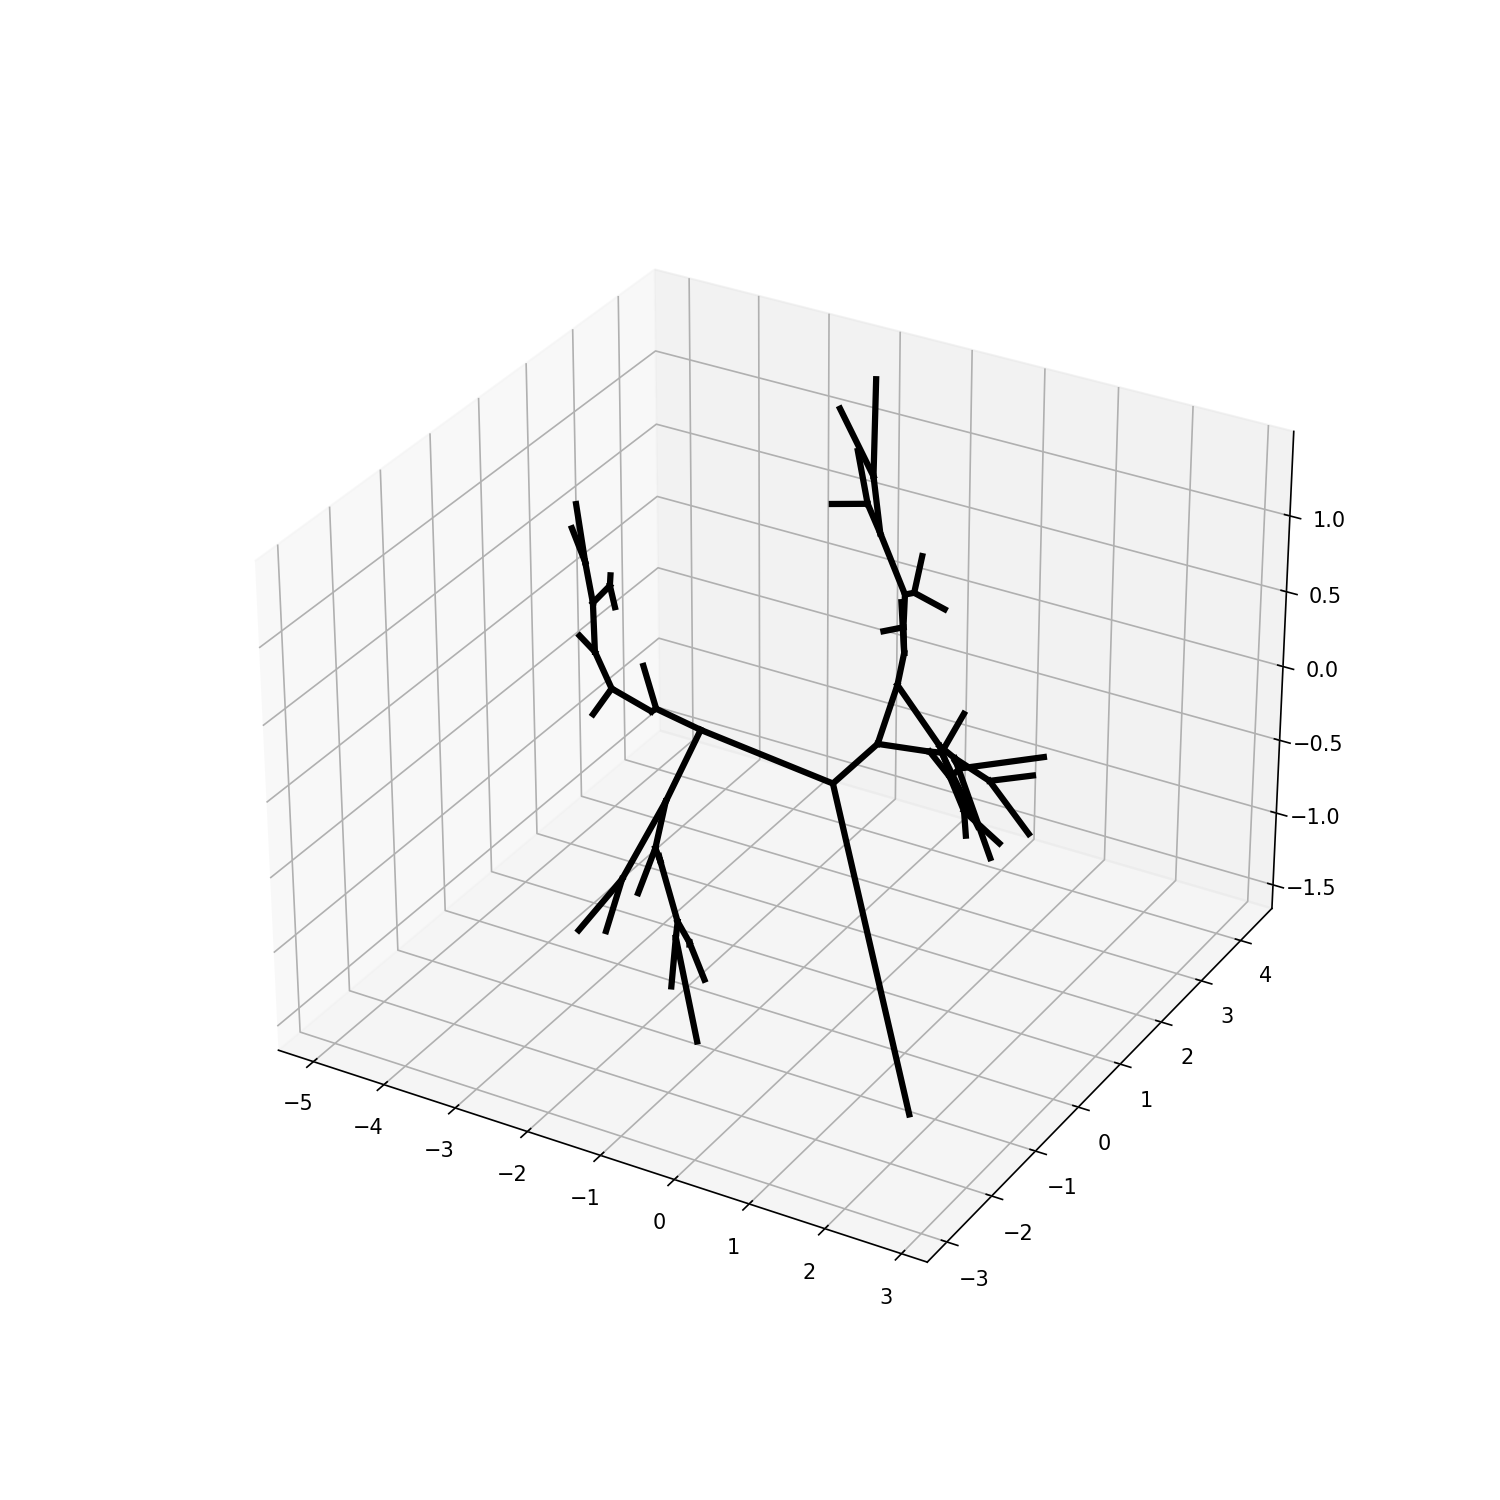

['Trachea' 'LMB' 'RMB' 'BronInt' 'RUL' 'LLB6' 'LUL' 'RB4+5' '-' 'RB1'
 'LB6' 'LB4+5' 'RLL7' 'RB6' 'RB4' 'RB5' 'RB2' 'RB3' 'LLB' 'LB3' 'LB1+2'
 'LB5' 'LB4' 'RLL' 'RB7' 'LB8' 'LB2' 'LB1' 'RB10' 'LB10' 'LB9' 'RB8' 'RB9']


In [38]:
test = toy_df_v1.loc[toy_df_v1.idno==3010007]

tree_w_coords = test.copy()
val_min = 0
val_max=1
# cmap = mpl.cm.RdYlGn#.reversed()
cmap = mpl.colormaps['PiYG'].reversed()
norm = mpl.colors.Normalize(vmin=val_min, vmax=val_max)

# simpliofy names
tree_w_coords['anatomicalname'] = tree_w_coords['anatomicalname'].apply(lambda x:"" if ('unnamed' in x) or (x == '-') else x)
tree_w_coords['color'] = tree_w_coords.anatomicalname.apply(lambda x:0 if x.lower() =='rb7' else 1)
row = tree_w_coords.iloc[0]
# quick visualisation of tree

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
for i in range(len(tree_w_coords)):
    row = tree_w_coords.iloc[i]
    ax.plot([row.parent_loc_nx,row.nx], [row.parent_loc_ny,row.ny], [row.parent_loc_nz, row.nz], linestyle='-',linewidth=3, color='k',label=row.anatomicalname)
#     ax.text(int(sum([row.parent_loc_nx_norm,row.nx_norm])/2), int(sum([row.parent_loc_ny_norm,row.ny_norm])/2),int(sum([row.parent_loc_nz_norm, row.nz_norm])/2), row.anatomicalname, color='grey')


In [41]:
def get_descendents(df):
    
    i = 0
    groups = df.groupby('idno')
    for name, group in tqdm(groups):
        i+=1
        nodes = group.endbpid.to_list() + [-1]
        edges = list(zip(group.startbpid, group.endbpid))
        g = nx.DiGraph()
        g.add_nodes_from(nodes)
        g.add_edges_from(edges)
        
        group['desc_list'] = group['endbpid'].apply(lambda x:nx.descendants(g, x))
        group['num_desc'] = group['desc_list'].apply(lambda x:len(x))
        if i==1:
            return_df = group.copy()
        else:
            return_df = pd.concat([return_df, group], axis=0)
    print(len(return_df))
    return return_df


toy_df_w_desc = get_descendents(toy_df_v1)

100%|███████████████████████████████████████████████████████████████████████████████| 2101/2101 [00:28<00:00, 74.13it/s]

138531


In [94]:

def _mutate_graph(test, remove_descs_of =['rb10', 'lb1', 'lb10'], remove = False, visualise=False):
    nodes_to_remove = []
    for name in remove_descs_of:
        try:
            descs = test[test.anatomicalname.str.lower()==name].desc_list.item()
            nodes_to_remove += descs
        except:
            display(test[test.anatomicalname.str.lower()==name].desc_list)
        
    print(nodes_to_remove)
    # REMOVING NODES MAKES OUR FAKE 'NORMAL' ANATOMY
    test_removed = test.loc[~(test.endbpid.isin(nodes_to_remove))]
    test_removed['node_label'] = 0
    # NOT REMOOVING NODES --> MARKING THEM AS ANOMALOUS
    test['node_label'] = 0
    test.loc[test.endbpid.isin(nodes_to_remove), 'node_label'] = 1
    print(len(test_removed), len(test))
    if visualise:
        tree_w_coords = test.copy()
        val_min = 0
        val_max=1
        # cmap = mpl.cm.RdYlGn#.reversed()
        cmap = mpl.colormaps['PiYG'].reversed()
        norm = mpl.colors.Normalize(vmin=val_min, vmax=val_max)

        # simpliofy names
        tree_w_coords['anatomicalname'] = tree_w_coords['anatomicalname'].apply(lambda x:"" if ('unnamed' in x) or (x == '-') else x)
        tree_w_coords['color'] = tree_w_coords.endbpid.apply(lambda x:1 if x in nodes_to_remove else 0)
        print(tree_w_coords.color.sum()/len(tree_w_coords))
        row = tree_w_coords.iloc[0]
        # quick visualisation of tree

        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(projection='3d')
        for i in range(len(tree_w_coords)):
            row = tree_w_coords.iloc[i]

            if i == 0:
                ax.scatter(row.nx_norm,row.ny_norm,row.nz_norm, color='k', label='carina')
                print(row.nx_norm,row.ny_norm,row.nz_norm)

            ax.plot([row.parent_loc_nx,row.nx], [row.parent_loc_ny,row.ny], [row.parent_loc_nz, row.nz], linestyle='-',linewidth=3, color= cmap(norm(row.node_label)), label=row.anatomicalname)
            ax.text(int(sum([row.parent_loc_nx,row.nx])/2), int(sum([row.parent_loc_ny,row.ny])/2),int(sum([row.parent_loc_nz, row.nz])/2), row.anatomicalname, color='grey')


        ax.grid(False)
        ax.set_facecolor(color=(1,1,1))
        plt.title(str(tree_w_coords.idno.unique()))
        plt.show()
        
    if remove:
        print('here')
        return test_removed
    else:
        return test
        
test = toy_df_w_desc.loc[toy_df_w_desc.idno == 3010007]
_mutate_graph(test, visualise=False, remove=True)

[192.0, 193.0, 114.0, 115.0, 190.0, 191.0, 100.0, 101.0, 170.0, 171.0, 172.0, 173.0, 160.0, 161.0, 226.0, 227.0, 228.0, 229.0]
48 66
here


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['node_label'] = 0


,index,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,...,num_children_norm,LL_1,Standard,Acc_B,Abs_RB7,Acc_LB7,Rare,Unclassified,desc_list,node_label
0,0,3010007,Trachea,4.125184,1.630629,0.0,0.0,1.0,-1.0,0.0000,...,0.0,Standard,1.0,0.0,0.0,0.0,0.0,0.0,"{2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,...",0
1,1,3010007,LMB,2.004944,0.689714,0.0,0.0,3.0,1.0,140.0360,...,0.1,Standard,1.0,0.0,0.0,0.0,0.0,0.0,"{6.0, 7.0, 12.0, 13.0, 14.0, 15.0, 25.0, 28.0,...",0
2,2,3010007,RMB,1.000000,1.000000,0.0,0.0,2.0,1.0,134.8050,...,0.1,Standard,1.0,0.0,0.0,0.0,0.0,0.0,"{4.0, 5.0, 8.0, 9.0, 10.0, 11.0, 16.0, 17.0, 1...",0
3,3,3010007,BronInt,1.172444,0.519476,0.0,0.0,4.0,2.0,160.3120,...,0.1,Standard,1.0,0.0,0.0,0.0,0.0,0.0,"{8.0, 9.0, 16.0, 17.0, 18.0, 19.0, 32.0, 33.0,...",0
4,4,3010007,RUL,0.654350,0.351148,3.0,0.0,5.0,2.0,98.5825,...,0.1,Standard,1.0,0.0,0.0,0.0,0.0,0.0,"{40.0, 41.0, 10.0, 11.0, 42.0, 43.0, 20.0, 21....",0
5,5,3010007,LLB6,0.601155,0.386157,2.0,0.0,6.0,3.0,167.2630,...,0.1,Standard,1.0,0.0,0.0,0.0,0.0,0.0,"{160.0, 161.0, 226.0, 227.0, 228.0, 229.0, 12....",0
6,6,3010007,LUL,0.632132,0.403004,1.0,0.0,7.0,3.0,101.9250,...,0.1,Standard,1.0,0.0,0.0,0.0,0.0,0.0,"{100.0, 101.0, 170.0, 171.0, 172.0, 173.0, 14....",0
7,7,3010007,RB4+5,0.877406,0.154270,4.0,0.0,9.0,4.0,126.1240,...,0.1,Standard,1.0,0.0,0.0,0.0,0.0,0.0,"{38.0, 39.0, 72.0, 73.0, 18.0, 19.0}",0
8,8,3010007,-,0.349856,0.363330,0.0,0.0,8.0,4.0,161.9840,...,0.1,Standard,1.0,0.0,0.0,0.0,0.0,0.0,"{32.0, 33.0, 192.0, 193.0, 16.0, 17.0, 112.0, ...",0
9,9,3010007,RB1,0.587226,0.075470,3.0,10.0,10.0,5.0,135.3500,...,0.1,Standard,1.0,0.0,0.0,0.0,0.0,0.0,"{40.0, 41.0, 42.0, 43.0, 20.0, 21.0}",0


In [95]:
# removing RB7 in 50% of cases
ids =list(toy_df_v1.idno.unique())
ids_to_remove = random.sample(ids, k=len(ids)//2)
print(ids_to_remove)
for i, (name, group) in tqdm(list(enumerate(toy_df_w_desc.groupby('idno')))):
    if name in ids_to_remove:
        group_mod = _mutate_graph(group, remove=True)
        print(len(group_mod), len(group))
    else:
        group_mod = _mutate_graph(group, remove=False)
        
        
    if i == 0:
        toy_df_final = group_mod.copy()
    else:
        toy_df_final = pd.concat([toy_df_final, group_mod.copy()])
    print(len(toy_df_final))


# anomalous_trees = toy_df_v1.loc[(toy_df_v1.anatomicalname.str.lower()!= 'rb7') & (toy_df_v1.idno.isin(ids_to_remove))]
# standard_trees = toy_df_v1.loc[~(toy_df_v1.idno.isin(ids_to_remove))]

# print('check', len(np.unique(anomalous_trees.idno.to_list() + standard_trees.idno.to_list())))

# toy_df_final = pd.concat([anomalous_trees, standard_trees], axis=0)
# toy_df_final['binaryLL_1'] = toy_df_final.idno.apply(lambda x:1 if x in ids_to_remove else 0)


[8016135, 5015413, 6018041, 5016363, 7015941, 3019500, 4810813, 8019860, 3012557, 4016211, 8011583, 8017832, 4017129, 4010906, 4010566, 4016602, 7017073, 4021398, 3018407, 8023409, 8017344, 8013870, 8024502, 8023301, 8014930, 5019273, 4021347, 8024405, 3012883, 8017379, 7013922, 3018172, 7017910, 6021549, 8012369, 3015661, 8019452, 4010825, 7019718, 7016921, 3011666, 7013698, 7012098, 7011776, 6012884, 7019041, 5015901, 4015061, 6010733, 8011591, 4013719, 6017126, 3011038, 7018169, 8019150, 7014082, 7018800, 8022534, 4810562, 5013852, 4010167, 5010314, 8022062, 3012140, 3016226, 8012679, 7019220, 6022456, 5013135, 3010422, 5014573, 8011370, 3021599, 3014940, 4022238, 7012110, 7014848, 6014330, 8023336, 8013250, 7017189, 4022262, 3011585, 5011043, 8024316, 3021742, 6011780, 3010228, 7016972, 8014590, 3021432, 8017719, 8010951, 3017460, 5011078, 4021940, 6017053, 8012989, 3011852, 5014379, 5019370, 8010579, 7018100, 3013936, 6016944, 4014995, 6022049, 8011931, 6011004, 6013058, 7013485, 

  0%|                                                                                          | 0/2101 [00:00<?, ?it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

[192.0, 193.0, 114.0, 115.0, 190.0, 191.0, 100.0, 101.0, 170.0, 171.0, 172.0, 173.0, 160.0, 161.0, 226.0, 227.0, 228.0, 229.0]
48 66
here
48 66
48
[358.0, 359.0, 360.0, 361.0, 276.0, 277.0, 124.0, 125.0, 68.0, 69.0, 82.0, 83.0, 148.0, 147.0, 146.0, 150.0, 149.0]
55 72
120
[335.0, 336.0, 337.0, 338.0, 252.0, 253.0, 101.0, 102.0, 179.0, 180.0, 181.0, 182.0, 193.0, 194.0, 195.0, 196.0, 113.0, 114.0]
49 67
here
49 67
169
[168.0, 169.0, 132.0, 133.0, 134.0, 135.0, 104.0, 103.0, 140.0, 141.0, 142.0, 143.0, 112.0, 113.0]
49 63
232
[398.0, 399.0, 400.0, 401.0, 308.0, 309.0, 77.0, 78.0, 147.0, 148.0, 149.0, 150.0, 356.0, 357.0, 358.0, 359.0, 266.0, 267.0]
52 70
302
[463.0, 464.0, 465.0, 466.0, 375.0, 376.0, 82.0, 83.0, 151.0, 152.0, 153.0, 154.0, 135.0, 136.0, 137.0, 74.0, 75.0, 138.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 68
here
50 68
352
[333.0, 334.0, 403.0, 404.0, 405.0, 406.0, 193.0, 194.0, 294.0, 295.0, 296.0, 297.0, 171.0, 172.0, 270.0, 271.0, 272.0, 273.0]
51 69
here
51 69
403
[480.0, 481.0, 451.0, 452.0, 453.0, 476.0, 477.0, 478.0, 479.0, 128.0, 67.0, 68.0, 125.0, 126.0, 127.0, 83.0, 84.0, 149.0, 150.0, 151.0, 152.0]
49 70
here
49 70
452
[263.0, 264.0, 406.0, 407.0, 408.0, 409.0, 324.0, 325.0, 326.0, 327.0, 201.0, 202.0, 224.0, 225.0, 226.0, 123.0, 124.0, 223.0]
49 67
519
[175.0, 176.0, 181.0, 182.0, 183.0, 184.0, 96.0, 52.0, 53.0, 93.0, 94.0, 95.0, 119.0, 151.0, 120.0, 153.0, 154.0, 152.0]
48 66
here
48 66
567
[224.0, 225.0, 280.0, 281.0, 282.0, 283.0, 188.0, 187.0, 116.0, 117.0, 100.0, 101.0, 171.0, 172.0, 173.0, 174.0]
47 63
630
[400.0, 401.0, 128.0, 129.0, 178.0, 179.0, 180.0, 181.0, 162.0, 163.0, 229.0, 230.0, 231.0, 232.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

52 66
696
[266.0, 267.0, 268.0, 269.0, 244.0, 245.0, 130.0, 131.0, 132.0, 133.0, 89.0, 90.0, 97.0, 98.0, 139.0, 138.0]
51 67
763
[188.0, 189.0, 251.0, 252.0, 253.0, 254.0, 57.0, 58.0, 101.0, 102.0, 208.0, 145.0, 146.0, 209.0, 210.0, 211.0]
48 64
here
48 64
811
[192.0, 150.0, 151.0, 189.0, 190.0, 191.0, 314.0, 315.0, 316.0, 317.0, 286.0, 287.0, 265.0, 266.0, 221.0, 222.0]
47 63
874
[144.0, 145.0, 242.0, 243.0, 244.0, 245.0, 96.0, 97.0, 174.0, 175.0, 176.0, 177.0, 423.0, 424.0, 329.0, 426.0, 330.0, 425.0]
51 69
943
[281.0, 282.0, 347.0, 348.0, 349.0, 350.0, 231.0, 232.0, 233.0, 234.0, 143.0, 144.0, 155.0, 156.0, 245.0, 246.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  1%|▋                                                                                | 17/2101 [00:00<01:22, 25.26it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 66
1009
[312.0, 313.0, 348.0, 349.0, 350.0, 351.0, 232.0, 233.0, 234.0, 235.0, 152.0, 153.0, 104.0, 105.0, 106.0, 107.0, 62.0, 63.0]
50 68
here
50 68
1059
[340.0, 341.0, 201.0, 202.0, 203.0, 204.0, 112.0, 113.0, 98.0, 99.0, 174.0, 175.0, 176.0, 177.0]
52 66
1125
[384.0, 385.0, 272.0, 273.0, 382.0, 383.0, 192.0, 193.0, 194.0, 195.0, 102.0, 103.0, 310.0, 114.0, 115.0, 116.0, 117.0, 56.0, 57.0]
49 68
1193


Series([], Name: desc_list, dtype: object)

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

[210.0, 211.0, 212.0, 213.0, 124.0, 125.0, 200.0, 201.0, 280.0, 281.0, 282.0, 283.0]
48 60
1253
[333.0, 334.0, 335.0, 304.0, 303.0, 336.0, 98.0, 99.0, 175.0, 176.0, 177.0, 178.0, 114.0, 115.0, 116.0, 117.0, 60.0, 61.0]
52 70
here
52 70
1305
[192.0, 181.0, 182.0, 191.0, 161.0, 162.0, 133.0, 134.0, 135.0, 136.0, 137.0, 91.0, 92.0, 129.0, 130.0, 83.0, 84.0]
50 67
1372
[290.0, 291.0, 292.0, 293.0, 249.0, 250.0, 96.0, 97.0, 49.0, 50.0, 94.0, 95.0, 235.0, 236.0, 237.0, 173.0, 174.0, 238.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  1%|▉                                                                                | 24/2101 [00:00<01:10, 29.26it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 67
here
49 67
1421
[373.0, 374.0, 409.0, 410.0, 411.0, 412.0, 179.0, 180.0, 181.0, 182.0, 119.0, 120.0, 201.0, 202.0, 267.0, 268.0, 269.0, 270.0]
51 69
1490
[337.0, 338.0, 339.0, 340.0, 246.0, 247.0, 70.0, 71.0, 122.0, 123.0, 124.0, 125.0, 320.0, 319.0, 392.0, 222.0, 317.0, 318.0, 223.0]
48 67
1557
[264.0, 265.0, 254.0, 255.0, 73.0, 74.0, 121.0, 122.0, 123.0, 124.0, 65.0, 66.0, 106.0, 107.0, 108.0, 109.0, 110.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  1%|█                                                                                | 27/2101 [00:00<01:10, 29.25it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 67
1624
[336.0, 379.0, 380.0, 335.0, 98.0, 99.0, 173.0, 174.0, 175.0, 176.0, 160.0, 88.0, 89.0, 157.0, 158.0, 159.0]
51 67
1691
[234.0, 235.0, 105.0, 106.0, 149.0, 150.0, 151.0, 152.0, 115.0, 116.0, 157.0, 158.0]
50 62
here
50 62
1741
[640.0, 518.0, 519.0, 637.0, 638.0, 639.0, 135.0, 72.0, 137.0, 136.0, 71.0, 138.0, 295.0, 296.0, 432.0, 433.0, 434.0, 435.0]
47 65
here
47 65
1788
[322.0, 323.0, 324.0, 325.0, 283.0, 284.0, 64.0, 65.0, 124.0, 125.0, 126.0, 127.0, 192.0, 118.0, 119.0, 189.0, 190.0, 191.0]
48 66
1854
[427.0, 428.0, 365.0, 366.0, 429.0, 430.0, 137.0, 138.0, 139.0, 140.0, 80.0, 81.0, 227.0, 228.0, 229.0, 230.0, 141.0, 142.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  2%|█▏                                                                               | 32/2101 [00:01<01:00, 34.27it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

51 69
here
51 69
1905
[524.0, 525.0, 526.0, 527.0, 442.0, 443.0, 206.0, 207.0, 283.0, 284.0, 285.0, 286.0, 231.0, 232.0, 233.0, 234.0, 180.0, 181.0]
49 67
here
49 67
1954
[256.0, 229.0, 230.0, 253.0, 254.0, 255.0, 215.0, 216.0, 217.0, 218.0, 157.0, 158.0, 201.0, 202.0, 235.0, 236.0]
51 67
2021
[469.0, 470.0, 177.0, 178.0, 275.0, 276.0, 277.0, 278.0, 78.0, 79.0, 149.0, 150.0, 151.0, 152.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  2%|█▍                                                                               | 36/2101 [00:01<01:05, 31.73it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

52 66
2087
[225.0, 226.0, 245.0, 246.0, 247.0, 248.0, 136.0, 137.0, 138.0, 139.0, 90.0, 91.0, 98.0, 99.0, 146.0, 147.0, 148.0, 149.0]
49 67
2154
[200.0, 201.0, 242.0, 243.0, 160.0, 216.0, 217.0, 218.0, 219.0, 159.0, 224.0, 225.0, 226.0, 227.0, 169.0, 170.0]
51 67
2221
[450.0, 451.0, 534.0, 535.0, 536.0, 537.0, 76.0, 77.0, 144.0, 145.0, 146.0, 147.0, 256.0, 257.0, 148.0, 149.0, 254.0, 255.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

51 69
here
51 69
2272
[352.0, 309.0, 310.0, 349.0, 350.0, 351.0, 174.0, 101.0, 102.0, 173.0, 87.0, 88.0, 153.0, 154.0, 155.0, 152.0]
53 69
2341
[274.0, 275.0, 378.0, 379.0, 380.0, 381.0, 133.0, 134.0, 232.0, 233.0, 234.0, 235.0, 207.0, 117.0, 118.0, 119.0, 120.0, 59.0, 60.0]
48 67
2408


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


[454.0, 455.0, 456.0, 457.0, 306.0, 307.0, 193.0, 98.0, 99.0, 194.0, 195.0, 196.0, 403.0, 404.0, 245.0, 246.0, 405.0, 406.0]
51 69
2477
[526.0, 527.0, 496.0, 497.0, 528.0, 529.0, 103.0, 104.0, 105.0, 106.0, 56.0, 57.0, 210.0, 211.0, 212.0, 213.0, 125.0, 126.0]
53 71
2548
[261.0, 262.0, 341.0, 342.0, 343.0, 344.0, 202.0, 203.0, 204.0, 205.0, 111.0, 112.0, 119.0, 120.0, 218.0, 219.0, 220.0, 221.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  2%|█▋                                                                               | 44/2101 [00:01<01:16, 26.99it/s]

49 67
2615
[339.0, 340.0, 109.0, 110.0, 111.0, 112.0, 59.0, 60.0, 71.0, 72.0, 119.0, 120.0, 121.0, 122.0]
51 65
2680
[322.0, 323.0, 309.0, 310.0, 160.0, 209.0, 210.0, 211.0, 212.0, 159.0, 85.0, 86.0, 121.0, 122.0, 123.0, 124.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 66
here
50 66
2730
[384.0, 385.0, 386.0, 342.0, 343.0, 383.0, 192.0, 193.0, 194.0, 114.0, 115.0, 116.0, 191.0, 131.0, 132.0, 216.0, 217.0, 218.0, 219.0]
49 68
here
49 68
2779
[288.0, 336.0, 337.0, 338.0, 339.0, 287.0, 106.0, 107.0, 177.0, 178.0, 179.0, 180.0, 100.0, 101.0, 166.0, 167.0, 165.0, 168.0]
48 66
here
48 66
2827
[160.0, 183.0, 184.0, 185.0, 186.0, 159.0, 105.0, 106.0, 107.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 56.0, 99.0, 100.0, 55.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 69
here
50 69
2877
[257.0, 258.0, 364.0, 365.0, 366.0, 367.0, 101.0, 102.0, 174.0, 175.0, 176.0, 177.0, 300.0, 301.0, 302.0, 303.0, 186.0, 187.0]
50 68
2945
[321.0, 257.0, 258.0, 323.0, 322.0, 324.0, 128.0, 129.0, 130.0, 71.0, 72.0, 127.0, 225.0, 226.0, 299.0, 146.0, 147.0]
50 67
3012
[198.0, 199.0, 200.0, 201.0, 145.0, 146.0, 204.0, 205.0, 206.0, 207.0, 149.0, 150.0, 226.0, 227.0, 228.0, 229.0, 167.0, 168.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

51 69
3081
[294.0, 295.0, 296.0, 297.0, 245.0, 246.0, 160.0, 161.0, 110.0, 111.0, 158.0, 159.0, 225.0, 226.0, 227.0, 228.0, 174.0, 175.0]
50 68
here
50 68
3131
[300.0, 301.0, 302.0, 303.0, 208.0, 209.0, 196.0, 197.0, 280.0, 281.0, 282.0, 283.0, 100.0, 101.0, 176.0, 177.0, 178.0, 179.0]
49 67
here
49 67
3180
[558.0, 719.0, 720.0, 721.0, 559.0, 722.0, 397.0, 398.0, 399.0, 400.0, 345.0, 346.0, 386.0, 387.0, 467.0, 468.0, 469.0, 470.0]
48 66
here
48 66
3228


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  3%|██▏                                                                              | 56/2101 [00:01<01:14, 27.51it/s]

[325.0, 326.0, 369.0, 370.0, 371.0, 372.0, 100.0, 101.0, 170.0, 171.0, 172.0, 173.0, 75.0, 76.0, 142.0, 143.0, 144.0, 145.0]
48 66
3294
[296.0, 316.0, 317.0, 295.0, 233.0, 234.0, 235.0, 179.0, 180.0, 141.0, 142.0, 143.0, 144.0, 113.0, 114.0]
52 67
3361
[327.0, 328.0, 329.0, 330.0, 279.0, 280.0, 98.0, 99.0, 100.0, 101.0, 54.0, 55.0, 160.0, 161.0, 88.0, 89.0, 158.0, 159.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

49 67
here
49 67
3410
[339.0, 340.0, 341.0, 342.0, 315.0, 316.0, 75.0, 140.0, 76.0, 141.0, 142.0, 139.0, 129.0, 130.0, 131.0, 68.0, 69.0, 132.0]
51 69
3479
[265.0, 266.0, 313.0, 314.0, 315.0, 316.0, 153.0, 88.0, 89.0, 154.0, 155.0, 156.0, 98.0, 99.0, 173.0, 174.0, 175.0, 176.0]
48 66
here
48 66
3527
[214.0, 215.0, 220.0, 221.0, 222.0, 223.0, 130.0, 131.0, 165.0, 166.0, 167.0, 168.0, 145.0, 146.0]
42 56
here
42 56
3569
[228.0, 229.0, 222.0, 223.0, 177.0, 178.0, 179.0, 180.0, 151.0, 152.0, 208.0, 209.0, 181.0, 182.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 64
here
50 64
3619
[267.0, 268.0, 281.0, 282.0, 283.0, 284.0, 74.0, 75.0, 110.0, 111.0, 112.0, 113.0, 102.0, 103.0, 104.0, 105.0, 62.0, 63.0]
50 68
here
50 68
3669
[392.0, 393.0, 394.0, 395.0, 312.0, 313.0, 168.0, 247.0, 246.0, 167.0, 224.0, 225.0, 226.0, 227.0, 153.0, 154.0]
49 65
here
49 65
3718
[297.0, 298.0, 299.0, 300.0, 222.0, 223.0, 182.0, 183.0, 249.0, 250.0, 251.0, 252.0, 196.0, 197.0, 270.0, 271.0, 272.0, 273.0, 274.0, 349.0, 350.0]
51 72
here
51 72
3769
[294.0, 295.0, 343.0, 344.0, 345.0, 346.0, 108.0, 109.0, 182.0, 183.0, 184.0, 185.0, 96.0, 97.0, 98.0, 99.0, 51.0, 52.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 68
here
50 68
3819


Series([], Name: desc_list, dtype: object)

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


[108.0, 109.0, 114.0, 115.0, 116.0, 117.0, 118.0, 104.0, 105.0, 112.0, 113.0]
45 56
here
45 56
3864
[398.0, 399.0, 400.0, 401.0, 254.0, 255.0, 312.0, 313.0, 308.0, 309.0, 182.0, 183.0, 184.0, 310.0, 311.0, 225.0, 226.0, 362.0, 363.0, 364.0, 365.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  3%|██▌                                                                              | 68/2101 [00:02<01:09, 29.36it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 71
3935
[200.0, 201.0, 202.0, 203.0, 152.0, 153.0, 128.0, 129.0, 70.0, 71.0, 126.0, 127.0, 138.0, 139.0, 188.0, 189.0, 190.0, 191.0]
48 66
4001
[320.0, 291.0, 292.0, 317.0, 318.0, 319.0, 139.0, 140.0, 141.0, 142.0, 82.0, 83.0, 128.0, 203.0, 204.0, 205.0, 206.0, 127.0]
50 68
4069
[265.0, 266.0, 267.0, 268.0, 252.0, 253.0, 138.0, 139.0, 140.0, 141.0, 86.0, 87.0, 176.0, 177.0, 178.0, 179.0, 120.0, 121.0]
49 67
4136
[236.0, 237.0, 246.0, 247.0, 248.0, 249.0, 162.0, 163.0, 164.0, 165.0, 112.0, 113.0, 102.0, 103.0, 104.0, 105.0, 62.0, 63.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  3%|██▋                                                                              | 71/2101 [00:02<01:09, 29.20it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 68
4204
[256.0, 257.0, 258.0, 198.0, 199.0, 255.0, 161.0, 162.0, 163.0, 164.0, 103.0, 104.0, 153.0, 154.0, 219.0, 220.0, 221.0, 222.0]
48 66
here
48 66
4252
[175.0, 176.0, 183.0, 184.0, 185.0, 186.0, 133.0, 134.0, 135.0, 136.0, 80.0, 81.0, 72.0, 73.0, 123.0, 124.0, 125.0, 126.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  4%|██▊                                                                              | 74/2101 [00:02<01:11, 28.49it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 67
4319
[302.0, 303.0, 304.0, 305.0, 219.0, 220.0, 192.0, 193.0, 194.0, 117.0, 118.0, 191.0, 101.0, 102.0, 171.0, 172.0, 173.0, 174.0]
49 67
4386
[303.0, 304.0, 305.0, 306.0, 243.0, 244.0, 108.0, 109.0, 178.0, 179.0, 180.0, 181.0, 200.0, 201.0, 202.0, 203.0, 122.0, 123.0]
50 68
here
50 68
4436
[80.0, 81.0, 151.0, 152.0, 153.0, 154.0, 261.0, 262.0, 108.0, 109.0, 187.0, 188.0, 189.0]
52 65
4501
[292.0, 293.0, 340.0, 341.0, 342.0, 343.0, 186.0, 187.0, 108.0, 109.0, 202.0, 203.0, 204.0, 205.0, 274.0, 124.0, 125.0]

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  4%|██▉                                                                              | 77/2101 [00:02<01:13, 27.45it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0



50 67
4568
[388.0, 389.0, 390.0, 391.0, 302.0, 303.0, 81.0, 82.0, 147.0, 148.0, 146.0, 149.0, 212.0, 213.0, 214.0, 215.0, 122.0, 123.0]
50 68
4636


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  4%|███                                                                              | 80/2101 [00:02<01:13, 27.65it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

[384.0, 385.0, 386.0, 366.0, 367.0, 383.0, 100.0, 101.0, 102.0, 103.0, 58.0, 59.0, 128.0, 129.0, 130.0, 131.0, 80.0, 81.0]
50 68
here
50 68
4686
[192.0, 193.0, 218.0, 217.0, 134.0, 135.0, 136.0, 137.0, 93.0, 94.0, 103.0, 104.0, 142.0, 143.0, 144.0, 145.0]
50 66
here
50 66
4736
[258.0, 259.0, 294.0, 295.0, 296.0, 297.0, 171.0, 172.0, 173.0, 174.0, 111.0, 112.0, 160.0, 101.0, 102.0, 159.0]
52 68
here
52 68
4788
[164.0, 165.0, 180.0, 181.0, 182.0, 183.0, 98.0, 99.0, 132.0, 131.0, 130.0, 133.0, 102.0, 103.0, 138.0, 139.0, 140.0, 141.0]
48 66
4854
[160.0, 161.0, 166.0, 167.0, 142.0, 125.0, 126.0, 143.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  4%|███▏                                                                             | 83/2101 [00:02<01:12, 27.89it/s]

52 60
here
52 60
4906
[256.0, 257.0, 258.0, 259.0, 208.0, 209.0, 172.0, 173.0, 174.0, 110.0, 111.0, 175.0, 160.0, 161.0, 102.0, 103.0, 158.0, 159.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

47 65
4971
[288.0, 293.0, 294.0, 295.0, 296.0, 287.0, 96.0, 97.0, 134.0, 135.0, 136.0, 137.0, 201.0, 140.0, 141.0, 177.0, 178.0, 179.0, 180.0]
52 71
here
52 71
5023
[298.0, 299.0, 300.0, 301.0, 220.0, 221.0, 176.0, 177.0, 114.0, 115.0, 178.0, 179.0, 128.0, 129.0, 196.0, 197.0, 198.0, 199.0]
50 68
5091
[394.0, 395.0, 396.0, 397.0, 346.0, 347.0, 130.0, 131.0, 132.0, 133.0, 72.0, 73.0, 152.0, 153.0, 219.0, 220.0, 221.0, 222.0]
49 67
here
49 67
5140
[270.0, 271.0, 272.0, 273.0, 220.0, 221.0, 112.0, 113.0, 188.0, 189.0, 190.0, 191.0, 104.0, 105.0, 176.0, 177.0, 178.0, 179.0]
49 67
here
49 67
5189
[336.0, 337.0, 374.0, 375.0, 376.0, 377.0, 347.0, 298.0, 299.0, 346.0, 392.0, 393.0, 354.0, 355.0]
51 65
5254
[454.0, 455.0, 392.0, 393.0, 456.0, 457.0, 131.0, 132.0, 133.0, 134.0, 70.0, 71.0, 64.0, 65.0, 118.0, 119.0, 120.0, 121.0, 122.0, 219.0, 220.0]
49 70
here
49 70
5303
[448.0, 449.0, 450.0, 347.0, 348.0, 447.0, 296.0, 297.0, 298.0, 299.0, 187.0, 188.0, 290.0, 291.0, 292.0, 293.0, 294.0, 295.0

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  4%|███▌                                                                             | 91/2101 [00:03<01:03, 31.70it/s]

51 72
here
51 72
5354
[530.0, 531.0, 532.0, 533.0, 534.0, 478.0, 479.0, 98.0, 99.0, 178.0, 179.0, 180.0, 283.0, 284.0, 125.0, 122.0, 123.0, 124.0, 61.0, 62.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

49 69
here
49 69
5403
[67.0, 50.0, 51.0, 66.0, 70.0, 71.0]
50 56
here
50 56
5453
[142.0, 143.0, 144.0, 145.0, 125.0, 126.0, 131.0, 113.0, 114.0, 115.0, 116.0, 87.0, 88.0, 138.0, 139.0, 148.0, 149.0]
48 65
here
48 65
5501
[419.0, 420.0, 459.0, 460.0, 461.0, 462.0, 197.0, 198.0, 199.0, 200.0, 149.0, 150.0, 224.0, 167.0, 168.0, 221.0, 222.0, 223.0]
50 68
5569
[320.0, 321.0, 322.0, 323.0, 285.0, 286.0, 112.0, 113.0, 114.0, 115.0, 55.0, 56.0, 130.0, 131.0, 199.0, 200.0, 201.0, 202.0]
49 67
5636
[265.0, 266.0, 297.0, 298.0, 299.0, 300.0, 249.0, 250.0, 231.0, 232.0, 271.0, 272.0, 273.0, 274.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 64
here
50 64
5686
[394.0, 395.0, 396.0, 301.0, 302.0, 397.0, 325.0, 326.0, 327.0, 328.0, 221.0, 222.0, 142.0, 239.0, 240.0, 241.0, 143.0, 242.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  5%|███▊                                                                             | 99/2101 [00:03<01:09, 28.85it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 67
5753
[112.0, 113.0, 145.0, 144.0, 146.0, 147.0, 78.0, 79.0, 122.0, 123.0, 124.0, 125.0, 128.0, 129.0, 94.0, 95.0]
50 66
5819
[339.0, 340.0, 341.0, 342.0, 313.0, 314.0, 160.0, 88.0, 89.0, 157.0, 158.0, 159.0, 66.0, 67.0, 121.0, 122.0, 123.0, 124.0]
48 66
here
48 66
5867
[299.0, 300.0, 365.0, 366.0, 367.0, 368.0, 121.0, 122.0, 187.0, 188.0, 189.0, 190.0, 104.0, 169.0, 170.0, 103.0]
49 65
5932
[120.0, 153.0, 154.0, 119.0, 136.0, 137.0, 138.0, 139.0, 89.0, 90.0, 128.0, 129.0, 81.0, 82.0, 127.0]
47 62
here
47 62
5979
[326.0, 327.0, 102.0, 103.0, 172.0, 173.0, 174.0, 175.0, 272.0, 193.0, 194.0, 271.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


52 64
here
52 64
6031
[172.0, 173.0, 176.0, 177.0, 178.0, 64.0, 49.0, 50.0, 61.0, 62.0, 63.0, 135.0, 136.0, 137.0, 113.0, 114.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  5%|███▉                                                                            | 105/2101 [00:03<01:14, 26.89it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

52 68
here
52 68
6083
[238.0, 239.0, 306.0, 307.0, 308.0, 309.0, 192.0, 193.0, 119.0, 120.0, 190.0, 191.0, 198.0, 199.0, 200.0, 201.0, 123.0, 124.0]
46 64
6147
[281.0, 282.0, 252.0, 253.0, 192.0, 193.0, 124.0, 125.0, 190.0, 191.0, 202.0, 203.0, 238.0, 239.0, 240.0, 241.0]
51 67
here
51 67
6198
[335.0, 336.0, 273.0, 274.0, 337.0, 338.0, 108.0, 109.0, 110.0, 155.0, 156.0, 157.0, 158.0, 96.0, 61.0, 60.0, 93.0, 94.0, 95.0]
51 70
here
51 70
6249
[352.0, 411.0, 412.0, 413.0, 414.0, 351.0, 145.0, 146.0, 147.0, 148.0, 92.0, 93.0, 199.0, 200.0, 271.0, 272.0, 273.0, 274.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  5%|████                                                                            | 108/2101 [00:03<01:17, 25.82it/s]

52 70
6319
[416.0, 417.0, 278.0, 279.0, 414.0, 415.0, 99.0, 100.0, 145.0, 146.0, 147.0, 148.0, 338.0, 339.0, 340.0, 341.0, 218.0, 219.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

47 65
here
47 65
6366
[434.0, 435.0, 436.0, 437.0, 406.0, 407.0, 103.0, 104.0, 151.0, 152.0, 153.0, 154.0, 56.0, 85.0, 86.0, 55.0]
50 66
here
50 66
6416
[328.0, 329.0, 330.0, 331.0, 302.0, 303.0, 70.0, 71.0, 124.0, 125.0, 126.0, 127.0, 140.0, 141.0, 210.0, 211.0, 212.0, 213.0]
52 70
here
52 70
6468
[352.0, 275.0, 276.0, 349.0, 350.0, 351.0, 261.0, 262.0, 263.0, 264.0, 187.0, 188.0, 173.0, 174.0, 242.0, 243.0, 244.0, 245.0]
51 69
6537
[262.0, 263.0, 241.0, 242.0, 249.0, 250.0, 251.0, 252.0, 253.0, 100.0, 101.0, 68.0, 69.0, 102.0, 103.0, 86.0, 87.0, 54.0, 55.0]
51 70
6607
[293.0, 294.0, 312.0, 313.0, 314.0, 315.0, 82.0, 83.0, 96.0, 97.0, 145.0, 144.0]
49 61
here
49 61
6656
[259.0, 260.0, 261.0, 262.0, 211.0, 212.0, 173.0, 174.0, 175.0, 176.0, 122.0, 123.0, 201.0, 202.0, 245.0, 246.0, 247.0, 248.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  5%|████▍                                                                           | 115/2101 [00:04<01:08, 29.05it/s]

48 66
here
48 66
6704
[192.0, 193.0, 194.0, 195.0, 168.0, 169.0, 112.0, 113.0, 154.0, 155.0, 156.0, 157.0, 172.0, 140.0, 141.0, 174.0, 175.0, 173.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 68
6772
[326.0, 327.0, 328.0, 329.0, 236.0, 237.0, 204.0, 205.0, 206.0, 207.0, 119.0, 120.0, 288.0, 289.0, 194.0, 195.0, 290.0, 291.0, 376.0]
49 68
6840
[263.0, 264.0, 265.0, 266.0, 203.0, 204.0, 98.0, 99.0, 168.0, 169.0, 170.0, 171.0, 233.0, 234.0, 235.0, 236.0, 148.0, 149.0]
50 68
6908


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


Series([], Name: desc_list, dtype: object)

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  6%|████▌                                                                           | 119/2101 [00:04<01:05, 30.47it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

[98.0, 99.0, 149.0, 150.0, 151.0, 152.0, 161.0, 110.0, 111.0, 112.0, 113.0, 58.0, 59.0]
46 59
6967
[288.0, 289.0, 258.0, 259.0, 290.0, 287.0, 97.0, 98.0, 165.0, 166.0, 167.0, 168.0, 117.0, 118.0, 188.0, 189.0, 190.0, 191.0]
53 71
here
53 71
7020
[231.0, 232.0, 233.0, 234.0, 235.0, 175.0, 176.0, 193.0, 194.0, 195.0, 196.0, 141.0, 142.0, 129.0, 130.0, 131.0, 132.0, 76.0, 77.0]
48 67
7087
[452.0, 453.0, 454.0, 455.0, 414.0, 415.0, 238.0, 239.0, 240.0, 241.0, 151.0, 152.0, 133.0, 134.0, 218.0, 219.0, 220.0, 221.0]
48 66
here
48 66
7135
[275.0, 276.0, 341.0, 342.0, 340.0, 343.0, 130.0, 131.0, 132.0, 133.0, 70.0, 71.0, 84.0, 85.0, 150.0, 151.0, 152.0, 153.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  6%|████▋                                                                           | 123/2101 [00:04<01:03, 31.15it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 67
7202
[392.0, 393.0, 120.0, 121.0, 168.0, 167.0, 241.0, 242.0, 243.0, 244.0, 183.0, 184.0, 311.0]
50 63
here
50 63
7252
[352.0, 353.0, 306.0, 307.0, 350.0, 351.0, 139.0, 140.0, 141.0, 142.0, 86.0, 87.0, 224.0, 225.0, 226.0, 163.0, 164.0, 223.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

47 65
here
47 65
7299
[331.0, 332.0, 333.0, 334.0, 284.0, 285.0, 80.0, 81.0, 150.0, 151.0, 152.0, 153.0, 129.0, 130.0, 216.0, 217.0, 218.0, 219.0]
50 68
7367
[426.0, 427.0, 251.0, 252.0, 249.0, 250.0, 155.0, 156.0, 135.0, 72.0, 73.0, 137.0, 136.0, 138.0]
53 67
7434
[200.0, 201.0, 202.0, 203.0, 111.0, 112.0, 83.0, 84.0, 155.0, 156.0, 157.0, 158.0, 77.0, 78.0, 145.0, 146.0, 147.0, 148.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 68
7502
[292.0, 293.0, 294.0, 295.0, 246.0, 247.0, 224.0, 225.0, 226.0, 227.0, 156.0, 157.0, 210.0, 146.0, 147.0, 212.0, 211.0, 213.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  6%|████▉                                                                           | 130/2101 [00:04<01:06, 29.56it/s]

50 68
here
50 68
7552
[288.0, 289.0, 290.0, 263.0, 264.0, 287.0, 209.0, 210.0, 211.0, 212.0, 155.0, 156.0, 133.0, 134.0, 135.0, 136.0, 87.0, 88.0]
49 67
here
49 67
7601
[200.0, 201.0, 202.0, 203.0, 176.0, 177.0, 146.0, 147.0, 92.0, 93.0, 160.0, 161.0, 186.0, 187.0, 188.0, 189.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 66
here
50 66
7651
[204.0, 205.0, 214.0, 215.0, 216.0, 217.0, 69.0, 70.0, 113.0, 114.0, 115.0, 116.0, 165.0, 166.0, 167.0, 107.0, 108.0]
51 68
here
51 68
7702
[334.0, 335.0, 466.0, 406.0, 407.0, 408.0, 409.0, 266.0, 267.0, 268.0, 173.0, 174.0, 269.0, 195.0, 196.0, 296.0, 297.0, 298.0, 299.0]
50 69
7771
[320.0, 321.0, 249.0, 250.0, 318.0, 319.0, 207.0, 208.0, 209.0, 210.0, 151.0, 152.0, 227.0, 228.0, 165.0, 166.0, 230.0, 229.0]
49

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


 67
7838
[210.0, 211.0, 278.0, 279.0, 280.0, 281.0, 110.0, 111.0, 182.0, 183.0, 184.0, 185.0, 230.0, 231.0, 232.0, 233.0, 158.0, 159.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


48 66
here
48 66
7886
[257.0, 258.0, 294.0, 295.0, 296.0, 297.0, 140.0, 92.0, 93.0, 141.0, 132.0, 133.0, 134.0, 135.0, 88.0, 89.0]
50 66
here
50 66
7936
[344.0, 279.0, 280.0, 345.0, 346.0, 347.0, 166.0, 167.0, 252.0, 253.0, 254.0, 255.0, 228.0, 229.0, 307.0, 308.0, 309.0, 310.0]
51 69
here
51 69


  7%|█████▏                                                                          | 137/2101 [00:04<01:05, 29.88it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


7987
[199.0, 200.0, 201.0, 202.0, 155.0, 156.0, 161.0, 162.0, 163.0, 164.0, 109.0, 110.0, 128.0, 79.0, 80.0, 125.0, 126.0, 127.0]
51 69
8056
[80.0, 79.0]
45 47
8103
[416.0, 326.0, 327.0, 413.0, 414.0, 415.0, 278.0, 279.0, 280.0, 281.0, 190.0, 191.0, 128.0, 129.0, 74.0, 75.0, 126.0, 127.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 69
here
51 69
8154
[281.0, 282.0, 279.0, 280.0, 217.0, 218.0, 97.0, 98.0, 99.0, 100.0, 54.0, 55.0, 44.0, 45.0, 79.0, 80.0, 81.0, 82.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  7%|█████▎                                                                          | 141/2101 [00:04<01:08, 28.74it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 68
here
50 68
8204
[219.0, 220.0, 121.0, 122.0, 155.0, 156.0, 157.0, 158.0, 115.0, 148.0, 116.0, 147.0, 149.0, 150.0]
50 64
8268
[136.0, 163.0, 164.0, 135.0, 129.0, 130.0, 155.0, 156.0, 113.0, 82.0, 115.0, 83.0, 116.0, 114.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  7%|█████▍                                                                          | 144/2101 [00:05<01:11, 27.44it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

48 62
8330
[227.0, 228.0, 277.0, 278.0, 279.0, 280.0, 163.0, 164.0, 100.0, 101.0, 165.0, 166.0, 68.0, 69.0, 120.0, 121.0, 122.0, 123.0]
49 67
here
49 67
8379
[105.0, 106.0, 151.0, 152.0, 153.0, 154.0, 161.0, 162.0, 117.0, 118.0]
51 61
here
51 61


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


8430
[292.0, 293.0, 294.0, 295.0, 241.0, 242.0, 203.0, 204.0, 205.0, 206.0, 145.0, 146.0, 160.0, 161.0, 162.0, 100.0, 101.0, 159.0]
51 69
8499
[262.0, 263.0, 264.0, 265.0, 236.0, 237.0, 104.0, 105.0, 106.0, 107.0, 62.0, 63.0, 176.0, 225.0, 224.0, 175.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  7%|█████▋                                                                          | 148/2101 [00:05<01:07, 28.82it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

51 67
8566
[198.0, 199.0, 241.0, 242.0, 243.0, 244.0, 108.0, 109.0, 62.0, 63.0, 123.0, 74.0, 75.0, 122.0]
49 63
here
49 63
8615
[192.0, 193.0, 282.0, 283.0, 284.0, 285.0, 160.0, 161.0, 162.0, 89.0, 90.0, 159.0, 105.0, 106.0, 180.0, 181.0, 182.0, 183.0]
48 66
here
48 66
8663
[394.0, 395.0, 396.0, 397.0, 342.0, 343.0, 246.0, 247.0, 248.0, 249.0, 190.0, 191.0, 268.0, 269.0, 326.0, 327.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

52 68
8731
[288.0, 289.0, 290.0, 291.0, 218.0, 219.0, 195.0, 196.0, 262.0, 263.0, 264.0, 265.0, 160.0, 161.0, 162.0, 163.0, 92.0, 93.0]
50 68
8799
[128.0, 121.0, 122.0, 127.0, 58.0, 59.0]
51 57
8856
[500.0, 501.0, 502.0, 503.0, 377.0, 378.0, 82.0, 83.0, 156.0, 157.0, 158.0, 159.0, 303.0, 304.0, 305.0, 306.0, 183.0, 184.0]
49 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  7%|█████▊                                                                          | 153/2101 [00:05<00:59, 32.53it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


8923
[387.0, 388.0, 85.0, 86.0, 151.0, 152.0, 153.0, 154.0, 69.0, 134.0, 70.0, 136.0, 135.0, 133.0]
52 66
here
52 66
8975
[201.0, 202.0, 203.0, 204.0, 185.0, 186.0, 98.0, 99.0, 100.0, 101.0, 59.0, 60.0, 104.0, 105.0, 140.0, 141.0, 142.0, 143.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 69
9044
[224.0, 251.0, 252.0, 253.0, 254.0, 223.0, 233.0, 234.0, 203.0, 204.0, 243.0, 244.0, 245.0, 246.0, 215.0, 216.0]
54 70
here
54 70


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  7%|█████▉                                                                          | 157/2101 [00:05<01:05, 29.54it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


9098
[308.0, 309.0, 310.0, 246.0, 247.0, 311.0, 224.0, 225.0, 143.0, 144.0, 221.0, 222.0, 223.0, 128.0, 129.0, 130.0, 73.0, 74.0, 127.0]
49 68
9166
[269.0, 270.0, 308.0, 309.0, 310.0, 311.0, 67.0, 68.0, 119.0, 120.0, 121.0, 122.0, 129.0, 130.0, 131.0, 132.0, 77.0, 78.0]
50 68
here
50 68
9216
[208.0, 197.0, 198.0, 207.0, 62.0, 61.0, 38.0, 39.0, 79.0, 80.0, 81.0, 82.0, 51.0, 52.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


47 61
9277
[352.0, 313.0, 314.0, 349.0, 350.0, 351.0, 104.0, 105.0, 178.0, 179.0, 180.0, 181.0, 195.0, 196.0, 271.0, 272.0, 273.0, 274.0]
50 68
here
50 68
9327
[164.0, 165.0, 202.0, 203.0, 204.0, 205.0, 234.0, 235.0, 274.0, 275.0, 276.0, 277.0, 194.0, 195.0, 230.0, 231.0, 232.0, 233.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  8%|██████▏                                                                         | 161/2101 [00:05<01:08, 28.41it/s]

49 67
9394
[371.0, 372.0, 508.0, 509.0, 510.0, 511.0, 331.0, 204.0, 205.0, 334.0, 332.0, 333.0, 97.0, 98.0, 294.0, 178.0, 179.0, 180.0, 181.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 69
9463
[144.0, 145.0, 150.0, 151.0, 152.0, 153.0, 72.0, 73.0, 108.0, 109.0]
50 60
here
50 60
9513
[270.0, 271.0, 309.0, 310.0, 311.0, 312.0, 196.0, 197.0, 252.0, 253.0, 254.0, 255.0, 170.0, 171.0, 172.0, 173.0, 117.0, 118.0]
49 67


  8%|██████▏                                                                         | 164/2101 [00:05<01:10, 27.49it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


9580
[298.0, 299.0, 309.0, 310.0, 311.0, 312.0, 232.0, 233.0, 246.0, 247.0, 248.0, 249.0, 220.0, 221.0]
49 63
here
49 63
9629
[337.0, 338.0, 69.0, 70.0, 135.0, 136.0, 137.0, 138.0, 87.0, 151.0, 88.0, 153.0, 154.0, 152.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 65
here
51 65
9680
[181.0, 182.0, 183.0, 184.0, 156.0, 157.0, 97.0, 98.0, 99.0, 100.0, 58.0, 59.0, 112.0, 145.0, 144.0, 111.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  8%|██████▎                                                                         | 167/2101 [00:05<01:13, 26.21it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


47 63
here
47 63
9727
[324.0, 325.0, 326.0, 327.0, 328.0, 329.0, 102.0, 103.0, 141.0, 142.0, 143.0, 144.0, 128.0, 88.0, 89.0, 125.0, 126.0, 127.0]
49 67
9794
[293.0, 294.0, 295.0, 296.0, 247.0, 248.0, 275.0, 276.0, 277.0, 278.0, 217.0, 218.0, 165.0, 166.0, 167.0, 168.0, 105.0, 106.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  8%|██████▍                                                                         | 170/2101 [00:05<01:14, 26.07it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

47 65
9859
[230.0, 231.0, 248.0, 249.0, 250.0, 251.0, 101.0, 102.0, 103.0, 104.0, 55.0, 56.0, 97.0, 98.0, 154.0, 155.0, 156.0, 157.0]
50 68
here
50 68
9909
[354.0, 355.0, 356.0, 357.0, 340.0, 341.0, 120.0, 119.0, 70.0, 71.0, 143.0, 144.0, 145.0, 146.0, 85.0, 86.0]
51 67
9976
[265.0, 266.0, 310.0, 311.0, 312.0, 313.0, 267.0, 268.0, 269.0, 270.0, 217.0, 218.0, 297.0, 182.0, 247.0, 248.0, 183.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 67
10043
[271.0, 272.0, 273.0, 274.0, 214.0, 215.0, 160.0, 161.0, 162.0, 163.0, 94.0, 95.0, 174.0, 175.0, 110.0, 177.0, 111.0, 176.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  8%|██████▋                                                                         | 174/2101 [00:06<01:10, 27.43it/s]

49 67
here
49 67
10092
[320.0, 267.0, 268.0, 317.0, 318.0, 319.0, 198.0, 199.0, 200.0, 201.0, 126.0, 127.0, 236.0, 108.0, 109.0, 176.0, 177.0, 178.0, 179.0]
50 69
here
50 69
10142
[307.0, 275.0, 276.0, 309.0, 308.0, 310.0, 206.0, 207.0, 144.0, 145.0, 208.0, 209.0, 224.0, 223.0, 265.0, 266.0, 158.0, 220.0, 221.0, 222.0, 159.0]
51 72


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

10214
[160.0, 200.0, 201.0, 202.0, 203.0, 159.0, 224.0, 225.0, 226.0, 227.0, 186.0, 187.0, 248.0, 269.0, 270.0, 247.0]
51 67
10281
[193.0, 194.0, 195.0, 196.0, 177.0, 178.0, 161.0, 162.0, 131.0, 164.0, 132.0, 163.0, 105.0, 106.0, 143.0, 144.0, 145.0, 146.0]
51 69
here
51 69
10332
[192.0, 207.0, 208.0, 209.0, 210.0, 191.0, 136.0, 137.0, 171.0, 172.0, 181.0, 150.0, 183.0, 184.0, 151.0, 182.0]
50 66
here
50 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


10382
[234.0, 203.0, 204.0, 236.0, 235.0, 237.0, 136.0, 137.0, 138.0, 139.0, 88.0, 89.0, 96.0, 97.0, 52.0, 53.0, 94.0, 95.0]
50 68
10450
[407.0, 408.0, 409.0, 410.0, 350.0, 351.0, 308.0, 309.0, 310.0, 311.0, 248.0, 249.0, 263.0, 264.0, 265.0, 266.0, 210.0, 211.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 68
10518
[421.0, 363.0, 364.0, 407.0, 408.0, 409.0, 410.0, 131.0, 132.0, 133.0, 134.0, 72.0, 73.0, 82.0, 83.0, 148.0, 147.0, 150.0, 149.0]
50 69
here
50 69
10568
[355.0, 356.0, 369.0, 370.0, 371.0, 372.0, 45.0, 46.0, 47.0, 48.0, 24.0, 25.0, 105.0, 106.0, 145.0, 146.0, 147.0, 148.0]
51 69
here
51 69
10619
[230.0, 231.0, 334.0, 335.0, 336.0, 337.0, 160.0, 250.0, 251.0, 252.0, 253.0, 159.0, 99.0, 100.0, 175.0, 176.0, 177.0, 178.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 67
10686
[353.0, 354.0, 392.0, 393.0, 394.0, 395.0, 142.0, 143.0, 214.0, 215.0, 216.0, 217.0, 68.0, 69.0, 119.0, 120.0, 121.0, 122.0]
48 66
10752
[345.0, 346.0, 111.0, 112.0, 182.0, 183.0, 184.0, 185.0, 200.0, 201.0, 123.0, 124.0]
50 62
here
50 62


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


10802
[248.0, 247.0, 153.0, 154.0, 155.0, 156.0, 93.0, 94.0, 235.0, 236.0, 237.0, 205.0, 206.0, 238.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  9%|███████                                                                         | 186/2101 [00:06<01:05, 29.31it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

53 67
10869
[299.0, 364.0, 300.0, 365.0, 366.0, 367.0, 84.0, 85.0, 150.0, 151.0, 152.0, 153.0, 98.0, 99.0, 172.0, 173.0, 174.0, 175.0]
49 67
10936
[229.0, 230.0, 305.0, 306.0, 307.0, 308.0, 277.0, 342.0, 278.0, 344.0, 345.0, 343.0, 206.0, 207.0, 208.0, 209.0, 119.0, 120.0]
50 68


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  9%|███████▏                                                                        | 189/2101 [00:06<01:08, 27.99it/s]

11004
[231.0, 232.0, 243.0, 244.0, 245.0, 246.0, 160.0, 161.0, 114.0, 115.0, 158.0, 159.0, 192.0, 193.0, 194.0, 195.0, 152.0, 153.0]
49 67
here
49 67
11053
[264.0, 265.0, 306.0, 307.0, 308.0, 309.0, 111.0, 112.0, 184.0, 185.0, 186.0, 187.0, 98.0, 99.0, 165.0, 166.0, 167.0, 168.0, 169.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 69
here
50 69
11103
[241.0, 242.0, 243.0, 244.0, 214.0, 215.0, 198.0, 199.0, 200.0, 201.0, 180.0, 181.0, 132.0, 133.0, 134.0, 135.0, 83.0, 84.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  9%|███████▎                                                                        | 192/2101 [00:06<01:12, 26.17it/s]

53 71
11174
[322.0, 323.0, 292.0, 325.0, 293.0, 324.0, 160.0, 161.0, 162.0, 163.0, 100.0, 101.0, 266.0, 267.0, 268.0, 269.0, 206.0, 207.0]
50 68
here
50 68
11224
[162.0, 163.0, 164.0, 165.0, 166.0, 167.0, 72.0, 73.0, 108.0, 109.0, 110.0, 111.0, 140.0, 141.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 64
here
50 64
11274
[832.0, 833.0, 834.0, 791.0, 792.0, 831.0, 387.0, 388.0, 438.0, 439.0, 440.0, 441.0, 450.0, 451.0, 549.0, 550.0, 551.0, 552.0, 659.0]
48 67
here
48 67
11322
[343.0, 344.0, 409.0, 410.0, 411.0, 412.0, 145.0, 146.0, 147.0, 148.0, 87.0, 88.0, 208.0, 123.0, 124.0, 207.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  9%|███████▍                                                                        | 195/2101 [00:06<01:14, 25.50it/s]

50 66
11388
[139.0, 140.0, 185.0, 186.0, 187.0, 188.0, 256.0, 257.0, 258.0, 207.0, 208.0, 255.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


57 69
11457
[331.0, 332.0, 366.0, 367.0, 132.0, 133.0, 134.0, 135.0, 76.0, 77.0, 160.0, 90.0, 91.0, 157.0, 158.0, 159.0]
50 66
here
50 66
11507
[196.0, 197.0, 212.0, 213.0, 214.0, 215.0, 80.0, 81.0, 114.0, 115.0, 113.0, 116.0, 131.0, 132.0, 94.0, 95.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
  9%|███████▌                                                                        | 198/2101 [00:07<01:16, 24.78it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

48 64
11571
[322.0, 323.0, 324.0, 325.0, 275.0, 276.0, 99.0, 100.0, 171.0, 172.0, 173.0, 174.0, 143.0, 80.0, 145.0, 146.0, 79.0, 144.0]
49 67
here
49 67
11620
[374.0, 375.0, 108.0, 109.0, 183.0, 184.0, 185.0, 186.0, 110.0, 111.0, 187.0, 188.0, 189.0, 190.0]
51 65
11685
[357.0, 358.0, 359.0, 360.0, 299.0, 300.0, 115.0, 116.0, 187.0, 188.0, 189.0, 190.0, 174.0, 175.0, 242.0, 243.0, 244.0, 245.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


52 70
here
52 70
11737
[289.0, 290.0, 308.0, 309.0, 310.0, 311.0, 129.0, 130.0, 197.0, 198.0, 199.0, 200.0, 96.0, 97.0, 147.0, 148.0, 149.0, 150.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 10%|███████▋                                                                        | 202/2101 [00:07<01:08, 27.53it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

44 62
here
44 62
11781
[272.0, 273.0, 236.0, 237.0, 144.0, 145.0, 146.0, 147.0, 94.0, 95.0, 166.0, 167.0, 168.0, 169.0, 114.0, 115.0]
48 64
here
48 64
11829
[308.0, 309.0, 409.0, 410.0, 411.0, 412.0, 288.0, 104.0, 105.0, 182.0, 183.0, 184.0, 185.0, 186.0, 357.0, 358.0, 359.0, 262.0, 263.0, 360.0]
51 71
11900
[194.0, 195.0, 309.0, 310.0, 311.0, 312.0, 99.0, 100.0, 178.0, 179.0, 180.0, 181.0, 354.0, 355.0, 438.0, 439.0, 440.0, 441.0]
50 68
here
50 68
11950
[259.0, 260.0, 261.0, 262.0, 232.0, 233.0, 160.0, 99.0, 100.0, 157.0, 158.0, 159.0, 177.0, 178.0, 179.0, 180.0, 117.0, 118.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 10%|███████▉                                                                        | 207/2101 [00:07<00:58, 32.52it/s]

49 67
here
49 67
11999
[502.0, 503.0, 504.0, 505.0, 410.0, 411.0, 38.0, 39.0, 72.0, 73.0, 74.0, 75.0, 164.0, 165.0, 166.0, 167.0, 92.0, 93.0]
50 68
12067
[366.0, 367.0, 474.0, 475.0, 476.0, 477.0, 224.0, 225.0, 130.0, 131.0, 65.0, 66.0, 118.0, 119.0, 120.0, 121.0]
48 64
here
48 64
12115
[276.0, 277.0, 316.0, 317.0, 318.0, 319.0, 46.0, 47.0, 82.0, 83.0, 84.0, 85.0, 114.0, 115.0, 116.0, 117.0, 62.0, 63.0]
49 67
here
49 67
12164


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


Series([], Name: desc_list, dtype: object)

[148.0, 149.0, 86.0, 151.0, 87.0, 150.0, 102.0, 103.0, 170.0, 171.0, 172.0, 173.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


52 64
12228
[209.0, 210.0, 165.0, 166.0, 48.0, 49.0, 91.0, 92.0, 197.0, 198.0, 199.0, 200.0, 157.0, 158.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 10%|████████                                                                        | 212/2101 [00:07<00:55, 34.05it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 64
12292
[291.0, 292.0, 293.0, 294.0, 250.0, 251.0, 66.0, 67.0, 112.0, 113.0, 114.0, 115.0, 116.0, 96.0, 97.0, 52.0, 53.0, 94.0, 95.0]
50 69
12361
[259.0, 260.0, 297.0, 298.0, 299.0, 300.0, 167.0, 168.0, 169.0, 170.0, 110.0, 111.0, 160.0, 161.0, 162.0, 106.0, 107.0, 159.0]
49 67
here
49 67
12410
[250.0, 251.0, 128.0, 129.0, 130.0, 131.0, 88.0, 89.0, 80.0, 81.0, 120.0, 121.0, 122.0, 123.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 65
12475
[360.0, 361.0, 302.0, 303.0, 171.0, 172.0, 244.0, 245.0, 246.0, 247.0, 116.0, 117.0, 187.0, 188.0, 189.0, 190.0]
57 73
12548
[163.0, 164.0, 171.0, 172.0, 173.0, 174.0, 96.0, 131.0, 132.0, 133.0, 134.0, 95.0, 152.0, 125.0, 126.0, 151.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 10%|████████▏                                                                       | 216/2101 [00:07<00:59, 31.74it/s]

52 68
12616
[203.0, 204.0, 274.0, 275.0, 276.0, 277.0, 183.0, 184.0, 251.0, 252.0, 253.0, 254.0, 168.0, 167.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 64
here
50 64
12666
[354.0, 355.0, 356.0, 357.0, 315.0, 316.0, 128.0, 129.0, 204.0, 205.0, 206.0, 207.0, 224.0, 225.0, 226.0, 227.0, 228.0, 142.0, 143.0]
49 68
here
49 68
12715
[320.0, 371.0, 372.0, 373.0, 374.0, 319.0, 208.0, 113.0, 114.0, 211.0, 210.0, 209.0, 128.0, 223.0, 222.0, 127.0]
49 65
here
49 65
12764
[256.0, 198.0, 199.0, 253.0, 254.0, 255.0, 99.0, 164.0, 100.0, 165.0, 167.0, 166.0, 160.0, 161.0, 162.0, 91.0, 92.0, 159.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 10%|████████▍                                                                       | 220/2101 [00:07<01:00, 30.84it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


46 64
here
46 64
12810
[266.0, 267.0, 284.0, 285.0, 138.0, 139.0, 140.0, 141.0, 87.0, 88.0, 99.0, 100.0, 154.0, 155.0, 156.0, 157.0]
51 67
here
51 67
12861
[138.0, 139.0, 176.0, 177.0, 178.0, 179.0, 185.0, 186.0, 148.0, 149.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


53 63
12924
[147.0, 148.0, 155.0, 156.0, 157.0, 158.0, 64.0, 65.0, 66.0, 67.0, 48.0, 49.0, 81.0, 82.0, 62.0, 63.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 11%|████████▌                                                                       | 224/2101 [00:07<01:05, 28.44it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 66
12990
[352.0, 353.0, 354.0, 249.0, 250.0, 351.0, 192.0, 106.0, 107.0, 189.0, 190.0, 191.0, 115.0, 116.0, 117.0, 118.0, 119.0, 58.0, 59.0]
49 68
13058
[327.0, 328.0, 329.0, 330.0, 253.0, 254.0, 197.0, 196.0, 108.0, 109.0, 100.0, 101.0, 182.0, 183.0, 184.0, 185.0]
50 66
here
50 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 11%|████████▋                                                                       | 227/2101 [00:07<01:05, 28.78it/s]

13108
[199.0, 200.0, 209.0, 210.0, 211.0, 212.0, 146.0, 147.0, 94.0, 95.0, 130.0, 131.0, 132.0, 133.0, 82.0, 83.0]
50 66
here
50 66
13158
[323.0, 324.0, 325.0, 326.0, 295.0, 296.0, 147.0, 148.0, 149.0, 150.0, 87.0, 88.0, 176.0, 109.0, 110.0, 175.0]
49 65
here
49 65
13207
[264.0, 265.0, 266.0, 267.0, 206.0, 207.0, 290.0, 232.0, 169.0, 170.0, 234.0, 233.0, 235.0, 160.0, 93.0, 158.0, 157.0, 94.0, 159.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 68
13275
[271.0, 272.0, 369.0, 370.0, 368.0, 371.0, 313.0, 314.0, 311.0, 312.0, 217.0, 218.0, 239.0, 240.0, 344.0, 345.0, 346.0, 347.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

49 67
13342
[293.0, 294.0, 295.0, 296.0, 244.0, 245.0, 165.0, 166.0, 103.0, 104.0, 168.0, 167.0, 258.0, 259.0, 260.0, 261.0, 203.0, 204.0]
52 70
here
52 70
13394
[455.0, 456.0, 425.0, 426.0, 457.0, 458.0, 83.0, 84.0, 151.0, 152.0, 153.0, 154.0, 257.0, 105.0, 106.0, 175.0, 176.0, 177.0, 178.0]
50 69
13463
[261.0, 262.0, 295.0, 296.0, 297.0, 298.0, 128.0, 129.0, 182.0, 183.0, 184.0, 185.0, 194.0, 195.0, 196.0, 197.0, 140.0, 141.0, 246.0]
48 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

13530
[274.0, 275.0, 136.0, 137.0, 90.0, 91.0, 226.0, 227.0, 228.0, 229.0, 182.0, 183.0]
50 62
here
50 62
13580
[359.0, 360.0, 408.0, 409.0, 410.0, 411.0, 195.0, 196.0, 197.0, 198.0, 112.0, 113.0, 209.0, 210.0, 211.0, 212.0, 124.0, 125.0]
51 69
here
51 69
13631
[363.0, 364.0, 365.0, 366.0, 277.0, 278.0, 192.0, 105.0, 106.0, 189.0, 190.0, 191.0, 219.0, 124.0, 123.0, 220.0, 221.0, 222.0]
49 67
here
49 67
13680
[299.0, 300.0, 365.0, 366.0, 367.0, 368.0, 369.0, 96.0, 97.0, 162.0, 161.0, 160.0, 163.0, 128.0, 129.0, 130.0, 131.0, 70.0, 71.0]
51 70
13750
[228.0, 229.0, 330.0, 331.0, 332.0, 333.0, 98.0, 99.0, 173.0, 174.0, 175.0, 176.0, 160.0, 260.0, 261.0, 159.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 65
here
49 65
13799
[482.0, 483.0, 484.0, 485.0, 379.0, 380.0, 164.0, 165.0, 166.0, 167.0, 86.0, 87.0, 198.0, 199.0, 310.0, 311.0, 312.0, 313.0]
51 69


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

13868
[304.0, 305.0, 234.0, 235.0, 111.0, 112.0, 177.0, 178.0, 179.0, 224.0, 225.0, 162.0, 163.0, 222.0, 223.0]
53 68
here
53 68
13921
[205.0, 206.0, 250.0, 251.0, 252.0, 253.0, 104.0, 105.0, 106.0, 107.0, 53.0, 54.0, 179.0, 180.0, 181.0, 182.0, 122.0, 123.0]
48 66
13987
[208.0, 209.0, 182.0, 183.0, 66.0, 67.0, 118.0, 119.0, 120.0, 121.0, 72.0, 73.0, 126.0, 127.0]
47 61
14048
[259.0, 260.0, 140.0, 141.0, 128.0, 129.0, 100.0, 101.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

51 59
14107
[320.0, 303.0, 304.0, 317.0, 318.0, 319.0, 140.0, 141.0, 142.0, 143.0, 81.0, 82.0, 150.0, 151.0, 152.0, 153.0, 91.0, 92.0]
50 68
here
50 68
14157
[338.0, 339.0, 405.0, 406.0, 407.0, 408.0, 141.0, 142.0, 143.0, 144.0, 83.0, 84.0, 111.0, 112.0, 113.0, 114.0, 59.0, 60.0]
48 66
14223
[353.0, 354.0, 355.0, 356.0, 306.0, 307.0, 107.0, 108.0, 109.0, 110.0, 57.0, 58.0, 205.0, 206.0, 282.0, 283.0, 284.0, 285.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 12%|█████████▎                                                                      | 245/2101 [00:08<00:51, 35.97it/s]

49 67
14290
[318.0, 285.0, 315.0, 316.0, 317.0, 286.0, 97.0, 98.0, 165.0, 166.0, 167.0, 168.0, 147.0, 148.0, 85.0, 150.0, 86.0, 149.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

51 69
14359
[512.0, 513.0, 378.0, 379.0, 510.0, 511.0, 52.0, 53.0, 92.0, 93.0, 94.0, 95.0, 192.0, 193.0, 316.0, 317.0, 318.0, 319.0]
54 72
here
54 72
14413
[432.0, 433.0, 466.0, 465.0, 464.0, 467.0, 108.0, 109.0, 110.0, 111.0, 58.0, 59.0, 36.0, 37.0, 70.0, 71.0, 72.0, 73.0]
51 69
14482
[357.0, 358.0, 359.0, 360.0, 335.0, 336.0, 381.0, 64.0, 65.0, 114.0, 115.0, 116.0, 117.0, 68.0, 69.0, 120.0, 121.0, 122.0, 123.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 12%|█████████▍                                                                      | 249/2101 [00:08<00:53, 34.36it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 69
here
50 69
14532
[288.0, 289.0, 290.0, 291.0, 209.0, 210.0, 97.0, 98.0, 163.0, 164.0, 155.0, 156.0, 153.0, 154.0, 91.0, 92.0]
50 66
here
50 66
14582
[331.0, 332.0, 375.0, 376.0, 377.0, 378.0, 39.0, 40.0, 78.0, 79.0, 80.0, 81.0, 237.0, 238.0, 239.0, 240.0, 153.0, 154.0]
51 69
14651
[335.0, 336.0, 337.0, 338.0, 285.0, 286.0, 102.0, 103.0, 177.0, 178.0, 179.0, 180.0, 104.0, 105.0, 181.0, 182.0, 183.0, 184.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 69


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 12%|█████████▋                                                                      | 253/2101 [00:08<00:56, 32.52it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


14720
[224.0, 225.0, 290.0, 289.0, 288.0, 287.0, 194.0, 130.0, 131.0, 196.0, 195.0, 197.0, 178.0, 179.0, 180.0, 181.0, 118.0, 119.0]
49 67
14787
[438.0, 439.0, 256.0, 257.0, 258.0, 153.0, 154.0, 255.0, 169.0, 170.0, 279.0, 280.0, 281.0, 282.0]
52 66
here
52 66
14839
[260.0, 261.0, 346.0, 347.0, 348.0, 349.0, 96.0, 97.0, 176.0, 177.0, 178.0, 179.0, 202.0, 203.0, 302.0, 303.0, 304.0, 305.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 68
here
50 68
14889
[330.0, 331.0, 438.0, 439.0, 440.0, 441.0, 258.0, 259.0, 162.0, 163.0, 164.0, 262.0, 263.0, 260.0, 261.0, 234.0, 138.0, 139.0, 236.0, 235.0, 237.0]
55 76
14965
[168.0, 169.0, 170.0, 171.0, 156.0, 157.0, 97.0, 98.0, 129.0, 131.0, 130.0, 132.0, 83.0, 84.0, 123.0, 124.0, 125.0, 126.0]
49 67
15032

 12%|█████████▊                                                                      | 257/2101 [00:08<01:02, 29.40it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0



[421.0, 422.0, 423.0, 424.0, 335.0, 336.0, 97.0, 98.0, 177.0, 178.0, 179.0, 180.0, 113.0, 114.0, 201.0, 202.0]
50 66
15098
[264.0, 265.0, 280.0, 281.0, 141.0, 142.0, 143.0, 144.0, 93.0, 94.0, 99.0, 100.0, 149.0, 150.0, 151.0, 152.0]
50 66
here
50 66
15148
[419.0, 420.0, 471.0, 472.0, 473.0, 474.0, 267.0, 268.0, 269.0, 270.0, 187.0, 188.0, 299.0, 300.0, 205.0, 206.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 12%|█████████▉                                                                      | 261/2101 [00:08<01:03, 28.78it/s]

51 67
here
51 67
15199
[267.0, 268.0, 269.0, 270.0, 211.0, 212.0, 108.0, 109.0, 177.0, 178.0, 179.0, 180.0, 192.0, 118.0, 119.0, 189.0, 190.0, 191.0]
49 67
here
49 67
15248
[290.0, 291.0, 360.0, 361.0, 362.0, 363.0, 96.0, 161.0, 162.0, 95.0, 75.0, 76.0, 38.0, 39.0]
48 62
15310
[428.0, 429.0, 160.0, 161.0, 86.0, 87.0, 158.0, 159.0, 100.0, 101.0, 180.0, 181.0, 182.0, 183.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

51 65
15375
[263.0, 264.0, 233.0, 234.0, 266.0, 265.0, 64.0, 33.0, 34.0, 65.0, 66.0, 63.0, 77.0, 78.0, 119.0, 120.0, 121.0, 122.0]
49 67
15442
[144.0, 149.0, 150.0, 143.0, 72.0, 99.0, 100.0, 71.0, 56.0, 57.0, 93.0, 94.0]
49 61
here
49 61
15491
[320.0, 353.0, 354.0, 355.0, 356.0, 357.0, 385.0, 384.0, 319.0, 142.0, 76.0, 77.0, 141.0, 233.0, 234.0, 164.0, 165.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 67
15558
[330.0, 331.0, 167.0, 168.0, 169.0, 170.0, 107.0, 108.0, 175.0, 112.0, 177.0, 176.0, 111.0, 178.0]
51 65
15623
[448.0, 449.0, 450.0, 383.0, 382.0, 447.0, 248.0, 249.0, 152.0, 153.0, 250.0, 251.0, 138.0, 139.0, 140.0, 141.0, 79.0, 80.0]
50 68
here
50 68
15673
[399.0, 400.0, 471.0, 472.0, 473.0, 474.0, 192.0, 193.0, 271.0, 272.0, 273.0, 274.0, 288.0, 375.0, 376.0, 377.0, 378.0, 287.0]
50 68
here
50 68
15723
[388.0, 275.0, 276.0, 387.0, 229.0, 230.0, 231.0, 232.0, 139.0, 140.0, 82.0, 83.0, 148.0, 147.0, 149.0, 150.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

53 69
here
53 69
15776
[178.0, 179.0, 214.0, 215.0, 138.0, 139.0, 140.0, 141.0, 80.0, 81.0, 156.0, 157.0, 94.0, 95.0]
50 64
15840
[192.0, 154.0, 155.0, 191.0, 70.0, 71.0, 108.0, 109.0, 110.0, 111.0, 96.0, 97.0, 98.0, 99.0, 58.0, 59.0]
49 65
15905
[279.0, 280.0, 281.0, 282.0, 252.0, 253.0, 85.0, 86.0, 151.0, 152.0, 153.0, 154.0, 161.0, 162.0, 163.0, 164.0, 93.0, 94.0]
47 65
15970
[257.0, 258.0, 308.0, 309.0, 310.0, 311.0, 113.0, 114.0, 115.0, 116.0, 117.0, 62.0, 63.0, 135.0, 136.0, 213.0, 214.0, 215.0, 216.0]
52 71
here
52 71
16022


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 13%|██████████▌                                                                     | 276/2101 [00:09<00:54, 33.30it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

[200.0, 201.0, 214.0, 215.0, 216.0, 217.0, 218.0, 65.0, 66.0, 98.0, 100.0, 97.0, 99.0, 129.0, 130.0, 131.0, 132.0, 105.0, 106.0]
48 67
16089
[301.0, 302.0, 401.0, 402.0, 403.0, 404.0, 256.0, 257.0, 179.0, 180.0, 254.0, 255.0, 201.0, 202.0, 270.0, 271.0, 272.0, 273.0]
51 69
here
51 69
16140
[394.0, 395.0, 396.0, 397.0, 305.0, 306.0, 248.0, 249.0, 247.0, 152.0, 153.0, 250.0, 168.0, 169.0, 269.0, 270.0, 271.0, 272.0]
54 72
here
54 72


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

16194
[358.0, 359.0, 360.0, 361.0, 315.0, 316.0, 66.0, 67.0, 117.0, 118.0, 119.0, 120.0, 46.0, 79.0, 47.0, 81.0, 82.0, 80.0]
52 70
16264
[422.0, 423.0, 424.0, 425.0, 277.0, 278.0, 98.0, 99.0, 187.0, 188.0, 189.0, 190.0, 235.0, 364.0, 236.0, 365.0, 366.0, 367.0]
50 68
16332
[373.0, 374.0, 375.0, 376.0, 347.0, 348.0, 128.0, 129.0, 66.0, 67.0, 130.0, 127.0, 42.0, 43.0, 80.0, 81.0, 82.0, 83.0]
51 69
here
51 69
16383
[242.0, 243.0, 151.0, 150.0, 102.0, 103.0, 162.0, 163.0, 202.0, 203.0, 204.0, 205.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

51 63
here
51 63
16434
[204.0, 205.0, 250.0, 251.0, 252.0, 253.0, 162.0, 163.0, 164.0, 165.0, 94.0, 95.0, 236.0, 237.0, 238.0, 239.0, 186.0, 187.0]
50 68
here
50 68
16484
[490.0, 440.0, 441.0, 442.0, 443.0, 381.0, 382.0, 167.0, 168.0, 241.0, 242.0, 243.0, 244.0, 352.0, 353.0, 354.0, 266.0, 267.0]
53 71
here
53 71
16537
[128.0, 206.0, 207.0, 208.0, 209.0, 127.0, 194.0, 195.0, 196.0, 197.0, 121.0, 122.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 14%|██████████▊                                                                     | 284/2101 [00:09<00:57, 31.67it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

54 66
here
54 66
16591
[256.0, 257.0, 322.0, 320.0, 321.0, 319.0, 66.0, 67.0, 124.0, 125.0, 126.0, 127.0, 153.0, 150.0, 151.0, 88.0, 89.0, 152.0]
49 67
16658
[386.0, 387.0, 406.0, 407.0, 408.0, 409.0, 227.0, 228.0, 229.0, 230.0, 169.0, 170.0, 207.0, 208.0, 209.0, 210.0, 155.0, 156.0]
51 69
here
51 69
16709
[194.0, 195.0, 196.0, 197.0, 108.0, 109.0, 210.0, 211.0, 314.0, 315.0, 316.0, 317.0]
52

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 14%|██████████▉                                                                     | 288/2101 [00:09<00:59, 30.67it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


 64
here
52 64
16761
[257.0, 258.0, 274.0, 275.0, 276.0, 277.0, 96.0, 97.0, 98.0, 99.0, 58.0, 59.0, 108.0, 109.0, 146.0, 147.0, 148.0, 149.0]
51 69
here
51 69
16812
[135.0, 136.0, 215.0, 216.0, 217.0, 218.0, 193.0, 194.0, 274.0, 275.0, 276.0, 277.0, 115.0, 116.0, 187.0, 188.0, 189.0, 190.0]
45 63
here
45 63
16857
[326.0, 327.0, 328.0, 329.0, 279.0, 280.0, 181.0, 182.0, 183.0, 120.0, 121.0, 184.0, 175.0, 176.0, 240.0, 242.0, 241.0, 243.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 68
16925
[331.0, 332.0, 333.0, 334.0, 315.0, 316.0, 137.0, 138.0, 139.0, 140.0, 85.0, 86.0, 131.0, 132.0, 237.0, 238.0, 187.0]
45 62
here
45 62
16970
[198.0, 199.0, 265.0, 266.0, 267.0, 268.0, 154.0, 155.0, 220.0, 221.0, 222.0, 223.0, 228.0, 229.0, 230.0, 231.0, 158.0, 159.0]
46 64
17034
[230.0, 231.0, 314.0, 315.0, 316.0, 317.0, 202.0, 203.0, 204.0, 205.0, 124.0, 125.0, 112.0, 113.0, 114.0, 115.0, 58.0, 59.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

49 67
17101
[224.0, 225.0, 292.0, 293.0, 294.0, 295.0, 101.0, 102.0, 170.0, 171.0, 172.0, 173.0, 117.0, 118.0, 188.0, 189.0, 190.0, 191.0]
46 64
here
46 64
17147
[228.0, 229.0, 230.0, 231.0, 182.0, 183.0, 98.0, 99.0, 152.0, 153.0, 154.0, 155.0, 166.0, 167.0, 220.0, 221.0, 222.0, 223.0]
49 67
17214
[192.0, 191.0, 252.0, 253.0, 254.0, 255.0, 96.0, 97.0, 165.0, 166.0, 167.0, 168.0, 106.0, 107.0, 177.0, 178.0, 179.0, 180.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

49 67
here
49 67
17263
[335.0, 240.0, 241.0, 338.0, 337.0, 336.0, 196.0, 197.0, 198.0, 199.0, 114.0, 115.0, 132.0, 133.0, 218.0, 219.0, 220.0, 221.0]
49 67
17330
[385.0, 386.0, 146.0, 147.0, 218.0, 219.0, 220.0, 221.0, 162.0, 163.0, 164.0, 165.0, 104.0, 105.0]
51 65
here
51 65
17381
[326.0, 327.0, 328.0, 329.0, 298.0, 299.0, 87.0, 88.0, 153.0, 154.0, 155.0, 156.0, 143.0, 144.0, 214.0, 215.0, 216.0, 217.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

51 69
17450
[265.0, 266.0, 307.0, 308.0, 309.0, 310.0, 239.0, 240.0, 283.0, 284.0, 285.0, 286.0, 195.0, 196.0, 197.0, 198.0, 137.0, 138.0]
50 68
17518
[314.0, 281.0, 282.0, 315.0, 316.0, 317.0, 107.0, 108.0, 109.0, 110.0, 61.0, 62.0, 101.0, 102.0, 156.0, 157.0, 158.0, 159.0]
49 67
17585
[296.0, 295.0, 134.0, 135.0, 202.0, 203.0, 204.0, 205.0, 70.0, 71.0, 124.0, 125.0, 126.0, 127.0]
51 65


 14%|███████████▍                                                                    | 302/2101 [00:10<01:00, 29.74it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

17650
[111.0, 112.0, 119.0, 120.0, 121.0, 122.0, 58.0, 59.0, 78.0, 79.0, 105.0, 106.0, 115.0, 116.0]
53 67
17717
[320.0, 321.0, 255.0, 254.0, 318.0, 319.0, 213.0, 212.0, 141.0, 142.0, 228.0, 229.0, 230.0, 231.0, 155.0, 156.0]
47 63
here
47 63
17764
[198.0, 199.0, 214.0, 215.0, 216.0, 217.0, 66.0, 67.0, 104.0, 105.0, 106.0, 107.0, 56.0, 57.0, 90.0, 91.0, 92.0, 93.0]
49 67
here
49 67
17813
[217.0, 214.0, 215.0, 184.0, 185.0, 216.0, 178.0, 139.0, 140.0, 179.0, 126.0, 125.0, 77.0, 78.0]
50 64
here
50 64
17863
[302.0, 303.0, 340.0, 341.0, 342.0, 343.0, 122.0, 187.0, 186.0, 123.0, 188.0, 189.0, 206.0, 207.0, 275.0, 276.0, 277.0, 278.0]
52 70
here
52 70
17915


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


[382.0, 383.0, 96.0, 97.0, 166.0, 167.0, 168.0, 169.0, 153.0, 88.0, 89.0, 154.0, 155.0, 152.0]
51 65
17980
[237.0, 238.0, 305.0, 306.0, 307.0, 308.0, 68.0, 69.0, 119.0, 120.0, 121.0, 122.0, 131.0, 132.0, 211.0, 212.0, 213.0, 214.0]
50 68
18048
[234.0, 235.0, 250.0, 251.0, 252.0, 253.0, 142.0, 143.0, 182.0, 183.0, 184.0, 185.0, 194.0, 195.0, 196.0, 197.0, 152.0, 153.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

51 69
here
51 69
18099
[205.0, 206.0, 207.0, 208.0, 189.0, 190.0, 101.0, 102.0, 103.0, 104.0, 60.0, 61.0, 113.0, 114.0, 149.0, 150.0]
51 67
18166
[320.0, 366.0, 367.0, 368.0, 369.0, 319.0, 233.0, 234.0, 299.0, 300.0, 301.0, 302.0, 141.0, 142.0, 143.0, 144.0, 83.0, 84.0]
48 66
18232
[175.0, 176.0, 177.0, 178.0, 157.0, 158.0, 88.0, 115.0, 116.0, 87.0, 96.0, 121.0, 122.0, 123.0, 124.0, 95.0]
50 66
here
50 66
18282
[228.0, 229.0, 311.0, 312.0, 313.0, 314.0, 69.0, 70.0, 110.0, 111.0, 112.0, 113.0, 138.0, 139.0, 208.0, 209.0, 210.0, 211.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 15%|███████████▉                                                                    | 315/2101 [00:10<00:58, 30.70it/s]

55 73
18355
[224.0, 225.0, 53.0, 54.0, 89.0, 90.0, 91.0, 92.0, 152.0, 185.0, 186.0, 151.0]
47 59
18414
[363.0, 364.0, 98.0, 99.0, 174.0, 175.0, 176.0, 177.0, 104.0, 105.0, 186.0, 187.0, 188.0, 189.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

52 66
18480
[552.0, 553.0, 128.0, 234.0, 235.0, 236.0, 237.0, 127.0, 203.0, 204.0, 341.0, 342.0, 343.0, 344.0]
51 65
18545
[256.0, 257.0, 431.0, 432.0, 433.0, 434.0, 207.0, 206.0, 110.0, 111.0, 132.0, 133.0, 246.0, 247.0, 248.0, 249.0]
49 65
18610
[269.0, 268.0, 245.0, 246.0, 129.0, 130.0, 131.0, 132.0, 83.0, 84.0, 201.0, 202.0, 139.0, 204.0, 140.0, 203.0]
50 66
18676
[229.0, 230.0, 377.0, 378.0, 379.0, 380.0, 279.0, 280.0, 281.0, 282.0, 158.0, 159.0, 175.0, 176.0, 308.0, 309.0, 310.0, 311.0]
49 67
18743
[224.0, 225.0, 170.0, 171.0, 222.0, 223.0, 144.0, 145.0, 146.0, 147.0, 86.0, 87.0, 44.0, 45.0, 80.0, 81.0, 82.0, 83.0]

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0



49 67
18810
[246.0, 214.0, 248.0, 249.0, 215.0, 247.0, 72.0, 73.0, 74.0, 75.0, 50.0, 51.0, 128.0, 129.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 15%|████████████▎                                                                   | 323/2101 [00:10<01:00, 29.63it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

54 68
here
54 68
18864
[336.0, 313.0, 314.0, 335.0, 42.0, 43.0, 78.0, 79.0, 80.0, 81.0, 251.0, 252.0, 293.0, 294.0]
53 67
18931
[256.0, 336.0, 337.0, 338.0, 339.0, 255.0, 66.0, 67.0, 122.0, 123.0, 124.0, 125.0, 192.0, 193.0, 194.0, 106.0, 107.0, 191.0]
50 68
18999
[382.0, 383.0, 132.0, 133.0, 134.0, 135.0, 74.0, 75.0, 145.0, 82.0, 83.0, 147.0, 146.0, 148.0]
51 65
19064
[224.0, 225.0, 172.0, 173.0, 222.0, 223.0, 104.0, 105.0, 164.0, 165.0, 198.0, 199.0, 200.0, 201.0, 148.0, 149.0]
50 66
19130
[260.0, 261.0, 305.0, 306.0, 307.0, 308.0, 135.0, 136.0, 207.0, 208.0, 209.0, 210.0, 230.0, 150.0, 151.0, 152.0, 153.0, 92.0, 93.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 68
here
49 68
19179
[293.0, 294.0, 370.0, 371.0, 372.0, 373.0, 162.0, 163.0, 164.0, 165.0, 85.0, 86.0, 99.0, 100.0, 101.0, 102.0, 50.0, 51.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

49 67
19246
[178.0, 179.0, 216.0, 217.0, 218.0, 219.0, 197.0, 196.0, 156.0, 157.0, 200.0, 201.0, 234.0, 233.0, 232.0, 235.0]
48 64
19310
[352.0, 353.0, 354.0, 282.0, 283.0, 351.0, 166.0, 167.0, 251.0, 252.0, 253.0, 254.0, 255.0, 369.0, 370.0, 371.0, 372.0, 314.0, 315.0]
50 69
19379
[317.0, 318.0, 103.0, 104.0, 178.0, 179.0, 180.0, 181.0, 92.0, 91.0, 156.0, 157.0, 158.0, 159.0]
52 66
here
52 66
19431
[96.0, 97.0, 90.0, 91.0, 94.0, 95.0, 72.0, 73.0, 52.0, 53.0, 54.0, 55.0]
46 58
here
46 58
19477
[187.0, 188.0, 112.0, 113.0, 76.0, 77.0, 70.0, 71.0, 106.0, 107.0, 108.0, 109.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 16%|████████████▋                                                                   | 333/2101 [00:11<01:02, 28.42it/s]

50 62
here
50 62
19527


Series([], Name: desc_list, dtype: object)

[153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 136.0, 135.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

48 56
here
48 56
19575
[288.0, 289.0, 345.0, 346.0, 347.0, 348.0, 105.0, 106.0, 179.0, 180.0, 181.0, 182.0, 183.0, 96.0, 163.0, 164.0, 165.0, 166.0, 95.0]
49 68
here
49 68
19624
[410.0, 411.0, 325.0, 326.0, 98.0, 99.0, 174.0, 175.0, 176.0, 177.0, 200.0, 201.0, 202.0, 203.0, 116.0, 117.0]
51 67
19691
[292.0, 293.0, 102.0, 103.0, 170.0, 171.0, 172.0, 173.0, 84.0, 85.0, 152.0, 153.0, 154.0, 155.0]
51 65
19756
[446.0, 479.0, 476.0, 477.0, 478.0, 447.0, 140.0, 141.0, 142.0, 143.0, 84.0, 85.0, 74.0, 75.0, 122.0, 123.0, 124.0, 125.0]
52 70
here
52 70
19808
[359.0, 360.0, 361.0, 362.0, 248.0, 249.0, 193.0, 194.0, 195.0, 196.0, 108.0, 109.0, 329.0, 330.0, 331.0, 332.0, 218.0, 219.0]
50 68
here
50 68


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 16%|████████████▉                                                                   | 340/2101 [00:11<00:59, 29.75it/s]

19858
[258.0, 259.0, 128.0, 129.0, 174.0, 175.0, 176.0, 177.0, 196.0, 197.0, 166.0, 199.0, 167.0, 198.0]
52 66
19924
[197.0, 198.0, 199.0, 200.0, 181.0, 182.0, 120.0, 147.0, 148.0, 119.0, 128.0, 153.0, 154.0, 127.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 64
here
50 64
19974
[272.0, 273.0, 254.0, 255.0, 192.0, 189.0, 126.0, 125.0, 190.0, 191.0, 42.0, 43.0, 79.0, 80.0, 81.0, 82.0]
51 67
20041
[273.0, 274.0, 283.0, 284.0, 285.0, 286.0, 128.0, 71.0, 72.0, 125.0, 126.0, 127.0, 139.0, 140.0, 141.0, 142.0, 85.0, 86.0]
50 68
20109
[234.0, 235.0, 300.0, 301.0, 302.0, 303.0, 194.0, 195.0, 196.0, 197.0, 110.0, 111.0, 332.0, 333.0, 334.0, 335.0, 275.0, 276.0]
52 70
here
52 70
20161
[273.0, 274.0, 282.0, 281.0, 109.0, 110.0, 143.0, 144.0, 145.0, 146.0, 119.0, 120.0, 153.0, 154.0, 155.0, 156.0]
49 65
here
49 65
20210
[376.0, 377.0, 199.0, 200.0, 281.0, 282.0, 283.0, 134.0, 135.0, 72.0, 73.0, 136.0, 137.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


52 65
here
52 65
20262
[256.0, 257.0, 166.0, 167.0, 254.0, 255.0, 200.0, 201.0, 202.0, 203.0, 114.0, 115.0, 204.0, 205.0, 206.0, 207.0, 116.0, 117.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 17%|█████████████▎                                                                  | 348/2101 [00:11<00:59, 29.22it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

48 66
here
48 66
20310
[320.0, 372.0, 373.0, 374.0, 375.0, 319.0, 104.0, 105.0, 188.0, 189.0, 288.0, 289.0, 202.0, 203.0, 286.0, 287.0]
51 67
here
51 67
20361
[162.0, 163.0, 164.0, 100.0, 101.0, 165.0, 127.0, 126.0, 188.0, 189.0, 190.0, 191.0]
52 64
20425
[419.0, 420.0, 445.0, 446.0, 84.0, 85.0, 155.0, 156.0, 157.0, 158.0, 159.0, 264.0, 265.0, 266.0, 176.0, 177.0, 341.0, 342.0]
52 70
here
52 70
20477
[390.0, 391.0, 402.0, 403.0, 404.0, 405.0, 66.0, 67.0, 118.0, 119.0, 120.0, 121.0, 82.0, 83.0, 44.0, 45.0]
48 64
20541
[116.0, 117.0, 124.0, 125.0, 126.0, 98.0, 99.0, 78.0, 79.0, 110.0, 111.0, 102.0, 103.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


47 60
20601
[389.0, 390.0, 491.0, 492.0, 493.0, 494.0, 105.0, 106.0, 107.0, 108.0, 53.0, 54.0, 115.0, 116.0, 216.0, 217.0, 218.0, 219.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 17%|█████████████▍                                                                  | 354/2101 [00:12<01:04, 27.08it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 67
here
49 67
20650
[301.0, 302.0, 335.0, 336.0, 337.0, 338.0, 78.0, 79.0, 122.0, 123.0, 124.0, 125.0, 134.0, 135.0, 136.0, 137.0, 90.0, 91.0]
49 67
here
49 67
20699
[384.0, 385.0, 386.0, 387.0, 282.0, 283.0, 130.0, 131.0, 220.0, 221.0, 222.0, 223.0, 64.0, 65.0, 34.0, 35.0, 66.0, 67.0]
51 69
20768
[82.0, 83.0, 100.0, 101.0]
51 55
here
51 55
20819
[256.0, 257.0, 292.0, 293.0, 294.0, 295.0, 136.0, 137.0, 210.0, 211.0, 212.0, 110.0, 111.0, 112.0, 113.0, 58.0, 59.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 17%|█████████████▌                                                                  | 357/2101 [00:12<01:06, 26.14it/s]

49 66
here
49 66
20868
[354.0, 355.0, 356.0, 357.0, 326.0, 327.0, 238.0, 239.0, 280.0, 281.0, 282.0, 283.0, 264.0, 265.0, 306.0, 307.0, 308.0, 309.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 68
here
50 68
20918
[331.0, 332.0, 333.0, 334.0, 303.0, 304.0, 231.0, 232.0, 233.0, 234.0, 179.0, 180.0, 273.0, 274.0, 313.0, 314.0, 315.0, 316.0]
52 70
here
52 70
20970
[368.0, 369.0, 370.0, 371.0, 318.0, 319.0, 55.0, 56.0, 90.0, 91.0, 92.0, 93.0, 69.0, 70.0, 110.0, 111.0, 112.0, 113.0]
51 69
21039
[320.0, 321.0, 322.0, 280.0, 281.0, 319.0, 114.0, 115.0, 116.0, 117.0, 61.0, 62.0, 97.0, 98.0, 172.0, 173.0, 174.0, 175.0]
51 69
21108
[173.0, 174.0, 181.0, 182.0, 183.0, 184.0, 164.0, 102.0, 103.0, 140.0, 141.0, 142.0, 143.0, 106.0, 107.0, 144.0, 145.0, 146.0, 147.0]
50 69
here
50 69
21158
[258.0, 259.0, 260.0, 261.0, 230.0, 231.0, 173.0, 174.0, 175.0, 176.0, 125.0, 126.0, 120.0, 167.0, 168.0, 119.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


53 69
21227
[260.0, 261.0, 295.0, 296.0, 297.0, 298.0, 168.0, 169.0, 228.0, 229.0, 289.0, 290.0, 291.0, 292.0, 252.0, 253.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 17%|█████████████▊                                                                  | 364/2101 [00:12<01:02, 27.74it/s]

54 70
here
54 70
21281
[275.0, 243.0, 277.0, 244.0, 276.0, 278.0, 288.0, 251.0, 252.0, 285.0, 286.0, 287.0, 168.0, 169.0, 217.0, 218.0, 219.0, 220.0]
47 65
21346


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


Series([], Name: desc_list, dtype: object)

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

[178.0, 179.0, 220.0, 221.0, 196.0, 197.0, 242.0, 243.0, 244.0, 245.0]
55 65
here
55 65
21401
[464.0, 465.0, 466.0, 467.0, 382.0, 383.0, 104.0, 105.0, 188.0, 189.0, 202.0, 203.0, 204.0, 205.0, 114.0, 115.0]
51 67
21468
[128.0, 129.0, 182.0, 183.0, 184.0, 185.0, 198.0, 199.0, 241.0, 242.0, 243.0, 244.0]
53 65
21533
[387.0, 388.0, 389.0, 390.0, 315.0, 316.0, 185.0, 120.0, 121.0, 186.0, 187.0, 188.0, 164.0, 165.0, 166.0, 167.0, 168.0, 110.0, 111.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 68
here
49 68
21582
[354.0, 355.0, 167.0, 168.0, 252.0, 253.0, 254.0, 255.0, 192.0, 193.0, 272.0, 273.0, 274.0, 275.0, 345.0]
52 67
here
52 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


21634
[290.0, 291.0, 362.0, 363.0, 364.0, 365.0, 192.0, 249.0, 250.0, 251.0, 252.0, 191.0, 385.0, 386.0, 342.0, 343.0]
52 68
here
52 68
21686
[304.0, 305.0, 162.0, 163.0, 212.0, 213.0, 288.0, 289.0, 250.0, 251.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 18%|██████████████▏                                                                 | 372/2101 [00:12<00:58, 29.73it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

53 63
21749
[297.0, 298.0, 380.0, 381.0, 382.0, 383.0, 68.0, 69.0, 106.0, 107.0, 108.0, 109.0, 170.0, 98.0, 99.0, 100.0, 101.0, 58.0, 59.0]
50 69
21818
[356.0, 357.0, 358.0, 359.0, 241.0, 242.0, 162.0, 163.0, 164.0, 165.0, 88.0, 89.0, 320.0, 321.0, 200.0, 201.0, 318.0, 319.0]
49 67
21885
[313.0, 314.0, 260.0, 261.0, 149.0, 85.0, 86.0, 152.0, 151.0, 150.0, 167.0, 168.0, 242.0, 243.0, 244.0, 245.0]
50 66
21951
[201.0, 202.0, 207.0, 208.0, 209.0, 210.0, 128.0, 155.0, 156.0, 157.0, 158.0, 127.0, 163.0, 164.0, 133.0, 134.0]
47 63
here
47 63


 18%|██████████████▎                                                                 | 376/2101 [00:12<00:55, 31.01it/s]

21998
[448.0, 449.0, 450.0, 451.0, 381.0, 382.0, 383.0, 170.0, 171.0, 172.0, 173.0, 94.0, 95.0, 138.0, 139.0, 140.0, 76.0, 77.0, 141.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


52 71
here
52 71
22050
[225.0, 226.0, 227.0, 228.0, 185.0, 186.0, 71.0, 72.0, 117.0, 118.0, 119.0, 120.0, 85.0, 53.0, 54.0, 88.0, 87.0, 86.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

51 69
here
51 69
22101
[178.0, 179.0, 174.0, 175.0, 66.0, 99.0, 67.0, 100.0, 102.0, 101.0, 105.0, 106.0]
51 63
22164
[480.0, 479.0, 239.0, 240.0, 241.0, 242.0, 155.0, 156.0, 269.0, 270.0, 369.0, 370.0, 371.0, 372.0]
52 66
here
52 66
22216
[357.0, 358.0, 375.0, 376.0, 377.0, 378.0, 66.0, 67.0, 114.0, 115.0, 116.0, 117.0, 70.0, 71.0, 202.0, 122.0, 123.0, 124.0, 125.0]
50 69
22285


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


[192.0, 219.0, 220.0, 221.0, 222.0, 191.0, 70.0, 71.0, 114.0, 115.0, 116.0, 117.0, 72.0, 73.0, 118.0, 119.0]
49 65


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 18%|██████████████▌                                                                 | 383/2101 [00:13<01:02, 27.62it/s]

22350
[325.0, 326.0, 378.0, 379.0, 380.0, 381.0, 172.0, 173.0, 238.0, 239.0, 240.0, 241.0, 103.0, 104.0, 210.0, 211.0, 153.0, 154.0, 155.0]
51 70
here
51 70
22401


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

[162.0, 163.0, 176.0, 177.0, 178.0, 179.0, 38.0, 39.0, 55.0, 56.0, 57.0, 58.0, 128.0, 89.0, 90.0, 129.0]
50 66
here
50 66
22451
[321.0, 322.0, 323.0, 324.0, 247.0, 248.0, 100.0, 101.0, 180.0, 181.0, 182.0, 183.0, 195.0, 196.0, 197.0, 198.0, 114.0, 115.0]
49 67
here
49 67
22500
[233.0, 234.0, 235.0, 236.0, 309.0, 158.0, 159.0, 105.0, 106.0, 176.0, 177.0, 178.0, 179.0, 253.0, 194.0, 195.0, 270.0, 271.0, 272.0, 273.0]
49 69
here
49 69
22549
[122.0, 123.0, 124.0, 125.0, 92.0, 93.0, 90.0, 91.0, 60.0, 61.0, 100.0, 101.0, 110.0, 111.0, 112.0, 113.0]
46 62
here
46 62


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


22595
[325.0, 326.0, 327.0, 328.0, 271.0, 272.0, 224.0, 147.0, 148.0, 221.0, 222.0, 223.0, 158.0, 155.0, 156.0, 157.0, 94.0, 95.0]
50 68
22663
[277.0, 278.0, 315.0, 316.0, 317.0, 318.0, 106.0, 107.0, 60.0, 61.0, 122.0, 187.0, 186.0, 123.0, 188.0, 189.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 19%|██████████████▊                                                                 | 389/2101 [00:13<01:06, 25.71it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

48 64
22727
[260.0, 261.0, 262.0, 263.0, 190.0, 191.0, 212.0, 213.0, 214.0, 215.0, 152.0, 153.0, 108.0, 109.0, 176.0, 177.0, 178.0, 179.0]
49 67
22794
[347.0, 380.0, 377.0, 378.0, 379.0, 348.0, 162.0, 163.0, 92.0, 93.0, 232.0, 233.0, 234.0, 235.0, 150.0, 151.0]
52 68
22862
[399.0, 400.0, 401.0, 402.0, 347.0, 348.0, 109.0, 110.0, 177.0, 178.0, 179.0, 180.0, 160.0, 99.0, 100.0, 157.0, 158.0, 159.0]
50 68
here
50 68
22912
[242.0, 243.0, 250.0, 251.0, 252.0, 253.0, 100.0, 101.0, 144.0, 145.0, 146.0, 147.0, 73.0, 74.0, 120.0, 121.0, 122.0, 123.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

48 66
22978
[229.0, 230.0, 301.0, 302.0, 303.0, 304.0, 199.0, 200.0, 201.0, 202.0, 124.0, 125.0, 98.0, 99.0, 171.0, 172.0, 173.0, 174.0]
50 68
here
50 68
23028
[416.0, 353.0, 354.0, 413.0, 414.0, 415.0, 77.0, 78.0, 149.0, 150.0, 151.0, 152.0, 302.0, 303.0, 372.0, 373.0, 374.0, 375.0, 376.0]


 19%|███████████████                                                                 | 395/2101 [00:13<01:02, 27.36it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

54 73
23101
[315.0, 316.0, 379.0, 380.0, 381.0, 382.0, 161.0, 162.0, 163.0, 164.0, 89.0, 90.0, 101.0, 102.0, 173.0, 174.0, 175.0, 176.0]
49 67
23168
[232.0, 233.0, 268.0, 269.0, 270.0, 271.0, 96.0, 161.0, 160.0, 210.0, 211.0, 95.0, 159.0, 139.0, 140.0, 141.0, 142.0, 81.0, 82.0]
46 65
here
46 65
23214
[264.0, 265.0, 304.0, 305.0, 306.0, 307.0, 67.0, 68.0, 124.0, 125.0, 126.0, 127.0, 233.0, 234.0, 235.0, 236.0, 172.0, 173.0]
49 67
here
49 67
23263
[212.0, 213.0, 254.0, 255.0, 170.0, 113.0, 114.0, 171.0, 55.0, 56.0, 57.0, 58.0, 30.0, 31.0]
47 61
here
47 61
23310
[234.0, 235.0, 334.0, 335.0, 336.0, 337.0, 98.0, 99.0, 170.0, 171.0, 172.0, 173.0, 192.0, 193.0, 194.0, 195.0, 112.0, 113.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 67
23377
[338.0, 339.0, 40.0, 41.0, 76.0, 77.0, 204.0, 205.0, 140.0, 141.0, 206.0, 207.0, 273.0]
52 65
here
52 65
23429
[226.0, 227.0, 262.0, 263.0, 264.0, 265.0, 139.0, 140.0, 141.0, 142.0, 81.0, 82.0, 145.0, 209.0, 146.0, 147.0, 148.0, 89.0, 90.0]
49 68
here
49 68


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

23478
[270.0, 271.0, 316.0, 317.0, 318.0, 319.0, 96.0, 97.0, 161.0, 160.0, 162.0, 159.0, 256.0, 257.0, 177.0, 178.0, 254.0, 255.0]
50 68
here
50 68
23528
[362.0, 363.0, 311.0, 312.0, 345.0, 346.0, 347.0, 208.0, 209.0, 210.0, 147.0, 148.0, 211.0, 224.0, 225.0, 226.0, 227.0, 157.0, 158.0]
49 68
23596
[192.0, 201.0, 202.0, 203.0, 204.0, 191.0, 66.0, 67.0, 106.0, 107.0, 108.0, 109.0, 78.0, 79.0, 118.0, 119.0, 120.0, 121.0, 154.0]
49 68
23664
[276.0, 277.0, 212.0, 213.0, 278.0, 279.0, 160.0, 161.0, 90.0, 91.0, 157.0, 158.0, 159.0, 106.0, 107.0, 174.0, 175.0, 176.0, 177.0]
47 66
here
47 66
23711
[204.0, 205.0, 206.0, 207.0, 178.0, 179.0, 103.0, 104.0, 153.0, 154.0, 155.0, 156.0, 194.0, 195.0, 165.0, 166.0, 167.0, 113.0, 114.0]
49 68
here
49 68
23760
[333.0, 334.0, 149.0, 85.0, 86.0, 152.0, 151.0, 150.0, 128.0, 129.0, 130.0, 71.0, 72.0, 127.0]
51 65
23825
[301.0, 302.0, 341.0, 342.0, 343.0, 344.0, 64.0, 65.0, 122.0, 123.0, 124.0, 125.0, 146.0, 147.0, 215.0, 216.0, 217.0, 218.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

51 69
23894
[194.0, 195.0, 263.0, 264.0, 265.0, 266.0, 128.0, 129.0, 68.0, 69.0, 126.0, 127.0, 42.0, 43.0, 82.0, 83.0, 84.0, 85.0]
47 65
here
47 65
23941
[325.0, 326.0, 327.0, 328.0, 278.0, 279.0, 97.0, 98.0, 164.0, 165.0, 166.0, 167.0, 262.0, 263.0, 264.0, 265.0, 190.0, 191.0]
51 69
24010
[233.0, 234.0, 235.0, 236.0, 147.0, 148.0, 163.0, 164.0, 165.0, 166.0, 93.0, 94.0, 291.0, 292.0, 293.0, 294.0, 199.0, 200.0]
50 68
24078
[398.0, 399.0, 136.0, 137.0, 209.0, 210.0, 211.0, 212.0, 237.0, 238.0, 239.0, 240.0, 158.0, 159.0]
51 65
24143
[295.0, 296.0, 297.0, 298.0, 269.0, 270.0, 97.0, 98.0, 151.0, 152.0, 153.0, 154.0, 143.0, 144.0, 145.0, 146.0, 93.0, 94.0]
48

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

 66
24209
[256.0, 275.0, 276.0, 277.0, 278.0, 255.0, 96.0, 97.0, 56.0, 57.0, 94.0, 95.0, 68.0, 69.0, 102.0, 103.0, 104.0, 105.0]
50 68
here
50 68
24259
[99.0, 100.0, 167.0, 168.0, 169.0, 170.0, 73.0, 74.0, 137.0, 139.0, 138.0, 140.0]
52 64
24323
[256.0, 241.0, 242.0, 253.0, 254.0, 255.0, 90.0, 59.0, 58.0, 91.0, 92.0, 93.0, 102.0, 103.0, 138.0, 139.0, 140.0, 141.0]
51 69
24392
[288.0, 289.0, 290.0, 291.0, 274.0, 275.0, 214.0, 215.0, 216.0, 217.0, 186.0, 187.0, 204.0, 205.0, 206.0, 207.0, 178.0, 179.0]
51 69
24461
[386.0, 387.0, 388.0, 389.0, 337.0, 338.0, 140.0, 141.0, 142.0, 143.0, 80.0, 81.0, 128.0, 129.0, 203.0, 204.0, 205.0, 206.0]
52 70
24531
[367.0, 368.0, 369.0, 370.0, 318.0, 319.0, 118.0, 119.0, 218.0, 219.0, 220.0, 221.0, 196.0, 197.0, 198.0, 199.0, 104.0, 105.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

51 69
24600
[162.0, 163.0, 168.0, 169.0, 170.0, 171.0, 62.0, 63.0, 72.0, 73.0, 108.0, 109.0, 110.0, 111.0]
50 64
here
50 64
24650
[168.0, 169.0, 196.0, 197.0, 96.0, 97.0, 144.0, 145.0, 146.0, 147.0, 95.0, 160.0, 161.0, 204.0, 186.0, 187.0, 188.0, 189.0]
51 69
24719
[196.0, 197.0, 190.0, 191.0, 132.0, 133.0, 134.0, 135.0, 88.0, 89.0, 148.0, 100.0, 101.0, 149.0]
48 62
24781
[163.0, 164.0, 181.0, 182.0, 183.0, 184.0, 44.0, 77.0, 45.0, 79.0, 76.0, 78.0, 116.0, 66.0, 99.0, 67.0, 100.0, 98.0, 101.0]
49 68
24849
[301.0, 302.0, 52.0, 53.0, 90.0, 91.0, 92.0, 93.0, 66.0, 67.0, 106.0, 107.0, 108.0, 109.0]
51 65
here
51 65
24900
[193.0, 194.0, 219.0, 218.0, 76.0, 77.0, 123.0, 124.0, 125.0, 126.0, 162.0, 163.0, 117.0, 118.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 64
here
50 64
24950
[395.0, 396.0, 82.0, 83.0, 122.0, 123.0, 124.0, 125.0, 136.0, 137.0, 138.0, 139.0, 94.0, 95.0]
50 64
here
50 64
25000
[193.0, 194.0, 195.0, 196.0, 151.0, 152.0, 98.0, 99.0, 100.0, 101.0, 60.0, 61.0, 192.0, 104.0, 105.0, 142.0, 143.0, 144.0, 145.0, 146.0, 191.0]
44 65
25065
[288.0, 289.0, 300.0, 301.0, 71.0, 72.0, 73.0, 74.0, 49.0, 50.0, 171.0, 172.0, 212.0, 213.0, 214.0, 215.0, 216.0, 251.0, 252.0]
51 70
here
51 70
25116
[487.0, 488.0, 430.0, 431.0, 432.0, 433.0, 434.0, 346.0, 347.0, 288.0, 289.0, 290.0, 291.0, 190.0, 191.0, 162.0, 163.0, 164.0, 165.0, 88.0, 89.0]
50 71
here
50 71
25166
[448.0, 449.0, 450.0, 451.0, 325.0, 326.0, 132.0, 68.0, 134.0, 69.0, 133.0, 135.0, 40.0, 41.0, 78.0, 79.0, 80.0, 81.0]
49 67
here
49 67
25215
[354.0, 234.0, 235.0, 306.0, 307.0, 308.0, 309.0, 66.0, 67.0, 123.0, 124.0, 125.0, 126.0, 108.0, 109.0, 110.0, 111.0, 58.0, 59.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 21%|████████████████▍                                                               | 432/2101 [00:14<00:55, 30.27it/s]

48 67
25282
[518.0, 519.0, 599.0, 600.0, 601.0, 602.0, 132.0, 133.0, 207.0, 208.0, 209.0, 210.0, 224.0, 225.0, 226.0, 142.0, 143.0, 223.0]
49 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

25349
[146.0, 147.0, 142.0, 143.0, 80.0, 81.0, 116.0, 117.0, 118.0, 119.0, 72.0, 73.0, 110.0, 111.0]
47 61
25410
[330.0, 331.0, 358.0, 359.0, 96.0, 129.0, 130.0, 128.0, 131.0, 95.0, 197.0, 198.0, 199.0, 200.0, 138.0, 139.0]
51 67
here
51 67
25461
[384.0, 383.0, 134.0, 135.0, 136.0, 137.0, 76.0, 77.0, 221.0, 230.0, 231.0, 232.0, 233.0, 152.0, 153.0]
50 65
25526
[121.0, 122.0, 99.0, 100.0, 113.0, 114.0, 105.0, 106.0, 123.0, 124.0]
45 55
here
45 55
25571
[169.0, 170.0, 195.0, 194.0, 160.0, 181.0, 182.0, 183.0, 184.0, 159.0, 128.0, 163.0, 164.0, 127.0]
50 64
25635
[260.0, 261.0, 262.0, 263.0, 232.0, 233.0, 137.0, 138.0, 139.0, 140.0, 86.0, 87.0, 163.0, 164.0, 165.0, 166.0, 110.0, 111.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 68
here
50 68
25685
[234.0, 235.0, 308.0, 309.0, 310.0, 311.0, 107.0, 108.0, 185.0, 186.0, 187.0, 188.0, 128.0, 73.0, 74.0, 125.0, 126.0, 127.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 21%|████████████████▊                                                               | 440/2101 [00:15<00:55, 29.78it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 67
25752
[384.0, 289.0, 290.0, 385.0, 386.0, 383.0, 68.0, 36.0, 37.0, 70.0, 71.0, 69.0, 256.0, 150.0, 151.0, 253.0, 254.0, 255.0]
50 68
here
50 68
25802
[200.0, 199.0, 142.0, 143.0, 144.0, 145.0, 94.0, 95.0, 96.0, 97.0, 146.0, 147.0, 148.0, 149.0, 150.0]
51 66
here
51 66
25853
[187.0, 188.0, 254.0, 255.0, 97.0, 98.0, 99.0, 100.0, 50.0, 51.0, 244.0, 245.0, 181.0, 182.0, 246.0, 247.0]
49 65
here
49 65
25902
[422.0, 423.0, 424.0, 425.0, 369.0, 370.0, 204.0, 205.0, 206.0, 207.0, 113.0, 114.0, 226.0, 227.0, 228.0, 229.0, 125.0, 126.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 68
here
50 68
25952
[322.0, 323.0, 324.0, 325.0, 265.0, 266.0, 227.0, 228.0, 229.0, 230.0, 157.0, 158.0, 112.0, 113.0, 181.0, 182.0, 183.0, 184.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 21%|████████████████▉                                                               | 446/2101 [00:15<01:02, 26.37it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

51 69
here
51 69
26003
[266.0, 267.0, 268.0, 269.0, 187.0, 188.0, 160.0, 161.0, 162.0, 163.0, 92.0, 93.0, 144.0, 145.0, 82.0, 83.0, 146.0, 147.0]
50 68
here
50 68
26053
[96.0, 97.0, 90.0, 91.0, 94.0, 95.0, 77.0, 78.0, 79.0, 80.0, 61.0, 62.0, 75.0, 76.0, 87.0, 59.0, 60.0]
43 60
here
43 60
26096
[192.0, 224.0, 191.0, 225.0, 222.0, 223.0, 216.0, 217.0, 181.0, 182.0, 169.0, 170.0, 203.0, 204.0, 205.0, 206.0]
49 65
26161
[412.0, 317.0, 316.0, 413.0, 414.0, 415.0, 162.0, 259.0, 163.0, 260.0, 261.0, 258.0, 194.0, 195.0, 196.0, 197.0, 108.0, 109.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 21%|█████████████████                                                               | 449/2101 [00:15<01:06, 25.01it/s]

50 68
26229
[145.0, 146.0, 141.0, 142.0, 84.0, 85.0, 118.0, 119.0, 120.0, 121.0, 116.0, 117.0, 78.0, 79.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 64
26293
[261.0, 262.0, 308.0, 309.0, 310.0, 311.0, 98.0, 99.0, 164.0, 163.0, 165.0, 166.0, 175.0, 176.0, 244.0, 245.0, 246.0, 247.0]
51 69
26362
[253.0, 252.0, 173.0, 174.0, 108.0, 109.0, 187.0, 188.0, 189.0, 190.0, 358.0, 359.0, 296.0, 360.0, 295.0, 361.0]
51 67
here
51 67
26413
[295.0, 296.0, 297.0, 298.0, 251.0, 252.0, 110.0, 111.0, 112.0, 113.0, 61.0, 62.0, 229.0, 179.0, 180.0, 228.0]
50 66
here
50 66
26463
[165.0, 166.0, 181.0, 182.0, 183.0, 184.0, 105.0, 106.0, 137.0, 138.0, 128.0, 88.0, 89.0, 125.0, 126.0, 127.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


46 62
26525
[224.0, 225.0, 244.0, 245.0, 246.0, 247.0, 128.0, 129.0, 130.0, 78.0, 79.0, 127.0, 171.0, 172.0, 117.0, 118.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 22%|█████████████████▎                                                              | 455/2101 [00:15<01:07, 24.42it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 65
here
49 65
26574
[397.0, 398.0, 476.0, 477.0, 478.0, 479.0, 66.0, 67.0, 122.0, 123.0, 124.0, 125.0, 248.0, 249.0, 352.0, 351.0]
51 67
here
51 67
26625
[192.0, 193.0, 180.0, 181.0, 190.0, 191.0, 105.0, 106.0, 140.0, 141.0, 142.0, 143.0, 113.0, 114.0, 148.0, 149.0, 150.0, 151.0]
47 65
here
47 65
26672
[289.0, 290.0, 331.0, 332.0, 333.0, 334.0, 71.0, 72.0, 109.0, 110.0, 111.0, 112.0, 131.0, 132.0, 133.0, 134.0, 89.0, 90.0]
49 67
26739
[256.0, 282.0, 283.0, 284.0, 285.0, 255.0, 186.0, 187.0, 184.0, 185.0, 122.0, 123.0, 104.0, 105.0, 106.0, 107.0, 57.0, 58.0]
48 66
here
48 66
26787
[193.0, 194.0, 195.0, 196.0, 189.0, 190.0, 72.0, 36.0, 37.0, 71.0, 128.0, 83.0, 84.0, 127.0]
47 61
here
47 61
26834
[302.0, 303.0, 304.0, 305.0, 218.0, 219.0, 98.0, 99.0, 171.0, 172.0, 173.0, 174.0, 192.0, 112.0, 113.0, 189.0, 190.0, 191.0]
49 67
26901
[450.0, 451.0, 452.0, 453.0, 391.0, 392.0, 84.0, 85.0, 156.0, 157.0, 158.0, 159.0, 224.0, 225.0, 226.0, 227.0, 140.0, 141.0]
51 69
26970
[284.0, 285.0, 145.0

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 64
27034
[451.0, 452.0, 453.0, 454.0, 406.0, 407.0, 96.0, 58.0, 59.0, 93.0, 94.0, 95.0, 167.0, 168.0, 169.0, 170.0, 109.0, 110.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 22%|█████████████████▋                                                              | 465/2101 [00:15<00:49, 32.80it/s]

51 69
here
51 69
27085
[293.0, 294.0, 295.0, 296.0, 188.0, 189.0, 86.0, 87.0, 156.0, 157.0, 158.0, 159.0, 134.0, 135.0, 136.0, 137.0, 74.0, 75.0]
49 67
here
49 67
27134
[324.0, 325.0, 370.0, 371.0, 372.0, 373.0, 105.0, 106.0, 178.0, 179.0, 180.0, 181.0, 194.0, 195.0, 196.0, 197.0, 115.0, 116.0]
52 70
27204


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


Series([], Name: desc_list, dtype: object)

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

[192.0, 191.0, 153.0, 154.0, 187.0, 188.0, 189.0, 190.0]
41 49
here
41 49
27245
[288.0, 273.0, 274.0, 285.0, 286.0, 287.0, 65.0, 66.0, 109.0, 110.0, 111.0, 112.0, 71.0, 72.0, 117.0, 118.0, 119.0, 120.0]
50 68
27313
[288.0, 289.0, 254.0, 255.0, 230.0, 231.0, 268.0, 269.0, 270.0, 271.0, 95.0, 94.0, 156.0, 157.0, 158.0, 159.0]
49 65
here
49 65
27362
[268.0, 269.0, 236.0, 237.0, 270.0, 271.0, 167.0, 168.0, 169.0, 170.0, 111.0, 112.0, 103.0, 104.0, 155.0, 156.0, 157.0, 158.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 68
here
50 68
27412
[218.0, 217.0, 282.0, 283.0, 284.0, 285.0, 132.0, 133.0, 134.0, 135.0, 76.0, 77.0, 66.0, 67.0, 120.0, 121.0, 122.0, 123.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 67
27479
[195.0, 196.0, 197.0, 198.0, 185.0, 186.0, 79.0, 80.0, 121.0, 122.0, 123.0, 124.0, 128.0, 161.0, 160.0, 127.0, 158.0, 159.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 23%|██████████████████                                                              | 473/2101 [00:16<00:53, 30.46it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 68
here
50 68
27529
[384.0, 323.0, 324.0, 381.0, 382.0, 383.0, 129.0, 130.0, 207.0, 208.0, 209.0, 210.0, 128.0, 73.0, 74.0, 125.0, 126.0, 127.0]
50 68
27597
[304.0, 305.0, 375.0, 376.0, 377.0, 378.0, 138.0, 139.0, 140.0, 77.0, 78.0, 141.0, 103.0, 104.0, 180.0, 181.0, 182.0]
50 67
here
50 67
27647
[169.0, 170.0, 211.0, 212.0, 213.0, 214.0, 160.0, 161.0, 110.0, 111.0, 158.0, 159.0, 148.0, 149.0, 183.0, 184.0, 185.0, 186.0]
51 69
27716
[328.0, 327.0, 217.0, 218.0, 155.0, 156.0, 232.0, 169.0, 170.0, 107.0, 108.0, 171.0, 172.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 64
27780
[208.0, 209.0, 276.0, 277.0, 278.0, 279.0, 171.0, 172.0, 246.0, 247.0, 248.0, 249.0, 296.0, 297.0, 348.0, 349.0, 350.0, 351.0]

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0



50 68


 23%|██████████████████▏                                                             | 477/2101 [00:16<00:56, 28.55it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

27848
[192.0, 193.0, 156.0, 157.0, 190.0, 191.0, 97.0, 98.0, 168.0, 137.0, 138.0, 139.0, 169.0, 103.0, 104.0, 146.0, 147.0, 148.0, 149.0]
49 68
here
49 68
27897
[260.0, 261.0, 280.0, 281.0, 282.0, 283.0, 129.0, 130.0, 131.0, 132.0, 79.0, 80.0, 171.0, 172.0, 173.0, 174.0, 113.0, 114.0]
50 68
here
50 68
27947
[364.0, 365.0, 366.0, 367.0, 368.0, 401.0, 408.0, 409.0, 316.0, 317.0, 104.0, 175.0, 176.0, 103.0, 275.0, 276.0, 277.0, 278.0, 189.0, 190.0]
52 72
here
52 72
27999
[389.0, 390.0, 391.0, 328.0, 327.0, 392.0, 440.0, 156.0, 189.0, 187.0, 188.0, 157.0, 190.0, 296.0, 229.0, 230.0, 295.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 66
here
49 66
28048
[271.0, 272.0, 378.0, 379.0, 380.0, 381.0, 101.0, 102.0, 103.0, 185.0, 186.0, 187.0, 188.0, 189.0, 190.0, 64.0, 121.0, 122.0, 123.0, 124.0, 63.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 23%|██████████████████▍                                                             | 483/2101 [00:16<01:01, 26.28it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 70
28118
[132.0, 124.0, 125.0, 133.0, 101.0, 100.0, 69.0, 70.0, 106.0, 107.0, 84.0, 85.0]
50 62
28180
[297.0, 298.0, 299.0, 300.0, 279.0, 280.0, 112.0, 113.0, 114.0, 115.0, 58.0, 59.0, 132.0, 133.0, 205.0, 206.0, 207.0, 208.0]
51 69
28249
[64.0, 65.0, 130.0, 131.0, 128.0, 129.0, 168.0, 169.0, 277.0, 278.0, 279.0, 280.0]
53 65
here
53 65
28302
[393.0, 394.0, 155.0, 156.0, 153.0, 154.0, 91.0, 92.0, 129.0, 130.0, 75.0, 76.0, 218.0]
52 65
28367
[288.0, 289.0, 231.0, 232.0, 286.0, 287.0, 213.0, 214.0, 215.0, 152.0, 153.0, 216.0, 199.0, 200.0, 137.0, 138.0, 139.0, 140.0, 141.0, 85.0, 86.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 71
here
50 71
28417
[230.0, 231.0, 297.0, 298.0, 271.0, 272.0, 273.0, 45.0, 46.0, 82.0, 83.0, 84.0, 85.0, 152.0, 153.0, 100.0, 101.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 23%|██████████████████▌                                                             | 489/2101 [00:16<00:59, 27.20it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 67
28484
[265.0, 266.0, 267.0, 268.0, 241.0, 242.0, 96.0, 95.0, 169.0, 170.0, 107.0, 172.0, 108.0, 171.0]
51 65
28549
[192.0, 193.0, 194.0, 133.0, 134.0, 191.0, 161.0, 162.0, 163.0, 164.0, 103.0, 104.0, 143.0, 144.0, 145.0, 146.0, 91.0, 92.0]
47 65
here
47 65
28596
[182.0, 183.0, 184.0, 185.0, 154.0, 155.0, 91.0, 50.0, 51.0, 90.0, 104.0, 105.0, 106.0, 107.0, 58.0, 59.0]
49 65
here
49 65
28645
[174.0, 175.0, 213.0, 214.0, 215.0, 216.0, 160.0, 161.0, 162.0, 163.0, 112.0, 113.0, 100.0, 101.0, 102.0, 103.0, 60.0, 61.0]
49 67
here
49 67
28694
[262.0, 263.0, 310.0, 311.0, 312.0, 313.0, 129.0, 130.0, 131.0, 132.0, 133.0, 90.0, 91.0, 190.0, 191.0, 80.0, 81.0, 119.0, 120.0, 121.0, 122.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 23%|██████████████████▊                                                             | 493/2101 [00:17<00:58, 27.47it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 71
28765
[332.0, 237.0, 334.0, 238.0, 335.0, 333.0, 123.0, 122.0, 67.0, 68.0, 138.0, 139.0, 140.0, 141.0, 82.0, 83.0]
50 66
28831
[362.0, 363.0, 364.0, 365.0, 312.0, 313.0, 164.0, 165.0, 166.0, 167.0, 92.0, 93.0, 114.0, 115.0, 116.0, 117.0, 60.0, 61.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 68
here
50 68
28881
[292.0, 229.0, 294.0, 230.0, 295.0, 293.0, 269.0, 270.0, 271.0, 272.0, 213.0, 214.0, 203.0, 204.0, 205.0, 206.0, 144.0, 145.0]
48 66
28947
[231.0, 232.0, 272.0, 273.0, 274.0, 275.0, 193.0, 194.0, 195.0, 196.0, 134.0, 135.0, 144.0, 145.0, 202.0, 201.0]
49 65
29012
[461.0, 462.0, 128.0, 167.0, 168.0, 169.0, 170.0, 127.0, 192.0, 141.0, 142.0, 189.0, 190.0, 191.0]
52 66
here
52 66
29064
[210.0, 211.0, 212.0, 149.0, 150.0, 213.0, 105.0, 106.0, 107.0, 108.0, 59.0, 60.0, 180.0, 181.0, 182.0, 183.0, 125.0, 126.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 69
29133
[207.0, 208.0, 209.0, 178.0, 179.0, 210.0, 85.0, 86.0, 124.0, 125.0, 126.0, 127.0, 195.0, 196.0, 197.0, 164.0, 165.0, 198.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 24%|███████████████████                                                             | 500/2101 [00:17<01:02, 25.78it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 67
29200
[203.0, 204.0, 209.0, 210.0, 211.0, 212.0, 102.0, 103.0, 104.0, 105.0, 74.0, 75.0, 136.0, 163.0, 164.0, 135.0]
52 68
here
52 68
29252
[178.0, 179.0, 215.0, 216.0, 217.0, 218.0, 160.0, 161.0, 116.0, 117.0, 158.0, 159.0, 146.0, 147.0, 188.0, 189.0, 190.0, 191.0]
50 68
29320
[743.0, 744.0, 521.0, 522.0, 653.0, 654.0, 655.0, 656.0, 657.0, 160.0, 161.0, 162.0, 87.0, 88.0, 159.0, 137.0, 138.0, 75.0, 76.0, 139.0, 140.0]
51 72


 24%|███████████████████▏                                                            | 503/2101 [00:17<01:06, 23.96it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


29392
[225.0, 226.0, 306.0, 307.0, 308.0, 309.0, 111.0, 112.0, 177.0, 178.0, 179.0, 180.0, 160.0, 161.0, 162.0, 99.0, 100.0, 159.0]
48 66
here
48 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 24%|███████████████████▎                                                            | 506/2101 [00:17<01:09, 22.94it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

29440
[106.0, 107.0, 73.0, 74.0, 75.0, 88.0, 89.0]
47 54
29494
[392.0, 393.0, 394.0, 395.0, 301.0, 302.0, 144.0, 145.0, 76.0, 77.0, 128.0, 129.0, 66.0, 67.0, 130.0, 131.0]
49 65
here
49 65
29543
[330.0, 331.0, 380.0, 381.0, 196.0, 197.0, 198.0, 199.0, 111.0, 112.0, 101.0, 102.0, 182.0, 183.0, 184.0, 185.0]
49 65
29608
[139.0, 140.0, 149.0, 150.0, 136.0, 116.0, 117.0, 135.0, 120.0, 121.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


53 63
here
53 63
29661
[363.0, 364.0, 411.0, 412.0, 413.0, 414.0, 445.0, 192.0, 193.0, 194.0, 195.0, 146.0, 147.0, 238.0, 239.0, 310.0, 311.0, 312.0, 313.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 24%|███████████████████▍                                                            | 509/2101 [00:17<01:12, 22.04it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

47 66
here
47 66
29708
[208.0, 251.0, 252.0, 207.0, 107.0, 108.0, 173.0, 174.0, 175.0, 176.0, 115.0, 116.0, 183.0, 184.0, 185.0, 186.0]
49 65
here
49 65
29757
[268.0, 269.0, 270.0, 271.0, 272.0, 276.0, 277.0, 250.0, 251.0, 139.0, 140.0, 141.0, 142.0, 83.0, 84.0, 67.0, 68.0, 120.0, 121.0, 122.0, 123.0]
50 71
29828
[448.0, 575.0, 572.0, 573.0, 574.0, 447.0, 120.0, 121.0, 122.0, 123.0, 62.0, 63.0, 160.0, 161.0, 162.0, 86.0, 87.0, 159.0]
50 68
here
50 68
29878
[261.0, 262.0, 263.0, 264.0, 238.0, 239.0, 104.0, 105.0, 62.0, 63.0, 120.0, 121.0, 76.0, 77.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


48 62
here
48 62
29926
[88.0, 98.0, 99.0, 87.0, 80.0, 89.0, 90.0, 79.0, 96.0, 97.0, 100.0, 101.0, 95.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 25%|███████████████████▌                                                            | 515/2101 [00:17<01:09, 22.67it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

45 58
29984
[288.0, 289.0, 290.0, 291.0, 261.0, 262.0, 96.0, 97.0, 98.0, 51.0, 52.0, 95.0, 192.0, 193.0, 194.0, 117.0, 118.0, 191.0]
49 67
here
49 67
30033
[424.0, 425.0, 493.0, 494.0, 495.0, 496.0, 288.0, 189.0, 188.0, 285.0, 286.0, 287.0, 261.0, 262.0, 263.0, 264.0, 172.0, 173.0]
51 69
here
51 69
30084
[288.0, 289.0, 369.0, 370.0, 371.0, 372.0, 145.0, 146.0, 147.0, 148.0, 89.0, 90.0, 67.0, 68.0, 105.0, 106.0, 107.0, 108.0]
50 68
30152
[452.0, 453.0, 454.0, 455.0, 347.0, 348.0, 165.0, 166.0, 167.0, 168.0, 273.0, 94.0, 95.0]
54 67
here
54 67
30206
[176.0, 177.0, 186.0, 187.0, 54.0, 55.0, 88.0, 89.0, 62.0, 63.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 59
here
49 59
30255
[136.0, 207.0, 206.0, 135.0, 153.0, 88.0, 89.0, 154.0, 155.0, 152.0, 170.0, 171.0, 242.0, 243.0, 244.0, 245.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 25%|███████████████████▊                                                            | 521/2101 [00:18<01:07, 23.42it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

48 64
30319
[238.0, 239.0, 272.0, 273.0, 274.0, 275.0, 162.0, 163.0, 164.0, 165.0, 104.0, 105.0, 152.0, 153.0, 94.0, 95.0]
50 66
here
50 66
30369
[151.0, 152.0, 185.0, 186.0, 187.0, 188.0, 135.0, 136.0, 171.0, 172.0, 173.0, 174.0, 103.0, 104.0, 143.0, 144.0, 145.0, 146.0]
48 66
30435
[327.0, 328.0, 297.0, 298.0, 329.0, 330.0, 166.0, 167.0, 219.0, 220.0, 221.0, 222.0, 231.0, 232.0, 281.0, 282.0, 283.0, 284.0]
50 68
here
50 68
30485
[233.0, 234.0, 303.0, 304.0, 305.0, 306.0, 64.0, 120.0, 121.0, 122.0, 123.0, 63.0, 112.0, 113.0, 187.0, 188.0, 189.0, 190.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 25%|███████████████████▉                                                            | 524/2101 [00:18<01:09, 22.65it/s]

49 67
here
49 67
30534
[91.0, 92.0, 66.0, 67.0, 80.0, 81.0, 82.0, 83.0, 84.0, 72.0, 73.0, 85.0, 86.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

48 61
30595
[520.0, 521.0, 458.0, 459.0, 522.0, 523.0, 322.0, 323.0, 324.0, 325.0, 230.0, 231.0, 64.0, 37.0, 38.0, 61.0, 62.0, 63.0]
50 68
here
50 68
30645
[288.0, 339.0, 340.0, 341.0, 342.0, 287.0, 104.0, 173.0, 174.0, 103.0, 192.0, 193.0, 194.0, 121.0, 122.0, 191.0]
50 66
here
50 66
30695
[272.0, 273.0, 102.0, 103.0, 104.0, 105.0, 55.0, 56.0, 213.0, 214.0, 173.0, 174.0]
50 62
30757
[317.0, 318.0, 197.0, 198.0, 199.0, 200.0, 144.0, 145.0, 263.0, 264.0, 301.0, 302.0, 303.0, 304.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 65
here
51 65
30808
[409.0, 410.0, 304.0, 241.0, 242.0, 307.0, 306.0, 305.0, 249.0, 250.0, 316.0, 317.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 25%|████████████████████▏                                                           | 530/2101 [00:18<01:08, 22.93it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

52 64
here
52 64
30860
[104.0, 105.0, 102.0, 103.0, 49.0, 50.0, 62.0, 63.0, 44.0, 45.0]
44 54
30914
[132.0, 133.0, 103.0, 83.0, 84.0, 85.0, 86.0, 59.0, 60.0, 64.0, 89.0, 90.0, 91.0, 92.0, 63.0]
48 63
here
48 63
30962
[237.0, 238.0, 274.0, 275.0, 276.0, 277.0, 96.0, 97.0, 150.0, 151.0, 152.0, 153.0, 164.0, 165.0, 166.0, 167.0, 108.0, 109.0]
50 68
31030
[182.0, 173.0, 174.0, 181.0, 155.0, 156.0, 133.0, 134.0, 165.0, 166.0, 167.0, 168.0, 151.0, 152.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 63
31093
[94.0, 93.0, 85.0, 86.0, 91.0, 92.0, 77.0, 78.0, 72.0, 73.0, 90.0, 89.0]
43 55


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 26%|████████████████████▍                                                           | 536/2101 [00:18<01:07, 23.21it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

31148
[275.0, 276.0, 140.0, 141.0, 179.0, 180.0, 181.0, 182.0, 249.0, 250.0, 266.0, 265.0]
53 65
here
53 65
31201
[180.0, 148.0, 149.0, 182.0, 181.0, 183.0, 226.0, 227.0, 196.0, 197.0, 153.0, 154.0, 152.0, 121.0, 122.0, 155.0]
46 62
here
46 62
31247
[140.0, 141.0, 216.0, 217.0, 218.0, 219.0, 248.0, 249.0, 184.0, 185.0, 250.0, 251.0, 302.0, 178.0, 179.0, 244.0, 245.0]
50 67
here
50 67
31297
[224.0, 292.0, 293.0, 294.0, 295.0, 223.0, 326.0, 327.0, 264.0, 265.0, 328.0, 329.0, 128.0, 199.0, 200.0, 201.0, 202.0, 127.0]
49 67
31364
[208.0, 193.0, 194.0, 207.0, 128.0, 82.0, 83.0, 125.0, 126.0, 127.0, 133.0, 134.0, 135.0, 136.0, 94.0, 95.0]
51 67
31431
[236.0, 237.0, 306.0, 307.0, 308.0, 309.0, 196.0, 197.0, 198.0, 199.0, 120.0, 121.0, 192.0, 193.0, 116.0, 117.0, 190.0, 191.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 68
here
50 68
31481
[282.0, 283.0, 284.0, 285.0, 222.0, 223.0, 320.0, 321.0, 322.0, 272.0, 273.0, 319.0, 194.0, 195.0, 196.0, 197.0, 148.0, 149.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 26%|████████████████████▋                                                           | 542/2101 [00:19<01:03, 24.46it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 67
31548
[194.0, 195.0, 196.0, 164.0, 165.0, 197.0, 132.0, 133.0, 179.0, 180.0, 181.0, 182.0, 186.0, 187.0, 148.0, 149.0]
50 66
here
50 66
31598
[342.0, 343.0, 344.0, 345.0, 285.0, 286.0, 257.0, 258.0, 259.0, 260.0, 176.0, 177.0, 162.0, 163.0, 239.0, 240.0, 241.0, 242.0]
51 69
31667
[269.0, 270.0, 271.0, 272.0, 155.0, 156.0, 217.0, 218.0, 121.0, 122.0, 219.0, 220.0, 288.0, 289.0, 290.0, 177.0, 178.0, 287.0]
50 68
here
50 68
31717
[285.0, 346.0, 347.0, 348.0, 349.0, 286.0, 260.0, 106.0, 107.0, 176.0, 177.0, 56.0, 57.0, 112.0, 113.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 65
31782
[245.0, 246.0, 169.0, 83.0, 84.0, 124.0, 125.0, 126.0, 127.0, 88.0, 129.0, 128.0, 87.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 26%|████████████████████▊                                                           | 548/2101 [00:19<01:05, 23.69it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 63
here
50 63
31832
[197.0, 198.0, 281.0, 282.0, 283.0, 284.0, 96.0, 97.0, 163.0, 164.0, 165.0, 166.0, 224.0, 154.0, 155.0, 221.0, 222.0, 223.0]
50 68
31900
[294.0, 295.0, 365.0, 366.0, 367.0, 368.0, 115.0, 116.0, 185.0, 186.0, 187.0, 188.0, 104.0, 105.0, 170.0, 169.0, 171.0, 172.0]
51 69
31969
[450.0, 451.0, 452.0, 453.0, 342.0, 343.0, 106.0, 107.0, 190.0, 191.0, 208.0, 116.0, 117.0, 118.0, 119.0, 58.0, 59.0, 317.0]
51 69
here
51 69
32020
[234.0, 235.0, 236.0, 237.0, 210.0, 211.0, 52.0, 53.0, 86.0, 87.0, 88.0, 89.0, 64.0, 65.0, 108.0, 109.0, 110.0, 111.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 26%|████████████████████▉                                                           | 551/2101 [00:19<01:06, 23.35it/s]

47 65
32085
[328.0, 329.0, 330.0, 331.0, 300.0, 301.0, 332.0, 103.0, 104.0, 105.0, 106.0, 60.0, 61.0, 79.0, 80.0, 123.0, 124.0, 125.0, 126.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 69
here
50 69
32135
[201.0, 202.0, 238.0, 239.0, 257.0, 258.0, 259.0, 260.0, 261.0, 217.0, 218.0, 192.0, 233.0, 149.0, 150.0, 191.0]
49 65
32200
[331.0, 332.0, 373.0, 374.0, 375.0, 376.0, 117.0, 118.0, 187.0, 188.0, 189.0, 190.0, 163.0, 164.0, 165.0, 102.0, 103.0, 166.0]
51 69
here
51 69
32251
[112.0, 119.0, 120.0, 111.0, 96.0, 97.0, 78.0, 79.0, 82.0, 83.0]
46 56
here
46 56
32297
[98.0, 99.0, 100.0, 101.0, 108.0, 86.0, 87.0, 68.0, 69.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


37 46
here
37 46
32334
[322.0, 323.0, 145.0, 146.0, 147.0, 148.0, 87.0, 88.0, 67.0, 68.0, 119.0, 120.0, 121.0, 122.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 27%|█████████████████████▏                                                          | 557/2101 [00:19<01:05, 23.58it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

51 65
32399
[168.0, 169.0, 170.0, 171.0, 120.0, 121.0, 138.0, 139.0, 140.0, 141.0, 92.0, 93.0, 184.0, 185.0, 154.0, 155.0]
49 65
here
49 65
32448
[270.0, 271.0, 304.0, 305.0, 306.0, 307.0, 196.0, 123.0, 124.0, 197.0, 232.0, 233.0, 276.0, 277.0, 278.0, 279.0]
49 65
32513
[128.0, 131.0, 132.0, 133.0, 134.0, 127.0, 105.0, 106.0, 83.0, 84.0, 89.0, 90.0, 91.0, 92.0, 61.0, 62.0]
46 62
32575
[192.0, 193.0, 194.0, 195.0, 135.0, 136.0, 96.0, 153.0, 154.0, 155.0, 156.0, 95.0, 173.0, 174.0, 175.0, 176.0, 115.0, 116.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


48 66
32641
[237.0, 238.0, 305.0, 306.0, 307.0, 308.0, 192.0, 111.0, 112.0, 189.0, 190.0, 191.0, 103.0, 104.0, 173.0, 174.0, 175.0, 176.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 27%|█████████████████████▍                                                          | 563/2101 [00:20<01:04, 23.70it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 67
here
49 67
32690
[224.0, 225.0, 258.0, 259.0, 260.0, 261.0, 163.0, 164.0, 204.0, 205.0, 206.0, 207.0, 198.0, 199.0, 238.0, 239.0, 240.0, 241.0]
51 69
32759
[414.0, 510.0, 507.0, 508.0, 509.0, 413.0, 354.0, 355.0, 356.0, 357.0, 276.0, 277.0, 288.0, 289.0, 290.0, 291.0, 240.0, 241.0]
48 66
32825
[248.0, 249.0, 216.0, 217.0, 250.0, 251.0, 99.0, 100.0, 220.0, 155.0, 156.0, 157.0, 158.0, 119.0, 120.0, 186.0, 187.0, 188.0, 189.0]
49 68
here
49 68
32874
[420.0, 421.0, 422.0, 423.0, 343.0, 344.0, 193.0, 194.0, 195.0, 196.0, 110.0, 111.0, 163.0, 164.0, 165.0, 166.0, 94.0, 95.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 27%|█████████████████████▌                                                          | 566/2101 [00:20<01:05, 23.50it/s]

50 68
here
50 68
32924
[261.0, 262.0, 263.0, 264.0, 265.0, 240.0, 241.0, 276.0, 277.0, 129.0, 130.0, 131.0, 132.0, 81.0, 82.0, 178.0, 179.0, 180.0, 181.0, 123.0, 124.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

49 70
32994
[282.0, 249.0, 250.0, 283.0, 116.0, 117.0, 118.0, 119.0, 180.0, 62.0, 63.0, 159.0, 158.0, 102.0, 103.0]
49 64
33058
[289.0, 290.0, 291.0, 292.0, 205.0, 206.0, 226.0, 227.0, 365.0, 366.0, 307.0, 308.0, 309.0, 97.0, 98.0, 169.0, 170.0, 171.0, 172.0]
49 68
here
49 68
33107
[389.0, 390.0, 391.0, 392.0, 305.0, 306.0, 128.0, 129.0, 130.0, 131.0, 70.0, 71.0, 160.0, 161.0, 162.0, 90.0, 91.0, 159.0]
49 67
here
49 67
33156
[300.0, 301.0, 224.0, 225.0, 158.0, 157.0, 222.0, 223.0, 234.0, 235.0, 282.0, 283.0, 284.0, 285.0]
52 66
33222
[209.0, 210.0, 279.0, 280.0, 281.0, 282.0, 173.0, 174.0, 175.0, 112.0, 176.0, 111.0, 224.0, 225.0, 226.0, 157.0, 158.0, 223.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 27%|█████████████████████▊                                                          | 572/2101 [00:20<01:01, 24.78it/s]

49 67
33289
[256.0, 301.0, 302.0, 303.0, 304.0, 255.0, 162.0, 98.0, 99.0, 164.0, 163.0, 165.0, 144.0, 145.0, 146.0, 147.0, 88.0, 89.0, 223.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 69
here
50 69
33339
[331.0, 332.0, 333.0, 334.0, 240.0, 241.0, 194.0, 195.0, 196.0, 197.0, 107.0, 108.0, 214.0, 215.0, 216.0, 217.0, 123.0, 124.0]
49 67
33406
[304.0, 305.0, 146.0, 147.0, 148.0, 149.0, 88.0, 89.0, 162.0, 98.0, 99.0, 163.0]
52 64
here
52 64
33458
[265.0, 266.0, 267.0, 172.0, 173.0, 268.0, 224.0, 225.0, 142.0, 143.0, 222.0, 223.0, 352.0, 256.0, 164.0, 165.0, 253.0, 254.0, 255.0]
50 69
33527
[328.0, 329.0, 330.0, 331.0, 240.0, 241.0, 56.0, 57.0, 112.0, 111.0, 274.0, 275.0, 276.0, 277.0, 180.0, 181.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


47 63
33590
[245.0, 246.0, 101.0, 102.0, 151.0, 152.0, 153.0, 154.0, 229.0, 230.0, 231.0, 232.0, 189.0, 190.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 28%|██████████████████████                                                          | 578/2101 [00:20<01:05, 23.13it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

53 67
here
53 67
33643
[416.0, 417.0, 418.0, 419.0, 420.0, 581.0, 582.0, 266.0, 267.0, 164.0, 165.0, 166.0, 167.0, 88.0, 89.0, 326.0, 200.0, 201.0, 202.0, 203.0, 110.0, 111.0]
51 73
here
51 73
33694
[216.0, 217.0, 215.0, 79.0, 80.0, 121.0, 122.0, 123.0, 124.0, 160.0, 161.0, 162.0, 113.0, 114.0, 159.0]
51 66
33760
[384.0, 385.0, 386.0, 387.0, 300.0, 301.0, 136.0, 137.0, 138.0, 139.0, 76.0, 77.0, 86.0, 87.0, 154.0, 155.0, 156.0, 157.0]
49 67
here
49 67
33809
[330.0, 331.0, 268.0, 269.0, 332.0, 333.0, 135.0, 136.0, 137.0, 138.0, 75.0, 76.0, 161.0, 162.0, 163.0, 164.0, 93.0, 94.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


48 66
here
48 66
33857
[302.0, 303.0, 380.0, 381.0, 382.0, 383.0, 230.0, 231.0, 136.0, 137.0, 232.0, 233.0, 144.0, 145.0, 244.0, 245.0, 246.0, 247.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 28%|██████████████████████▏                                                         | 584/2101 [00:20<01:08, 22.15it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

51 69
here
51 69
33908
[72.0, 73.0, 50.0, 51.0, 63.0, 64.0, 65.0]
43 50
here
43 50
33951
[267.0, 268.0, 97.0, 98.0, 99.0, 100.0, 57.0, 58.0, 64.0, 37.0, 38.0, 61.0, 62.0, 63.0]
50 64
34015
[169.0, 170.0, 177.0, 178.0, 179.0, 180.0, 136.0, 137.0, 100.0, 101.0, 112.0, 113.0, 74.0, 75.0]
47 61
here
47 61
34062
[281.0, 248.0, 249.0, 282.0, 283.0, 284.0, 129.0, 130.0, 131.0, 132.0, 72.0, 73.0, 145.0, 146.0, 147.0, 84.0, 85.0, 148.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 28%|██████████████████████▎                                                         | 587/2101 [00:21<01:08, 21.99it/s]

49 67
here
49 67
34111
[153.0, 154.0, 157.0, 158.0, 117.0, 118.0, 119.0, 88.0, 89.0, 120.0, 96.0, 97.0, 66.0, 67.0, 94.0, 95.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

48 64
34175
[288.0, 289.0, 320.0, 321.0, 318.0, 319.0, 106.0, 107.0, 108.0, 109.0, 62.0, 63.0, 129.0, 130.0, 171.0, 172.0, 173.0, 174.0]
50 68
34243
[72.0, 109.0, 110.0, 71.0, 143.0, 144.0, 145.0, 146.0, 117.0, 118.0]
50 60
34303
[208.0, 209.0, 246.0, 247.0, 248.0, 249.0, 169.0, 170.0, 171.0, 172.0, 109.0, 110.0, 185.0, 186.0, 117.0, 118.0]
48 64
34367


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


[250.0, 251.0, 99.0, 100.0, 101.0, 102.0, 60.0, 61.0, 152.0, 153.0, 108.0, 109.0]
52 64
here
52 64
34419


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 28%|██████████████████████▌                                                         | 593/2101 [00:21<01:11, 21.22it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

[245.0, 246.0, 247.0, 248.0, 221.0, 222.0, 113.0, 178.0, 114.0, 177.0, 179.0, 180.0, 163.0, 164.0, 165.0, 166.0, 105.0, 106.0]
50 68
34487
[265.0, 266.0, 160.0, 161.0, 92.0, 93.0, 158.0, 159.0, 109.0, 110.0, 176.0, 177.0, 178.0, 179.0]
52 66
here
52 66
34539
[489.0, 490.0, 491.0, 492.0, 348.0, 349.0, 172.0, 173.0, 413.0, 283.0, 284.0, 285.0, 286.0, 112.0, 204.0, 205.0, 111.0]
50 67
here
50 67
34589
[234.0, 235.0, 197.0, 198.0, 199.0, 200.0, 143.0, 144.0, 128.0, 129.0, 130.0, 83.0, 84.0, 179.0, 127.0]
47 62
here
47 62
34636
[309.0, 310.0, 192.0, 258.0, 259.0, 260.0, 261.0, 191.0, 144.0, 145.0, 226.0, 225.0]
51 63
34699
[264.0, 265.0, 335.0, 336.0, 337.0, 338.0, 140.0, 141.0, 206.0, 207.0, 208.0, 209.0, 230.0, 231.0, 232.0, 233.0, 154.0, 155.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 68
here
50 68
34749
[155.0, 156.0, 165.0, 166.0, 35.0, 36.0, 59.0, 60.0, 61.0, 62.0, 97.0, 98.0, 123.0, 124.0, 125.0, 126.0]
50 66
34815
[231.0, 232.0, 282.0, 283.0, 284.0, 285.0, 193.0, 194.0, 195.0, 196.0, 118.0, 119.0, 101.0, 102.0, 103.0, 170.0, 171.0, 172.0, 173.0]
48 67
34882
[452.0, 453.0, 454.0, 455.0, 436.0, 437.0, 159.0, 224.0, 158.0, 221.0, 222.0, 223.0, 96.0, 144.0, 145.0, 146.0, 147.0, 95.0]
51 69
here
51 69
34933
[192.0, 193.0, 194.0, 195.0, 168.0, 169.0, 69.0, 70.0, 107.0, 108.0, 109.0, 110.0, 178.0, 179.0, 180.0, 181.0, 154.0, 155.0]
50 68
35001
[170.0, 171.0, 89.0, 90.0, 117.0, 118.0, 96.0, 123.0, 124.0, 125.0, 126.0, 95.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 29%|██████████████████████▉                                                         | 603/2101 [00:21<01:02, 23.98it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

52 64
35065
[238.0, 239.0, 240.0, 241.0, 216.0, 217.0, 72.0, 73.0, 122.0, 123.0, 124.0, 125.0, 130.0, 131.0, 132.0, 133.0, 86.0, 87.0]
50 68
here
50 68
35115
[227.0, 228.0, 325.0, 326.0, 324.0, 327.0, 291.0, 292.0, 293.0, 294.0, 185.0, 186.0, 201.0, 202.0, 203.0, 204.0, 303.0, 121.0, 122.0]
50 69
35184
[131.0, 132.0, 151.0, 152.0, 153.0, 154.0, 101.0, 102.0, 103.0, 72.0, 71.0, 104.0, 143.0, 144.0, 145.0, 146.0, 121.0, 122.0]
47 65
here
47 65
35231
[288.0, 289.0, 311.0, 312.0, 313.0, 314.0, 68.0, 69.0, 102.0, 103.0, 104.0, 105.0, 166.0, 167.0, 168.0, 169.0, 118.0, 119.0]
51 69
here
51 69
35282
[132.0, 133.0, 144.0, 145.0, 146.0, 147.0, 116.0, 117.0, 118.0, 86.0, 87.0, 119.0, 138.0, 139.0, 140.0, 141.0, 122.0, 123.0]
50 68
here
50 68


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 29%|███████████████████████▏                                                        | 609/2101 [00:21<01:01, 24.11it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

35332
[155.0, 122.0, 123.0, 156.0, 157.0, 158.0, 161.0, 162.0, 130.0, 131.0, 163.0, 164.0, 173.0, 174.0, 175.0, 144.0, 145.0, 176.0, 177.0]
49 68
here
49 68
35381
[278.0, 279.0, 200.0, 201.0, 234.0, 235.0, 236.0, 237.0, 226.0, 194.0, 195.0, 229.0, 227.0, 228.0]
51 65
here
51 65
35432
[170.0, 171.0, 208.0, 209.0, 210.0, 211.0, 104.0, 105.0, 154.0, 155.0, 156.0, 157.0, 141.0, 142.0, 143.0, 184.0, 185.0, 92.0, 93.0]
48 67
35499
[261.0, 262.0, 331.0, 332.0, 333.0, 334.0, 173.0, 174.0, 110.0, 176.0, 111.0, 175.0, 153.0, 150.0, 151.0, 88.0, 89.0, 152.0]
50 68
35567
[328.0, 329.0, 396.0, 397.0, 398.0, 399.0, 147.0, 148.0, 213.0, 214.0, 211.0, 212.0, 181.0, 182.0, 183.0, 184.0, 125.0, 126.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

49 67
here
49 67
35616
[182.0, 279.0, 280.0, 281.0, 282.0, 183.0, 239.0, 240.0, 241.0, 242.0, 152.0, 153.0, 259.0, 260.0, 261.0, 166.0, 167.0, 262.0]
50 68
35684
[200.0, 201.0, 202.0, 203.0, 188.0, 189.0, 96.0, 119.0, 118.0, 95.0, 134.0, 135.0, 136.0, 137.0, 110.0, 111.0]
48 64
here
48 64
35732
[353.0, 354.0, 355.0, 356.0, 275.0, 276.0, 80.0, 81.0, 144.0, 143.0, 160.0, 157.0, 92.0, 93.0, 158.0, 159.0]
50 66
35798
[237.0, 238.0, 277.0, 278.0, 279.0, 280.0, 98.0, 99.0, 154.0, 155.0, 156.0, 157.0, 203.0, 204.0, 205.0, 142.0, 143.0, 206.0]
50 68
35866
[273.0, 274.0, 311.0, 312.0, 313.0, 314.0, 113.0, 114.0, 180.0, 181.0, 182.0, 183.0, 87.0, 151.0, 88.0, 153.0, 154.0, 152.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 29%|███████████████████████▌                                                        | 618/2101 [00:22<01:04, 23.02it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

48 66
35932
[288.0, 289.0, 290.0, 263.0, 264.0, 287.0, 51.0, 52.0, 88.0, 89.0, 90.0, 91.0, 64.0, 102.0, 103.0, 104.0, 105.0, 63.0]
50 68
here
50 68
35982
[134.0, 133.0, 126.0, 127.0, 88.0, 89.0, 62.0, 63.0]
50 58
here
50 58
36032
[139.0, 140.0, 125.0, 126.0, 117.0, 118.0, 119.0, 120.0, 89.0, 90.0, 112.0, 129.0, 130.0, 111.0]
48 62
36094
[480.0, 401.0, 402.0, 477.0, 478.0, 479.0, 52.0, 85.0, 53.0, 86.0, 87.0, 88.0, 258.0, 259.0, 260.0, 261.0, 171.0, 172.0]
51 69
36163
[135.0, 136.0, 143.0, 144.0, 145.0, 146.0, 105.0, 106.0, 107.0, 108.0, 77.0, 78.0, 104.0, 125.0, 126.0, 103.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 30%|███████████████████████▊                                                        | 624/2101 [00:22<01:02, 23.56it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

47 63
here
47 63
36210
[236.0, 237.0, 272.0, 273.0, 274.0, 275.0, 106.0, 107.0, 166.0, 167.0, 196.0, 197.0, 198.0, 199.0, 152.0, 153.0]
51 67
here
51 67
36261
[281.0, 282.0, 166.0, 167.0, 220.0, 221.0, 222.0, 223.0, 152.0, 153.0, 154.0, 155.0, 94.0, 95.0]
51 65
here
51 65
36312
[446.0, 475.0, 476.0, 477.0, 478.0, 445.0, 79.0, 80.0, 118.0, 119.0, 120.0, 121.0, 136.0, 137.0, 213.0, 214.0, 215.0, 216.0]
46 64
here
46 64
36358
[212.0, 211.0, 188.0, 189.0, 132.0, 133.0, 134.0, 135.0, 79.0, 80.0, 115.0, 116.0, 67.0, 68.0]
48 62
here
48 62
36406
[266.0, 267.0, 313.0, 314.0, 315.0, 316.0, 135.0, 136.0, 185.0, 186.0, 187.0, 188.0, 193.0, 194.0, 252.0, 253.0, 254.0, 255.0]
51 69
36475
[196.0, 197.0, 296.0, 297.0, 298.0, 299.0, 170.0, 171.0, 172.0, 173.0, 92.0, 93.0, 98.0, 99.0, 180.0, 181.0, 182.0, 183.0]
49 67
36542
[360.0, 361.0, 362.0, 363.0, 303.0, 304.0, 96.0, 169.0, 170.0, 171.0, 172.0, 95.0, 64.0, 121.0, 122.0, 123.0, 124.0, 63.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 30%|████████████████████████                                                        | 631/2101 [00:22<00:56, 25.99it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 68
here
50 68
36592
[288.0, 245.0, 246.0, 285.0, 286.0, 287.0, 202.0, 203.0, 204.0, 205.0, 150.0, 151.0, 225.0, 226.0, 264.0, 265.0, 266.0, 267.0]
51 69
here
51 69
36643
[243.0, 244.0, 245.0, 246.0, 183.0, 184.0, 168.0, 169.0, 221.0, 222.0, 114.0, 115.0, 156.0, 157.0, 158.0, 159.0]
49 65
36708
[136.0, 137.0, 213.0, 214.0, 215.0, 216.0, 170.0, 171.0, 108.0, 109.0, 173.0, 172.0, 162.0, 163.0, 242.0, 243.0, 244.0, 245.0, 246.0]
50 69
36777
[293.0, 294.0, 295.0, 296.0, 248.0, 249.0, 210.0, 211.0, 142.0, 143.0, 281.0, 282.0, 323.0, 324.0]
50 64
here
50 64
36827
[296.0, 297.0, 234.0, 235.0, 298.0, 299.0, 264.0, 265.0, 266.0, 267.0, 181.0, 182.0, 160.0, 161.0, 162.0, 84.0, 85.0, 159.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

49 67
36894
[132.0, 133.0, 178.0, 179.0, 180.0, 181.0, 100.0, 101.0, 154.0, 155.0, 156.0, 157.0, 50.0, 51.0, 86.0, 87.0, 88.0, 89.0]
47 65
36959
[169.0, 170.0, 171.0, 172.0, 151.0, 152.0, 120.0, 91.0, 92.0, 119.0, 88.0, 87.0, 62.0, 63.0]
49 63
here
49 63
37008
[362.0, 363.0, 364.0, 365.0, 366.0, 277.0, 278.0, 442.0, 443.0, 337.0, 338.0, 410.0, 411.0, 412.0, 413.0, 99.0, 164.0, 100.0, 163.0, 244.0]
48 68
here
48 68
37056
[329.0, 330.0, 408.0, 409.0, 410.0, 411.0, 160.0, 161.0, 162.0, 163.0, 92.0, 93.0, 196.0, 197.0, 198.0, 199.0, 112.0, 113.0]
50 68
37124
[297.0, 298.0, 299.0, 300.0, 221.0, 222.0, 107.0, 108.0, 181.0, 182.0, 183.0, 184.0, 197.0, 198.0, 199.0, 200.0, 119.0, 120.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 30%|████████████████████████▎                                                       | 640/2101 [00:23<00:58, 24.81it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 67
here
49 67
37173
[288.0, 289.0, 270.0, 271.0, 286.0, 287.0, 112.0, 175.0, 176.0, 111.0, 182.0, 117.0, 118.0, 181.0]
48 62
here
48 62
37221
[423.0, 424.0, 425.0, 426.0, 334.0, 335.0, 288.0, 289.0, 204.0, 205.0, 286.0, 287.0, 266.0, 267.0, 268.0, 269.0, 190.0, 191.0]
49 67
here
49 67
37270
[321.0, 322.0, 394.0, 395.0, 396.0, 397.0, 168.0, 169.0, 170.0, 171.0, 94.0, 95.0, 202.0, 203.0, 204.0, 205.0, 116.0, 117.0]
50 68
37338
[172.0, 173.0, 182.0, 183.0, 72.0, 73.0, 116.0, 117.0, 118.0, 119.0, 112.0, 113.0]
51 63
here
51 63
37389
[259.0, 260.0, 297.0, 298.0, 299.0, 300.0, 99.0, 100.0, 169.0, 170.0, 171.0, 172.0, 256.0, 179.0, 180.0, 255.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 31%|████████████████████████▌                                                       | 646/2101 [00:23<00:58, 24.85it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 65
here
49 65
37438
[387.0, 388.0, 389.0, 390.0, 334.0, 335.0, 168.0, 169.0, 170.0, 171.0, 116.0, 117.0, 315.0, 246.0, 311.0, 312.0, 313.0, 314.0, 247.0]
50 69
37507
[291.0, 292.0, 331.0, 332.0, 333.0, 334.0, 99.0, 100.0, 173.0, 174.0, 175.0, 176.0, 192.0, 264.0, 265.0, 266.0, 267.0, 191.0]
51 69
37576
[258.0, 259.0, 295.0, 296.0, 297.0, 298.0, 111.0, 112.0, 113.0, 114.0, 61.0, 62.0, 104.0, 173.0, 174.0, 103.0]
49 65
37641
[483.0, 484.0, 485.0, 486.0, 430.0, 431.0, 102.0, 103.0, 104.0, 105.0, 52.0, 53.0, 44.0, 45.0, 85.0, 86.0, 87.0, 88.0]
51 69
here
51 69
37692
[327.0, 328.0, 361.0, 362.0, 360.0, 363.0, 134.0, 135.0, 246.0, 185.0, 186.0, 187.0, 188.0, 265.0, 266.0, 267.0, 268.0, 205.0, 206.0]
49 68
37760
[230.0, 231.0, 97.0, 98.0, 147.0, 148.0, 149.0, 150.0, 160.0, 107.0, 108.0, 159.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

51 63
37823
[276.0, 277.0, 59.0, 60.0, 109.0, 110.0, 291.0, 250.0, 251.0, 292.0]
53 63
here
53 63
37876
[295.0, 296.0, 297.0, 298.0, 212.0, 213.0, 84.0, 85.0, 151.0, 152.0, 153.0, 154.0, 102.0, 103.0, 173.0, 174.0, 175.0, 176.0]
53 71
here
53 71
37929
[262.0, 263.0, 264.0, 265.0, 213.0, 214.0, 115.0, 116.0, 189.0, 190.0, 100.0, 101.0, 171.0, 172.0, 173.0, 174.0]
49 65
here
49 65
37978
[256.0, 257.0, 280.0, 281.0, 282.0, 283.0, 133.0, 134.0, 135.0, 136.0, 82.0, 83.0, 185.0, 122.0, 121.0, 186.0, 187.0, 188.0]
54 72
here
54 72
38032
[321.0, 322.0, 323.0, 324.0, 283.0, 284.0, 100.0, 101.0, 176.0, 177.0, 178.0, 179.0, 120.0, 121.0, 122.0, 123.0, 60.0, 61.0]
51 69
here
51 69
38083
[272.0, 273.0, 274.0, 275.0, 214.0, 215.0, 168.0, 169.0, 170.0, 171.0, 116.0, 117.0, 237.0, 180.0, 181.0, 182.0, 183.0, 123.0, 124.0]
48 67
38150
[270.0, 271.0, 74.0, 75.0, 122.0, 123.0, 124.0, 125.0, 128.0, 129.0, 176.0, 177.0, 178.0, 179.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

49 63
here
49 63
38199
[260.0, 261.0, 299.0, 300.0, 301.0, 302.0, 165.0, 166.0, 167.0, 168.0, 93.0, 94.0, 238.0, 239.0, 240.0, 177.0, 178.0, 241.0]
51 69
here
51 69
38250
[239.0, 213.0, 214.0, 238.0, 104.0, 149.0, 150.0, 103.0, 113.0, 114.0, 155.0, 156.0, 157.0, 158.0]
48 62
38312
[152.0, 133.0, 134.0, 151.0, 85.0, 86.0, 121.0, 122.0, 123.0, 124.0, 113.0, 114.0, 77.0, 78.0]
50 64
here
50 64
38362
[250.0, 251.0, 284.0, 285.0, 170.0, 171.0, 172.0, 173.0, 110.0, 111.0, 150.0, 151.0, 152.0, 153.0, 94.0, 95.0]
50 66
38428
[352.0, 237.0, 238.0, 349.0, 350.0, 351.0, 219.0, 220.0, 123.0, 124.0, 221.0, 222.0, 192.0, 193.0, 106.0, 107.0, 190.0, 191.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 32%|█████████████████████████▏                                                      | 663/2101 [00:24<00:54, 26.39it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 67
here
49 67
38477
[385.0, 386.0, 421.0, 422.0, 423.0, 424.0, 258.0, 259.0, 260.0, 261.0, 180.0, 181.0, 176.0, 177.0, 250.0, 251.0, 252.0, 253.0]
50 68
here
50 68
38527
[257.0, 258.0, 299.0, 300.0, 301.0, 302.0, 66.0, 67.0, 116.0, 117.0, 118.0, 119.0, 120.0, 139.0, 140.0, 141.0, 142.0, 84.0, 85.0]
49 68
38595
[352.0, 353.0, 268.0, 269.0, 350.0, 351.0, 290.0, 133.0, 134.0, 207.0, 208.0, 209.0, 210.0, 160.0, 230.0, 231.0, 232.0, 233.0, 159.0]
53 72
38667
[327.0, 328.0, 329.0, 394.0, 393.0, 395.0, 429.0, 396.0, 397.0, 398.0, 216.0, 217.0, 218.0, 219.0, 126.0, 127.0, 282.0, 279.0, 280.0, 281.0, 186.0, 187.0]
51 73
38740
[224.0, 225.0, 226.0, 227.0, 208.0, 209.0, 74.0, 75.0, 120.0, 121.0, 122.0, 123.0, 128.0, 129.0, 130.0, 131.0, 84.0, 85.0]
50 68


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 32%|█████████████████████████▍                                                      | 669/2101 [00:24<00:56, 25.37it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

38808
[138.0, 139.0, 148.0, 149.0, 150.0, 151.0, 152.0, 113.0, 114.0, 115.0, 116.0, 89.0, 90.0, 76.0, 109.0, 77.0, 110.0, 127.0]
47 65
here
47 65
38855
[160.0, 167.0, 168.0, 169.0, 170.0, 159.0, 136.0, 108.0, 109.0, 135.0, 137.0, 138.0, 139.0, 140.0, 112.0, 113.0]
51 67
here
51 67
38906
[480.0, 403.0, 404.0, 477.0, 478.0, 479.0, 352.0, 353.0, 354.0, 236.0, 237.0, 351.0, 130.0, 131.0, 218.0, 219.0, 220.0, 221.0]
51 69
38975
[352.0, 353.0, 354.0, 309.0, 310.0, 351.0, 69.0, 70.0, 121.0, 122.0, 123.0, 124.0, 147.0, 148.0, 149.0, 150.0, 89.0, 90.0]
50 68
39043
[295.0, 296.0, 297.0, 298.0, 246.0, 247.0, 224.0, 170.0, 171.0, 221.0, 222.0, 223.0, 162.0, 163.0, 164.0, 165.0, 107.0, 108.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

52 70
39113
[337.0, 338.0, 339.0, 340.0, 341.0, 370.0, 371.0, 286.0, 287.0, 47.0, 48.0, 90.0, 91.0, 92.0, 93.0, 256.0, 257.0, 183.0, 184.0, 254.0, 255.0]
50 71
39184
[207.0, 208.0, 209.0, 210.0, 185.0, 186.0, 96.0, 155.0, 156.0, 157.0, 158.0, 95.0, 103.0, 104.0, 105.0, 106.0, 58.0, 59.0]
48 66
here
48 66
39232
[228.0, 229.0, 330.0, 331.0, 332.0, 333.0, 102.0, 103.0, 104.0, 294.0, 186.0, 187.0, 188.0, 189.0, 320.0, 321.0, 322.0, 323.0, 220.0, 221.0]
53 73
39305
[301.0, 302.0, 303.0, 304.0, 222.0, 223.0, 102.0, 103.0, 268.0, 182.0, 183.0, 184.0, 185.0, 198.0, 199.0, 200.0, 201.0, 116.0, 117.0]
49 68
here
49 68
39354
[337.0, 338.0, 339.0, 340.0, 218.0, 219.0, 256.0, 257.0, 152.0, 153.0, 254.0, 255.0, 174.0, 175.0, 280.0, 281.0, 282.0, 283.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 32%|█████████████████████████▊                                                      | 678/2101 [00:24<01:01, 23.08it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 68
here
50 68
39404
[483.0, 484.0, 113.0, 114.0, 115.0, 116.0, 59.0, 60.0, 352.0, 233.0, 234.0, 349.0, 350.0, 351.0]
51 65
39469
[258.0, 259.0, 328.0, 329.0, 330.0, 331.0, 272.0, 273.0, 348.0, 349.0, 350.0, 351.0, 288.0, 289.0, 204.0, 205.0, 286.0, 287.0]
48 66
39535
[304.0, 305.0, 174.0, 109.0, 110.0, 173.0, 119.0, 120.0, 185.0, 186.0, 187.0, 188.0]
51 63
here
51 63
39586
[534.0, 535.0, 536.0, 537.0, 444.0, 445.0, 84.0, 85.0, 154.0, 155.0, 156.0, 157.0, 142.0, 143.0, 242.0, 243.0, 244.0, 245.0]
53 71
39657
[163.0, 196.0, 164.0, 197.0, 195.0, 198.0, 137.0, 138.0, 91.0, 92.0, 128.0, 75.0, 76.0, 125.0, 126.0, 127.0]
50 66
39723
[645.0, 646.0, 647.0, 648.0, 605.0, 606.0, 147.0, 148.0, 85.0, 86.0, 149.0, 150.0, 192.0, 193.0, 194.0, 195.0, 196.0, 113.0, 114.0, 311.0, 312.0]
51 72
39795
[136.0, 181.0, 182.0, 135.0, 169.0, 170.0, 205.0, 206.0, 147.0, 148.0, 185.0, 186.0, 187.0, 188.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 33%|██████████████████████████                                                      | 685/2101 [00:24<00:53, 26.44it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

47 61
39856
[186.0, 123.0, 124.0, 187.0, 162.0, 163.0, 164.0, 165.0, 103.0, 104.0, 97.0, 98.0, 99.0, 100.0, 53.0, 54.0]
49 65
39921
[228.0, 229.0, 230.0, 198.0, 199.0, 231.0, 151.0, 152.0, 188.0, 189.0, 190.0, 191.0, 130.0, 131.0, 170.0, 171.0, 172.0, 173.0]
50 68
here
50 68
39971
[334.0, 335.0, 336.0, 337.0, 285.0, 286.0, 85.0, 86.0, 154.0, 155.0, 156.0, 157.0, 83.0, 84.0, 150.0, 151.0, 152.0, 153.0]
48 66
40037
[229.0, 230.0, 241.0, 242.0, 243.0, 244.0, 56.0, 57.0, 88.0, 89.0, 110.0, 111.0, 150.0, 151.0, 152.0, 153.0]
50 66
here
50 66
40087
[260.0, 261.0, 262.0, 263.0, 242.0, 243.0, 128.0, 79.0, 80.0, 125.0, 126.0, 127.0, 59.0, 92.0, 89.0, 90.0, 91.0, 60.0]
50 68
here
50 68


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 33%|██████████████████████████▎                                                     | 691/2101 [00:25<00:54, 25.93it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

40137
[139.0, 140.0, 141.0, 119.0, 120.0, 157.0, 158.0, 133.0, 134.0]
49 58
here
49 58
40186
[288.0, 289.0, 352.0, 349.0, 350.0, 351.0, 104.0, 105.0, 173.0, 174.0, 185.0, 186.0, 252.0, 253.0, 254.0, 255.0]
52 68
here
52 68
40238
[176.0, 175.0, 83.0, 84.0, 121.0, 122.0, 123.0, 124.0, 81.0, 82.0, 117.0, 118.0, 119.0, 120.0]
48 62
40300
[421.0, 422.0, 209.0, 210.0, 134.0, 135.0, 144.0, 145.0, 146.0, 147.0, 87.0, 88.0, 219.0]
51 64
40364
[224.0, 225.0, 211.0, 212.0, 222.0, 223.0, 82.0, 83.0, 124.0, 125.0, 126.0, 127.0, 156.0, 157.0, 118.0, 119.0]
51 67
40431
[248.0, 249.0, 246.0, 247.0, 216.0, 217.0, 128.0, 184.0, 185.0, 186.0, 187.0, 127.0, 200.0, 201.0, 202.0, 203.0, 147.0, 148.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 33%|██████████████████████████▌                                                     | 697/2101 [00:25<00:53, 26.11it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 68
40499
[224.0, 265.0, 266.0, 267.0, 268.0, 223.0, 132.0, 133.0, 184.0, 185.0, 186.0, 187.0, 204.0, 205.0, 249.0, 250.0, 251.0, 252.0]
50 68
here
50 68
40549
[240.0, 253.0, 239.0, 122.0, 123.0, 77.0, 78.0, 136.0, 137.0, 93.0, 94.0]
50 61
40610
[352.0, 353.0, 231.0, 232.0, 350.0, 351.0, 193.0, 194.0, 195.0, 196.0, 108.0, 109.0, 201.0, 202.0, 203.0, 204.0, 114.0, 115.0]
50 68
here
50 68
40660
[393.0, 394.0, 395.0, 396.0, 304.0, 305.0, 100.0, 101.0, 168.0, 169.0, 170.0, 171.0, 368.0, 369.0, 370.0, 371.0, 282.0, 283.0]
49 67
here
49 67
40709
[363.0, 364.0, 365.0, 366.0, 247.0, 248.0, 214.0, 215.0, 312.0, 313.0, 314.0, 315.0, 243.0, 244.0, 245.0, 148.0, 149.0, 246.0]
50 68
here
50 68
40759
[323.0, 324.0, 325.0, 326.0, 327.0, 267.0, 268.0, 48.0, 49.0, 89.0, 90.0, 91.0, 92.0, 130.0, 131.0, 132.0, 133.0, 73.0, 74.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 33%|██████████████████████████▊                                                     | 703/2101 [00:25<00:51, 27.09it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 68
40827
[262.0, 263.0, 264.0, 265.0, 211.0, 212.0, 292.0, 293.0, 294.0, 295.0, 246.0, 247.0, 106.0, 107.0, 174.0, 175.0, 176.0, 177.0]
49 67
40894
[435.0, 436.0, 437.0, 438.0, 316.0, 317.0, 76.0, 77.0, 150.0, 151.0, 152.0, 153.0, 170.0, 171.0, 172.0, 173.0, 86.0, 87.0]
51 69
40963
[260.0, 261.0, 306.0, 307.0, 308.0, 309.0, 144.0, 145.0, 146.0, 85.0, 86.0, 65.0, 66.0, 124.0, 125.0, 126.0, 127.0]
48 65
41028
[99.0, 98.0, 67.0, 68.0, 84.0, 85.0, 118.0, 119.0, 120.0, 121.0]
46 56
here
46 56
41074
[160.0, 159.0, 115.0, 116.0, 117.0, 118.0, 87.0, 88.0, 123.0, 124.0, 93.0, 94.0]
51 63
41137
[411.0, 412.0, 196.0, 197.0, 198.0, 199.0, 106.0, 107.0, 365.0, 366.0, 180.0, 181.0, 280.0, 281.0, 282.0, 283.0, 284.0]
52 69
41206
[136.0, 132.0, 133.0, 135.0, 122.0, 123.0, 116.0, 117.0, 118.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

45 54
here
45 54
41251
[369.0, 370.0, 371.0, 372.0, 312.0, 313.0, 202.0, 203.0, 204.0, 205.0, 124.0, 125.0, 266.0, 267.0, 268.0, 269.0, 186.0, 187.0]
52 70
here
52 70
41303
[328.0, 329.0, 363.0, 364.0, 365.0, 366.0, 247.0, 246.0, 182.0, 183.0, 256.0, 257.0, 194.0, 195.0, 258.0, 259.0]
52 68
here
52 68
41355
[204.0, 205.0, 206.0, 207.0, 176.0, 177.0, 228.0, 229.0, 230.0, 231.0, 210.0, 211.0, 192.0, 145.0, 146.0, 193.0]
47 63
41418
[448.0, 449.0, 450.0, 389.0, 390.0, 447.0, 160.0, 157.0, 94.0, 93.0, 158.0, 159.0, 64.0, 65.0, 109.0, 110.0, 111.0, 112.0]
50 68
here
50 68
41468
[261.0, 262.0, 263.0, 264.0, 202.0, 203.0, 102.0, 103.0, 174.0, 175.0, 176.0, 177.0, 148.0, 84.0, 150.0, 85.0, 149.0, 151.0]
51 69
here
51 69
41519
[326.0, 327.0, 375.0, 376.0, 377.0, 378.0, 105.0, 106.0, 177.0, 178.0, 179.0, 180.0, 77.0, 78.0, 143.0, 144.0, 145.0, 146.0]
49 67
41586
[288.0, 193.0, 194.0, 285.0, 286.0, 287.0, 153.0, 150.0, 151.0, 88.0, 89.0, 152.0, 275.0, 276.0, 348.0, 349.0, 350.0, 351.0]
50 68
here

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

48 66
here
48 66
41684
[160.0, 161.0, 156.0, 157.0, 64.0, 101.0, 102.0, 103.0, 104.0, 63.0, 71.0, 72.0, 107.0, 108.0, 109.0, 110.0]
49 65
here
49 65
41733
[196.0, 197.0, 198.0, 199.0, 171.0, 172.0, 106.0, 107.0, 149.0, 150.0, 151.0, 152.0, 163.0, 164.0, 165.0, 166.0, 114.0, 115.0]
49 67
41800
[498.0, 499.0, 209.0, 210.0, 211.0, 212.0, 119.0, 120.0, 192.0, 107.0, 108.0, 189.0, 190.0, 191.0]
52 66
41866
[210.0, 211.0, 284.0, 285.0, 286.0, 287.0, 176.0, 177.0, 242.0, 243.0, 256.0, 257.0, 186.0, 187.0, 254.0, 255.0]
49 65
here
49 65
41915
[438.0, 439.0, 276.0, 277.0, 375.0, 376.0, 377.0, 378.0, 193.0, 194.0, 296.0, 297.0, 298.0, 299.0]
53 67
here
53 67
41968
[306.0, 307.0, 308.0, 309.0, 248.0, 249.0, 210.0, 211.0, 212.0, 213.0, 151.0, 152.0, 226.0, 227.0, 228.0, 164.0, 165.0, 229.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 34%|███████████████████████████▌                                                    | 724/2101 [00:26<00:46, 29.87it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 67
42035
[323.0, 324.0, 325.0, 326.0, 271.0, 272.0, 153.0, 151.0, 88.0, 89.0, 154.0, 152.0, 106.0, 107.0, 175.0, 176.0, 177.0, 178.0]
47 65
here
47 65
42082
[247.0, 248.0, 284.0, 285.0, 286.0, 287.0, 160.0, 161.0, 219.0, 220.0, 221.0, 222.0, 235.0, 236.0, 237.0, 238.0, 178.0, 179.0]
53 71
here
53 71
42135
[203.0, 204.0, 237.0, 236.0, 235.0, 238.0, 180.0, 181.0, 182.0, 118.0, 119.0, 183.0, 97.0, 98.0, 99.0, 100.0, 101.0, 48.0, 49.0]
50 69
here
50 69
42185
[276.0, 277.0, 314.0, 315.0, 316.0, 317.0, 66.0, 67.0, 111.0, 112.0, 113.0, 114.0, 133.0, 134.0, 135.0, 136.0, 84.0, 85.0]
48 66
here
48 66
42233
[171.0, 172.0, 96.0, 97.0, 98.0, 99.0, 55.0, 56.0, 158.0, 141.0, 142.0, 157.0]
50 62


 35%|███████████████████████████▋                                                    | 728/2101 [00:26<00:48, 28.07it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

42295
[224.0, 225.0, 226.0, 227.0, 211.0, 212.0, 97.0, 98.0, 143.0, 144.0, 145.0, 146.0, 89.0, 91.0, 56.0, 57.0, 90.0, 88.0, 92.0]
51 70
42365
[416.0, 347.0, 348.0, 413.0, 414.0, 415.0, 109.0, 110.0, 111.0, 112.0, 57.0, 58.0, 267.0, 268.0, 269.0, 270.0, 177.0, 178.0]
50 68
42433
[277.0, 276.0, 229.0, 230.0, 192.0, 193.0, 117.0, 118.0, 190.0, 191.0, 101.0, 102.0, 172.0, 173.0, 174.0, 175.0, 237.0]
49 66
here
49 66
42482
[320.0, 321.0, 322.0, 323.0, 280.0, 281.0, 96.0, 97.0, 134.0, 135.0, 136.0, 137.0, 102.0, 103.0, 144.0, 145.0, 146.0, 147.0]
50 68
here
50 68
42532
[141.0, 142.0, 98.0, 99.0, 100.0, 101.0, 70.0, 71.0, 128.0, 129.0, 104.0, 105.0, 127.0]
50 63
42595
[268.0, 269.0, 302.0, 303.0, 304.0, 305.0, 101.0, 102.0, 103.0, 104.0, 52.0, 53.0, 256.0, 257.0, 258.0, 259.0, 196.0, 197.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 35%|███████████████████████████▉                                                    | 734/2101 [00:26<00:48, 28.27it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 68
42663
[64.0, 65.0, 74.0, 75.0, 78.0, 79.0, 80.0, 81.0]
43 51
here
43 51
42706
[236.0, 237.0, 254.0, 255.0, 145.0, 146.0, 185.0, 186.0, 187.0, 188.0, 177.0, 178.0, 211.0, 209.0, 210.0, 212.0]
48 64
here
48 64
42754
[297.0, 298.0, 363.0, 361.0, 362.0, 364.0, 106.0, 107.0, 177.0, 178.0, 179.0, 180.0, 163.0, 164.0, 245.0, 246.0, 247.0, 248.0]
52 70
here
52 70
42806
[377.0, 378.0, 185.0, 186.0, 108.0, 109.0, 193.0, 194.0, 282.0, 283.0, 284.0, 285.0]
52 64
here
52 64
42858
[421.0, 422.0, 230.0, 231.0, 232.0, 233.0, 143.0, 144.0, 170.0, 171.0, 172.0, 173.0, 93.0, 94.0]
51 65
42923
[224.0, 225.0, 256.0, 257.0, 254.0, 255.0, 100.0, 101.0, 150.0, 151.0, 152.0, 153.0, 194.0, 195.0, 228.0, 229.0, 230.0, 231.0]
50 68
42991


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


Series([], Name: desc_list, dtype: object)

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


[100.0, 101.0, 108.0, 109.0, 110.0, 111.0, 66.0, 67.0]
40 48
43039
[267.0, 268.0, 192.0, 129.0, 130.0, 189.0, 190.0, 191.0, 318.0, 343.0, 285.0, 315.0, 316.0, 317.0, 286.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 35%|████████████████████████████▎                                                   | 743/2101 [00:26<00:40, 33.22it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

52 67
here
52 67
43091
[281.0, 282.0, 347.0, 348.0, 349.0, 350.0, 231.0, 232.0, 233.0, 234.0, 157.0, 158.0, 99.0, 100.0, 165.0, 166.0, 167.0, 168.0]
49 67
here
49 67
43140
[382.0, 383.0, 182.0, 183.0, 280.0, 281.0, 282.0, 283.0, 290.0, 291.0, 370.0, 371.0, 372.0, 373.0]
53 67
here
53 67
43193
[278.0, 279.0, 280.0, 281.0, 221.0, 222.0, 239.0, 240.0, 241.0, 178.0, 179.0, 242.0, 191.0, 126.0, 188.0, 189.0, 190.0, 127.0]
48 66
43259
[226.0, 227.0, 234.0, 235.0, 236.0, 237.0, 216.0, 217.0, 222.0, 223.0]
48 58
here
48 58
43307
[256.0, 257.0, 377.0, 378.0, 379.0, 380.0, 104.0, 105.0, 184.0, 185.0, 186.0, 187.0, 90.0, 91.0, 156.0, 157.0, 158.0, 159.0]
51 69
here
51 69
43358
[356.0, 357.0, 442.0, 443.0, 444.0, 445.0, 192.0, 193.0, 194.0, 102.0, 103.0, 191.0, 169.0, 170.0, 171.0, 172.0, 88.0, 89.0]
50

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


 68
here
50 68
43408
[192.0, 232.0, 231.0, 191.0, 160.0, 98.0, 99.0, 158.0, 159.0, 207.0, 208.0, 209.0, 210.0, 148.0, 149.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

49 64
43472
[299.0, 300.0, 270.0, 271.0, 65.0, 66.0, 115.0, 116.0, 117.0, 118.0, 229.0, 230.0, 231.0, 232.0, 185.0, 186.0]
52 68
here
52 68
43524
[366.0, 367.0, 464.0, 465.0, 466.0, 467.0, 104.0, 105.0, 179.0, 180.0, 181.0, 182.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 73.0, 74.0, 75.0]
49 71
43595
[250.0, 251.0, 248.0, 249.0, 218.0, 219.0, 192.0, 144.0, 145.0, 189.0, 190.0, 191.0, 199.0, 200.0, 201.0, 202.0, 158.0, 159.0]
49 67
43662
[281.0, 346.0, 345.0, 282.0, 347.0, 348.0, 96.0, 160.0, 95.0, 157.0, 158.0, 159.0, 258.0, 111.0, 112.0, 180.0, 181.0]
50 67
here
50 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


43712
[258.0, 259.0, 365.0, 366.0, 367.0, 368.0, 201.0, 202.0, 203.0, 204.0, 116.0, 117.0, 132.0, 133.0, 134.0, 70.0, 71.0, 135.0]
48 66
here
48 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 36%|████████████████████████████▋                                                   | 755/2101 [00:27<00:45, 29.59it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

43760
[131.0, 132.0, 125.0, 126.0, 75.0, 76.0, 87.0, 88.0, 89.0, 90.0, 67.0, 68.0, 85.0, 86.0]
45 59
43819
[208.0, 209.0, 253.0, 254.0, 165.0, 166.0, 167.0, 168.0, 110.0, 111.0, 175.0, 176.0, 177.0, 178.0, 116.0, 117.0]
49 65
43884
[303.0, 304.0, 338.0, 339.0, 340.0, 341.0, 106.0, 107.0, 173.0, 174.0, 175.0, 176.0, 112.0, 113.0, 184.0, 183.0]
51 67
43951
[418.0, 419.0, 465.0, 466.0, 467.0, 468.0, 141.0, 142.0, 143.0, 144.0, 84.0, 85.0, 206.0, 207.0, 208.0, 209.0, 120.0, 121.0]
51 69
44020

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0



[298.0, 299.0, 235.0, 236.0, 300.0, 301.0, 112.0, 113.0, 178.0, 177.0, 179.0, 180.0, 128.0, 129.0, 197.0, 198.0, 199.0, 200.0]
48 66
here
48 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 36%|████████████████████████████▉                                                   | 759/2101 [00:27<00:49, 27.12it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

44068
[355.0, 356.0, 357.0, 358.0, 262.0, 263.0, 113.0, 114.0, 115.0, 116.0, 57.0, 58.0, 99.0, 100.0, 183.0, 184.0, 185.0, 186.0]
50 68
44136
[224.0, 225.0, 247.0, 248.0, 249.0, 250.0, 162.0, 163.0, 164.0, 165.0, 105.0, 106.0, 145.0, 146.0, 147.0, 148.0, 91.0, 92.0]
50 68
here
50 68
44186
[417.0, 418.0, 419.0, 420.0, 341.0, 342.0, 103.0, 104.0, 188.0, 189.0, 190.0, 191.0, 160.0, 161.0, 162.0, 85.0, 86.0, 159.0]
47 65
44251
[234.0, 235.0, 308.0, 309.0, 310.0, 311.0, 214.0, 215.0, 216.0, 217.0, 126.0, 127.0, 110.0, 111.0, 188.0, 189.0, 190.0, 191.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 67
here
49 67
44300
[168.0, 179.0, 180.0, 167.0, 135.0, 136.0, 137.0, 138.0, 92.0, 93.0, 126.0, 125.0, 86.0, 87.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 36%|█████████████████████████████▏                                                  | 765/2101 [00:27<00:54, 24.30it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 64
here
50 64
44350
[233.0, 234.0, 291.0, 290.0, 261.0, 262.0, 263.0, 264.0, 211.0, 212.0, 163.0, 164.0, 205.0, 206.0, 207.0, 208.0]
51 67
44417
[418.0, 419.0, 532.0, 533.0, 534.0, 535.0, 192.0, 193.0, 194.0, 100.0, 101.0, 191.0, 227.0, 228.0, 229.0, 230.0, 122.0, 123.0]
50 68
here
50 68
44467
[336.0, 337.0, 344.0, 345.0, 346.0, 347.0, 128.0, 163.0, 164.0, 165.0, 166.0, 127.0, 201.0, 202.0, 203.0, 204.0, 157.0, 158.0]
48 66
here
48 66
44515
[283.0, 284.0, 309.0, 308.0, 96.0, 170.0, 171.0, 172.0, 173.0, 95.0, 160.0, 161.0, 89.0, 90.0, 158.0, 159.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 37%|█████████████████████████████▏                                                  | 768/2101 [00:27<00:54, 24.28it/s]

52 68
here
52 68
44567
[325.0, 326.0, 327.0, 328.0, 282.0, 283.0, 288.0, 289.0, 290.0, 291.0, 292.0, 231.0, 232.0, 337.0, 338.0, 161.0, 162.0, 247.0, 248.0, 249.0, 250.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

51 72
here
51 72
44618
[424.0, 425.0, 426.0, 427.0, 428.0, 429.0, 379.0, 380.0, 381.0, 85.0, 86.0, 155.0, 156.0, 157.0, 158.0, 97.0, 98.0, 99.0, 100.0, 52.0, 53.0]
55 76
here
55 76
44673
[389.0, 390.0, 440.0, 441.0, 442.0, 443.0, 80.0, 81.0, 124.0, 125.0, 126.0, 127.0, 160.0, 161.0, 162.0, 163.0, 100.0, 101.0]
53 71
44744
[320.0, 389.0, 390.0, 391.0, 392.0, 319.0, 264.0, 265.0, 266.0, 267.0, 187.0, 188.0, 294.0, 295.0, 296.0, 297.0, 366.0, 213.0, 214.0]
49 68
44812
[467.0, 468.0, 469.0, 470.0, 381.0, 382.0, 97.0, 98.0, 99.0, 100.0, 50.0, 51.0, 333.0, 334.0, 335.0, 336.0, 219.0, 220.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 68
44880
[207.0, 208.0, 215.0, 216.0, 217.0, 218.0, 130.0, 131.0, 132.0, 133.0, 88.0, 89.0, 72.0, 73.0, 112.0, 113.0, 114.0, 115.0]
48 66
44946
[389.0, 454.0, 390.0, 456.0, 457.0, 455.0, 73.0, 74.0, 139.0, 140.0, 141.0, 142.0, 163.0, 164.0, 165.0, 166.0, 93.0, 94.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 37%|█████████████████████████████▌                                                  | 775/2101 [00:28<00:51, 25.93it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

47 65
45011
[408.0, 468.0, 469.0, 407.0, 69.0, 38.0, 71.0, 72.0, 39.0, 70.0, 111.0, 112.0, 113.0, 114.0, 61.0, 62.0]
50 66
45077
[235.0, 236.0, 237.0, 205.0, 206.0, 238.0, 132.0, 133.0, 134.0, 88.0, 89.0, 224.0, 181.0, 182.0, 221.0, 222.0, 223.0]
52 69
45146
[643.0, 644.0, 645.0, 646.0, 595.0, 596.0, 377.0, 378.0, 436.0, 437.0, 495.0, 496.0, 563.0, 564.0, 565.0, 566.0]
52 68
here
52 68
45198
[253.0, 254.0, 98.0, 99.0, 132.0, 131.0, 133.0, 134.0, 122.0, 123.0, 124.0]
54 65
here
54 65
45252
[194.0, 195.0, 212.0, 213.0, 214.0, 215.0, 136.0, 137.0, 138.0, 139.0, 87.0, 88.0, 132.0, 133.0, 172.0, 173.0, 174.0, 175.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


48 66
here
48 66
45300
[275.0, 276.0, 277.0, 278.0, 249.0, 250.0, 115.0, 116.0, 183.0, 184.0, 185.0, 186.0, 227.0, 228.0, 229.0, 230.0, 167.0, 168.0]
51 69


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 37%|█████████████████████████████▊                                                  | 782/2101 [00:28<00:49, 26.59it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

45369
[321.0, 322.0, 398.0, 399.0, 400.0, 401.0, 207.0, 208.0, 281.0, 282.0, 283.0, 284.0, 303.0, 304.0, 305.0, 306.0, 221.0, 222.0]
50 68
here
50 68
45419
[375.0, 376.0, 377.0, 378.0, 315.0, 316.0, 288.0, 225.0, 226.0, 285.0, 286.0, 287.0, 261.0, 262.0, 263.0, 264.0, 203.0, 204.0]
48 66
here
48 66
45467
[224.0, 225.0, 226.0, 203.0, 204.0, 223.0, 48.0, 49.0, 91.0, 92.0, 93.0, 94.0, 163.0, 164.0, 165.0, 166.0, 113.0, 114.0]
50 68
45535
[255.0, 254.0, 230.0, 231.0, 24.0, 25.0, 48.0, 49.0, 160.0, 217.0, 216.0, 159.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 37%|█████████████████████████████▉                                                  | 785/2101 [00:28<00:50, 26.29it/s]

49 61
here
49 61
45584
[332.0, 333.0, 334.0, 335.0, 275.0, 276.0, 160.0, 161.0, 162.0, 91.0, 92.0, 159.0, 101.0, 102.0, 103.0, 104.0, 57.0, 58.0]
51 69
here
51 69
45635


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

[417.0, 418.0, 419.0, 420.0, 346.0, 347.0, 213.0, 214.0, 215.0, 216.0, 124.0, 125.0, 193.0, 194.0, 195.0, 196.0, 108.0, 109.0]
51 69
45704
[148.0, 140.0, 141.0, 149.0, 86.0, 87.0, 88.0, 89.0, 58.0, 59.0, 102.0, 103.0, 124.0, 125.0, 126.0, 127.0]
51 67
here
51 67
45755
[256.0, 257.0, 278.0, 279.0, 280.0, 281.0, 112.0, 113.0, 178.0, 179.0, 177.0, 176.0, 212.0, 213.0, 158.0, 159.0]
51 67
here
51 67
45806
[587.0, 588.0, 627.0, 628.0, 629.0, 630.0, 161.0, 162.0, 233.0, 234.0, 235.0, 236.0, 338.0, 339.0, 340.0, 341.0, 249.0, 250.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 38%|██████████████████████████████                                                  | 791/2101 [00:28<00:50, 25.82it/s]

50 68
45874
[374.0, 375.0, 205.0, 206.0, 207.0, 208.0, 126.0, 127.0, 296.0, 297.0, 298.0, 299.0, 218.0, 219.0]
51 65
45939
[320.0, 321.0, 258.0, 259.0, 260.0, 322.0, 323.0, 324.0, 325.0, 353.0, 290.0, 355.0, 291.0, 354.0, 356.0, 234.0, 235.0, 236.0, 237.0, 151.0, 152.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 71
here
50 71
45989
[259.0, 260.0, 340.0, 341.0, 342.0, 343.0, 64.0, 65.0, 124.0, 125.0, 126.0, 127.0, 153.0, 151.0, 88.0, 89.0, 154.0, 152.0]
49 67
here
49 67
46038
[410.0, 411.0, 412.0, 413.0, 318.0, 319.0, 165.0, 166.0, 167.0, 168.0, 93.0, 94.0, 272.0, 273.0, 274.0, 275.0, 185.0, 186.0]
50 68
here
50 68
46088
[359.0, 360.0, 403.0, 404.0, 405.0, 406.0, 76.0, 77.0, 145.0, 146.0, 147.0, 148.0, 72.0, 73.0, 137.0, 136.0, 140.0, 138.0, 139.0, 218.0, 219.0]
50 71
here
50 71
46138


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


[227.0, 228.0, 267.0, 268.0, 269.0, 270.0, 171.0, 172.0, 244.0, 245.0, 246.0, 247.0, 160.0, 97.0, 162.0, 98.0, 161.0, 235.0, 159.0]
49 68
here
49 68
46187
[224.0, 203.0, 204.0, 223.0, 107.0, 108.0, 154.0, 155.0, 156.0, 157.0, 99.0, 100.0, 144.0, 145.0, 146.0, 147.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 38%|██████████████████████████████▎                                                 | 797/2101 [00:29<00:53, 24.50it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 66
46253
[281.0, 282.0, 279.0, 280.0, 217.0, 218.0, 102.0, 103.0, 169.0, 170.0, 171.0, 172.0, 192.0, 120.0, 121.0, 189.0, 190.0, 191.0]
48 66
here
48 66
46301
[308.0, 309.0, 314.0, 315.0, 316.0, 317.0, 128.0, 173.0, 174.0, 175.0, 176.0, 127.0, 80.0, 121.0, 122.0, 79.0]
48 64
here
48 64
46349
[366.0, 303.0, 304.0, 369.0, 368.0, 367.0, 166.0, 167.0, 168.0, 169.0, 92.0, 93.0, 194.0, 195.0, 196.0, 197.0, 112.0, 113.0]
48 66
46415
[272.0, 273.0, 306.0, 307.0, 308.0, 309.0, 98.0, 99.0, 169.0, 170.0, 171.0, 172.0, 110.0, 111.0, 112.0, 180.0, 181.0, 182.0, 183.0]
51 70


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


46485
[356.0, 357.0, 358.0, 359.0, 302.0, 303.0, 192.0, 193.0, 194.0, 195.0, 118.0, 119.0, 260.0, 261.0, 262.0, 263.0, 180.0, 181.0]
51 69
here
51 69
46536
[236.0, 237.0, 238.0, 239.0, 182.0, 183.0, 96.0, 97.0, 160.0, 161.0, 158.0, 159.0, 222.0, 221.0, 166.0, 167.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 38%|██████████████████████████████▌                                                 | 803/2101 [00:29<00:49, 26.08it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

47 63
here
47 63
46583
[194.0, 195.0, 196.0, 197.0, 113.0, 114.0, 166.0, 167.0, 252.0, 253.0, 254.0, 255.0, 153.0, 154.0, 152.0, 89.0, 90.0, 155.0]
51 69
here
51 69
46634
[238.0, 239.0, 278.0, 279.0, 280.0, 281.0, 99.0, 164.0, 100.0, 163.0, 165.0, 166.0, 160.0, 97.0, 98.0, 161.0, 162.0, 159.0]
50 68
here
50 68
46684
[142.0, 133.0, 134.0, 141.0, 79.0, 80.0, 113.0, 114.0, 115.0, 116.0, 72.0, 107.0, 108.0, 71.0]
45 59
46743
[320.0, 321.0, 322.0, 323.0, 276.0, 277.0, 113.0, 114.0, 181.0, 182.0, 183.0, 184.0, 72.0, 73.0, 123.0, 124.0, 125.0, 126.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 67
here
49 67
46792
[396.0, 397.0, 468.0, 469.0, 470.0, 471.0, 213.0, 214.0, 215.0, 216.0, 121.0, 122.0, 193.0, 194.0, 195.0, 196.0, 197.0, 198.0, 106.0, 107.0, 108.0]
50 71
46863
[153.0, 154.0, 141.0, 142.0, 96.0, 131.0, 132.0, 133.0, 134.0, 95.0, 88.0, 123.0, 124.0, 87.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 39%|██████████████████████████████▊                                                 | 809/2101 [00:29<00:48, 26.73it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

47 61
46924
[465.0, 466.0, 467.0, 468.0, 441.0, 442.0, 128.0, 68.0, 69.0, 168.0, 91.0, 92.0, 93.0, 94.0, 104.0, 105.0, 143.0, 144.0, 145.0, 146.0]
50 70
here
50 70
46974
[230.0, 231.0, 248.0, 249.0, 250.0, 251.0, 136.0, 137.0, 138.0, 139.0, 81.0, 82.0, 65.0, 66.0, 170.0, 118.0, 119.0, 120.0, 121.0]
49 68
here
49 68
47023
[208.0, 209.0, 160.0, 161.0, 162.0, 163.0, 117.0, 118.0, 128.0, 170.0, 171.0, 172.0, 173.0, 127.0]
51 65
here
51 65
47074
[392.0, 393.0, 443.0, 444.0, 445.0, 446.0, 199.0, 200.0, 201.0, 202.0, 124.0, 125.0, 67.0, 68.0, 114.0, 115.0, 116.0, 117.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 69
47143
[361.0, 362.0, 363.0, 364.0, 335.0, 336.0, 225.0, 226.0, 227.0, 228.0, 133.0, 134.0, 167.0, 168.0, 169.0, 170.0, 93.0, 94.0]
50 68
47211
[389.0, 390.0, 391.0, 392.0, 339.0, 340.0, 99.0, 100.0, 181.0, 182.0, 183.0, 184.0, 209.0, 210.0, 211.0, 212.0, 117.0, 118.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 39%|███████████████████████████████                                                 | 815/2101 [00:29<00:47, 27.14it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

51 69
47280
[227.0, 228.0, 229.0, 230.0, 189.0, 190.0, 79.0, 80.0, 121.0, 122.0, 123.0, 124.0, 165.0, 166.0]
56 70
here
56 70
47336
[263.0, 264.0, 368.0, 369.0, 370.0, 371.0, 289.0, 290.0, 291.0, 292.0, 178.0, 179.0, 102.0, 103.0, 297.0, 300.0, 301.0, 186.0, 187.0, 188.0, 189.0, 190.0]
49 71
47407
[133.0, 134.0, 137.0, 138.0, 139.0, 140.0, 64.0, 65.0, 85.0, 86.0, 88.0, 87.0, 70.0, 71.0]
47 61
here
47 61
47454
[302.0, 335.0, 303.0, 337.0, 338.0, 336.0, 224.0, 225.0, 162.0, 163.0, 226.0, 227.0, 200.0, 201.0, 202.0, 203.0, 140.0, 141.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 69
47523
[214.0, 215.0, 70.0, 71.0, 72.0, 73.0, 44.0, 45.0, 80.0, 81.0, 122.0, 123.0, 124.0, 125.0]
52 66
47589
[261.0, 262.0, 263.0, 264.0, 248.0, 249.0, 64.0, 65.0, 96.0, 97.0, 84.0, 52.0, 53.0, 86.0, 87.0, 85.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 39%|███████████████████████████████▎                                                | 821/2101 [00:29<00:45, 28.12it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

51 67
here
51 67
47640
[125.0, 126.0, 117.0, 118.0, 103.0, 104.0, 105.0, 106.0, 75.0, 76.0, 112.0, 85.0, 86.0, 111.0]
49 63
47703
[348.0, 349.0, 278.0, 279.0, 226.0, 227.0, 228.0, 229.0, 152.0, 153.0, 258.0, 259.0, 260.0, 261.0, 176.0, 177.0]
50 66
here
50 66
47753
[320.0, 321.0, 390.0, 391.0, 392.0, 393.0, 280.0, 281.0, 278.0, 279.0, 184.0, 185.0, 198.0, 199.0, 200.0, 201.0, 112.0, 113.0]
50 68
here
50 68
47803
[362.0, 363.0, 406.0, 407.0, 408.0, 409.0, 110.0, 111.0, 186.0, 187.0, 188.0, 189.0, 238.0, 239.0, 240.0, 241.0, 153.0, 154.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 67
here
49 67
47852
[440.0, 441.0, 97.0, 98.0, 154.0, 155.0, 156.0, 157.0, 131.0, 83.0, 51.0, 52.0, 84.0, 85.0, 86.0]
52 67
here
52 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 39%|███████████████████████████████▍                                                | 827/2101 [00:30<00:47, 27.05it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

47904
[268.0, 269.0, 270.0, 207.0, 208.0, 271.0, 197.0, 198.0, 250.0, 251.0, 252.0, 253.0, 134.0, 135.0, 179.0, 180.0, 181.0, 182.0]
50 68
47972
[324.0, 325.0, 368.0, 369.0, 370.0, 371.0, 201.0, 202.0, 203.0, 204.0, 118.0, 119.0, 104.0, 105.0, 179.0, 180.0, 181.0, 182.0]
50 68
here
50 68
48022
[144.0, 147.0, 148.0, 143.0, 76.0, 77.0, 78.0, 79.0, 54.0, 55.0, 110.0, 109.0, 86.0, 87.0]
46 60
48082
[96.0, 97.0, 98.0, 99.0, 92.0, 93.0, 77.0, 60.0, 61.0, 76.0, 64.0, 65.0, 78.0, 79.0, 80.0, 81.0]
49 65
48147
[329.0, 330.0, 331.0, 332.0, 270.0, 271.0, 75.0, 140.0, 76.0, 139.0, 141.0, 142.0, 160.0, 248.0, 249.0, 250.0, 251.0, 159.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 68
here
50 68
48197
[200.0, 201.0, 208.0, 209.0, 210.0, 211.0, 212.0, 133.0, 134.0, 135.0, 136.0, 84.0, 85.0, 96.0, 145.0, 146.0, 95.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 40%|███████████████████████████████▋                                                | 833/2101 [00:30<00:48, 26.08it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 67
here
50 67
48247
[167.0, 168.0, 169.0, 170.0, 155.0, 156.0, 113.0, 114.0, 128.0, 91.0, 92.0, 127.0]
48 60
48307
[232.0, 233.0, 234.0, 235.0, 206.0, 207.0, 150.0, 100.0, 101.0, 149.0, 66.0, 67.0, 107.0, 108.0, 109.0, 110.0]
49 65
48372
[136.0, 137.0, 126.0, 127.0, 107.0, 108.0, 85.0, 86.0, 89.0, 90.0, 114.0, 113.0]
47 59
here
47 59
48419
[234.0, 235.0, 244.0, 245.0, 246.0, 247.0, 80.0, 81.0, 115.0, 116.0, 117.0, 118.0, 160.0, 161.0, 162.0, 121.0, 122.0, 159.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 40%|███████████████████████████████▊                                                | 836/2101 [00:30<00:50, 24.88it/s]

51 69
here
51 69
48470
[258.0, 259.0, 260.0, 261.0, 234.0, 235.0, 160.0, 101.0, 102.0, 159.0, 177.0, 178.0, 216.0, 217.0, 218.0, 219.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 66
48536
[176.0, 177.0, 166.0, 167.0, 98.0, 99.0, 140.0, 141.0, 142.0, 143.0, 152.0, 153.0, 154.0, 155.0, 126.0, 127.0]
51 67
48603
[96.0, 113.0, 114.0, 95.0, 103.0, 104.0, 105.0, 106.0, 85.0, 86.0, 80.0, 99.0, 100.0, 79.0]
47 61
here
47 61
48650
[494.0, 495.0, 496.0, 497.0, 441.0, 442.0, 160.0, 161.0, 162.0, 163.0, 90.0, 91.0, 233.0, 234.0, 132.0, 133.0]
51 67
48717
[326.0, 327.0, 328.0, 329.0, 298.0, 299.0, 135.0, 136.0, 137.0, 138.0, 81.0, 82.0, 213.0, 214.0, 215.0, 216.0, 155.0, 156.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 67
here
49 67
48766
[309.0, 310.0, 128.0, 129.0, 130.0, 72.0, 73.0, 127.0, 138.0, 139.0, 209.0, 210.0, 211.0, 212.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 40%|████████████████████████████████                                                | 842/2101 [00:30<00:53, 23.70it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

52 66
48832
[261.0, 262.0, 282.0, 283.0, 284.0, 285.0, 192.0, 237.0, 238.0, 191.0, 203.0, 204.0, 205.0, 206.0, 207.0, 208.0, 153.0, 154.0, 155.0]
49 68
here
49 68
48881
[276.0, 277.0, 278.0, 214.0, 215.0, 279.0, 256.0, 257.0, 184.0, 185.0, 254.0, 255.0, 260.0, 261.0, 262.0, 263.0, 188.0, 189.0]
49 67
48948
[296.0, 355.0, 356.0, 295.0, 106.0, 107.0, 182.0, 183.0, 98.0, 99.0, 171.0, 172.0, 173.0, 174.0]
50 64
49012
[233.0, 234.0, 283.0, 284.0, 128.0, 129.0, 130.0, 85.0, 86.0, 127.0, 203.0, 204.0, 205.0, 206.0, 145.0, 146.0]
48 64


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49076
[185.0, 186.0, 187.0, 188.0, 157.0, 158.0, 176.0, 147.0, 148.0, 175.0, 137.0, 138.0, 163.0, 164.0]
50 64
here
50 64
49126
[117.0, 118.0, 121.0, 122.0, 123.0, 124.0, 107.0, 108.0, 109.0, 110.0, 89.0, 90.0, 88.0, 105.0, 106.0, 87.0]

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 40%|████████████████████████████████▎                                               | 848/2101 [00:30<00:50, 24.94it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co


48 64
here
48 64
49174
[258.0, 259.0, 296.0, 297.0, 298.0, 299.0, 169.0, 170.0, 171.0, 172.0, 114.0, 115.0, 181.0, 182.0, 183.0, 184.0, 126.0, 127.0]
50 68
here
50 68
49224
[146.0, 147.0, 97.0, 98.0, 99.0, 100.0, 78.0, 79.0, 101.0, 102.0, 103.0, 104.0, 80.0, 81.0]
51 65
49289
[256.0, 270.0, 271.0, 272.0, 273.0, 255.0, 80.0, 117.0, 118.0, 79.0, 64.0, 65.0, 66.0, 67.0, 68.0, 103.0, 104.0, 46.0, 47.0]
48 67
49356
[107.0, 108.0, 150.0, 151.0, 152.0, 153.0, 208.0, 154.0, 155.0, 207.0, 79.0, 80.0, 121.0, 122.0, 123.0, 124.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


45 61
here
45 61
49401
[200.0, 201.0, 202.0, 203.0, 172.0, 173.0, 101.0, 102.0, 150.0, 151.0, 152.0, 153.0, 120.0, 121.0, 164.0, 165.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 41%|████████████████████████████████▌                                               | 854/2101 [00:31<00:49, 25.17it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 65
49466
[201.0, 202.0, 213.0, 214.0, 114.0, 115.0, 157.0, 158.0, 72.0, 119.0, 118.0, 71.0]
51 63
here
51 63
49517
[355.0, 356.0, 435.0, 436.0, 437.0, 438.0, 106.0, 107.0, 274.0, 180.0, 181.0, 182.0, 183.0, 389.0, 390.0, 461.0, 462.0, 463.0, 464.0]
51 70
49587
[243.0, 244.0, 97.0, 98.0, 144.0, 145.0, 146.0, 147.0, 186.0, 187.0, 142.0, 143.0]
49 61
here
49 61
49636
[200.0, 201.0, 234.0, 233.0, 232.0, 235.0, 122.0, 123.0, 70.0, 71.0, 142.0, 143.0, 144.0, 145.0, 88.0, 89.0]
47 63
here
47 63
49683
[192.0, 193.0, 194.0, 195.0, 137.0, 138.0, 141.0, 142.0, 143.0, 144.0, 83.0, 84.0, 160.0, 161.0, 101.0, 102.0, 158.0, 159.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


48 66
49749
[288.0, 289.0, 320.0, 317.0, 318.0, 319.0, 132.0, 133.0, 134.0, 135.0, 88.0, 89.0, 64.0, 65.0, 102.0, 103.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 41%|████████████████████████████████▋                                               | 860/2101 [00:31<00:49, 25.29it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

47 63
here
47 63
49796
[120.0, 109.0, 110.0, 119.0, 72.0, 73.0, 92.0, 93.0, 96.0, 76.0, 77.0, 95.0]
50 62
49858
[624.0, 625.0, 661.0, 662.0, 663.0, 664.0, 592.0, 593.0, 634.0, 635.0, 636.0, 637.0, 640.0, 641.0, 674.0, 673.0]
50 66
49924
[224.0, 193.0, 194.0, 221.0, 222.0, 223.0, 135.0, 136.0, 137.0, 138.0, 83.0, 84.0, 164.0, 74.0, 75.0, 76.0, 123.0, 124.0, 125.0, 126.0]
50 70
here
50 70
49974
[296.0, 297.0, 268.0, 269.0, 130.0, 131.0, 132.0, 133.0, 79.0, 80.0, 136.0, 137.0, 138.0, 139.0, 85.0, 86.0]
49 65
50039
[206.0, 207.0, 208.0, 209.0, 190.0, 191.0, 104.0, 105.0, 146.0, 147.0, 56.0, 57.0, 100.0, 101.0]
50 64
here
50 64


 41%|████████████████████████████████▉                                               | 864/2101 [00:31<00:42, 28.80it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50089
[291.0, 259.0, 260.0, 293.0, 294.0, 292.0, 181.0, 117.0, 118.0, 184.0, 183.0, 182.0, 56.0, 105.0, 106.0, 55.0]
50 66
here
50 66
50139
[322.0, 303.0, 272.0, 273.0, 306.0, 305.0, 304.0, 68.0, 69.0, 106.0, 107.0, 108.0, 109.0, 250.0, 251.0, 204.0, 205.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

53 70
50209
[269.0, 270.0, 271.0, 272.0, 249.0, 250.0, 140.0, 141.0, 142.0, 143.0, 90.0, 91.0, 132.0, 133.0, 187.0, 188.0, 189.0, 190.0]
52 70
here
52 70
50261
[233.0, 234.0, 247.0, 248.0, 249.0, 250.0, 68.0, 69.0, 119.0, 120.0, 121.0, 122.0, 192.0, 137.0, 138.0, 191.0]
51 67
50328
[229.0, 230.0, 231.0, 198.0, 199.0, 232.0, 96.0, 55.0, 56.0, 93.0, 94.0, 95.0, 59.0, 60.0, 101.0, 102.0]
48 64
here
48 64
50376
[202.0, 203.0, 213.0, 214.0, 215.0, 216.0, 82.0, 83.0, 84.0, 85.0, 54.0, 55.0, 66.0, 67.0, 92.0, 93.0, 94.0, 95.0]
50 68
50444
[141.0, 142.0, 155.0, 156.0, 157.0, 158.0, 72.0, 73.0, 108.0, 109.0, 110.0, 111.0, 104.0, 105.0, 131.0, 132.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


52 68
here
52 68
50496
[202.0, 203.0, 249.0, 250.0, 251.0, 252.0, 107.0, 108.0, 181.0, 182.0, 171.0, 172.0, 229.0, 230.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 42%|█████████████████████████████████▏                                              | 872/2101 [00:31<00:42, 28.94it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

47 61
here
47 61
50543
[390.0, 391.0, 412.0, 413.0, 414.0, 415.0, 240.0, 241.0, 306.0, 305.0, 308.0, 307.0, 195.0, 196.0, 261.0, 262.0, 263.0, 264.0]
52 70
here
52 70
50595
[156.0, 157.0, 182.0, 181.0, 88.0, 89.0, 137.0, 136.0, 50.0, 51.0, 90.0, 91.0, 92.0, 93.0]
51 65
here
51 65
50646
[267.0, 268.0, 311.0, 312.0, 313.0, 314.0, 49.0, 50.0, 92.0, 93.0, 94.0, 95.0, 71.0, 72.0, 123.0, 124.0, 125.0, 126.0]
50 68
here
50 68
50696
[287.0, 319.0, 316.0, 317.0, 318.0, 286.0, 133.0, 134.0, 135.0, 136.0, 75.0, 76.0, 207.0, 144.0, 208.0, 210.0, 143.0, 209.0, 271.0]
51 70


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50766
[193.0, 194.0, 205.0, 206.0, 48.0, 77.0, 78.0, 47.0, 200.0, 187.0, 188.0, 199.0]
51 63
here
51 63


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 42%|█████████████████████████████████▍                                              | 878/2101 [00:32<00:46, 26.51it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50817
[366.0, 367.0, 368.0, 369.0, 244.0, 245.0, 448.0, 449.0, 450.0, 331.0, 332.0, 447.0, 196.0, 197.0, 198.0, 199.0, 107.0, 108.0]
52 70
50887
[295.0, 296.0, 297.0, 298.0, 251.0, 252.0, 144.0, 145.0, 146.0, 83.0, 84.0, 147.0, 96.0, 97.0, 98.0, 51.0, 52.0, 95.0]
51 69
50956
[384.0, 385.0, 99.0, 100.0, 181.0, 182.0, 183.0, 184.0, 116.0, 117.0, 206.0, 207.0]
51 63
here
51 63
51007
[218.0, 251.0, 250.0, 219.0, 252.0, 253.0, 100.0, 101.0, 152.0, 153.0, 154.0, 155.0, 140.0, 141.0, 142.0, 143.0, 88.0, 89.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 42%|█████████████████████████████████▌                                              | 881/2101 [00:32<00:49, 24.66it/s]

48 66
here
48 66
51055
[302.0, 335.0, 336.0, 337.0, 303.0, 338.0, 32.0, 33.0, 34.0, 35.0, 16.0, 17.0, 128.0, 196.0, 197.0, 198.0, 199.0, 127.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

51 69
here
51 69
51106
[266.0, 267.0, 369.0, 370.0, 371.0, 372.0, 105.0, 106.0, 185.0, 186.0, 187.0, 188.0, 67.0, 68.0, 121.0, 122.0, 123.0, 124.0]
47 65
51171
[263.0, 264.0, 273.0, 274.0, 275.0, 276.0, 100.0, 101.0, 102.0, 103.0, 61.0, 62.0, 200.0, 201.0, 202.0, 203.0, 144.0, 145.0]
51 69
here
51 69
51222
[259.0, 260.0, 112.0, 169.0, 168.0, 111.0, 200.0, 201.0, 241.0, 240.0]
53 63
here
53 63
51275
[362.0, 363.0, 364.0, 365.0, 346.0, 347.0, 130.0, 131.0, 132.0, 133.0, 77.0, 78.0, 73.0, 74.0, 122.0, 123.0, 124.0, 125.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 69
here
51 69
51326
[144.0, 145.0, 146.0, 147.0, 124.0, 125.0, 110.0, 111.0, 112.0, 113.0, 88.0, 89.0, 80.0, 81.0, 82.0, 83.0, 60.0, 61.0]
42 60


 42%|█████████████████████████████████▊                                              | 887/2101 [00:32<00:48, 24.79it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

51386
[130.0, 131.0, 132.0, 133.0, 104.0, 105.0, 188.0, 171.0, 172.0, 189.0, 196.0, 197.0, 202.0, 182.0, 183.0]
46 61
51447
[169.0, 170.0, 177.0, 178.0, 179.0, 180.0, 89.0, 90.0, 131.0, 132.0, 147.0, 148.0, 117.0, 118.0]
51 65
51512
[293.0, 294.0, 295.0, 296.0, 273.0, 274.0, 167.0, 168.0, 169.0, 170.0, 109.0, 110.0, 211.0, 212.0, 213.0, 214.0, 156.0, 157.0]
49 67
here
49 67
51561
[201.0, 202.0, 203.0, 204.0, 189.0, 190.0, 116.0, 117.0, 84.0, 85.0, 118.0, 119.0, 74.0, 75.0, 76.0, 77.0, 50.0, 51.0]
47 65
here
47 65
51608
[228.0, 229.0, 230.0, 231.0, 204.0, 205.0, 166.0, 167.0, 168.0, 169.0, 106.0, 107.0, 180.0, 181.0, 182.0, 118.0, 119.0, 183.0]
48 66
here
48 66
51656
[229.0, 203.0, 204.0, 228.0, 110.0, 111.0, 153.0, 154.0, 155.0, 156.0, 143.0, 144.0, 102.0, 103.0]
48 62


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

51718
[203.0, 204.0, 274.0, 275.0, 276.0, 277.0, 89.0, 90.0, 155.0, 156.0, 105.0, 106.0, 177.0, 178.0, 179.0, 180.0]
50 66
51784
[192.0, 193.0, 238.0, 239.0, 240.0, 241.0, 105.0, 106.0, 153.0, 154.0, 155.0, 156.0, 176.0, 177.0, 178.0, 179.0, 125.0, 126.0]
48 66
51850
[241.0, 242.0, 280.0, 281.0, 282.0, 283.0, 97.0, 98.0, 155.0, 156.0, 157.0, 158.0, 83.0, 84.0, 45.0, 46.0]
49 65
51915
[195.0, 196.0, 282.0, 283.0, 284.0, 285.0, 161.0, 162.0, 99.0, 100.0, 163.0, 164.0, 113.0, 114.0, 183.0, 184.0, 185.0, 186.0]
48 66
51981
[231.0, 232.0, 279.0, 280.0, 281.0, 282.0, 128.0, 129.0, 73.0, 74.0, 126.0, 127.0, 118.0, 119.0, 186.0, 187.0, 188.0, 189.0]
49 67
52048
[293.0, 294.0, 377.0, 378.0, 379.0, 380.0, 47.0, 48.0, 82.0, 83.0, 84.0, 149.0, 85.0, 231.0, 232.0, 233.0, 234.0, 141.0, 142.0]
49 68
52116
[300.0, 301.0, 335.0, 336.0, 337.0, 338.0, 147.0, 148.0, 149.0, 150.0, 93.0, 94.0, 133.0, 134.0, 199.0, 200.0, 201.0, 202.0]
49 67
here
49 67
52165
[325.0, 326.0, 359.0, 360.0, 361.0, 358.0, 256.0, 

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

52 70
here
52 70
52217
[235.0, 236.0, 181.0, 182.0, 150.0, 184.0, 151.0, 183.0, 108.0, 109.0, 144.0, 145.0, 178.0, 147.0, 146.0]
54 69
52286
[198.0, 199.0, 200.0, 201.0, 178.0, 179.0, 104.0, 105.0, 152.0, 153.0, 154.0, 155.0, 184.0, 185.0, 148.0, 149.0]
50 66
52352
[152.0, 185.0, 186.0, 151.0, 169.0, 170.0, 171.0, 172.0, 141.0, 142.0, 128.0, 129.0, 153.0, 154.0, 155.0, 156.0]
46 62
here
46 62
52398
[229.0, 230.0, 297.0, 298.0, 299.0, 300.0, 108.0, 109.0, 186.0, 187.0, 188.0, 189.0, 98.0, 99.0, 172.0, 173.0, 174.0, 175.0]
50 68
52466
[272.0, 313.0, 314.0, 271.0, 142.0, 143.0, 144.0, 145.0, 82.0, 83.0, 160.0, 161.0, 234.0, 235.0, 236.0, 237.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 43%|██████████████████████████████████▍                                             | 906/2101 [00:33<00:41, 29.04it/s]

51 67
here
51 67
52517
[387.0, 388.0, 82.0, 83.0, 153.0, 154.0, 155.0, 156.0, 72.0, 73.0, 137.0, 136.0, 138.0, 139.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

52 66
52583
[170.0, 171.0, 271.0, 272.0, 273.0, 274.0, 242.0, 146.0, 147.0, 244.0, 243.0, 245.0, 226.0, 227.0, 228.0, 132.0, 133.0, 229.0]
46 64
52647
[331.0, 332.0, 333.0, 301.0, 302.0, 334.0, 140.0, 141.0, 142.0, 143.0, 80.0, 81.0, 32.0, 33.0, 66.0, 64.0, 65.0, 67.0]
49 67
here
49 67
52696
[194.0, 195.0, 208.0, 209.0, 210.0, 211.0, 144.0, 145.0, 146.0, 147.0, 85.0, 86.0, 152.0, 153.0, 93.0, 94.0]
50 66
here
50 66
52746
[328.0, 329.0, 330.0, 331.0, 270.0, 271.0, 107.0, 108.0, 109.0, 110.0, 56.0, 57.0, 164.0, 165.0, 235.0, 236.0, 237.0, 238.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 67
52813
[372.0, 373.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 43%|██████████████████████████████████▋                                             | 912/2101 [00:33<00:46, 25.75it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

36 38
here
36 38
52849
[224.0, 225.0, 163.0, 164.0, 222.0, 223.0, 208.0, 209.0, 210.0, 147.0, 148.0, 211.0, 192.0, 193.0, 137.0, 138.0, 190.0, 191.0]
50 68
52917
[176.0, 191.0, 192.0, 175.0, 145.0, 146.0, 171.0, 172.0, 161.0, 162.0, 163.0, 164.0, 136.0, 137.0]
54 68
52985
[339.0, 340.0, 444.0, 445.0, 446.0, 447.0, 173.0, 174.0, 175.0, 176.0, 94.0, 95.0, 161.0, 162.0, 163.0, 164.0, 88.0, 89.0]
49 67
here
49 67
53034
[85.0, 86.0, 81.0, 82.0, 91.0, 92.0, 93.0, 94.0, 80.0, 58.0, 59.0, 79.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


47 59
here
47 59
53081
[270.0, 271.0, 372.0, 373.0, 374.0, 375.0, 206.0, 207.0, 208.0, 110.0, 111.0, 209.0, 329.0, 330.0, 331.0, 332.0, 218.0, 219.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 44%|██████████████████████████████████▉                                             | 918/2101 [00:33<00:48, 24.62it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 68
53149
[144.0, 155.0, 156.0, 143.0, 129.0, 130.0, 131.0, 132.0, 107.0, 108.0, 103.0, 104.0, 121.0, 122.0, 123.0, 124.0]
50 66
here
50 66
53199
[224.0, 225.0, 301.0, 302.0, 303.0, 304.0, 110.0, 111.0, 112.0, 113.0, 58.0, 59.0, 256.0, 333.0, 176.0, 177.0, 253.0, 254.0, 255.0]
49 68
53267
[192.0, 193.0, 200.0, 201.0, 202.0, 203.0, 160.0, 161.0, 108.0, 109.0, 182.0, 183.0, 98.0, 99.0, 154.0, 155.0, 156.0, 157.0]
50 68
53335
[461.0, 462.0, 463.0, 464.0, 380.0, 381.0, 116.0, 117.0, 118.0, 119.0, 62.0, 63.0, 134.0, 135.0, 136.0, 137.0, 74.0, 75.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 44%|███████████████████████████████████                                             | 921/2101 [00:33<00:49, 23.72it/s]

50 68
53403
[192.0, 193.0, 224.0, 212.0, 213.0, 214.0, 223.0, 102.0, 103.0, 104.0, 105.0, 54.0, 55.0, 175.0, 174.0, 134.0, 135.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 67
here
50 67
53453
[327.0, 328.0, 329.0, 330.0, 302.0, 303.0, 108.0, 109.0, 110.0, 111.0, 61.0, 62.0, 202.0, 139.0, 204.0, 140.0, 203.0, 251.0, 252.0]
49 68
53521
[288.0, 249.0, 250.0, 285.0, 286.0, 287.0, 225.0, 226.0, 227.0, 228.0, 167.0, 168.0, 66.0, 67.0, 112.0, 113.0, 114.0, 115.0]
50 68
here
50 68
53571
[161.0, 162.0, 185.0, 186.0, 187.0, 188.0, 39.0, 40.0, 73.0, 74.0, 75.0, 112.0, 113.0, 147.0, 148.0]
47 62
here
47 62
53618


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


[225.0, 226.0, 227.0, 228.0, 171.0, 172.0, 277.0, 51.0, 52.0, 92.0, 93.0, 94.0, 95.0, 160.0, 208.0, 209.0, 210.0, 211.0, 159.0]
48 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 44%|███████████████████████████████████▎                                            | 927/2101 [00:34<00:53, 22.02it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

53685
[48.0, 49.0, 54.0, 55.0, 56.0, 57.0, 40.0, 41.0]
42 50
here
42 50
53727
[346.0, 347.0, 192.0, 122.0, 123.0, 189.0, 190.0, 191.0, 80.0, 81.0, 130.0, 131.0]
50 62
53789
[242.0, 243.0, 244.0, 245.0, 219.0, 220.0, 79.0, 80.0, 81.0, 82.0, 51.0, 52.0, 90.0, 89.0, 58.0, 91.0, 92.0, 57.0]
51 69
53858
[162.0, 146.0, 147.0, 163.0, 64.0, 65.0, 98.0, 99.0, 100.0, 101.0, 72.0, 73.0, 106.0, 107.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 44%|███████████████████████████████████▍                                            | 930/2101 [00:34<00:52, 22.14it/s]

48 62
here
48 62
53906
[236.0, 237.0, 274.0, 275.0, 276.0, 277.0, 164.0, 165.0, 166.0, 167.0, 92.0, 93.0, 142.0, 143.0, 144.0, 78.0, 79.0, 145.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

47 65
here
47 65
53953
[298.0, 299.0, 300.0, 301.0, 251.0, 252.0, 76.0, 77.0, 142.0, 143.0, 144.0, 145.0, 232.0, 86.0, 87.0, 154.0, 155.0, 156.0, 157.0]
50 69
here
50 69
54003
[163.0, 164.0, 173.0, 174.0, 129.0, 130.0, 91.0, 92.0, 77.0, 78.0, 121.0, 122.0, 123.0, 124.0]
49 63
54066
[371.0, 372.0, 373.0, 340.0, 341.0, 374.0, 101.0, 102.0, 175.0, 176.0, 177.0, 178.0, 358.0, 306.0, 307.0, 308.0, 309.0, 249.0, 250.0]
52 71
here
52 71


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


54118
[337.0, 338.0, 107.0, 108.0, 109.0, 110.0, 61.0, 62.0, 264.0, 265.0, 266.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306.0]
53 70
here
53 70


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 45%|███████████████████████████████████▋                                            | 936/2101 [00:34<00:53, 21.60it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

54171
[181.0, 182.0, 183.0, 184.0, 155.0, 156.0, 163.0, 164.0, 165.0, 166.0, 136.0, 137.0, 160.0, 132.0, 133.0, 159.0]
47 63
54234
[233.0, 234.0, 235.0, 236.0, 209.0, 210.0, 72.0, 129.0, 130.0, 71.0, 143.0, 144.0, 187.0, 188.0, 189.0, 190.0]
49 65
here
49 65
54283
[176.0, 177.0, 178.0, 179.0, 156.0, 157.0, 130.0, 131.0, 132.0, 133.0, 86.0, 87.0, 146.0, 147.0, 172.0, 173.0]
50 66
54349
[328.0, 329.0, 362.0, 360.0, 361.0, 363.0, 364.0, 373.0, 374.0, 103.0, 104.0, 186.0, 187.0, 188.0, 189.0, 290.0, 291.0, 292.0, 293.0, 202.0, 203.0, 340.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 45%|███████████████████████████████████▊                                            | 939/2101 [00:34<00:53, 21.53it/s]

50 72
54421
[322.0, 323.0, 154.0, 155.0, 90.0, 91.0, 156.0, 157.0, 140.0, 141.0, 142.0, 143.0, 82.0, 83.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

51 65
here
51 65
54472
[163.0, 164.0, 175.0, 176.0, 177.0, 178.0, 128.0, 129.0, 130.0, 131.0, 102.0, 103.0, 144.0, 145.0, 146.0, 147.0, 126.0, 127.0]
50 68
here
50 68
54522
[212.0, 213.0, 314.0, 315.0, 316.0, 317.0, 32.0, 33.0, 66.0, 65.0, 67.0, 69.0, 68.0, 165.0, 166.0, 167.0, 168.0, 88.0, 89.0]
51 70
54592
[306.0, 307.0, 204.0, 205.0, 270.0, 271.0, 272.0, 273.0, 148.0, 149.0, 150.0, 151.0, 92.0, 93.0]
52 66
54658
[369.0, 370.0, 104.0, 105.0, 178.0, 179.0, 180.0, 181.0, 245.0, 244.0, 156.0, 157.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


52 64
54722
[208.0, 209.0, 250.0, 251.0, 252.0, 253.0, 32.0, 33.0, 66.0, 65.0, 64.0, 113.0, 63.0, 132.0, 133.0, 134.0, 135.0, 85.0, 86.0]
45 64
here
45 64


 45%|███████████████████████████████████▉                                            | 945/2101 [00:34<00:51, 22.49it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

54767
[226.0, 227.0, 305.0, 306.0, 307.0, 308.0, 99.0, 100.0, 101.0, 102.0, 51.0, 52.0, 214.0, 215.0, 216.0, 217.0, 125.0, 126.0]
49 67
54834
[248.0, 306.0, 307.0, 247.0, 196.0, 197.0, 198.0, 199.0, 118.0, 119.0, 138.0, 75.0, 140.0, 76.0, 139.0, 141.0]
47 63
here
47 63
54881
[229.0, 230.0, 307.0, 308.0, 309.0, 310.0, 104.0, 105.0, 180.0, 181.0, 182.0, 183.0, 289.0, 290.0, 291.0, 292.0, 198.0, 199.0]
49 67
here
49 67
54930
[310.0, 311.0, 312.0, 313.0, 252.0, 253.0, 166.0, 167.0, 218.0, 219.0, 220.0, 221.0, 228.0, 229.0, 334.0, 280.0, 281.0, 282.0, 283.0]
52 71
here
52 71
54982
[221.0, 222.0, 97.0, 98.0, 141.0, 142.0, 143.0, 144.0, 131.0, 132.0, 202.0, 173.0, 174.0, 175.0, 176.0, 177.0, 208.0, 207.0]
52 70
here
52 70
55034
[226.0, 227.0, 213.0, 214.0, 84.0, 85.0, 120.0, 121.0, 122.0, 123.0, 68.0, 69.0, 110.0, 111.0, 112.0, 113.0, 150.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 45%|████████████████████████████████████▏                                           | 951/2101 [00:35<00:49, 23.30it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 67
55101
[457.0, 458.0, 459.0, 460.0, 372.0, 373.0, 65.0, 66.0, 124.0, 125.0, 126.0, 127.0, 146.0, 147.0, 148.0, 149.0, 89.0, 90.0]
50 68
here
50 68
55151
[224.0, 225.0, 242.0, 243.0, 244.0, 245.0, 150.0, 101.0, 102.0, 149.0, 163.0, 164.0, 165.0, 200.0, 201.0]
51 66
55217
[195.0, 196.0, 270.0, 271.0, 241.0, 242.0, 243.0, 244.0, 245.0, 165.0, 166.0, 167.0, 168.0, 107.0, 108.0, 152.0, 201.0, 202.0, 151.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 45%|████████████████████████████████████▎                                           | 954/2101 [00:35<00:49, 23.29it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 70
here
51 70
55268
[259.0, 260.0, 261.0, 262.0, 216.0, 217.0, 192.0, 228.0, 145.0, 146.0, 189.0, 190.0, 191.0, 202.0, 203.0, 204.0, 205.0, 153.0, 154.0]
49 68
55336
[263.0, 264.0, 265.0, 266.0, 245.0, 246.0, 67.0, 68.0, 69.0, 185.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 143.0, 144.0, 145.0, 82.0, 83.0, 146.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 46%|████████████████████████████████████▍                                           | 957/2101 [00:35<00:50, 22.60it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 72
here
50 72
55386
[202.0, 203.0, 249.0, 250.0, 251.0, 252.0, 164.0, 165.0, 166.0, 167.0, 118.0, 119.0, 174.0, 175.0, 176.0, 177.0, 124.0, 125.0]
48 66
55452
[202.0, 203.0, 220.0, 221.0, 222.0, 223.0, 98.0, 99.0, 138.0, 139.0, 140.0, 141.0, 104.0, 105.0, 146.0, 147.0]
49 65
here
49 65


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


55501
[424.0, 425.0, 105.0, 106.0, 179.0, 180.0, 181.0, 182.0, 239.0, 240.0, 241.0, 242.0, 157.0, 158.0]
50 64
55565
[96.0, 97.0, 104.0, 105.0, 90.0, 91.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 46%|████████████████████████████████████▌                                           | 960/2101 [00:35<00:52, 21.54it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 55
55620
[235.0, 236.0, 313.0, 314.0, 315.0, 316.0, 96.0, 97.0, 168.0, 169.0, 170.0, 171.0, 289.0, 290.0, 291.0, 292.0, 207.0, 208.0]
50 68
here
50 68
55670
[238.0, 239.0, 284.0, 285.0, 286.0, 287.0, 138.0, 139.0, 140.0, 141.0, 82.0, 83.0, 218.0, 219.0, 220.0, 221.0, 158.0, 159.0]
51 69
55739
[194.0, 195.0, 206.0, 207.0, 208.0, 209.0, 96.0, 97.0, 140.0, 141.0, 142.0, 143.0, 104.0, 105.0, 106.0, 107.0, 56.0, 57.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 46%|████████████████████████████████████▋                                           | 963/2101 [00:35<00:51, 21.91it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


48 66
here
48 66
55787
[294.0, 295.0, 108.0, 109.0, 174.0, 175.0, 98.0, 99.0, 164.0, 165.0, 166.0, 167.0]
50 62
55849
[192.0, 193.0, 194.0, 153.0, 154.0, 191.0, 91.0, 55.0, 56.0, 89.0, 90.0, 88.0, 51.0, 52.0, 85.0, 86.0, 84.0, 87.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 46%|████████████████████████████████████▊                                           | 966/2101 [00:35<00:47, 23.70it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 68
55917
[214.0, 215.0, 216.0, 217.0, 155.0, 156.0, 107.0, 108.0, 174.0, 175.0, 176.0, 177.0, 120.0, 188.0, 189.0, 119.0]
52 68
here
52 68
55969
[333.0, 366.0, 334.0, 368.0, 367.0, 369.0, 160.0, 161.0, 162.0, 91.0, 92.0, 159.0, 169.0, 170.0, 239.0, 240.0, 241.0, 242.0]
51 69
here
51 69
56020
[256.0, 257.0, 258.0, 238.0, 239.0, 255.0, 80.0, 81.0, 50.0, 51.0, 83.0, 82.0, 80.0, 81.0]
46 58
56078
[104.0, 105.0, 102.0, 103.0, 62.0, 63.0]
44 50
56128
[91.0, 92.0, 85.0, 86.0, 56.0, 55.0, 26.0, 27.0, 45.0, 46.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 46%|████████████████████████████████████▉                                           | 970/2101 [00:35<00:41, 27.46it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


42 52
56180
[320.0, 321.0, 322.0, 302.0, 303.0, 319.0, 51.0, 52.0, 91.0, 92.0, 93.0, 94.0, 160.0, 161.0, 213.0, 214.0, 215.0, 216.0]
51 69
here
51 69
56231
[268.0, 269.0, 338.0, 339.0, 340.0, 341.0, 117.0, 118.0, 119.0, 120.0, 61.0, 62.0, 135.0, 136.0, 212.0, 213.0, 214.0, 215.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 46%|█████████████████████████████████████                                           | 973/2101 [00:35<00:41, 27.22it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 67
56298
[177.0, 178.0, 211.0, 212.0, 213.0, 214.0, 105.0, 106.0, 151.0, 152.0, 153.0, 154.0, 192.0, 155.0, 156.0, 189.0, 190.0, 191.0]
48 66
here
48 66
56346
[231.0, 232.0, 233.0, 234.0, 214.0, 215.0, 202.0, 203.0, 204.0, 205.0, 157.0, 158.0, 48.0, 49.0, 89.0, 90.0, 91.0, 92.0]
49 67
here
49 67
56395
[261.0, 262.0, 282.0, 283.0, 284.0, 285.0, 148.0, 149.0, 150.0, 151.0, 90.0, 91.0, 215.0, 214.0, 166.0, 167.0]
52 68
here
52 68
56447
[203.0, 204.0, 205.0, 173.0, 174.0, 104.0, 105.0, 147.0, 148.0, 213.0, 212.0, 181.0, 182.0]
49 62
here
49 62
56496
[142.0, 143.0, 213.0, 214.0, 215.0, 216.0, 233.0, 234.0, 235.0, 236.0, 156.0, 157.0, 104.0, 105.0, 172.0, 173.0, 174.0, 175.0]

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 47%|█████████████████████████████████████▏                                          | 977/2101 [00:36<00:37, 29.81it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0



49 67
56563
[477.0, 478.0, 101.0, 102.0, 183.0, 184.0, 185.0, 186.0, 323.0, 324.0, 325.0, 326.0, 399.0, 243.0, 244.0]
52 67
56630
[230.0, 231.0, 268.0, 269.0, 270.0, 271.0, 160.0, 161.0, 162.0, 99.0, 100.0, 159.0, 178.0, 179.0, 220.0, 221.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

51 67
56697
[289.0, 290.0, 72.0, 73.0, 112.0, 113.0, 114.0, 115.0, 253.0, 254.0]
57 67
56764
[237.0, 238.0, 284.0, 285.0, 286.0, 287.0, 132.0, 133.0, 134.0, 135.0, 74.0, 75.0, 31.0, 30.0, 60.0, 61.0, 62.0, 63.0]
47 65
here
47 65
56811
[271.0, 272.0, 273.0, 274.0, 211.0, 212.0, 103.0, 104.0, 105.0, 106.0, 59.0, 60.0, 224.0, 277.0, 278.0, 279.0, 280.0, 223.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 69
56880
[256.0, 271.0, 272.0, 273.0, 274.0, 255.0, 128.0, 129.0, 130.0, 131.0, 78.0, 79.0, 96.0, 97.0, 144.0, 143.0]
50 66
here
50 66
56930
[309.0, 310.0, 311.0, 312.0, 283.0, 284.0, 230.0, 231.0, 232.0, 233.0, 170.0, 171.0, 162.0, 163.0, 164.0, 165.0, 94.0, 95.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 47%|█████████████████████████████████████▍                                          | 984/2101 [00:36<00:44, 25.11it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 68
here
50 68
56980
[244.0, 245.0, 246.0, 247.0, 218.0, 219.0, 69.0, 70.0, 121.0, 122.0, 123.0, 124.0, 226.0, 194.0, 195.0, 228.0, 227.0, 229.0]
51 69
57049
[341.0, 342.0, 343.0, 344.0, 250.0, 251.0, 298.0, 299.0, 204.0, 205.0, 300.0, 301.0, 135.0, 136.0, 137.0, 138.0, 80.0, 81.0]
47 65
57114
[372.0, 373.0, 374.0, 375.0, 313.0, 314.0, 128.0, 129.0, 202.0, 203.0, 204.0, 205.0, 206.0, 281.0, 284.0, 285.0, 68.0, 69.0, 122.0, 123.0, 124.0, 125.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 47%|█████████████████████████████████████▌                                          | 987/2101 [00:36<00:47, 23.58it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 72
57186
[232.0, 233.0, 281.0, 282.0, 283.0, 284.0, 131.0, 132.0, 133.0, 134.0, 74.0, 75.0, 137.0, 138.0, 139.0, 140.0, 82.0, 83.0]
51 69
here
51 69


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 47%|█████████████████████████████████████▋                                          | 990/2101 [00:36<00:48, 22.87it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

57237
[233.0, 234.0, 243.0, 244.0, 245.0, 246.0, 140.0, 141.0, 142.0, 143.0, 117.0, 118.0, 190.0, 191.0]
54 68
here
54 68
57291
[260.0, 261.0, 334.0, 335.0, 336.0, 337.0, 281.0, 282.0, 280.0, 185.0, 186.0, 283.0, 197.0, 198.0, 199.0, 200.0, 113.0, 114.0]
51 69
57360
[336.0, 335.0, 144.0, 209.0, 210.0, 143.0, 97.0, 98.0, 149.0, 150.0, 151.0, 152.0]
51 63
57423
[150.0, 140.0, 141.0, 149.0, 96.0, 97.0, 60.0, 61.0, 64.0, 65.0, 102.0, 103.0, 104.0, 105.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


48 62
here
48 62
57471
[352.0, 250.0, 251.0, 316.0, 317.0, 206.0, 207.0, 274.0, 275.0, 276.0, 277.0, 219.0, 220.0, 218.0, 155.0, 156.0, 221.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 47%|█████████████████████████████████████▊                                          | 993/2101 [00:36<00:47, 23.19it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

48 65
57536
[228.0, 229.0, 236.0, 237.0, 238.0, 239.0, 112.0, 73.0, 74.0, 111.0, 90.0, 87.0, 88.0, 89.0, 58.0, 59.0, 60.0]
51 68
here
51 68
57587
[307.0, 308.0, 309.0, 310.0, 285.0, 286.0, 120.0, 121.0, 182.0, 183.0, 108.0, 109.0, 110.0, 111.0, 62.0, 63.0]
50 66
57653
[224.0, 225.0, 226.0, 165.0, 166.0, 223.0, 137.0, 138.0, 139.0, 140.0, 77.0, 78.0, 205.0, 206.0, 207.0, 208.0, 151.0, 152.0, 249.0]
49 68
57721
[207.0, 176.0, 177.0, 208.0, 209.0, 210.0, 160.0, 161.0, 117.0, 118.0, 158.0, 159.0, 103.0, 104.0, 146.0, 147.0, 184.0]
48 65
57786
[227.0, 228.0, 236.0, 237.0, 238.0, 239.0, 65.0, 66.0, 113.0, 114.0, 115.0, 116.0, 128.0, 77.0, 78.0, 127.0]
51 67
here
51 67
57837
[272.0, 273.0, 274.0, 275.0, 254.0, 255.0, 177.0, 178.0, 211.0, 212.0, 213.0, 214.0, 80.0, 81.0, 123.0, 124.0, 125.0, 126.0]

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0



50 68
57905
[312.0, 269.0, 270.0, 311.0, 96.0, 97.0, 160.0, 157.0, 158.0, 159.0, 252.0, 251.0, 180.0, 181.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 48%|█████████████████████████████████████▌                                         | 1000/2101 [00:37<00:39, 27.96it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

52 66
here
52 66
57957
[312.0, 311.0, 167.0, 168.0, 169.0, 170.0, 117.0, 118.0, 133.0, 134.0, 135.0, 136.0, 81.0, 82.0]
50 64
58021
[264.0, 265.0, 266.0, 267.0, 244.0, 245.0, 81.0, 82.0, 141.0, 142.0, 32.0, 33.0, 66.0, 67.0, 64.0, 65.0]
51 67
58088
[225.0, 226.0, 238.0, 239.0, 240.0, 241.0, 64.0, 115.0, 116.0, 117.0, 118.0, 63.0, 128.0, 75.0, 76.0, 125.0, 126.0, 127.0]
47 65
58153
[144.0, 145.0, 114.0, 115.0, 146.0, 147.0, 124.0, 157.0, 156.0, 125.0, 158.0, 159.0, 128.0, 129.0, 98.0, 99.0, 130.0, 131.0, 166.0]
50 69
here
50 69
58203
[193.0, 194.0, 128.0, 129.0, 92.0, 93.0, 148.0, 149.0, 150.0, 151.0, 120.0, 121.0]
50 62
here
50 62
58253
[425.0, 426.0, 427.0, 428.0, 367.0, 368.0, 61.0, 126.0, 123.0, 124.0, 125.0, 62.0, 199.0, 200.0, 305.0, 306.0, 307.0, 308.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 48%|█████████████████████████████████████▊                                         | 1007/2101 [00:37<00:40, 27.02it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 67
58320
[211.0, 212.0, 85.0, 86.0, 97.0, 98.0, 129.0, 131.0, 130.0, 132.0]
51 61
here
51 61
58371
[160.0, 161.0, 202.0, 203.0, 204.0, 205.0, 166.0, 167.0, 168.0, 169.0, 124.0, 125.0, 134.0, 135.0, 136.0, 137.0, 84.0, 85.0]
50 68
here
50 68
58421
[243.0, 244.0, 177.0, 178.0, 211.0, 212.0, 213.0, 214.0, 137.0, 138.0, 183.0, 184.0, 185.0, 186.0]
51 65
here
51 65
58472
[224.0, 225.0, 226.0, 227.0, 198.0, 199.0, 102.0, 103.0, 104.0, 105.0, 62.0, 63.0, 152.0, 153.0, 108.0, 109.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 48%|█████████████████████████████████████▉                                         | 1010/2101 [00:37<00:41, 26.58it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


55 71
here
55 71
58527
[198.0, 199.0, 245.0, 246.0, 247.0, 248.0, 148.0, 149.0, 150.0, 151.0, 94.0, 95.0, 169.0, 170.0, 171.0, 172.0, 108.0, 109.0]
50 68
here
50 68


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 48%|██████████████████████████████████████                                         | 1013/2101 [00:37<00:42, 25.74it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

58577
[112.0, 113.0, 119.0, 120.0, 121.0, 122.0, 68.0, 69.0, 102.0, 103.0, 88.0, 89.0, 90.0, 91.0, 98.0, 99.0, 100.0, 101.0, 82.0, 83.0]
46 66
58643
[236.0, 237.0, 238.0, 239.0, 183.0, 184.0, 206.0, 207.0, 252.0, 253.0, 254.0, 255.0, 208.0, 209.0, 210.0, 211.0, 151.0, 152.0]
49 67
58710
[271.0, 272.0, 273.0, 274.0, 250.0, 251.0, 96.0, 97.0, 98.0, 99.0, 56.0, 57.0, 168.0, 169.0, 170.0, 171.0, 112.0, 113.0]
50 68
58778
[226.0, 227.0, 300.0, 301.0, 302.0, 303.0, 169.0, 170.0, 171.0, 172.0, 94.0, 95.0, 192.0, 193.0, 109.0, 110.0, 190.0, 191.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 67
58845
[132.0, 133.0, 209.0, 210.0, 211.0, 212.0, 85.0, 150.0, 86.0, 151.0, 153.0, 152.0, 162.0, 163.0, 233.0, 234.0, 235.0, 236.0]
51 69
here
51 69


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 48%|██████████████████████████████████████▏                                        | 1016/2101 [00:37<00:42, 25.25it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

58896
[293.0, 294.0, 295.0, 296.0, 271.0, 272.0, 92.0, 157.0, 156.0, 93.0, 158.0, 159.0, 128.0, 129.0, 130.0, 131.0, 70.0, 71.0]
50 68
58964
[277.0, 278.0, 312.0, 313.0, 314.0, 315.0, 164.0, 100.0, 101.0, 166.0, 165.0, 167.0, 110.0, 111.0, 182.0, 183.0, 184.0, 185.0]
51 69
59033
[212.0, 213.0, 310.0, 311.0, 312.0, 313.0, 100.0, 101.0, 102.0, 103.0, 53.0, 54.0, 202.0, 203.0, 204.0, 205.0, 122.0, 123.0]
48 66
59099
[410.0, 411.0, 378.0, 379.0, 412.0, 413.0, 332.0, 333.0, 334.0, 335.0, 274.0, 275.0, 234.0, 235.0, 236.0, 237.0, 183.0, 184.0]
50 68
59167
[377.0, 374.0, 375.0, 376.0, 310.0, 311.0, 67.0, 68.0, 113.0, 114.0, 115.0, 116.0, 131.0, 132.0, 198.0, 199.0, 200.0, 201.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


53 71
59238
[224.0, 263.0, 264.0, 265.0, 266.0, 223.0, 198.0, 199.0, 200.0, 201.0, 139.0, 140.0, 129.0, 130.0, 182.0, 183.0, 184.0, 185.0]
49 67
here
49 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 49%|██████████████████████████████████████▍                                        | 1023/2101 [00:37<00:38, 28.02it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

59287
[299.0, 300.0, 380.0, 381.0, 382.0, 383.0, 98.0, 99.0, 172.0, 173.0, 174.0, 175.0, 164.0, 165.0, 331.0, 244.0, 245.0, 246.0, 247.0]
52 71
here
52 71
59339
[192.0, 191.0, 224.0, 221.0, 222.0, 223.0, 67.0, 68.0, 111.0, 112.0, 113.0, 114.0, 195.0, 196.0, 197.0, 198.0, 155.0, 156.0]
50 68
59407
[132.0, 133.0, 110.0, 111.0, 112.0, 113.0, 92.0, 93.0, 136.0, 137.0, 126.0, 127.0]
49 61
here
49 61
59456
[359.0, 360.0, 361.0, 362.0, 309.0, 310.0, 135.0, 136.0, 206.0, 207.0, 208.0, 209.0, 85.0, 86.0, 153.0, 154.0, 155.0, 156.0]
50 68
59524
[460.0, 461.0, 462.0, 463.0, 409.0, 410.0, 258.0, 259.0, 260.0, 261.0, 169.0, 170.0, 192.0, 193.0, 194.0, 112.0, 113.0, 191.0]
50 68
59592
[193.0, 194.0, 205.0, 206.0, 207.0, 208.0, 98.0, 99.0, 100.0, 101.0, 60.0, 61.0, 68.0, 69.0, 107.0, 108.0, 109.0, 110.0]
49 67
59659
[260.0, 261.0, 96.0, 154.0, 155.0, 156.0, 157.0, 95.0, 65.0, 66.0, 109.0, 110.0, 111.0, 112.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 65
here
51 65
59710
[230.0, 231.0, 276.0, 277.0, 278.0, 279.0, 194.0, 195.0, 196.0, 197.0, 150.0, 151.0, 166.0, 167.0, 210.0, 211.0, 212.0, 213.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 49%|██████████████████████████████████████▊                                        | 1031/2101 [00:38<00:33, 31.84it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

51 69
59779
[221.0, 222.0, 197.0, 198.0, 162.0, 163.0, 126.0, 127.0, 98.0, 99.0, 138.0, 139.0, 140.0, 141.0]
49 63
59842
[160.0, 161.0, 169.0, 168.0, 154.0, 155.0]
44 50
here
44 50
59886
[170.0, 171.0, 172.0, 173.0, 65.0, 66.0, 84.0, 85.0, 68.0, 69.0, 70.0, 71.0, 51.0, 52.0]
44 58
here
44 58
59930
[376.0, 377.0, 393.0, 392.0, 194.0, 195.0, 196.0, 197.0, 126.0, 127.0, 99.0, 100.0, 101.0, 102.0, 57.0, 58.0]
48 64
59994
[336.0, 337.0, 338.0, 339.0, 246.0, 247.0, 160.0, 161.0, 162.0, 163.0, 90.0, 91.0, 108.0, 109.0, 110.0, 111.0, 56.0, 57.0]
52 70


 49%|██████████████████████████████████████▉                                        | 1035/2101 [00:38<00:34, 30.83it/s]

60064
[364.0, 365.0, 435.0, 436.0, 437.0, 438.0, 177.0, 178.0, 284.0, 285.0, 286.0, 287.0, 304.0, 305.0, 306.0, 307.0, 189.0, 190.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

52 70
60134
[216.0, 217.0, 202.0, 203.0, 162.0, 114.0, 115.0, 163.0, 182.0, 183.0, 184.0, 185.0, 156.0, 157.0]
51 65
here
51 65
60185
[333.0, 334.0, 335.0, 272.0, 273.0, 336.0, 99.0, 100.0, 173.0, 174.0, 175.0, 176.0, 40.0, 41.0, 77.0, 78.0, 79.0, 80.0]
48 66
60251
[144.0, 145.0, 152.0, 153.0, 154.0, 155.0, 96.0, 97.0, 129.0, 128.0, 137.0, 122.0, 123.0, 138.0]
51 65
60316
[306.0, 307.0, 348.0, 349.0, 350.0, 351.0, 106.0, 107.0, 186.0, 187.0, 188.0, 189.0, 98.0, 99.0, 172.0, 173.0, 174.0, 175.0]
50 68


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


60384
[224.0, 225.0, 258.0, 256.0, 257.0, 259.0, 75.0, 44.0, 77.0, 45.0, 78.0, 76.0, 143.0, 144.0, 145.0, 146.0, 89.0, 90.0]
50 68


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 50%|███████████████████████████████████████▏                                       | 1042/2101 [00:38<00:39, 26.74it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


60452
[197.0, 198.0, 199.0, 200.0, 181.0, 182.0, 147.0, 148.0, 149.0, 150.0, 122.0, 123.0, 175.0, 176.0, 177.0, 178.0, 157.0, 158.0]
51 69
here
51 69
60503
[237.0, 238.0, 275.0, 276.0, 277.0, 278.0, 158.0, 221.0, 219.0, 220.0, 157.0, 222.0, 138.0, 139.0, 140.0, 141.0, 90.0, 91.0]
50 68
60571
[285.0, 284.0, 236.0, 237.0, 96.0, 142.0, 143.0, 144.0, 145.0, 95.0, 208.0, 209.0, 210.0, 211.0, 156.0, 157.0]
51 67
here
51 67
60622


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


[201.0, 202.0, 207.0, 208.0, 209.0, 210.0, 71.0, 72.0, 113.0, 114.0, 115.0, 116.0, 146.0, 147.0, 148.0, 117.0, 118.0, 149.0]
49 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 50%|███████████████████████████████████████▎                                       | 1045/2101 [00:38<00:43, 24.34it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

60689
[148.0, 149.0, 150.0, 151.0, 126.0, 127.0, 122.0, 123.0, 102.0, 103.0, 69.0, 70.0, 117.0, 92.0, 93.0]
52 67
here
52 67
60741
[165.0, 166.0, 175.0, 176.0, 177.0, 178.0, 148.0, 123.0, 124.0, 147.0, 137.0, 138.0, 139.0, 140.0, 113.0, 114.0]
49 65
here
49 65
60790
[269.0, 270.0, 271.0, 272.0, 179.0, 180.0, 132.0, 133.0, 134.0, 135.0, 78.0, 79.0, 138.0, 139.0, 217.0, 218.0, 219.0, 220.0]
47 65
here
47 65
60837
[228.0, 229.0, 262.0, 263.0, 264.0, 265.0, 168.0, 169.0, 170.0, 171.0, 114.0, 115.0, 100.0, 101.0, 150.0, 151.0, 152.0, 153.0]
48 66
60903
[333.0, 302.0, 335.0, 336.0, 303.0, 334.0, 128.0, 129.0, 130.0, 67.0, 68.0, 127.0, 228.0, 229.0, 275.0, 276.0, 277.0, 278.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


53 71
here
53 71
60956
[300.0, 301.0, 70.0, 71.0, 72.0, 38.0, 39.0, 73.0, 56.0, 57.0, 91.0, 92.0, 93.0, 94.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 50%|███████████████████████████████████████▌                                       | 1052/2101 [00:38<00:39, 26.61it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

51 65
61021
[348.0, 349.0, 197.0, 198.0, 199.0, 200.0, 116.0, 117.0, 160.0, 161.0, 162.0, 163.0, 94.0, 95.0]
51 65
here
51 65
61072
[226.0, 227.0, 254.0, 255.0, 98.0, 99.0, 150.0, 151.0, 152.0, 153.0, 162.0, 163.0, 210.0, 211.0, 212.0, 213.0]
52 68
here
52 68
61124
[267.0, 268.0, 367.0, 368.0, 369.0, 370.0, 436.0, 323.0, 324.0, 325.0, 326.0, 209.0, 210.0, 98.0, 99.0, 177.0, 178.0, 179.0, 180.0]
49 68
61192
[200.0, 178.0, 179.0, 199.0, 160.0, 129.0, 130.0, 161.0, 139.0, 140.0, 141.0, 142.0, 91.0, 92.0]
51 65
here
51 65
61243
[336.0, 335.0, 123.0, 124.0, 198.0, 199.0, 134.0, 135.0, 204.0, 205.0, 206.0, 207.0]
50 62
here
50 62
61293
[163.0, 164.0, 157.0, 158.0, 66.0, 67.0, 100.0, 80.0, 81.0, 82.0, 83.0, 70.0, 71.0, 86.0, 87.0, 88.0, 89.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


48 65
61358
[176.0, 177.0, 146.0, 147.0, 125.0, 124.0, 85.0, 86.0, 132.0, 133.0, 134.0, 135.0, 91.0, 92.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

43 57
61415
[275.0, 276.0, 277.0, 278.0, 221.0, 222.0, 179.0, 180.0, 181.0, 182.0, 123.0, 124.0, 399.0, 368.0, 369.0, 401.0, 400.0, 402.0]
51 69
61484
[265.0, 266.0, 267.0, 331.0, 333.0, 334.0, 332.0, 160.0, 155.0, 156.0, 90.0, 91.0, 92.0, 157.0, 158.0, 159.0, 224.0, 131.0, 132.0, 220.0, 221.0, 222.0, 223.0]
50 73
here
50 73
61534
[161.0, 162.0, 237.0, 238.0, 239.0, 240.0, 128.0, 129.0, 130.0, 71.0, 72.0, 127.0, 135.0, 136.0, 137.0, 138.0, 81.0, 82.0]
47 65
61599
[354.0, 355.0, 356.0, 357.0, 315.0, 316.0, 79.0, 80.0, 146.0, 147.0, 148.0, 149.0, 128.0, 129.0, 206.0, 207.0, 208.0, 209.0]
49 67
here
49 67
61648
[289.0, 290.0, 342.0, 343.0, 344.0, 345.0, 192.0, 111.0, 112.0, 189.0, 190.0, 191.0, 320.0, 321.0, 322.0, 323.0, 264.0, 265.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 51%|███████████████████████████████████████▉                                       | 1063/2101 [00:39<00:40, 25.55it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 68
61716
[132.0, 133.0, 118.0, 119.0, 106.0, 107.0, 84.0, 85.0, 112.0, 113.0, 92.0, 93.0]
49 61
61777
[197.0, 198.0, 199.0, 200.0, 145.0, 146.0, 171.0, 172.0, 173.0, 174.0, 123.0, 124.0, 175.0, 176.0, 177.0, 178.0, 125.0, 126.0]
49 67
61844
[231.0, 232.0, 302.0, 303.0, 304.0, 305.0, 160.0, 161.0, 88.0, 89.0, 158.0, 159.0, 108.0, 109.0, 178.0, 179.0, 180.0, 181.0]
49 67
here
49 67
61893
[288.0, 289.0, 290.0, 291.0, 236.0, 237.0, 265.0, 201.0, 142.0, 143.0, 144.0, 145.0, 84.0, 85.0, 153.0, 154.0, 94.0, 95.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

48 66
61959
[237.0, 238.0, 315.0, 316.0, 317.0, 318.0, 102.0, 103.0, 184.0, 185.0, 186.0, 187.0, 204.0, 205.0, 206.0, 207.0, 116.0, 117.0]
51 69
62028
[208.0, 209.0, 221.0, 222.0, 202.0, 203.0, 180.0, 181.0, 218.0, 86.0, 87.0]
50 61
here
50 61
62078
[235.0, 236.0, 272.0, 273.0, 274.0, 275.0, 64.0, 65.0, 121.0, 122.0, 123.0, 124.0, 137.0, 138.0, 75.0, 76.0, 140.0, 139.0]
49 67
62145
[169.0, 170.0, 175.0, 176.0, 177.0, 178.0, 112.0, 113.0, 68.0, 69.0, 74.0, 75.0, 114.0, 115.0, 150.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 51%|████████████████████████████████████████▎                                      | 1072/2101 [00:39<00:47, 21.61it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

48 63
62208
[309.0, 310.0, 137.0, 138.0, 139.0, 140.0, 78.0, 79.0, 98.0, 99.0, 169.0, 170.0, 171.0, 172.0, 173.0]
51 66
here
51 66
62259
[288.0, 339.0, 340.0, 341.0, 342.0, 287.0, 81.0, 82.0, 131.0, 132.0, 71.0, 72.0, 119.0, 120.0, 121.0, 122.0]
50 66
62325
[230.0, 231.0, 232.0, 233.0, 214.0, 215.0, 129.0, 130.0, 77.0, 78.0, 137.0, 138.0, 171.0, 172.0]
51 65
62390
[230.0, 231.0, 232.0, 233.0, 202.0, 203.0, 192.0, 193.0, 149.0, 150.0, 190.0, 191.0, 160.0, 105.0, 106.0, 157.0, 158.0, 159.0]
46 64
here
46 64
62436
[230.0, 231.0, 272.0, 273.0, 274.0, 275.0, 113.0, 114.0, 187.0, 188.0, 189.0, 190.0, 97.0, 98.0, 99.0, 100.0, 50.0, 51.0]

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid


47 65
here
47 65
62483
[241.0, 242.0, 243.0, 244.0, 190.0, 191.0, 225.0, 226.0, 227.0, 228.0, 170.0, 171.0, 164.0, 165.0, 213.0, 214.0, 215.0, 216.0]
50 68
62551
[160.0, 133.0, 134.0, 157.0, 158.0, 159.0, 72.0, 71.0, 128.0, 149.0, 150.0, 151.0, 152.0, 127.0]
49 63
62614
[161.0, 162.0, 209.0, 210.0, 211.0, 212.0, 184.0, 185.0, 139.0, 140.0, 224.0, 225.0, 182.0, 183.0]
51 65
62679
[193.0, 194.0, 195.0, 196.0, 168.0, 169.0, 138.0, 139.0, 180.0, 181.0, 182.0, 183.0, 142.0, 143.0, 144.0, 145.0, 94.0, 95.0]
48 66
here
48 66
62727
[329.0, 289.0, 290.0, 330.0, 68.0, 69.0, 124.0, 125.0, 126.0, 127.0, 142.0, 143.0, 144.0, 78.0, 79.0, 145.0]
51 67
here
51 67
62778
[]
49 49
62827
[160.0, 161.0, 148.0, 149.0, 98.0, 99.0, 126.0, 127.0, 108.0, 109.0, 110.0, 111.0, 78.0, 79.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 52%|████████████████████████████████████████▋                                      | 1083/2101 [00:40<00:37, 27.22it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 64
62891
[394.0, 395.0, 396.0, 397.0, 283.0, 284.0, 37.0, 38.0, 72.0, 73.0, 74.0, 75.0, 112.0, 113.0, 114.0, 115.0, 58.0, 59.0]
49 67
here
49 67
62940
[259.0, 260.0, 74.0, 75.0, 126.0, 127.0, 138.0, 139.0, 140.0, 141.0, 90.0, 91.0]
49 61
here
49 61
62989
[164.0, 165.0, 184.0, 185.0, 186.0, 187.0, 100.0, 101.0, 136.0, 137.0, 138.0, 139.0, 192.0, 193.0, 194.0, 174.0, 175.0, 190.0, 191.0]
52 71
63060
[243.0, 244.0, 281.0, 282.0, 283.0, 284.0, 131.0, 132.0, 133.0, 134.0, 79.0, 80.0, 139.0, 140.0, 141.0, 142.0, 83.0, 84.0]
51 69
here
51 69
63111
[112.0, 109.0, 110.0, 111.0, 73.0, 74.0, 91.0, 92.0, 81.0, 82.0, 59.0, 60.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 52%|████████████████████████████████████████▉                                      | 1089/2101 [00:40<00:40, 24.96it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 61
here
49 61
63160
[404.0, 405.0, 539.0, 540.0, 541.0, 542.0, 201.0, 106.0, 107.0, 204.0, 203.0, 202.0, 235.0, 236.0, 374.0, 375.0, 376.0, 377.0]
51 69
here
51 69
63211
[204.0, 205.0, 198.0, 199.0, 66.0, 67.0, 108.0, 109.0, 110.0, 111.0, 162.0, 72.0, 73.0, 116.0, 117.0]
54 69
63280
[280.0, 281.0, 316.0, 317.0, 318.0, 319.0, 192.0, 193.0, 194.0, 136.0, 137.0, 191.0, 268.0, 269.0, 270.0, 207.0, 208.0, 271.0]
51 69
63349
[171.0, 172.0, 173.0, 174.0, 125.0, 126.0, 137.0, 138.0, 139.0, 140.0, 92.0, 93.0, 135.0, 136.0, 181.0, 182.0, 183.0, 184.0]
49 67
63416
[225.0, 226.0, 276.0, 277.0, 278.0, 279.0, 73.0, 42.0, 75.0, 43.0, 76.0, 74.0, 99.0, 100.0, 101.0, 102.0, 59.0, 60.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 68
63484
[448.0, 449.0, 475.0, 476.0, 477.0, 478.0, 144.0, 145.0, 146.0, 147.0, 86.0, 87.0, 70.0, 71.0, 122.0, 123.0, 124.0, 125.0]
50 68
here
50 68
63534
[297.0, 298.0, 96.0, 97.0, 52.0, 53.0, 94.0, 95.0, 70.0, 71.0, 116.0, 117.0, 181.0, 182.0, 120.0, 118.0, 119.0]
51 68
here
51 68
63585
[366.0, 367.0, 410.0, 411.0, 412.0, 413.0, 268.0, 269.0, 270.0, 271.0, 189.0, 190.0, 282.0, 283.0, 206.0, 207.0]
50 66
here
50 66
63635
[175.0, 176.0, 145.0, 146.0, 178.0, 177.0, 78.0, 79.0, 119.0, 120.0, 121.0, 122.0, 171.0, 139.0, 140.0, 173.0, 174.0, 172.0]
46 64
63699
[231.0, 168.0, 169.0, 233.0, 232.0, 234.0, 99.0, 100.0, 154.0, 155.0, 156.0, 157.0, 145.0, 146.0, 147.0, 148.0, 149.0, 93.0, 94.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 52%|█████████████████████████████████████████▎                                     | 1098/2101 [00:40<00:42, 23.47it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 68
here
49 68
63748
[293.0, 294.0, 295.0, 296.0, 206.0, 207.0, 98.0, 99.0, 166.0, 167.0, 168.0, 169.0, 108.0, 109.0, 176.0, 177.0, 178.0, 179.0]
50 68
here
50 68
63798
[268.0, 269.0, 280.0, 281.0, 282.0, 283.0, 144.0, 145.0, 146.0, 147.0, 92.0, 93.0, 76.0, 77.0, 124.0, 125.0, 126.0, 127.0]
50 68
here
50 68
63848
[432.0, 433.0, 434.0, 435.0, 410.0, 411.0, 129.0, 130.0, 131.0, 132.0, 73.0, 74.0, 111.0, 112.0, 185.0, 186.0, 187.0, 188.0]
49 67
here
49 67
63897
[354.0, 355.0, 356.0, 357.0, 286.0, 287.0, 103.0, 104.0, 185.0, 186.0, 187.0, 188.0, 264.0, 263.0, 174.0, 175.0]
53 69
here
53 69
63950
[257.0, 258.0, 137.0, 138.0, 139.0, 140.0, 81.0, 82.0, 200.0, 153.0, 154.0, 199.0]
55 67
64017
[289.0, 290.0, 291.0, 292.0, 252.0, 253.0, 224.0, 161.0, 162.0, 221.0, 222.0, 223.0, 231.0, 232.0, 270.0, 271.0, 272.0, 273.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 53%|█████████████████████████████████████████▌                                     | 1105/2101 [00:41<00:38, 26.11it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 68
here
50 68
64067
[65.0, 66.0, 67.0, 68.0, 38.0, 39.0, 89.0, 90.0, 87.0, 88.0, 57.0, 58.0]
51 63
here
51 63
64118
[161.0, 162.0, 165.0, 166.0, 102.0, 101.0, 62.0, 63.0, 133.0, 134.0, 135.0, 136.0, 107.0, 108.0]
51 65
here
51 65
64169
[299.0, 300.0, 301.0, 302.0, 243.0, 244.0, 128.0, 129.0, 82.0, 83.0, 127.0, 126.0, 191.0, 200.0, 143.0, 144.0, 145.0, 146.0, 94.0, 95.0]
51 71
here
51 71
64220
[165.0, 166.0, 167.0, 168.0, 139.0, 140.0, 88.0, 123.0, 124.0, 87.0, 81.0, 82.0, 113.0, 116.0, 114.0, 115.0]
49 65
here
49 65
64269
[188.0, 189.0, 283.0, 284.0, 285.0, 286.0, 160.0, 161.0, 257.0, 256.0, 258.0, 255.0, 229.0, 230.0, 231.0, 232.0, 146.0, 147.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

48 66
here
48 66
64317
[434.0, 402.0, 403.0, 436.0, 435.0, 437.0, 96.0, 59.0, 60.0, 93.0, 94.0, 95.0, 107.0, 108.0, 177.0, 178.0, 179.0, 180.0]
50 68
here
50 68
64367
[110.0, 111.0, 80.0, 79.0, 88.0, 103.0, 102.0, 87.0]
46 54
here
46 54
64413
[146.0, 147.0, 212.0, 213.0, 214.0, 215.0, 170.0, 171.0, 239.0, 240.0, 241.0, 242.0, 178.0, 179.0, 251.0, 252.0, 253.0, 254.0]
46 64
64477
[235.0, 236.0, 237.0, 238.0, 212.0, 213.0, 96.0, 142.0, 143.0, 144.0, 145.0, 95.0, 160.0, 161.0, 162.0, 163.0, 111.0, 112.0]
52 70
64547
[168.0, 169.0, 170.0, 171.0, 150.0, 151.0, 182.0, 183.0, 184.0, 185.0, 158.0, 159.0, 139.0, 140.0, 109.0, 110.0, 141.0]
50 67
here
50 67
64597
[262.0, 263.0, 264.0, 265.0, 186.0, 187.0, 174.0, 175.0, 244.0, 245.0, 246.0, 247.0, 96.0, 49.0, 50.0, 93.0, 94.0, 95.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 53%|█████████████████████████████████████████▉                                     | 1115/2101 [00:41<00:37, 26.29it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

48 66
64663
[162.0, 163.0, 164.0, 165.0, 137.0, 138.0, 180.0, 181.0, 168.0, 169.0, 170.0, 171.0, 144.0, 145.0]
49 63
64726
[352.0, 353.0, 324.0, 325.0, 350.0, 351.0, 160.0, 161.0, 110.0, 111.0, 158.0, 159.0, 176.0, 177.0, 178.0, 179.0, 120.0, 121.0]
50 68
64794
[56.0, 57.0, 54.0, 55.0]
37 41
64835
[270.0, 335.0, 336.0, 337.0, 271.0, 338.0, 44.0, 45.0, 84.0, 85.0, 86.0, 87.0, 172.0, 173.0, 250.0, 251.0, 252.0, 253.0]
48 66
64901
[163.0, 164.0, 165.0, 166.0, 147.0, 148.0, 105.0, 106.0, 139.0, 140.0, 141.0, 142.0, 133.0, 134.0, 153.0, 154.0, 155.0, 156.0]
44 62
64963


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 53%|██████████████████████████████████████████▏                                    | 1121/2101 [00:41<00:37, 25.92it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

[196.0, 197.0, 198.0, 199.0, 80.0, 117.0, 118.0, 79.0, 150.0, 151.0, 89.0, 90.0, 123.0, 124.0, 125.0, 126.0, 127.0]
47 64
here
47 64
65010
[320.0, 319.0, 278.0, 279.0, 82.0, 83.0, 126.0, 127.0, 178.0, 179.0, 118.0, 119.0]
49 61
here
49 61
65059
[226.0, 227.0, 228.0, 229.0, 141.0, 142.0, 100.0, 101.0, 169.0, 170.0, 171.0, 172.0, 193.0, 194.0, 273.0, 274.0, 275.0, 276.0]
49 67
here
49 67
65108
[171.0, 172.0, 173.0, 174.0, 116.0, 117.0, 273.0, 274.0, 275.0, 276.0, 245.0, 246.0]
55 67
65175
[361.0, 362.0, 363.0, 364.0, 339.0, 340.0, 128.0, 129.0, 130.0, 71.0, 72.0, 201.0, 127.0, 115.0, 116.0, 185.0, 186.0, 187.0, 188.0]
49 68
65243
[162.0, 163.0, 84.0, 85.0, 118.0, 119.0, 120.0, 121.0, 88.0, 89.0, 122.0, 123.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

51 63
here
51 63
65294
[162.0, 163.0, 158.0, 159.0, 106.0, 107.0, 108.0, 76.0, 77.0, 109.0, 112.0, 113.0, 137.0, 136.0]
45 59
here
45 59
65339
[337.0, 338.0, 339.0, 307.0, 308.0, 340.0, 103.0, 104.0, 105.0, 106.0, 62.0, 63.0, 69.0, 70.0, 111.0, 112.0, 113.0, 114.0]
49 67
here
49 67
65388
[325.0, 326.0, 327.0, 328.0, 283.0, 284.0, 103.0, 104.0, 175.0, 176.0, 177.0, 178.0, 115.0, 116.0, 187.0, 188.0, 189.0, 190.0]
49 67
65455
[225.0, 226.0, 270.0, 271.0, 199.0, 200.0, 241.0, 242.0, 243.0, 244.0, 245.0, 139.0, 140.0, 141.0, 142.0, 83.0, 84.0]
51 68
here
51 68
65506
[280.0, 281.0, 282.0, 283.0, 222.0, 223.0, 202.0, 203.0, 252.0, 253.0, 254.0, 255.0, 208.0, 209.0, 210.0, 211.0, 152.0, 153.0]
51 69
here
51 69


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

65557
[293.0, 294.0, 295.0, 262.0, 263.0, 296.0, 227.0, 228.0, 229.0, 230.0, 158.0, 159.0, 96.0, 97.0, 168.0, 169.0, 170.0, 171.0]
51 69
here
51 69
65608
[146.0, 147.0, 220.0, 221.0, 222.0, 223.0, 162.0, 163.0, 250.0, 251.0, 252.0, 253.0]
51 63
65671
[248.0, 244.0, 245.0, 247.0, 105.0, 106.0, 61.0, 62.0, 73.0, 74.0, 116.0, 117.0]
50 62
65733
[197.0, 198.0, 203.0, 204.0, 205.0, 206.0, 137.0, 138.0, 139.0, 140.0, 113.0, 114.0, 85.0, 86.0, 87.0, 56.0, 55.0, 88.0]
46 64
here
46 64
65779
[226.0, 227.0, 228.0, 196.0, 197.0, 229.0, 160.0, 161.0, 162.0, 95.0, 94.0, 159.0, 112.0, 113.0, 178.0, 177.0, 176.0, 179.0]
49 67
65846
[270.0, 271.0, 272.0, 273.0, 274.0, 190.0, 191.0, 37.0, 38.0, 72.0, 73.0, 74.0, 75.0, 232.0, 233.0, 234.0, 235.0, 152.0, 153.0]
49 68
here
49 68
65895
[292.0, 293.0, 334.0, 335.0, 336.0, 337.0, 71.0, 72.0, 122.0, 123.0, 124.0, 125.0, 262.0, 263.0, 200.0, 201.0, 264.0, 265.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

52 70
here
52 70
65947
[150.0, 151.0, 186.0, 187.0, 188.0, 189.0, 84.0, 85.0, 122.0, 123.0, 124.0, 125.0, 98.0, 99.0, 140.0, 141.0, 142.0, 143.0]
47 65
here
47 65
65994
[240.0, 241.0, 242.0, 243.0, 190.0, 191.0, 65.0, 66.0, 103.0, 104.0, 105.0, 106.0, 160.0, 161.0, 162.0, 107.0, 108.0, 159.0]
48 66
here
48 66
66042
[354.0, 355.0, 393.0, 394.0, 395.0, 396.0, 79.0, 80.0, 154.0, 155.0, 156.0, 157.0, 164.0, 165.0, 252.0, 253.0, 254.0, 255.0]
50 68
66110
[257.0, 258.0, 313.0, 314.0, 315.0, 316.0, 128.0, 129.0, 130.0, 75.0, 76.0, 127.0, 139.0, 140.0, 141.0, 142.0, 85.0, 86.0]
48 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 54%|██████████████████████████████████████████▉                                    | 1143/2101 [00:42<00:38, 24.77it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

66176
[208.0, 209.0, 226.0, 227.0, 140.0, 141.0, 142.0, 143.0, 89.0, 90.0, 77.0, 78.0, 123.0, 124.0, 125.0, 126.0]
49 65
here
49 65
66225
[192.0, 193.0, 174.0, 175.0, 190.0, 191.0, 80.0, 81.0, 82.0, 83.0, 54.0, 55.0, 60.0, 93.0, 92.0, 61.0, 94.0, 95.0]
49 67
66292
[194.0, 195.0, 240.0, 241.0, 242.0, 243.0, 229.0, 113.0, 114.0, 179.0, 180.0, 177.0, 178.0, 160.0, 97.0, 98.0, 157.0, 158.0, 159.0]
48 67
66359
[290.0, 291.0, 344.0, 345.0, 346.0, 347.0, 101.0, 102.0, 183.0, 184.0, 185.0, 186.0, 81.0, 82.0, 154.0, 155.0, 156.0, 157.0, 158.0]
50 69
66428
[224.0, 225.0, 226.0, 215.0, 216.0, 223.0, 99.0, 100.0, 101.0, 102.0, 71.0, 72.0, 88.0, 87.0, 54.0, 55.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

52 68
66496
[170.0, 171.0, 188.0, 189.0, 190.0, 191.0, 141.0, 142.0, 143.0, 144.0, 94.0, 95.0, 112.0, 113.0, 155.0, 156.0]
51 67
here
51 67
66547
[290.0, 291.0, 292.0, 293.0, 238.0, 239.0, 139.0, 140.0, 141.0, 78.0, 79.0, 142.0, 68.0, 69.0, 122.0, 123.0, 124.0, 125.0, 126.0]
49 68
66615
[128.0, 129.0, 174.0, 175.0, 176.0, 177.0, 66.0, 67.0, 110.0, 111.0, 156.0, 157.0, 102.0, 103.0]
48 62
66677
[227.0, 228.0, 229.0, 230.0, 203.0, 204.0, 162.0, 163.0, 196.0, 195.0, 148.0, 149.0, 150.0, 151.0, 91.0, 92.0]
53 69
66746
[196.0, 197.0, 248.0, 249.0, 250.0, 251.0, 167.0, 168.0, 169.0, 170.0, 108.0, 109.0, 96.0, 97.0, 150.0, 151.0, 152.0, 153.0, 154.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 55%|███████████████████████████████████████████▎                                   | 1152/2101 [00:42<00:41, 22.77it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 69
66815
[376.0, 377.0, 433.0, 432.0, 142.0, 143.0, 80.0, 144.0, 79.0, 145.0, 101.0, 102.0, 168.0, 169.0, 170.0, 171.0]
51 67
here
51 67
66866
[256.0, 290.0, 291.0, 292.0, 293.0, 255.0, 166.0, 167.0, 232.0, 233.0, 234.0, 235.0, 238.0, 239.0, 240.0, 174.0, 175.0]
51 68
66934
[135.0, 136.0, 105.0, 106.0, 137.0, 138.0, 86.0, 87.0, 121.0, 122.0, 123.0, 124.0, 128.0, 129.0, 130.0, 95.0, 94.0, 127.0]
47 65
here
47 65
66981
[289.0, 290.0, 364.0, 365.0, 366.0, 367.0, 98.0, 99.0, 169.0, 170.0, 171.0, 172.0, 153.0, 154.0, 86.0, 87.0]
48 64
67045
[236.0, 237.0, 238.0, 239.0, 176.0, 177.0, 150.0, 151.0, 152.0, 153.0, 94.0, 95.0, 130.0, 131.0, 132.0, 133.0, 84.0, 85.0]

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 55%|███████████████████████████████████████████▌                                   | 1158/2101 [00:43<00:42, 22.29it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co


49 67
67112
[331.0, 271.0, 272.0, 273.0, 274.0, 218.0, 219.0, 128.0, 129.0, 72.0, 73.0, 126.0, 127.0, 110.0, 111.0, 62.0, 63.0]
50 67
67179
[96.0, 103.0, 104.0, 105.0, 106.0, 95.0, 67.0, 68.0, 85.0, 86.0, 89.0, 90.0, 75.0, 76.0]
45 59
here
45 59
67224
[272.0, 241.0, 242.0, 274.0, 273.0, 275.0, 96.0, 97.0, 151.0, 152.0, 153.0, 154.0, 224.0, 169.0, 170.0, 221.0, 222.0, 223.0]
53 71
67295
[343.0, 344.0, 345.0, 346.0, 284.0, 285.0, 193.0, 194.0, 195.0, 196.0, 112.0, 113.0, 177.0, 178.0, 250.0, 251.0]
52 68
here
52 68
67347
[227.0, 228.0, 295.0, 296.0, 297.0, 298.0, 190.0, 189.0, 187.0, 188.0, 125.0, 126.0, 136.0, 137.0, 138.0, 139.0, 78.0, 79.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 68
67415
[138.0, 139.0, 172.0, 173.0, 174.0, 175.0, 150.0, 151.0, 152.0, 153.0, 122.0, 123.0, 142.0, 143.0, 144.0, 145.0, 114.0, 115.0]
49 67
67482
[284.0, 285.0, 342.0, 343.0, 100.0, 101.0, 172.0, 173.0, 174.0, 175.0, 160.0, 161.0, 234.0, 235.0]
49 63
67545
[208.0, 209.0, 186.0, 187.0, 196.0, 197.0, 198.0, 199.0, 170.0, 171.0, 75.0, 76.0, 111.0, 112.0, 113.0, 114.0]
47 63
67608
[163.0, 164.0, 165.0, 166.0, 90.0, 89.0, 58.0, 91.0, 92.0, 57.0, 100.0, 101.0, 102.0, 71.0, 72.0, 103.0]
48 64
67672
[202.0, 203.0, 204.0, 205.0, 183.0, 184.0, 96.0, 133.0, 134.0, 135.0, 136.0, 95.0, 105.0, 106.0, 143.0, 144.0, 145.0, 146.0]
49 67
here
49 67
67721
[143.0, 142.0, 134.0, 135.0, 104.0, 81.0, 82.0, 105.0, 102.0, 77.0, 78.0, 103.0]
50 62


 56%|███████████████████████████████████████████▉                                   | 1168/2101 [00:43<00:34, 26.82it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

67783
[109.0, 110.0]
46 48
67831
[366.0, 367.0, 368.0, 369.0, 338.0, 339.0, 99.0, 100.0, 101.0, 102.0, 57.0, 58.0, 80.0, 131.0, 132.0, 79.0]
52 68
here
52 68
67883
[256.0, 217.0, 218.0, 253.0, 254.0, 255.0, 151.0, 152.0, 153.0, 154.0, 92.0, 93.0, 147.0, 148.0, 149.0, 150.0, 90.0, 91.0]
50 68
67951
[153.0, 154.0, 73.0, 74.0, 97.0, 98.0, 83.0, 84.0, 61.0, 62.0]
50 60
68011
[142.0, 143.0, 155.0, 156.0, 157.0, 158.0, 64.0, 65.0, 101.0, 102.0, 103.0, 104.0, 132.0, 133.0, 150.0, 151.0]
49 65
68076
[323.0, 324.0, 325.0, 326.0, 301.0, 302.0, 106.0, 171.0, 107.0, 173.0, 174.0, 172.0, 168.0, 98.0, 99.0, 167.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 56%|████████████████████████████████████████████▏                                  | 1174/2101 [00:43<00:35, 26.03it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 65
68141
[256.0, 257.0, 244.0, 245.0, 254.0, 255.0, 139.0, 140.0, 141.0, 142.0, 88.0, 89.0, 198.0, 199.0, 200.0, 201.0, 153.0, 154.0]
48 66
here
48 66
68189
[239.0, 238.0, 230.0, 231.0, 64.0, 109.0, 110.0, 63.0, 101.0, 102.0, 103.0, 104.0, 59.0, 60.0]
50 64
68253
[212.0, 213.0, 218.0, 219.0, 220.0, 221.0, 74.0, 75.0, 118.0, 119.0, 120.0, 121.0, 128.0, 129.0, 162.0, 163.0, 164.0, 165.0]
52 70
68323
[74.0, 75.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0]
46 54
68377
[262.0, 263.0, 306.0, 307.0, 308.0, 309.0, 153.0, 154.0, 94.0, 95.0, 47.0, 48.0, 86.0, 87.0, 88.0, 89.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 56%|████████████████████████████████████████████▎                                  | 1180/2101 [00:44<00:37, 24.82it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 65
here
49 65
68426
[144.0, 145.0, 156.0, 157.0, 158.0, 159.0, 71.0, 72.0, 105.0, 106.0, 104.0, 107.0, 64.0, 33.0, 34.0, 61.0, 62.0, 63.0]
49 67
here
49 67
68475
[368.0, 369.0, 370.0, 371.0, 279.0, 280.0, 202.0, 203.0, 204.0, 205.0, 112.0, 113.0, 128.0, 129.0, 220.0, 221.0, 222.0, 223.0]
47 65
here
47 65
68522
[230.0, 231.0, 232.0, 233.0, 175.0, 176.0, 99.0, 100.0, 153.0, 154.0, 155.0, 156.0, 48.0, 49.0, 89.0, 90.0, 91.0, 92.0]
49 67
here
49 67
68571
[242.0, 243.0, 136.0, 84.0, 85.0, 135.0, 177.0, 178.0, 211.0, 209.0, 210.0, 212.0]
52 64
68635
[196.0, 197.0, 245.0, 246.0, 247.0, 248.0, 92.0, 93.0, 126.0, 127.0, 132.0, 133.0, 178.0, 179.0, 180.0, 181.0]
43 59


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 56%|████████████████████████████████████████████▌                                  | 1186/2101 [00:44<00:36, 25.28it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

68694
[170.0, 171.0, 172.0, 173.0, 120.0, 121.0, 162.0, 163.0, 164.0, 165.0, 199.0, 112.0, 113.0, 141.0, 142.0, 143.0, 144.0, 145.0, 94.0, 95.0]
50 70
68764
[256.0, 257.0, 258.0, 203.0, 204.0, 255.0, 107.0, 108.0, 109.0, 110.0, 55.0, 56.0, 193.0, 194.0, 239.0, 240.0, 241.0, 242.0]
48 66
68830
[132.0, 133.0, 150.0, 151.0, 45.0, 46.0, 74.0, 75.0, 108.0, 109.0]
45 55
68885
[233.0, 234.0, 277.0, 278.0, 259.0, 260.0, 261.0, 262.0, 213.0, 214.0, 150.0, 151.0, 152.0, 153.0, 91.0, 92.0]
52 68
here
52 68
68937
[376.0, 373.0, 374.0, 309.0, 310.0, 375.0, 104.0, 105.0, 170.0, 171.0, 172.0, 173.0, 154.0, 155.0, 152.0, 153.0, 90.0, 91.0]
49 67
here
49 67
68986
[272.0, 273.0, 302.0, 303.0, 128.0, 129.0, 130.0, 131.0, 74.0, 75.0, 148.0, 149.0, 150.0, 151.0, 90.0, 91.0]
50 66
here
50 66
69036


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


[166.0, 167.0, 184.0, 185.0, 186.0, 187.0, 84.0, 85.0, 86.0, 87.0, 56.0, 57.0, 64.0, 65.0, 92.0, 93.0]
49 65
69101
[160.0, 171.0, 172.0, 173.0, 174.0, 159.0, 34.0, 35.0, 57.0, 58.0, 59.0, 60.0, 89.0, 90.0, 123.0, 124.0]
52 68
69169


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


Series([], Name: desc_list, dtype: object)

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 57%|████████████████████████████████████████████▉                                  | 1194/2101 [00:44<00:30, 29.87it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

[194.0, 195.0, 211.0, 212.0, 213.0, 214.0, 72.0, 73.0, 43.0, 44.0]
42 52
here
42 52
69211
[305.0, 306.0, 307.0, 308.0, 245.0, 246.0, 195.0, 196.0, 197.0, 198.0, 122.0, 123.0, 259.0, 260.0, 261.0, 262.0, 179.0, 180.0]
50 68
here
50 68
69261
[295.0, 296.0, 297.0, 298.0, 275.0, 276.0, 160.0, 161.0, 162.0, 93.0, 94.0, 159.0, 101.0, 102.0, 173.0, 174.0, 175.0, 176.0]
49 67
here
49 67
69310
[129.0, 130.0, 131.0, 132.0, 118.0, 119.0, 112.0, 113.0, 123.0, 124.0, 125.0, 126.0, 102.0, 103.0, 82.0, 83.0, 122.0]
48 65
here
48 65
69358
[261.0, 262.0, 367.0, 368.0, 369.0, 370.0, 97.0, 98.0, 185.0, 186.0, 187.0, 188.0, 325.0, 326.0, 327.0, 328.0, 213.0, 214.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 57%|█████████████████████████████████████████████                                  | 1198/2101 [00:44<00:31, 28.69it/s]

50 68
69426
[236.0, 237.0, 246.0, 247.0, 248.0, 249.0, 44.0, 77.0, 45.0, 78.0, 79.0, 80.0, 69.0, 70.0, 115.0, 116.0, 117.0, 118.0]
50 68
here
50 68
69476


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

[197.0, 198.0, 199.0, 200.0, 185.0, 186.0, 65.0, 66.0, 67.0, 68.0, 43.0, 44.0, 81.0, 82.0, 59.0, 60.0]
49 65
69541
[279.0, 280.0, 281.0, 282.0, 222.0, 223.0, 128.0, 129.0, 67.0, 68.0, 126.0, 127.0, 142.0, 143.0, 210.0, 211.0, 212.0, 213.0]
48 66
here
48 66
69589
[335.0, 336.0, 337.0, 338.0, 317.0, 318.0, 71.0, 72.0, 121.0, 122.0, 123.0, 124.0, 129.0, 130.0, 131.0, 132.0, 81.0, 82.0]
51 69
here
51 69
69640
[111.0, 112.0, 122.0, 123.0, 124.0, 125.0, 85.0, 86.0, 93.0, 94.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 60
69700
[169.0, 170.0, 171.0, 172.0, 117.0, 118.0, 199.0, 200.0, 201.0, 202.0, 139.0, 140.0, 264.0, 213.0, 214.0, 215.0, 216.0, 153.0, 154.0]
48 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 57%|█████████████████████████████████████████████▎                                 | 1204/2101 [00:44<00:34, 25.64it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

69767
[160.0, 161.0, 140.0, 141.0, 158.0, 159.0, 132.0, 133.0, 134.0, 135.0, 110.0, 111.0, 88.0, 89.0, 54.0, 55.0]
50 66
69833
[330.0, 310.0, 311.0, 284.0, 285.0, 34.0, 67.0, 35.0, 68.0, 69.0, 70.0, 154.0, 155.0, 156.0, 157.0, 94.0, 95.0]
49 66
here
49 66
69882
[167.0, 168.0, 217.0, 218.0, 219.0, 220.0, 139.0, 140.0, 185.0, 186.0, 187.0, 188.0, 104.0, 105.0, 155.0, 156.0, 157.0, 158.0]
50 68
69950
[357.0, 358.0, 359.0, 360.0, 305.0, 306.0, 192.0, 193.0, 194.0, 112.0, 113.0, 191.0, 104.0, 105.0, 177.0, 178.0, 179.0, 180.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 57%|█████████████████████████████████████████████▍                                 | 1207/2101 [00:45<00:36, 24.40it/s]

50 68
70018
[198.0, 199.0, 245.0, 246.0, 247.0, 248.0, 224.0, 168.0, 169.0, 222.0, 223.0, 146.0, 147.0, 148.0, 149.0, 94.0, 95.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

48 65
70083
[211.0, 212.0, 251.0, 252.0, 253.0, 254.0, 130.0, 131.0, 132.0, 133.0, 84.0, 85.0, 120.0, 121.0, 170.0, 171.0]
50 66
here
50 66
70133
[195.0, 196.0, 197.0, 198.0, 175.0, 176.0, 99.0, 100.0, 133.0, 134.0, 135.0, 136.0, 160.0, 161.0, 192.0, 189.0, 190.0, 191.0]
49 67
here
49 67
70182
[263.0, 264.0, 334.0, 335.0, 336.0, 337.0, 200.0, 201.0, 202.0, 203.0, 204.0, 205.0, 120.0, 121.0, 122.0, 320.0, 321.0, 238.0, 239.0, 318.0, 319.0]
50 71
70253
[288.0, 289.0, 232.0, 233.0, 286.0, 287.0, 66.0, 67.0, 124.0, 125.0, 126.0, 127.0, 224.0, 225.0, 226.0, 227.0, 152.0, 153.0]
50 68


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 58%|█████████████████████████████████████████████▌                                 | 1213/2101 [00:45<00:35, 25.34it/s]

70321
[210.0, 211.0, 212.0, 213.0, 186.0, 187.0, 199.0, 198.0, 174.0, 175.0, 91.0, 92.0, 125.0, 126.0]
50 64
70385
[152.0, 153.0, 146.0, 147.0, 86.0, 87.0, 88.0, 89.0, 58.0, 59.0, 84.0, 85.0, 118.0, 119.0]

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid


52 66
here
52 66
70437
[277.0, 278.0, 283.0, 284.0, 285.0, 286.0, 101.0, 102.0, 103.0, 104.0, 55.0, 56.0, 117.0, 118.0, 69.0, 70.0]
49 65
70502
[262.0, 263.0, 264.0, 230.0, 231.0, 265.0, 144.0, 145.0, 91.0, 92.0, 103.0, 104.0, 105.0, 152.0, 153.0, 154.0, 155.0]
48 65
here
48 65
70550
[306.0, 307.0, 261.0, 262.0, 192.0, 129.0, 130.0, 193.0, 190.0, 191.0, 162.0, 163.0, 164.0, 165.0, 109.0, 110.0]
49 65
70615
[154.0, 155.0, 142.0, 143.0, 122.0, 123.0, 124.0, 125.0, 94.0, 95.0, 100.0, 101.0, 68.0, 69.0]
49 63
here
49 63


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


70664
[201.0, 170.0, 171.0, 204.0, 203.0, 202.0, 180.0, 213.0, 181.0, 214.0, 216.0, 215.0, 124.0, 188.0, 157.0, 154.0, 155.0, 156.0, 125.0]
49 68
70732
[265.0, 266.0, 283.0, 284.0, 285.0, 286.0, 144.0, 145.0, 146.0, 147.0, 84.0, 85.0, 100.0, 101.0, 172.0, 173.0, 174.0, 175.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 58%|█████████████████████████████████████████████▉                                 | 1221/2101 [00:45<00:30, 28.45it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 68
70800
[315.0, 348.0, 345.0, 346.0, 347.0, 316.0, 160.0, 101.0, 102.0, 157.0, 158.0, 159.0, 147.0, 148.0, 216.0, 217.0, 218.0, 219.0]
52 70
here
52 70
70852
[306.0, 307.0, 436.0, 435.0, 437.0, 438.0, 75.0, 76.0, 143.0, 144.0, 145.0, 146.0, 338.0, 339.0, 211.0, 212.0, 340.0, 341.0]
50 68
70920
[356.0, 357.0, 358.0, 359.0, 296.0, 297.0, 258.0, 259.0, 260.0, 261.0, 188.0, 189.0, 138.0, 139.0, 140.0, 141.0, 80.0, 81.0]
52 70
here
52 70
70972
[166.0, 167.0, 168.0, 169.0, 151.0, 152.0, 69.0, 70.0, 103.0, 104.0, 105.0, 106.0, 112.0, 75.0, 76.0, 111.0]
46 62
here
46 62
71018


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


[235.0, 236.0, 283.0, 284.0, 285.0, 286.0, 48.0, 49.0, 84.0, 85.0, 86.0, 87.0, 116.0, 117.0, 70.0, 71.0]
50 66
here
50 66
71068
[120.0, 121.0, 152.0, 151.0, 131.0, 132.0, 133.0, 134.0, 82.0, 83.0, 96.0, 97.0, 139.0, 140.0, 141.0, 142.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 58%|██████████████████████████████████████████████▏                                | 1227/2101 [00:45<00:32, 26.64it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 65
71133
[128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 102.0, 103.0, 104.0, 105.0, 82.0, 83.0, 124.0, 125.0, 118.0, 119.0]
52 68
71201
[161.0, 162.0, 199.0, 200.0, 201.0, 202.0, 130.0, 131.0, 84.0, 85.0, 101.0, 102.0, 143.0, 144.0, 145.0, 146.0]
49 65
here
49 65
71250
[237.0, 238.0, 131.0, 132.0, 133.0, 134.0, 88.0, 89.0, 98.0, 99.0, 149.0, 150.0, 151.0, 152.0]
49 63
71313
[245.0, 246.0, 282.0, 283.0, 284.0, 285.0, 104.0, 105.0, 151.0, 152.0, 153.0, 154.0, 52.0, 53.0, 54.0, 55.0, 30.0, 31.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 59%|██████████████████████████████████████████████▏                                | 1230/2101 [00:45<00:33, 26.14it/s]

47 65
here
47 65
71360
[203.0, 204.0, 134.0, 167.0, 168.0, 169.0, 135.0, 170.0, 160.0, 185.0, 186.0, 159.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 62
here
50 62
71410
[296.0, 297.0, 298.0, 299.0, 216.0, 217.0, 112.0, 113.0, 188.0, 189.0, 190.0, 191.0, 102.0, 103.0, 174.0, 175.0, 176.0, 177.0]
48 66
here
48 66
71458
[132.0, 133.0, 134.0, 135.0, 120.0, 121.0, 76.0, 77.0, 56.0, 57.0, 95.0, 74.0, 75.0, 52.0, 53.0, 94.0]
50 66
here
50 66
71508
[320.0, 321.0, 385.0, 387.0, 388.0, 386.0, 160.0, 84.0, 85.0, 157.0, 158.0, 159.0, 192.0, 193.0, 194.0, 195.0, 111.0, 112.0]
50 68


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


71576
[320.0, 321.0, 322.0, 323.0, 306.0, 307.0, 111.0, 112.0, 113.0, 114.0, 61.0, 62.0, 193.0, 194.0, 251.0, 252.0, 253.0, 254.0]
52 70


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 59%|██████████████████████████████████████████████▍                                | 1236/2101 [00:46<00:36, 23.61it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

71646
[196.0, 197.0, 198.0, 199.0, 186.0, 187.0, 80.0, 135.0, 134.0, 79.0, 96.0, 142.0, 143.0, 144.0, 145.0, 95.0]
50 66
here
50 66
71696
[266.0, 267.0, 300.0, 301.0, 302.0, 303.0, 161.0, 162.0, 99.0, 100.0, 240.0, 241.0, 178.0, 179.0]
51 65
71761
[181.0, 182.0, 187.0, 188.0, 189.0, 190.0, 51.0, 52.0, 89.0, 90.0, 91.0, 92.0, 109.0, 142.0, 110.0, 144.0, 141.0, 143.0]
47 65
here
47 65
71808
[130.0, 131.0, 136.0, 137.0, 138.0, 139.0, 114.0, 115.0, 116.0, 117.0, 94.0, 95.0, 98.0, 99.0, 100.0, 101.0, 71.0, 72.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 59%|██████████████████████████████████████████████▌                                | 1239/2101 [00:46<00:37, 23.16it/s]

48 66
here
48 66
71856
[256.0, 193.0, 194.0, 257.0, 254.0, 255.0, 96.0, 97.0, 98.0, 99.0, 50.0, 51.0, 244.0, 245.0, 246.0, 247.0, 185.0, 186.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 68
here
50 68
71906
[278.0, 279.0, 280.0, 281.0, 254.0, 255.0, 136.0, 196.0, 197.0, 135.0, 65.0, 34.0, 67.0, 35.0, 66.0, 68.0]
50 66
here
50 66
71956
[371.0, 372.0, 304.0, 305.0, 306.0, 243.0, 244.0, 307.0, 77.0, 78.0, 123.0, 124.0, 125.0, 126.0]
51 65
here
51 65
72007
[161.0, 162.0, 163.0, 164.0, 157.0, 158.0, 73.0, 42.0, 75.0, 43.0, 74.0, 76.0, 71.0, 72.0, 105.0, 106.0, 107.0, 108.0]
48 66
here
48 66
72055
[193.0, 194.0, 179.0, 180.0, 106.0, 107.0, 140.0, 139.0, 138.0, 141.0, 116.0, 117.0, 118.0, 119.0, 89.0, 90.0]
45 61
here
45 61


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 59%|██████████████████████████████████████████████▊                                | 1245/2101 [00:46<00:34, 24.98it/s]

72100
[339.0, 340.0, 407.0, 408.0, 409.0, 410.0, 107.0, 108.0, 185.0, 186.0, 187.0, 188.0, 131.0, 132.0, 217.0, 218.0, 219.0, 220.0]
52 70
here
52 70
72152
[192.0, 193.0, 194.0, 195.0, 182.0, 183.0, 85.0, 86.0, 87.0, 56.0, 57.0, 88.0, 96.0, 65.0, 66.0, 93.0, 94.0, 95.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

49 67
here
49 67
72201
[297.0, 330.0, 331.0, 298.0, 301.0, 299.0, 300.0, 246.0, 247.0, 102.0, 103.0, 169.0, 170.0, 171.0, 172.0, 161.0, 162.0, 98.0, 99.0, 163.0, 164.0]
51 72
here
51 72
72252
[183.0, 184.0, 185.0, 186.0, 187.0, 188.0, 141.0, 142.0, 143.0, 144.0, 121.0, 122.0, 96.0, 59.0, 60.0, 93.0, 94.0, 95.0]
50 68
72320
[288.0, 225.0, 226.0, 289.0, 290.0, 287.0, 128.0, 192.0, 193.0, 194.0, 127.0, 191.0, 241.0, 242.0, 243.0, 244.0, 183.0, 184.0]
50 68
72388
[195.0, 196.0, 213.0, 214.0, 77.0, 78.0, 121.0, 122.0, 123.0, 124.0, 112.0, 65.0, 66.0, 111.0]
52 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


72454
[335.0, 336.0, 337.0, 338.0, 285.0, 286.0, 146.0, 83.0, 148.0, 84.0, 149.0, 147.0, 101.0, 102.0, 103.0, 104.0, 59.0, 60.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 60%|███████████████████████████████████████████████                                | 1252/2101 [00:46<00:34, 24.79it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 67
72521
[192.0, 193.0, 194.0, 195.0, 166.0, 167.0, 105.0, 106.0, 147.0, 148.0, 149.0, 150.0, 151.0, 113.0, 114.0, 154.0, 155.0, 156.0, 157.0]
49 68
72589
[140.0, 131.0, 132.0, 139.0, 110.0, 111.0, 78.0, 113.0, 79.0, 112.0, 90.0, 91.0, 116.0, 117.0]
49 63
here
49 63
72638
[224.0, 201.0, 202.0, 223.0, 160.0, 116.0, 117.0, 157.0, 158.0, 159.0, 100.0, 101.0, 102.0, 103.0, 144.0, 58.0, 59.0]
50 67
here
50 67
72688
[365.0, 366.0, 367.0, 368.0, 276.0, 277.0, 160.0, 89.0, 90.0, 157.0, 158.0, 159.0, 107.0, 108.0, 173.0, 174.0, 175.0, 176.0]
48 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 60%|███████████████████████████████████████████████▏                               | 1255/2101 [00:46<00:33, 24.93it/s]

72754
[192.0, 193.0, 210.0, 211.0, 89.0, 55.0, 86.0, 87.0, 88.0, 54.0, 32.0, 31.0]
49 61
here
49 61
72803


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

[134.0, 135.0, 128.0, 129.0, 100.0, 101.0, 146.0, 126.0, 127.0, 108.0, 109.0]
50 61
here
50 61
72853
[209.0, 210.0, 211.0, 212.0, 152.0, 153.0, 228.0, 227.0, 172.0, 173.0, 192.0, 134.0, 135.0, 189.0, 190.0, 191.0]
49 65
72918
[224.0, 294.0, 295.0, 296.0, 297.0, 298.0, 344.0, 345.0, 223.0, 49.0, 50.0, 92.0, 93.0, 94.0, 95.0, 106.0, 107.0, 187.0, 188.0, 189.0, 190.0]
48 69
here
48 69
72966
[328.0, 329.0, 330.0, 331.0, 271.0, 272.0, 162.0, 163.0, 164.0, 165.0, 246.0, 92.0, 93.0, 168.0, 169.0, 98.0, 99.0]
49 66
73032
[231.0, 232.0, 277.0, 278.0, 279.0, 280.0, 192.0, 191.0, 256.0, 253.0, 254.0, 255.0, 43.0, 44.0, 77.0, 78.0, 76.0, 75.0]
48 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 60%|███████████████████████████████████████████████▍                               | 1261/2101 [00:47<00:34, 24.55it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

73098
[229.0, 230.0, 277.0, 278.0, 279.0, 280.0, 128.0, 129.0, 186.0, 187.0, 188.0, 189.0, 289.0, 290.0, 291.0, 292.0, 253.0, 254.0]
54 72
here
54 72
73152
[163.0, 164.0, 165.0, 166.0, 167.0, 168.0, 169.0, 77.0, 78.0, 79.0, 48.0, 49.0, 80.0, 107.0, 108.0, 109.0, 110.0, 87.0, 88.0]
51 70
73222
[209.0, 210.0, 211.0, 212.0, 152.0, 153.0, 166.0, 167.0, 233.0, 234.0, 235.0, 236.0, 92.0, 157.0, 154.0, 155.0, 156.0, 93.0]
49 67
here
49 67
73271
[206.0, 207.0, 212.0, 213.0, 214.0, 215.0, 72.0, 73.0, 74.0, 75.0, 49.0, 50.0, 56.0, 57.0, 80.0, 81.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


46 62
73333
[140.0, 141.0, 153.0, 154.0, 155.0, 156.0, 128.0, 129.0, 90.0, 91.0, 148.0, 86.0, 87.0, 122.0, 123.0, 124.0, 125.0]
51 68


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 60%|███████████████████████████████████████████████▋                               | 1267/2101 [00:47<00:33, 25.00it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

73401
[408.0, 409.0, 210.0, 211.0, 212.0, 213.0, 121.0, 122.0, 64.0, 65.0, 129.0, 128.0, 130.0, 131.0, 127.0]
51 66
73467
[209.0, 210.0, 276.0, 277.0, 278.0, 279.0, 239.0, 240.0, 310.0, 311.0, 312.0, 313.0, 229.0, 230.0, 295.0, 296.0, 297.0, 294.0]
50 68
73535
[328.0, 329.0, 330.0, 331.0, 272.0, 273.0, 64.0, 65.0, 108.0, 109.0, 110.0, 111.0, 48.0, 49.0, 82.0, 83.0, 84.0, 85.0]
48 66
here
48 66
73583
[132.0, 133.0, 200.0, 201.0, 202.0, 203.0, 96.0, 97.0, 160.0, 157.0, 158.0, 159.0, 169.0, 170.0, 246.0, 247.0, 248.0, 249.0]
47 65
here
47 65
73630
[359.0, 360.0, 361.0, 362.0, 303.0, 304.0, 335.0, 336.0, 273.0, 274.0, 337.0, 338.0, 105.0, 106.0, 179.0, 180.0, 181.0, 182.0]
51 69
here
51 69
73681
[290.0, 291.0, 292.0, 293.0, 250.0, 251.0, 160.0, 215.0, 216.0, 217.0, 218.0, 159.0, 201.0, 202.0, 203.0, 204.0, 149.0, 150.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 69
here
51 69
73732
[201.0, 202.0, 213.0, 214.0, 107.0, 108.0, 145.0, 146.0, 147.0, 148.0, 185.0, 186.0, 183.0, 184.0, 153.0, 154.0]
50 66
73798


Series([], Name: desc_list, dtype: object)

[92.0, 93.0, 94.0, 95.0, 58.0, 59.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 61%|███████████████████████████████████████████████▉                               | 1275/2101 [00:47<00:28, 28.99it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

39 45
here
39 45
73837
[195.0, 196.0, 197.0, 198.0, 169.0, 170.0, 109.0, 110.0, 147.0, 148.0, 149.0, 150.0, 183.0, 184.0, 185.0, 186.0, 155.0, 156.0]
46 64
73901
[154.0, 155.0, 105.0, 106.0, 75.0, 108.0, 76.0, 107.0, 89.0, 90.0, 117.0, 118.0]
48 60
73961
[162.0, 163.0, 172.0, 173.0, 174.0, 175.0, 128.0, 129.0, 130.0, 131.0, 92.0, 93.0, 156.0, 140.0, 141.0, 157.0]
50 66
74027
[70.0, 71.0, 114.0, 115.0, 116.0, 117.0, 86.0, 87.0]
54 62
here
54 62
74081
[227.0, 228.0, 229.0, 230.0, 180.0, 181.0, 199.0, 200.0, 201.0, 202.0, 150.0, 151.0, 164.0, 165.0, 211.0, 212.0, 213.0, 214.0]
52 70


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 61%|████████████████████████████████████████████████                               | 1279/2101 [00:47<00:28, 29.05it/s]

74151


Series([], Name: desc_list, dtype: object)

Series([], Name: desc_list, dtype: object)

[96.0, 97.0, 100.0, 101.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

28 32
74183
[90.0, 91.0, 66.0, 67.0, 82.0, 83.0]
47 53
74236
[108.0, 109.0, 110.0, 111.0, 64.0, 63.0, 46.0, 47.0, 88.0, 89.0, 98.0, 99.0]
46 58
here
46 58
74282
[227.0, 228.0, 229.0, 230.0, 221.0, 222.0, 87.0, 119.0, 88.0, 121.0, 122.0, 120.0, 99.0, 100.0, 166.0, 138.0, 139.0, 140.0, 141.0]
53 72
here
53 72


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


74335
[305.0, 306.0, 307.0, 308.0, 283.0, 284.0, 166.0, 167.0, 104.0, 105.0, 168.0, 169.0, 202.0, 203.0, 142.0, 143.0]
49 65
here
49 65
74384
[161.0, 162.0, 184.0, 185.0, 186.0, 187.0, 88.0, 115.0, 116.0, 87.0, 137.0, 138.0, 139.0, 140.0, 111.0, 112.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


48 64
here
48 64


 61%|████████████████████████████████████████████████▎                              | 1285/2101 [00:48<00:30, 26.78it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


74432
[322.0, 323.0, 377.0, 378.0, 379.0, 380.0, 206.0, 207.0, 274.0, 275.0, 276.0, 277.0, 256.0, 191.0, 257.0, 190.0, 254.0, 255.0]
49 67
here
49 67
74481
[296.0, 297.0, 162.0, 163.0, 100.0, 101.0, 165.0, 164.0, 177.0, 178.0, 179.0, 180.0, 116.0, 117.0]
53 67
74548
[275.0, 276.0, 277.0, 278.0, 187.0, 188.0, 160.0, 161.0, 162.0, 88.0, 89.0, 159.0, 257.0, 258.0, 173.0, 174.0]
50 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 61%|████████████████████████████████████████████████▍                              | 1288/2101 [00:48<00:31, 25.66it/s]

74614
[355.0, 356.0, 422.0, 423.0, 424.0, 425.0, 143.0, 80.0, 81.0, 145.0, 144.0, 146.0, 135.0, 136.0, 137.0, 74.0, 75.0, 138.0]
50 68
here
50 68
74664
[217.0, 218.0, 138.0, 139.0, 172.0, 173.0, 174.0, 175.0, 128.0, 129.0, 88.0, 89.0, 126.0, 127.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

53 67
here
53 67
74717
[197.0, 198.0, 199.0, 200.0, 187.0, 188.0, 132.0, 133.0, 134.0, 135.0, 88.0, 89.0, 102.0, 103.0, 150.0, 151.0, 152.0, 153.0]
44 62
74779
[271.0, 272.0, 314.0, 315.0, 316.0, 317.0, 104.0, 105.0, 170.0, 169.0, 168.0, 171.0, 150.0, 151.0, 219.0, 220.0, 221.0, 222.0]
50 68
74847
[96.0, 99.0, 100.0, 95.0, 70.0, 71.0, 72.0, 73.0, 52.0, 53.0, 56.0, 57.0, 76.0, 77.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


47 61
74908
[205.0, 206.0, 207.0, 208.0, 185.0, 186.0, 108.0, 109.0, 156.0, 157.0, 158.0, 159.0, 195.0, 196.0, 197.0, 164.0, 165.0, 198.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 62%|████████████████████████████████████████████████▋                              | 1294/2101 [00:48<00:33, 24.44it/s]

48 66
here
48 66
74956
[183.0, 184.0, 251.0, 252.0, 253.0, 254.0, 163.0, 164.0, 231.0, 232.0, 233.0, 234.0, 47.0, 48.0, 89.0, 90.0, 91.0, 92.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 68
75024
[342.0, 343.0, 71.0, 72.0, 107.0, 108.0, 109.0, 110.0, 96.0, 97.0, 98.0, 61.0, 62.0, 95.0]
51 65
here
51 65
75075
[198.0, 231.0, 232.0, 233.0, 199.0, 234.0, 168.0, 169.0, 170.0, 171.0, 125.0, 126.0, 192.0, 193.0, 137.0, 138.0, 190.0, 191.0]
48 66
75141
[251.0, 252.0, 269.0, 270.0, 128.0, 129.0, 130.0, 71.0, 72.0, 127.0, 205.0, 206.0, 207.0, 208.0, 152.0, 153.0]
50 66
here
50 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


75191
[292.0, 293.0, 314.0, 315.0, 316.0, 317.0, 141.0, 142.0, 143.0, 144.0, 85.0, 86.0, 169.0, 170.0, 238.0, 239.0, 240.0, 241.0]
51 69
75260
[229.0, 230.0, 239.0, 240.0, 241.0, 242.0, 71.0, 72.0, 73.0, 74.0, 51.0, 52.0, 65.0, 66.0, 87.0, 88.0, 89.0, 90.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 69
here
51 69
75311
[352.0, 260.0, 261.0, 349.0, 350.0, 351.0, 36.0, 37.0, 74.0, 75.0, 76.0, 77.0, 98.0, 99.0, 164.0, 163.0, 165.0, 166.0]
48 66


 62%|████████████████████████████████████████████████▉                              | 1301/2101 [00:48<00:29, 27.53it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

75377
[152.0, 153.0, 161.0, 160.0, 125.0, 124.0, 101.0, 102.0, 70.0, 71.0]
47 57
75434
[103.0, 104.0, 121.0, 122.0, 123.0, 124.0, 98.0, 82.0, 83.0, 84.0, 85.0, 60.0, 61.0]
47 60
75494
[161.0, 162.0, 163.0, 164.0, 139.0, 140.0, 147.0, 148.0, 149.0, 150.0, 125.0, 126.0, 81.0, 82.0, 115.0, 116.0, 117.0, 118.0]
49 67
75561
[220.0, 221.0, 170.0, 171.0, 124.0, 125.0, 156.0, 107.0, 108.0, 157.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 62%|█████████████████████████████████████████████████                              | 1305/2101 [00:48<00:28, 28.19it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 61
here
51 61
75612
[200.0, 241.0, 242.0, 199.0, 224.0, 179.0, 180.0, 223.0, 74.0, 75.0, 118.0, 119.0, 120.0]
46 59
75671
[244.0, 245.0, 180.0, 181.0, 246.0, 247.0, 153.0, 85.0, 150.0, 86.0, 152.0, 151.0, 41.0, 42.0, 75.0, 76.0, 77.0, 78.0]
47 65
here
47 65


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 62%|█████████████████████████████████████████████████▏                             | 1308/2101 [00:48<00:28, 27.40it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

75718
[241.0, 242.0, 243.0, 244.0, 215.0, 216.0, 72.0, 121.0, 122.0, 71.0, 145.0, 146.0, 147.0, 148.0, 93.0, 94.0]
48 64
75782
[136.0, 137.0, 219.0, 220.0, 221.0, 222.0, 98.0, 99.0, 175.0, 176.0, 177.0, 178.0, 192.0, 114.0, 115.0, 189.0, 190.0, 191.0]
48 66
75848
[173.0, 174.0, 220.0, 221.0, 222.0, 223.0, 195.0, 196.0, 197.0, 198.0, 141.0, 142.0, 201.0, 143.0, 144.0, 86.0, 87.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 62%|█████████████████████████████████████████████████▎                             | 1311/2101 [00:49<00:29, 26.98it/s]

50 67
here
50 67
75898
[271.0, 272.0, 273.0, 274.0, 246.0, 247.0, 72.0, 73.0, 116.0, 117.0, 118.0, 119.0, 160.0, 102.0, 103.0, 157.0, 158.0, 159.0]
50 68
here
50 68
75948
[234.0, 235.0, 316.0, 317.0, 318.0, 319.0, 97.0, 98.0, 175.0, 176.0, 177.0, 178.0, 192.0, 193.0, 194.0, 109.0, 110.0, 191.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


48 66
here
48 66
75996
[166.0, 167.0, 168.0, 169.0, 110.0, 111.0, 200.0, 201.0, 202.0, 203.0, 140.0, 141.0, 216.0, 217.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 63%|█████████████████████████████████████████████████▍                             | 1314/2101 [00:49<00:29, 26.26it/s]

49 63
76059
[291.0, 292.0, 314.0, 315.0, 316.0, 317.0, 165.0, 166.0, 167.0, 104.0, 103.0, 168.0, 133.0, 134.0, 135.0, 136.0, 83.0, 84.0]
50 68
76127
[448.0, 449.0, 354.0, 355.0, 446.0, 447.0, 83.0, 84.0, 155.0, 156.0, 157.0, 158.0, 394.0, 171.0, 172.0, 279.0, 280.0, 281.0, 282.0]
47 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


76193
[323.0, 324.0, 325.0, 326.0, 275.0, 276.0, 171.0, 172.0, 108.0, 109.0, 173.0, 174.0, 185.0, 120.0, 121.0, 186.0, 187.0, 184.0]
49 67
76260
[210.0, 211.0, 212.0, 213.0, 184.0, 185.0, 224.0, 225.0, 244.0, 245.0, 246.0, 247.0, 166.0, 167.0, 136.0, 137.0, 169.0, 168.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 63%|█████████████████████████████████████████████████▌                             | 1317/2101 [00:49<00:31, 25.07it/s]

47 65
76325
[264.0, 265.0, 266.0, 267.0, 268.0, 216.0, 217.0, 202.0, 203.0, 132.0, 133.0, 66.0, 67.0, 116.0, 117.0, 118.0, 119.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 66
76391
[130.0, 131.0, 132.0, 133.0, 122.0, 123.0, 96.0, 97.0, 78.0, 79.0]
48 58
here
48 58
76439
[226.0, 227.0, 228.0, 229.0, 157.0, 158.0, 65.0, 66.0, 111.0, 112.0, 113.0, 114.0, 192.0, 248.0, 249.0, 191.0]
50 66
here
50 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 63%|█████████████████████████████████████████████████▋                             | 1320/2101 [00:49<00:31, 24.88it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


76489
[209.0, 210.0, 242.0, 241.0, 243.0, 244.0, 162.0, 163.0, 164.0, 165.0, 166.0, 113.0, 114.0, 196.0, 101.0, 102.0, 146.0, 147.0, 148.0, 149.0, 191.0]
49 70
76559
[288.0, 287.0, 102.0, 103.0, 156.0, 157.0, 158.0, 159.0, 302.0, 301.0, 277.0, 278.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


54 66
76625
[192.0, 193.0, 194.0, 195.0, 157.0, 158.0, 48.0, 49.0, 86.0, 87.0, 132.0, 133.0, 166.0, 167.0, 165.0, 168.0]


 63%|█████████████████████████████████████████████████▋                             | 1323/2101 [00:49<00:31, 24.81it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 65
76690
[160.0, 169.0, 170.0, 171.0, 172.0, 159.0, 128.0, 129.0, 130.0, 101.0, 102.0, 127.0, 145.0, 146.0, 123.0, 124.0]
50 66
76756
[178.0, 179.0, 246.0, 247.0, 186.0, 187.0, 188.0, 189.0, 126.0, 127.0, 144.0, 145.0, 146.0, 147.0, 86.0, 87.0]
49 65
here
49 65
76805
[160.0, 161.0, 182.0, 183.0, 184.0, 185.0, 80.0, 113.0, 112.0, 79.0, 152.0, 153.0, 122.0, 123.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 63%|█████████████████████████████████████████████████▊                             | 1326/2101 [00:49<00:29, 26.06it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 64
76869
[194.0, 195.0, 267.0, 268.0, 269.0, 270.0, 230.0, 231.0, 232.0, 233.0, 156.0, 157.0, 224.0, 225.0, 295.0, 296.0, 297.0, 298.0]
49 67
76936
[128.0, 129.0, 148.0, 149.0, 150.0, 151.0, 134.0, 135.0, 136.0, 137.0, 106.0, 107.0, 112.0, 113.0, 142.0, 143.0]
48 64
77000
[220.0, 221.0, 283.0, 284.0, 285.0, 286.0, 110.0, 111.0, 181.0, 182.0, 183.0, 184.0, 195.0, 196.0, 263.0, 264.0, 265.0, 266.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 63%|█████████████████████████████████████████████████▉                             | 1329/2101 [00:49<00:29, 25.94it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

48 66
here
48 66
77048
[194.0, 195.0, 220.0, 221.0, 222.0, 223.0, 141.0, 142.0, 179.0, 180.0, 181.0, 182.0, 111.0, 112.0, 147.0, 148.0, 149.0, 150.0]
49 67
77115
[257.0, 258.0, 281.0, 282.0, 283.0, 284.0, 200.0, 139.0, 140.0, 199.0, 96.0, 97.0, 60.0, 61.0]
52 66
here
52 66
77167
[197.0, 198.0, 276.0, 277.0, 278.0, 279.0, 160.0, 244.0, 245.0, 159.0, 230.0, 231.0, 232.0, 233.0, 149.0, 150.0]
49 65
here
49 65


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 63%|██████████████████████████████████████████████████                             | 1333/2101 [00:49<00:26, 28.94it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


77216
[298.0, 299.0, 300.0, 301.0, 312.0, 285.0, 286.0, 89.0, 86.0, 87.0, 56.0, 57.0, 88.0, 102.0, 103.0, 148.0, 149.0, 150.0, 151.0]
52 71
77287
[163.0, 164.0, 96.0, 97.0, 122.0, 121.0, 118.0, 117.0, 86.0, 87.0]
51 61
77348
[137.0, 138.0, 98.0, 67.0, 100.0, 68.0, 101.0, 99.0, 72.0, 103.0, 102.0, 71.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


46 58
77406
[260.0, 261.0, 262.0, 263.0, 245.0, 246.0, 95.0, 94.0, 156.0, 157.0, 158.0, 159.0, 42.0, 43.0, 80.0, 81.0, 82.0, 83.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 64%|██████████████████████████████████████████████████▏                            | 1336/2101 [00:50<00:26, 29.22it/s]

50 68
77474
[204.0, 205.0, 248.0, 249.0, 250.0, 251.0, 64.0, 65.0, 111.0, 112.0, 113.0, 114.0, 226.0, 227.0, 266.0, 267.0, 268.0, 269.0]
47 65
here
47 65
77521
[387.0, 388.0, 389.0, 390.0, 302.0, 303.0, 150.0, 151.0, 152.0, 153.0, 91.0, 92.0, 228.0, 229.0, 230.0, 231.0, 138.0, 139.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 68
here
50 68
77571
[128.0, 125.0, 126.0, 127.0, 51.0, 52.0, 41.0, 42.0, 59.0, 60.0]
48 58
77629
[162.0, 163.0, 164.0, 165.0, 144.0, 145.0, 114.0, 115.0, 136.0, 135.0, 102.0, 103.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 61
77690
[263.0, 264.0, 265.0, 266.0, 211.0, 212.0, 107.0, 108.0, 109.0, 110.0, 59.0, 60.0, 65.0, 66.0, 119.0, 120.0, 121.0, 122.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 64%|██████████████████████████████████████████████████▍                            | 1342/2101 [00:50<00:28, 27.00it/s]

51 69
here
51 69
77741
[139.0, 140.0, 179.0, 180.0, 181.0, 182.0, 224.0, 225.0, 196.0, 197.0, 222.0, 223.0, 119.0, 149.0, 150.0, 151.0, 118.0, 189.0, 152.0]
49 68
here
49 68
77790
[160.0, 161.0, 197.0, 198.0, 199.0, 200.0, 128.0, 129.0, 130.0, 131.0, 87.0, 88.0, 103.0, 104.0, 138.0, 139.0, 140.0, 141.0]
49 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


77857
[267.0, 268.0, 308.0, 309.0, 310.0, 311.0, 176.0, 177.0, 108.0, 109.0, 226.0, 227.0, 228.0, 229.0, 168.0, 169.0]
51 67
here
51 67
77908
[201.0, 202.0, 203.0, 204.0, 173.0, 174.0, 184.0, 155.0, 156.0, 183.0, 208.0, 181.0, 182.0, 207.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 64%|██████████████████████████████████████████████████▌                            | 1345/2101 [00:50<00:29, 25.65it/s]

53 67
here
53 67
77961
[239.0, 240.0, 306.0, 307.0, 308.0, 309.0, 133.0, 134.0, 135.0, 136.0, 76.0, 77.0, 73.0, 74.0, 131.0, 132.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 65
78026
[326.0, 263.0, 264.0, 329.0, 328.0, 327.0, 108.0, 109.0, 188.0, 189.0, 190.0, 191.0, 192.0, 193.0, 283.0, 284.0, 285.0, 286.0]
50 68
here
50 68
78076
[213.0, 212.0, 204.0, 205.0, 80.0, 111.0, 112.0, 79.0, 101.0, 102.0, 103.0, 104.0, 60.0, 61.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 64%|██████████████████████████████████████████████████▋                            | 1348/2101 [00:50<00:30, 24.78it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 63
78139
[202.0, 203.0, 246.0, 247.0, 248.0, 249.0, 96.0, 97.0, 206.0, 207.0, 156.0, 157.0, 158.0, 175.0, 112.0, 113.0, 178.0, 177.0, 176.0]
49 68
here
49 68
78188
[257.0, 258.0, 259.0, 260.0, 178.0, 179.0, 162.0, 163.0, 231.0, 232.0, 233.0, 234.0, 152.0, 153.0, 219.0, 220.0, 221.0, 222.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


47 65
here
47 65
78235
[256.0, 229.0, 230.0, 253.0, 254.0, 255.0, 160.0, 157.0, 92.0, 93.0, 158.0, 159.0, 66.0, 67.0, 132.0, 131.0, 133.0, 134.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 64%|██████████████████████████████████████████████████▊                            | 1351/2101 [00:50<00:30, 24.37it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 67
78302
[200.0, 199.0, 39.0, 40.0, 77.0, 78.0, 79.0, 80.0, 161.0, 162.0, 133.0, 134.0]
52 64
here
52 64
78354
[297.0, 298.0, 299.0, 300.0, 240.0, 241.0, 111.0, 112.0, 181.0, 182.0, 183.0, 184.0, 128.0, 201.0, 202.0, 203.0, 204.0, 127.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 64%|██████████████████████████████████████████████████▉                            | 1354/2101 [00:50<00:29, 25.26it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

48 66
78420
[216.0, 227.0, 228.0, 215.0, 128.0, 129.0, 74.0, 75.0, 126.0, 127.0, 64.0, 65.0, 110.0, 111.0, 112.0, 113.0]
46 62
here
46 62
78466
[388.0, 389.0, 390.0, 391.0, 301.0, 302.0, 128.0, 129.0, 66.0, 67.0, 126.0, 127.0, 257.0, 258.0, 259.0, 260.0, 166.0, 167.0]
50 68
here
50 68
78516
[133.0, 134.0, 135.0, 136.0, 117.0, 118.0, 105.0, 106.0, 121.0, 122.0, 88.0, 107.0, 108.0, 87.0]
46 60
here
46 60
78562
[355.0, 356.0, 173.0, 174.0, 251.0, 252.0, 253.0, 254.0, 165.0, 166.0, 235.0, 236.0, 237.0, 238.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 65%|███████████████████████████████████████████████████                            | 1358/2101 [00:50<00:28, 26.17it/s]

50 64
here
50 64
78612
[352.0, 353.0, 354.0, 325.0, 326.0, 351.0, 128.0, 129.0, 130.0, 131.0, 74.0, 75.0, 177.0, 178.0, 179.0, 116.0, 117.0, 180.0]
50 68
here
50 68
78662
[199.0, 200.0, 209.0, 210.0, 211.0, 212.0, 96.0, 97.0, 58.0, 59.0, 94.0, 95.0, 66.0, 67.0, 106.0, 107.0, 108.0, 109.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 69
here
51 69
78713
[420.0, 421.0, 534.0, 535.0, 536.0, 537.0, 162.0, 163.0, 164.0, 165.0, 91.0, 92.0, 128.0, 129.0, 130.0, 131.0, 69.0, 70.0]
50 68
78781
[206.0, 207.0, 243.0, 244.0, 245.0, 246.0, 108.0, 109.0, 110.0, 111.0, 58.0, 59.0, 104.0, 105.0, 170.0, 171.0, 169.0, 168.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 65%|███████████████████████████████████████████████████▏                           | 1361/2101 [00:51<00:29, 24.71it/s]

48 66
78847
[263.0, 264.0, 283.0, 284.0, 285.0, 286.0, 135.0, 136.0, 137.0, 138.0, 80.0, 81.0, 216.0, 155.0, 156.0, 215.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 66
here
50 66
78897
[272.0, 273.0, 161.0, 162.0, 163.0, 164.0, 107.0, 108.0, 217.0, 117.0, 118.0, 119.0, 120.0, 61.0, 62.0]
50 65
78962
[104.0, 107.0, 108.0, 103.0, 50.0, 51.0, 64.0, 65.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 65%|███████████████████████████████████████████████████▎                           | 1364/2101 [00:51<00:30, 23.78it/s]

45 53
79015
[238.0, 239.0, 274.0, 275.0, 276.0, 277.0, 201.0, 202.0, 203.0, 204.0, 148.0, 149.0, 168.0, 169.0, 170.0, 171.0, 112.0, 113.0]
50 68
79083


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


[200.0, 201.0, 86.0, 87.0, 128.0, 129.0, 162.0, 163.0]
49 57
here
49 57


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 65%|███████████████████████████████████████████████████▍                           | 1367/2101 [00:51<00:32, 22.76it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


79132
[371.0, 372.0, 199.0, 200.0, 279.0, 280.0, 281.0, 282.0, 96.0, 171.0, 172.0, 173.0, 174.0, 95.0]
54 68
79200
[293.0, 294.0, 261.0, 262.0, 295.0, 296.0, 116.0, 117.0, 118.0, 119.0, 61.0, 62.0, 100.0, 101.0, 166.0, 165.0]
49 65


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


79265
[267.0, 268.0, 269.0, 270.0, 209.0, 210.0, 110.0, 111.0, 177.0, 178.0, 179.0, 180.0, 169.0, 170.0, 227.0, 228.0]
51 67
here
51 67
79316
[262.0, 263.0, 264.0, 233.0, 234.0, 265.0, 224.0, 223.0, 174.0, 175.0, 164.0, 165.0, 166.0, 167.0, 114.0, 115.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 65%|███████████████████████████████████████████████████▌                           | 1370/2101 [00:51<00:32, 22.57it/s]

51 67
79383
[228.0, 229.0, 247.0, 248.0, 249.0, 250.0, 159.0, 94.0, 156.0, 157.0, 158.0, 95.0, 172.0, 173.0, 214.0, 215.0, 216.0, 217.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


52 70
here
52 70
79435
[192.0, 193.0, 194.0, 195.0, 134.0, 135.0, 146.0, 147.0, 148.0, 149.0, 90.0, 91.0, 162.0, 163.0, 164.0, 165.0, 102.0, 103.0]
50 68
here
50 68
79485
[282.0, 217.0, 218.0, 283.0, 284.0, 285.0, 64.0, 65.0, 66.0, 67.0, 36.0, 37.0, 175.0, 176.0, 177.0, 178.0, 121.0, 122.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 65%|███████████████████████████████████████████████████▋                           | 1373/2101 [00:51<00:32, 22.75it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


46 64
79549
[192.0, 243.0, 244.0, 217.0, 218.0, 219.0, 220.0, 221.0, 222.0, 191.0, 130.0, 169.0, 170.0, 84.0, 85.0, 135.0, 136.0, 173.0, 174.0, 175.0, 176.0]
51 72
here
51 72
79600
[215.0, 216.0, 249.0, 250.0, 251.0, 252.0, 65.0, 66.0, 116.0, 117.0, 235.0, 236.0, 237.0, 238.0, 187.0, 188.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


47 63
79663
[197.0, 198.0, 199.0, 200.0, 144.0, 145.0, 170.0, 171.0, 172.0, 112.0, 113.0, 160.0, 161.0, 102.0, 103.0, 158.0, 159.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 65%|███████████████████████████████████████████████████▋                           | 1376/2101 [00:51<00:31, 23.19it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 66
79729
[160.0, 161.0, 143.0, 144.0, 157.0, 158.0, 159.0, 112.0, 111.0, 140.0, 115.0, 116.0, 139.0]
47 60
79789
[260.0, 261.0, 262.0, 263.0, 238.0, 239.0, 113.0, 114.0, 182.0, 183.0, 184.0, 185.0, 109.0, 110.0, 178.0, 179.0, 180.0, 181.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 66%|███████████████████████████████████████████████████▊                           | 1379/2101 [00:51<00:30, 23.74it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 68
here
50 68
79839
[265.0, 266.0, 267.0, 203.0, 204.0, 268.0, 101.0, 102.0, 173.0, 174.0, 175.0, 176.0, 163.0, 164.0, 238.0, 239.0, 240.0, 241.0]
50 68
79907
[259.0, 260.0, 261.0, 262.0, 207.0, 208.0, 171.0, 172.0, 173.0, 174.0, 113.0, 114.0, 160.0, 161.0, 162.0, 99.0, 100.0, 159.0]
49 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


79974
[397.0, 398.0, 399.0, 400.0, 314.0, 315.0, 276.0, 277.0, 278.0, 279.0, 190.0, 191.0, 353.0, 262.0, 263.0, 264.0, 265.0, 180.0, 181.0]
56 75
80049
[227.0, 228.0, 229.0, 230.0, 221.0, 222.0, 68.0, 69.0, 106.0, 107.0, 108.0, 109.0, 52.0, 53.0, 54.0, 55.0, 30.0, 31.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 66%|████████████████████████████████████████████████████                           | 1383/2101 [00:51<00:28, 25.41it/s]

47 65
here
47 65
80096
[199.0, 200.0, 243.0, 244.0, 245.0, 246.0, 173.0, 174.0, 175.0, 176.0, 117.0, 118.0, 97.0, 98.0, 153.0, 154.0, 155.0, 156.0]
49 67
here
49 67
80145
[356.0, 357.0, 358.0, 359.0, 316.0, 317.0, 97.0, 98.0, 151.0, 152.0, 153.0, 154.0, 163.0, 164.0, 218.0, 219.0, 220.0, 221.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 68
here
50 68
80195
[361.0, 303.0, 304.0, 339.0, 340.0, 341.0, 342.0, 208.0, 124.0, 125.0, 207.0, 176.0, 177.0, 253.0, 254.0]
50 65
here
50 65
80245
[256.0, 257.0, 258.0, 237.0, 238.0, 255.0, 78.0, 45.0, 46.0, 79.0, 65.0, 66.0, 106.0, 107.0, 108.0, 109.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 66%|████████████████████████████████████████████████████                           | 1386/2101 [00:52<00:28, 24.98it/s]

46 62
80307
[261.0, 262.0, 263.0, 264.0, 206.0, 207.0, 224.0, 225.0, 166.0, 167.0, 222.0, 223.0, 113.0, 114.0, 182.0, 183.0, 184.0, 185.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 69
80376
[128.0, 155.0, 156.0, 127.0, 77.0, 78.0, 111.0, 112.0, 113.0, 114.0, 147.0, 148.0, 149.0, 150.0, 121.0, 122.0]
46 62
here
46 62
80422
[212.0, 213.0, 214.0, 215.0, 186.0, 187.0, 78.0, 79.0, 124.0, 125.0, 126.0, 127.0, 64.0, 65.0, 108.0, 109.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 66%|████████████████████████████████████████████████████▏                          | 1389/2101 [00:52<00:29, 23.77it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 65
80487
[290.0, 291.0, 314.0, 315.0, 316.0, 317.0, 148.0, 149.0, 150.0, 86.0, 87.0, 151.0, 106.0, 107.0, 174.0, 175.0, 176.0, 177.0]
50 68
here
50 68


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


80537
[235.0, 236.0, 214.0, 215.0, 102.0, 101.0, 54.0, 55.0, 46.0, 47.0, 87.0, 88.0, 89.0, 90.0]
47 61


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 66%|████████████████████████████████████████████████████▎                          | 1392/2101 [00:52<00:30, 23.48it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


80598
[419.0, 420.0, 421.0, 422.0, 345.0, 346.0, 103.0, 104.0, 105.0, 106.0, 53.0, 54.0, 224.0, 145.0, 146.0, 223.0]
50 66
80664
[203.0, 204.0, 205.0, 206.0, 185.0, 186.0, 171.0, 172.0, 173.0, 174.0, 114.0, 115.0, 128.0, 129.0, 73.0, 74.0, 126.0, 127.0]
49 67
here
49 67
80713
[292.0, 293.0, 294.0, 295.0, 264.0, 265.0, 66.0, 67.0, 120.0, 121.0, 122.0, 123.0, 138.0, 139.0, 140.0, 141.0, 78.0, 79.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 69
80782
[268.0, 269.0, 270.0, 207.0, 208.0, 271.0, 171.0, 172.0, 173.0, 174.0, 111.0, 112.0, 162.0, 161.0, 98.0, 99.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 66%|████████████████████████████████████████████████████▍                          | 1395/2101 [00:52<00:30, 22.97it/s]

49 65
80847
[220.0, 221.0, 138.0, 139.0, 102.0, 103.0, 160.0, 161.0, 124.0, 125.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 60
80907
[353.0, 354.0, 371.0, 372.0, 373.0, 374.0, 163.0, 164.0, 215.0, 216.0, 217.0, 218.0, 142.0, 143.0, 185.0, 186.0, 187.0, 188.0]
51 69
80976
[233.0, 234.0, 99.0, 100.0, 156.0, 157.0, 158.0, 159.0, 225.0, 226.0, 227.0, 228.0, 201.0, 202.0]
52 66
81042
[311.0, 312.0, 313.0, 314.0, 254.0, 255.0, 128.0, 129.0, 130.0, 131.0, 70.0, 71.0, 142.0, 143.0, 144.0, 145.0, 84.0, 85.0]
50 68
81110


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


Series([], Name: desc_list, dtype: object)

[90.0, 91.0, 56.0, 57.0, 66.0, 67.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


38 44
81154
[163.0, 164.0, 177.0, 178.0, 179.0, 180.0, 99.0, 100.0, 121.0, 122.0, 84.0, 85.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 67%|████████████████████████████████████████████████████▋                          | 1401/2101 [00:52<00:30, 23.33it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 61
81215
[122.0, 123.0, 120.0, 121.0, 90.0, 91.0, 130.0, 131.0, 132.0, 108.0, 109.0]
50 61
here
50 61
81265
[260.0, 261.0, 262.0, 263.0, 218.0, 219.0, 108.0, 109.0, 110.0, 111.0, 56.0, 57.0, 102.0, 103.0, 174.0, 175.0, 176.0, 177.0]
49 67
here
49 67
81314
[256.0, 293.0, 294.0, 255.0, 104.0, 105.0, 170.0, 171.0, 116.0, 117.0, 182.0, 183.0, 184.0, 185.0]
50 64
81378
[197.0, 198.0, 199.0, 200.0, 169.0, 170.0, 105.0, 106.0, 54.0, 55.0, 143.0, 144.0, 183.0, 184.0, 185.0, 186.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 67%|████████████████████████████████████████████████████▊                          | 1405/2101 [00:52<00:26, 26.20it/s]

48 64
here
48 64
81426
[134.0, 135.0, 142.0, 143.0, 144.0, 145.0, 105.0, 106.0, 112.0, 113.0, 124.0, 125.0, 126.0, 127.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


48 62
81488
[184.0, 185.0, 172.0, 173.0, 98.0, 99.0, 100.0, 101.0, 58.0, 59.0, 68.0, 69.0, 106.0, 107.0, 108.0, 145.0, 146.0]

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0



49 66
here
49 66
81537
[210.0, 146.0, 147.0, 212.0, 211.0, 213.0, 312.0, 309.0, 310.0, 311.0, 280.0, 279.0, 242.0, 243.0, 174.0, 175.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 67%|████████████████████████████████████████████████████▉                          | 1409/2101 [00:53<00:24, 28.00it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

51 67
81604
[352.0, 373.0, 374.0, 375.0, 376.0, 351.0, 138.0, 139.0, 140.0, 141.0, 83.0, 84.0, 65.0, 66.0, 113.0, 114.0, 115.0, 116.0]
51 69
81673
[229.0, 230.0, 231.0, 232.0, 187.0, 188.0, 99.0, 100.0, 155.0, 156.0, 157.0, 158.0, 65.0, 66.0, 107.0, 108.0]
51 67
here
51 67
81724
[290.0, 291.0, 292.0, 293.0, 240.0, 241.0, 130.0, 131.0, 132.0, 133.0, 74.0, 75.0, 66.0, 67.0, 36.0, 37.0, 68.0, 69.0]
49 67
here
49 67
81773
[208.0, 209.0, 210.0, 211.0, 212.0, 149.0, 150.0, 176.0, 177.0, 178.0, 114.0, 115.0, 179.0, 96.0, 97.0, 160.0, 157.0, 158.0, 159.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 68
here
49 68
81822
[204.0, 205.0, 206.0, 207.0, 180.0, 181.0, 106.0, 107.0, 62.0, 63.0, 112.0, 113.0, 70.0, 71.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 67%|█████████████████████████████████████████████████████▏                         | 1413/2101 [00:53<00:24, 28.10it/s]

47 61
81883
[137.0, 138.0, 139.0, 140.0, 111.0, 112.0, 96.0, 63.0, 62.0, 93.0, 94.0, 95.0, 91.0, 58.0, 59.0, 92.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

27 43
here
27 43
81910
[135.0, 136.0, 214.0, 215.0, 216.0, 217.0, 193.0, 194.0, 195.0, 196.0, 125.0, 126.0, 171.0, 172.0, 173.0, 174.0, 113.0, 114.0]
50 68
here
50 68
81960
[215.0, 216.0, 250.0, 251.0, 252.0, 253.0, 101.0, 102.0, 155.0, 156.0, 157.0, 158.0, 96.0, 97.0, 98.0, 51.0, 52.0, 95.0]
50 68


 67%|█████████████████████████████████████████████████████▏                         | 1416/2101 [00:53<00:26, 25.71it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


82028
[171.0, 172.0, 214.0, 215.0, 216.0, 217.0, 228.0, 261.0, 229.0, 263.0, 264.0, 262.0, 285.0, 132.0, 133.0, 80.0, 81.0, 185.0]
48 66
here
48 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


82076
[337.0, 338.0, 339.0, 340.0, 249.0, 250.0, 64.0, 116.0, 117.0, 118.0, 119.0, 63.0, 235.0, 236.0, 237.0, 238.0, 151.0, 152.0]
48 66
82142
[256.0, 257.0, 296.0, 297.0, 298.0, 299.0, 160.0, 161.0, 162.0, 163.0, 91.0, 92.0, 240.0, 241.0, 170.0, 171.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 68%|█████████████████████████████████████████████████████▎                         | 1419/2101 [00:53<00:27, 24.97it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 66
here
50 66
82192
[352.0, 353.0, 306.0, 307.0, 350.0, 351.0, 128.0, 198.0, 199.0, 200.0, 201.0, 127.0, 292.0, 293.0, 330.0, 331.0, 332.0, 333.0]
49 67
82259
[280.0, 281.0, 282.0, 283.0, 222.0, 223.0, 128.0, 129.0, 130.0, 71.0, 72.0, 127.0, 133.0, 134.0, 135.0, 136.0, 74.0, 75.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


48 66
here
48 66
82307
[275.0, 233.0, 234.0, 274.0, 48.0, 49.0, 91.0, 92.0, 93.0, 94.0, 168.0, 169.0, 170.0, 171.0, 113.0, 114.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 68%|█████████████████████████████████████████████████████▍                         | 1422/2101 [00:53<00:28, 24.09it/s]

49 65
82372
[]
46 46
here
46 46
82418
[148.0, 116.0, 117.0, 149.0, 96.0, 97.0, 130.0, 131.0, 132.0, 133.0, 98.0, 99.0, 134.0, 135.0]
48

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 68%|█████████████████████████████████████████████████████▌                         | 1425/2101 [00:53<00:27, 24.60it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

 62
here
48 62
82466
[483.0, 484.0, 101.0, 102.0, 187.0, 188.0, 189.0, 190.0, 296.0, 297.0, 298.0, 299.0, 179.0, 180.0]
51 65
82531
[256.0, 225.0, 226.0, 257.0, 254.0, 255.0, 143.0, 144.0, 145.0, 146.0, 87.0, 88.0, 152.0, 201.0, 200.0, 151.0]
51 67
here
51 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


82582
[276.0, 277.0, 238.0, 239.0, 160.0, 161.0, 202.0, 203.0, 170.0, 115.0, 116.0, 171.0]
50 62
82644
[374.0, 375.0, 410.0, 411.0, 412.0, 413.0, 81.0, 82.0, 145.0, 147.0, 146.0, 148.0, 40.0, 41.0, 74.0, 75.0, 73.0, 76.0]

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 68%|█████████████████████████████████████████████████████▋                         | 1428/2101 [00:53<00:26, 25.23it/s]


50 68
82712
[224.0, 159.0, 225.0, 158.0, 222.0, 223.0, 67.0, 68.0, 119.0, 120.0, 121.0, 122.0, 139.0, 140.0, 198.0, 199.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

51 67
here
51 67
82763
[310.0, 311.0, 312.0, 313.0, 286.0, 287.0, 128.0, 67.0, 68.0, 125.0, 126.0, 127.0, 136.0, 218.0, 219.0, 135.0]
53 69
82832
[306.0, 307.0, 340.0, 341.0, 342.0, 343.0, 140.0, 85.0, 86.0, 141.0, 99.0, 100.0, 156.0, 157.0, 158.0, 159.0]
48 64
82896
[249.0, 250.0, 315.0, 316.0, 317.0, 318.0, 160.0, 161.0, 231.0, 232.0, 233.0, 234.0, 148.0, 213.0, 149.0, 214.0, 216.0, 215.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 67
here
49 67
82945
[199.0, 200.0, 201.0, 202.0, 180.0, 181.0, 160.0, 161.0, 192.0, 126.0, 127.0, 158.0, 159.0, 164.0, 132.0, 133.0, 166.0, 165.0, 167.0]
52 71
83016
[172.0, 173.0, 174.0, 175.0, 146.0, 147.0, 121.0, 88.0, 89.0, 122.0, 123.0, 120.0, 128.0, 129.0, 130.0, 131.0, 94.0, 95.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 68%|█████████████████████████████████████████████████████▉                         | 1434/2101 [00:54<00:25, 25.94it/s]

49 67
here
49 67
83065
[253.0, 254.0, 166.0, 167.0, 168.0, 169.0, 108.0, 109.0, 182.0, 183.0, 184.0, 185.0, 124.0, 125.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

51 65
here
51 65
83116
[193.0, 194.0, 154.0, 155.0, 152.0, 153.0, 122.0, 123.0, 77.0, 110.0, 78.0, 111.0, 113.0, 112.0]
49 63
here
49 63
83165
[136.0, 143.0, 144.0, 135.0, 129.0, 130.0, 116.0, 117.0, 123.0, 124.0, 133.0, 134.0]
51 63
here
51 63
83216
[166.0, 167.0, 170.0, 171.0, 172.0, 173.0, 43.0, 44.0, 60.0, 61.0, 62.0, 63.0, 50.0, 51.0, 70.0, 71.0]
48 64
here
48 64


 68%|██████████████████████████████████████████████████████                         | 1438/2101 [00:54<00:23, 28.40it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


83264
[151.0, 152.0, 155.0, 156.0, 157.0, 158.0, 67.0, 68.0, 69.0, 70.0, 40.0, 41.0, 64.0, 97.0, 98.0, 99.0, 100.0, 63.0]
50 68
here
50 68
83314
[174.0, 175.0, 239.0, 209.0, 210.0, 211.0, 212.0, 160.0, 161.0, 106.0, 107.0, 158.0, 159.0, 142.0, 143.0, 144.0, 145.0, 188.0, 94.0, 95.0]
49 69
83383
[344.0, 305.0, 306.0, 343.0, 64.0, 110.0, 111.0, 112.0, 113.0, 63.0, 69.0, 70.0, 71.0, 40.0, 72.0, 39.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 66
here
50 66
83433
[229.0, 230.0, 300.0, 301.0, 302.0, 303.0, 173.0, 174.0, 245.0, 246.0, 247.0, 248.0, 112.0, 113.0, 189.0, 190.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 69%|██████████████████████████████████████████████████████▏                        | 1442/2101 [00:54<00:23, 28.48it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 65
83498
[257.0, 258.0, 273.0, 274.0, 275.0, 276.0, 75.0, 76.0, 77.0, 78.0, 48.0, 49.0, 64.0, 103.0, 102.0, 63.0]
49 65
here
49 65
83547
[266.0, 267.0, 268.0, 269.0, 242.0, 243.0, 177.0, 178.0, 179.0, 180.0, 125.0, 126.0, 232.0, 233.0, 234.0, 235.0, 187.0, 188.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 69%|██████████████████████████████████████████████████████▎                        | 1445/2101 [00:54<00:24, 26.93it/s]

52 70
here
52 70
83599
[197.0, 198.0, 219.0, 220.0, 221.0, 222.0, 67.0, 68.0, 103.0, 104.0, 105.0, 106.0, 75.0, 76.0, 115.0, 116.0, 117.0, 118.0]
46 64
83663
[166.0, 167.0, 204.0, 205.0, 206.0, 207.0, 172.0, 140.0, 141.0, 174.0, 173.0, 175.0, 50.0, 51.0, 90.0, 91.0, 92.0, 93.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 67
here
49 67
83712
[270.0, 271.0, 272.0, 273.0, 244.0, 245.0, 160.0, 161.0, 162.0, 163.0, 104.0, 105.0, 166.0, 167.0, 168.0, 169.0, 108.0, 109.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 69%|██████████████████████████████████████████████████████▍                        | 1448/2101 [00:54<00:24, 26.26it/s]

50 68
83780
[228.0, 229.0, 264.0, 265.0, 266.0, 267.0, 197.0, 198.0, 199.0, 200.0, 144.0, 145.0, 256.0, 257.0, 290.0, 291.0]
52 68
here
52 68
83832
[376.0, 377.0, 194.0, 195.0, 196.0, 197.0, 117.0, 118.0, 224.0, 225.0, 143.0, 144.0, 311.0, 222.0, 223.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


52 67
83899
[238.0, 239.0, 275.0, 276.0, 277.0, 278.0, 116.0, 117.0, 118.0, 119.0, 59.0, 60.0, 134.0, 135.0, 202.0, 203.0, 204.0, 205.0, 254.0]
52 71
83970
[194.0, 195.0, 210.0, 211.0, 212.0, 213.0, 52.0, 85.0, 53.0, 86.0, 84.0, 87.0, 98.0, 99.0, 131.0, 130.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 69%|██████████████████████████████████████████████████████▌                        | 1451/2101 [00:54<00:26, 24.31it/s]

51 67
84037
[480.0, 385.0, 386.0, 477.0, 478.0, 479.0, 73.0, 74.0, 139.0, 140.0, 141.0, 142.0, 87.0, 88.0, 153.0, 154.0, 155.0, 156.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 68
here
50 68
84087
[390.0, 360.0, 361.0, 362.0, 363.0, 313.0, 314.0, 64.0, 65.0, 112.0, 113.0, 114.0, 115.0, 195.0, 196.0, 265.0, 266.0, 267.0, 268.0]
54 73


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 69%|██████████████████████████████████████████████████████▋                        | 1454/2101 [00:54<00:26, 24.51it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

84160
[224.0, 225.0, 195.0, 196.0, 222.0, 223.0, 128.0, 129.0, 88.0, 89.0, 126.0, 127.0, 146.0, 147.0, 185.0, 186.0, 187.0, 188.0]
49 67
84227
[207.0, 208.0, 273.0, 274.0, 275.0, 276.0, 140.0, 141.0, 142.0, 143.0, 81.0, 82.0, 91.0, 92.0, 158.0, 159.0]
49 65
84292
[178.0, 179.0, 214.0, 215.0, 216.0, 217.0, 170.0, 171.0, 108.0, 109.0, 144.0, 145.0, 146.0, 147.0, 88.0, 89.0]
50 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


84358
[262.0, 263.0, 264.0, 265.0, 212.0, 213.0, 130.0, 131.0, 84.0, 85.0, 203.0, 204.0, 251.0, 252.0, 253.0, 254.0]
49 65


 69%|██████████████████████████████████████████████████████▊                        | 1457/2101 [00:54<00:26, 24.77it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


84423
[236.0, 237.0, 238.0, 239.0, 220.0, 221.0, 104.0, 105.0, 154.0, 155.0, 156.0, 157.0, 162.0, 163.0, 164.0, 165.0, 110.0, 111.0]
50 68
here
50 68
84473
[261.0, 262.0, 263.0, 264.0, 207.0, 208.0, 97.0, 98.0, 99.0, 100.0, 51.0, 52.0, 240.0, 241.0, 179.0, 180.0]
50 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

84539
[178.0, 179.0, 216.0, 217.0, 218.0, 219.0, 102.0, 103.0, 152.0, 153.0, 154.0, 155.0, 166.0, 167.0, 204.0, 205.0, 206.0, 207.0]
50 68
84607
[244.0, 245.0, 246.0, 247.0, 219.0, 220.0, 238.0, 239.0, 209.0, 210.0, 211.0, 161.0, 162.0, 163.0, 164.0, 113.0, 114.0]
51 68
here
51 68
84658
[640.0, 577.0, 578.0, 641.0, 642.0, 639.0, 480.0, 481.0, 482.0, 483.0, 422.0, 423.0, 492.0, 493.0, 561.0, 562.0, 563.0, 564.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 67
here
49 67
84707
[305.0, 306.0, 269.0, 270.0, 100.0, 101.0, 168.0, 169.0, 170.0, 171.0, 109.0, 110.0, 111.0, 112.0, 58.0, 59.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


48 64
here
48 64
84755
[145.0, 146.0, 149.0, 150.0, 72.0, 71.0, 104.0, 123.0, 124.0, 103.0]
48 58
here
48 58


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 70%|███████████████████████████████████████████████████████                        | 1464/2101 [00:55<00:25, 25.22it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

84803
[238.0, 239.0, 240.0, 241.0, 210.0, 211.0, 120.0, 75.0, 76.0, 119.0, 172.0, 173.0, 174.0, 175.0, 125.0, 126.0]
50 66
here
50 66
84853
[199.0, 200.0, 233.0, 234.0, 235.0, 236.0, 207.0, 176.0, 209.0, 208.0, 175.0, 210.0, 224.0, 189.0, 190.0, 221.0, 222.0, 223.0]
52 70
here
52 70
84905
[256.0, 237.0, 238.0, 255.0, 99.0, 100.0, 101.0, 102.0, 62.0, 63.0, 128.0, 171.0, 172.0, 173.0, 174.0, 127.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 70%|███████████████████████████████████████████████████████▏                       | 1467/2101 [00:55<00:25, 24.61it/s]

49 65
here
49 65
84954
[234.0, 235.0, 279.0, 280.0, 281.0, 282.0, 194.0, 195.0, 196.0, 197.0, 142.0, 143.0, 218.0, 162.0, 163.0, 219.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 67
85021
[224.0, 155.0, 156.0, 221.0, 222.0, 223.0, 192.0, 264.0, 265.0, 266.0, 267.0, 191.0, 161.0, 162.0, 227.0, 228.0]
51 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 70%|███████████████████████████████████████████████████████▎                       | 1470/2101 [00:55<00:25, 24.64it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

85088
[195.0, 196.0, 243.0, 244.0, 245.0, 246.0, 277.0, 160.0, 161.0, 162.0, 163.0, 100.0, 101.0, 176.0, 177.0, 178.0, 179.0, 120.0, 121.0]
50 69
here
50 69
85138
[271.0, 272.0, 273.0, 274.0, 247.0, 248.0, 192.0, 140.0, 141.0, 189.0, 190.0, 191.0, 102.0, 103.0, 150.0, 151.0, 152.0, 153.0]
46 64
85202
[232.0, 259.0, 260.0, 231.0, 177.0, 178.0, 217.0, 218.0, 224.0, 225.0, 226.0, 186.0, 187.0, 223.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


47 61
here
47 61
85249
[271.0, 240.0, 272.0, 273.0, 239.0, 274.0, 192.0, 133.0, 134.0, 189.0, 190.0, 191.0, 171.0, 172.0, 217.0, 218.0, 219.0, 220.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 70%|███████████████████████████████████████████████████████▍                       | 1473/2101 [00:55<00:26, 24.06it/s]

51 69
here
51 69
85300
[323.0, 324.0, 325.0, 326.0, 281.0, 282.0, 350.0, 105.0, 170.0, 106.0, 171.0, 246.0, 194.0, 195.0, 265.0, 266.0, 267.0, 268.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 68
here
50 68
85350
[164.0, 165.0, 216.0, 217.0, 218.0, 219.0, 130.0, 131.0, 184.0, 185.0, 186.0, 187.0, 128.0, 129.0, 78.0, 79.0]
49 65
here
49 65
85399
[164.0, 165.0, 235.0, 236.0, 237.0, 238.0, 273.0, 274.0, 275.0, 276.0, 187.0, 188.0, 269.0, 270.0, 271.0, 272.0, 185.0, 186.0]
49 67
here
49 67
85448
[205.0, 206.0, 207.0, 208.0, 155.0, 156.0, 225.0, 226.0, 173.0, 174.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


53 63
85511
[163.0, 164.0, 201.0, 202.0, 203.0, 204.0, 96.0, 141.0, 142.0, 95.0, 167.0, 168.0, 169.0, 170.0, 123.0, 124.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


44 60
85571
[321.0, 322.0, 373.0, 374.0, 375.0, 376.0, 101.0, 102.0, 179.0, 180.0, 181.0, 182.0, 289.0, 290.0, 291.0, 292.0, 212.0, 213.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 70%|███████████████████████████████████████████████████████▌                       | 1479/2101 [00:55<00:27, 22.64it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

51 69
85640
[224.0, 235.0, 236.0, 237.0, 238.0, 223.0, 41.0, 42.0, 64.0, 105.0, 106.0, 107.0, 108.0, 63.0]
50 64
here
50 64
85690
[208.0, 209.0, 210.0, 211.0, 190.0, 191.0, 138.0, 139.0, 140.0, 141.0, 86.0, 87.0, 130.0, 131.0, 168.0, 169.0, 170.0, 171.0]
50 68
85758
[236.0, 237.0, 307.0, 308.0, 309.0, 310.0, 208.0, 209.0, 210.0, 211.0, 118.0, 119.0, 272.0, 271.0, 182.0, 183.0]

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 71%|███████████████████████████████████████████████████████▋                       | 1482/2101 [00:55<00:27, 22.71it/s]


50 66
85824
[232.0, 233.0, 234.0, 235.0, 187.0, 188.0, 44.0, 45.0, 83.0, 84.0, 85.0, 86.0, 99.0, 100.0, 155.0, 156.0, 157.0, 158.0]

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0



46 64
here
46 64
85870
[335.0, 336.0, 433.0, 434.0, 432.0, 435.0, 256.0, 257.0, 164.0, 165.0, 254.0, 255.0, 289.0, 104.0, 105.0, 184.0, 185.0, 186.0, 187.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 71%|███████████████████████████████████████████████████████▊                       | 1485/2101 [00:56<00:27, 22.10it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 69
85939
[258.0, 259.0, 207.0, 208.0, 209.0, 210.0, 149.0, 150.0, 260.0, 261.0, 262.0, 263.0, 230.0, 231.0]
51 65
here
51 65
85990
[358.0, 359.0, 162.0, 163.0, 247.0, 248.0, 249.0, 250.0, 102.0, 103.0, 178.0, 179.0, 180.0, 181.0]
51 65
here
51 65
86041
[135.0, 136.0, 137.0, 138.0, 81.0, 82.0, 162.0, 163.0, 101.0, 102.0, 146.0, 147.0, 205.0, 206.0]
51 65
86106


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


Series([], Name: desc_list, dtype: object)

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 71%|███████████████████████████████████████████████████████▉                       | 1489/2101 [00:56<00:24, 24.93it/s]

[65.0, 66.0, 112.0, 113.0, 114.0, 115.0, 132.0, 133.0, 134.0, 135.0, 83.0, 84.0]
53 65
86171
[126.0, 127.0, 63.0, 94.0, 92.0, 93.0, 62.0, 95.0, 58.0, 59.0]
45 55
86226
[377.0, 378.0, 379.0, 380.0, 254.0, 255.0, 112.0, 113.0, 210.0, 211.0, 212.0, 213.0, 228.0, 229.0, 342.0, 343.0, 344.0, 345.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 68
86294
[321.0, 322.0, 323.0, 324.0, 266.0, 267.0, 128.0, 129.0, 130.0, 67.0, 68.0, 127.0, 146.0, 147.0, 148.0, 85.0, 86.0, 149.0]
49 67
here
49 67
86343
[293.0, 294.0, 342.0, 343.0, 344.0, 345.0, 96.0, 160.0, 95.0, 157.0, 158.0, 159.0, 137.0, 138.0, 139.0, 140.0, 79.0, 80.0]
48 66
here
48 66
86391
[230.0, 231.0, 279.0, 280.0, 281.0, 282.0, 134.0, 135.0, 206.0, 207.0, 208.0, 209.0, 128.0, 129.0, 259.0, 196.0, 197.0, 198.0, 199.0]
49 68
here
49 68
86440
[289.0, 290.0, 291.0, 292.0, 250.0, 251.0, 97.0, 98.0, 153.0, 154.0, 155.0, 156.0, 169.0, 170.0, 171.0, 172.0, 111.0, 112.0]

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0



44 62
86502
[160.0, 161.0, 192.0, 206.0, 207.0, 190.0, 191.0, 88.0, 89.0, 53.0, 54.0, 104.0, 105.0, 138.0, 139.0, 140.0, 141.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 71%|████████████████████████████████████████████████████████▏                      | 1495/2101 [00:56<00:24, 24.31it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 66
86568
[270.0, 271.0, 168.0, 169.0, 220.0, 221.0, 222.0, 223.0, 160.0, 161.0, 98.0, 99.0, 158.0, 159.0]
52 66
86634
[185.0, 186.0, 172.0, 173.0, 128.0, 129.0, 157.0, 156.0, 93.0, 94.0, 127.0, 105.0, 106.0, 139.0, 138.0]
49 64
here
49 64
86683
[129.0, 130.0, 131.0, 132.0, 121.0, 122.0, 98.0, 99.0, 100.0, 101.0, 80.0, 81.0, 120.0, 106.0, 107.0, 119.0]
49 65
here
49 65


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 71%|████████████████████████████████████████████████████████▎                      | 1498/2101 [00:56<00:24, 24.48it/s]

86732
[256.0, 257.0, 294.0, 295.0, 296.0, 297.0, 230.0, 231.0, 176.0, 177.0, 178.0, 121.0, 122.0, 272.0, 213.0, 214.0, 157.0, 158.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 69
here
51 69
86783
[202.0, 203.0, 190.0, 191.0, 77.0, 78.0, 113.0, 114.0, 115.0, 116.0, 120.0, 83.0, 84.0, 119.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 71%|████████████████████████████████████████████████████████▍                      | 1501/2101 [00:56<00:25, 23.93it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

48 62
here
48 62
86831
[333.0, 334.0, 368.0, 369.0, 370.0, 371.0, 75.0, 140.0, 76.0, 139.0, 141.0, 142.0, 173.0, 174.0, 175.0, 176.0, 93.0, 94.0]
52 70
86901
[128.0, 178.0, 179.0, 180.0, 181.0, 127.0, 262.0, 263.0, 264.0, 265.0, 212.0, 213.0, 243.0, 244.0, 284.0, 285.0, 286.0, 287.0]
50 68
here
50 68
86951
[231.0, 200.0, 232.0, 233.0, 199.0, 234.0, 134.0, 135.0, 175.0, 176.0, 177.0, 178.0, 77.0, 78.0, 121.0, 122.0, 123.0, 124.0, 125.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 68
87019
[260.0, 261.0, 262.0, 263.0, 200.0, 199.0, 173.0, 174.0, 243.0, 244.0, 245.0, 246.0, 139.0, 140.0, 141.0, 142.0, 143.0, 86.0, 87.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 72%|████████████████████████████████████████████████████████▌                      | 1504/2101 [00:56<00:25, 23.61it/s]

50 69
87088
[266.0, 267.0, 301.0, 302.0, 114.0, 115.0, 186.0, 187.0, 188.0, 189.0, 100.0, 101.0, 170.0, 171.0, 172.0, 173.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

49 65
here
49 65
87137
[196.0, 197.0, 198.0, 199.0, 172.0, 173.0, 64.0, 113.0, 112.0, 63.0, 104.0, 105.0, 152.0, 153.0, 154.0, 155.0]
46 62
87199
[106.0, 107.0, 100.0, 101.0, 76.0, 77.0, 96.0, 97.0, 104.0, 105.0]
47 57
87256
[144.0, 145.0, 64.0, 39.0, 40.0, 61.0, 62.0, 63.0, 98.0, 99.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


47 57
here
47 57
87303
[115.0, 116.0, 117.0, 118.0, 83.0, 84.0, 85.0, 86.0, 57.0, 58.0]
50 60
here
50 60


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 72%|████████████████████████████████████████████████████████▊                      | 1510/2101 [00:57<00:23, 25.08it/s]

87353
[194.0, 195.0, 242.0, 243.0, 244.0, 245.0, 139.0, 140.0, 206.0, 207.0, 160.0, 100.0, 101.0, 157.0, 158.0, 159.0]
51 67
87420
[371.0, 372.0, 97.0, 98.0, 174.0, 175.0, 176.0, 177.0, 288.0, 289.0, 198.0, 199.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

53 65
here
53 65
87473
[306.0, 339.0, 307.0, 340.0, 338.0, 341.0, 92.0, 157.0, 155.0, 156.0, 93.0, 158.0, 299.0, 298.0, 243.0, 244.0]
52 68
87541
[409.0, 406.0, 407.0, 408.0, 342.0, 343.0, 196.0, 197.0, 198.0, 199.0, 112.0, 113.0, 96.0, 97.0, 168.0, 169.0, 170.0, 171.0]
50 68
87609
[494.0, 495.0, 104.0, 105.0, 201.0, 203.0, 200.0, 202.0, 228.0, 229.0, 230.0, 231.0, 122.0, 123.0]
52 66
87675
[212.0, 203.0, 204.0, 211.0, 98.0, 99.0, 133.0, 134.0, 135.0, 136.0, 145.0, 146.0, 181.0, 182.0]
51 65
here
51 65


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


87726
[193.0, 194.0, 226.0, 225.0, 227.0, 228.0, 160.0, 115.0, 116.0, 159.0, 213.0, 214.0, 181.0, 182.0, 215.0, 216.0]
47 63
here
47 63
87773
[267.0, 268.0, 302.0, 303.0, 304.0, 305.0, 160.0, 95.0, 94.0, 157.0, 158.0, 159.0, 112.0, 113.0, 178.0, 177.0, 179.0, 180.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 72%|█████████████████████████████████████████████████████████                      | 1517/2101 [00:57<00:21, 27.20it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 68
87841
[430.0, 431.0, 432.0, 433.0, 404.0, 405.0, 78.0, 79.0, 124.0, 125.0, 126.0, 127.0, 96.0, 97.0, 152.0, 153.0, 154.0, 155.0]
50 68
here
50 68
87891
[288.0, 289.0, 290.0, 211.0, 212.0, 287.0, 96.0, 168.0, 169.0, 170.0, 171.0, 95.0, 323.0, 322.0, 251.0, 252.0]
49 65
87956


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


Series([], Name: desc_list, dtype: object)

[324.0, 325.0, 142.0, 143.0, 144.0, 145.0, 82.0, 83.0]
51 59


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 72%|█████████████████████████████████████████████████████████▏                     | 1520/2101 [00:57<00:21, 27.60it/s]

88015
[325.0, 326.0, 367.0, 368.0, 369.0, 370.0, 128.0, 65.0, 66.0, 125.0, 126.0, 127.0, 38.0, 39.0, 75.0, 76.0, 77.0, 78.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


48 66
88081
[270.0, 271.0, 272.0, 273.0, 219.0, 220.0, 102.0, 103.0, 174.0, 175.0, 176.0, 177.0, 110.0, 111.0, 112.0, 113.0, 62.0, 63.0]
50 68
88149
[224.0, 225.0, 184.0, 185.0, 222.0, 223.0, 228.0, 229.0, 196.0, 197.0, 230.0, 231.0, 134.0, 135.0, 136.0, 137.0, 87.0, 88.0]

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 72%|█████████████████████████████████████████████████████████▎                     | 1523/2101 [00:57<00:21, 26.45it/s]


50 68
here
50 68
88199
[357.0, 338.0, 339.0, 340.0, 341.0, 317.0, 318.0, 80.0, 81.0, 138.0, 139.0, 98.0, 99.0, 156.0, 155.0]
50 65


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


88264
[192.0, 203.0, 204.0, 191.0, 108.0, 109.0, 151.0, 152.0, 153.0, 154.0, 74.0, 75.0, 116.0, 117.0]
48 62


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


88326
[260.0, 261.0, 262.0, 263.0, 201.0, 202.0, 167.0, 104.0, 105.0, 169.0, 168.0, 170.0, 224.0, 225.0, 163.0, 164.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 73%|█████████████████████████████████████████████████████████▍                     | 1526/2101 [00:57<00:22, 25.59it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


52 68
88394
[270.0, 271.0, 280.0, 281.0, 282.0, 283.0, 147.0, 148.0, 149.0, 150.0, 119.0, 120.0, 131.0, 132.0, 133.0, 134.0, 103.0, 104.0]
50 68
here
50 68
88444
[231.0, 232.0, 233.0, 234.0, 180.0, 181.0, 136.0, 137.0, 186.0, 187.0, 188.0, 189.0, 144.0, 145.0, 146.0, 147.0, 88.0, 89.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


46 64
here
46 64
88490
[230.0, 231.0, 232.0, 233.0, 173.0, 174.0, 152.0, 153.0, 101.0, 102.0, 147.0, 148.0, 149.0, 93.0, 94.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 73%|█████████████████████████████████████████████████████████▍                     | 1529/2101 [00:57<00:24, 23.77it/s]

49 64
88554
[268.0, 269.0, 284.0, 285.0, 286.0, 287.0, 77.0, 78.0, 120.0, 121.0, 122.0, 123.0, 136.0, 137.0, 138.0, 139.0, 89.0, 90.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


48 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 73%|█████████████████████████████████████████████████████████▌                     | 1532/2101 [00:57<00:24, 23.23it/s]

88620
[320.0, 321.0, 266.0, 267.0, 318.0, 319.0, 170.0, 171.0, 172.0, 173.0, 94.0, 95.0, 248.0, 249.0, 184.0, 185.0, 250.0, 251.0]
51 69
88689
[321.0, 322.0, 323.0, 324.0, 285.0, 286.0, 77.0, 142.0, 78.0, 144.0, 143.0, 145.0, 66.0, 67.0, 124.0, 125.0, 126.0, 127.0]
48 66
88755


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


[397.0, 398.0, 399.0, 400.0, 348.0, 349.0, 224.0, 225.0, 226.0, 227.0, 138.0, 139.0, 248.0, 249.0, 246.0, 247.0, 152.0, 153.0]
50 68
88823
[263.0, 264.0, 265.0, 266.0, 212.0, 213.0, 113.0, 114.0, 179.0, 180.0, 181.0, 182.0, 133.0, 134.0, 135.0, 136.0, 79.0, 80.0]

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0



51 69
88892
[216.0, 217.0, 218.0, 219.0, 188.0, 189.0, 84.0, 85.0, 121.0, 122.0, 123.0, 124.0, 90.0, 91.0, 62.0, 63.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 73%|█████████████████████████████████████████████████████████▋                     | 1535/2101 [00:58<00:25, 22.23it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 66
here
50 66
88942
[360.0, 361.0, 362.0, 363.0, 300.0, 301.0, 193.0, 194.0, 195.0, 196.0, 197.0, 108.0, 109.0, 288.0, 289.0, 290.0, 291.0, 208.0, 209.0]
50 69
here
50 69
88992
[160.0, 163.0, 164.0, 159.0, 120.0, 121.0, 122.0, 123.0, 94.0, 95.0, 88.0, 89.0, 54.0, 55.0]
45 59
here
45 59
89037
[151.0, 152.0, 187.0, 188.0, 189.0, 190.0, 129.0, 130.0, 131.0, 132.0, 85.0, 86.0, 167.0, 168.0, 169.0, 205.0, 206.0, 207.0, 208.0, 209.0, 210.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 73%|█████████████████████████████████████████████████████████▊                     | 1538/2101 [00:58<00:23, 23.60it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 71
here
50 71
89087
[288.0, 289.0, 290.0, 291.0, 260.0, 261.0, 184.0, 185.0, 186.0, 187.0, 124.0, 125.0, 168.0, 169.0, 170.0, 171.0, 110.0, 111.0]
50 68


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


89155
[279.0, 280.0, 281.0, 282.0, 222.0, 223.0, 192.0, 251.0, 252.0, 253.0, 254.0, 191.0, 71.0, 72.0, 119.0, 120.0, 121.0, 122.0]
49 67
89222
[160.0, 161.0, 132.0, 133.0, 158.0, 159.0, 168.0, 169.0, 140.0, 141.0, 226.0, 227.0, 250.0, 251.0, 252.0, 253.0]
50 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 73%|█████████████████████████████████████████████████████████▉                     | 1542/2101 [00:58<00:20, 26.65it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

89288
[256.0, 288.0, 289.0, 255.0, 286.0, 287.0, 167.0, 168.0, 169.0, 170.0, 107.0, 108.0, 175.0, 176.0, 177.0, 178.0, 117.0, 118.0]
50 68
here
50 68
89338
[357.0, 358.0, 359.0, 360.0, 331.0, 332.0, 105.0, 106.0, 175.0, 176.0, 177.0, 178.0, 50.0, 51.0, 91.0, 92.0, 93.0, 94.0]
50 68
89406
[236.0, 237.0, 238.0, 239.0, 190.0, 191.0, 104.0, 105.0, 161.0, 160.0, 224.0, 225.0, 226.0, 227.0, 174.0, 175.0]
48 64
89470
[288.0, 289.0, 270.0, 271.0, 128.0, 129.0, 130.0, 78.0, 79.0, 127.0, 67.0, 68.0, 115.0, 116.0, 117.0, 118.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 74%|██████████████████████████████████████████████████████████                     | 1545/2101 [00:58<00:20, 26.61it/s]

50 66
89536
[256.0, 333.0, 334.0, 335.0, 336.0, 255.0, 201.0, 202.0, 203.0, 204.0, 123.0, 124.0, 135.0, 136.0, 137.0, 138.0, 83.0, 84.0]
50 68
here
50 68
89586
[64.0, 80.0, 79.0, 63.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

47 51
89637
[423.0, 424.0, 394.0, 395.0, 396.0, 397.0, 398.0, 348.0, 349.0, 132.0, 133.0, 134.0, 135.0, 73.0, 74.0, 45.0, 46.0, 85.0, 86.0, 87.0, 88.0]
50 71
here
50 71
89687
[128.0, 129.0, 152.0, 153.0, 154.0, 155.0, 76.0, 77.0, 116.0, 117.0, 118.0, 119.0, 66.0, 67.0, 108.0, 109.0, 110.0, 111.0]
50 68
89755
[144.0, 145.0, 164.0, 165.0, 105.0, 106.0, 134.0, 135.0, 146.0, 147.0, 126.0, 127.0]
52 64
here
52 64


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 74%|██████████████████████████████████████████████████████████▎                    | 1551/2101 [00:58<00:22, 23.98it/s]

89807
[180.0, 181.0, 182.0, 183.0, 158.0, 159.0, 105.0, 106.0, 148.0, 149.0, 166.0, 167.0, 136.0, 169.0, 135.0, 168.0]
49 65
here
49 65
89856
[322.0, 323.0, 324.0, 325.0, 248.0, 249.0, 132.0, 133.0, 216.0, 217.0, 218.0, 219.0, 64.0, 65.0, 66.0, 35.0, 36.0, 63.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

49 67
89923
[211.0, 212.0, 115.0, 66.0, 67.0, 114.0, 170.0, 169.0, 122.0, 123.0]
52 62
89985
[288.0, 289.0, 242.0, 243.0, 286.0, 287.0, 123.0, 66.0, 67.0, 122.0, 138.0, 139.0, 140.0, 141.0, 80.0, 81.0]
49 65


 74%|██████████████████████████████████████████████████████████▍                    | 1554/2101 [00:58<00:24, 22.54it/s]

90050
[237.0, 238.0, 309.0, 310.0, 311.0, 312.0, 194.0, 195.0, 196.0, 197.0, 115.0, 116.0, 168.0, 169.0, 251.0, 252.0, 253.0, 254.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 67
90117
[163.0, 164.0, 190.0, 191.0, 143.0, 144.0, 102.0, 103.0, 96.0, 135.0, 136.0, 95.0]
48 60
here
48 60


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 74%|██████████████████████████████████████████████████████████▌                    | 1557/2101 [00:59<00:24, 22.14it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


90165
[78.0, 79.0, 121.0, 122.0, 123.0, 124.0, 117.0, 118.0, 151.0, 152.0, 153.0, 154.0]
53 65
here
53 65
90218
[160.0, 173.0, 174.0, 175.0, 176.0, 159.0, 64.0, 65.0, 92.0, 93.0, 94.0, 95.0, 120.0, 84.0, 85.0, 119.0]
49 65
90283
[144.0, 147.0, 148.0, 143.0, 81.0, 82.0, 115.0, 114.0, 113.0, 116.0, 128.0, 109.0, 110.0, 127.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 65
here
51 65
90334
[385.0, 386.0, 387.0, 388.0, 304.0, 305.0, 136.0, 233.0, 234.0, 135.0, 96.0, 97.0, 98.0, 51.0, 52.0, 95.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 74%|██████████████████████████████████████████████████████████▋                    | 1560/2101 [00:59<00:24, 21.70it/s]

52 68
here
52 68
90386
[273.0, 274.0, 275.0, 276.0, 251.0, 252.0, 133.0, 134.0, 135.0, 136.0, 81.0, 82.0, 121.0, 122.0, 187.0, 188.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

51 67
here
51 67
90437
[325.0, 326.0, 327.0, 328.0, 274.0, 275.0, 112.0, 113.0, 182.0, 183.0, 101.0, 166.0, 102.0, 168.0, 167.0, 169.0]
50 66
here
50 66
90487
[224.0, 225.0, 226.0, 227.0, 228.0, 229.0, 198.0, 199.0, 200.0, 214.0, 215.0, 216.0, 217.0, 186.0, 187.0, 128.0, 129.0, 130.0, 79.0, 80.0, 127.0]
49 70
here
49 70
90536


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


[238.0, 239.0, 240.0, 241.0, 188.0, 189.0, 208.0, 209.0, 210.0, 211.0, 158.0, 159.0, 242.0, 243.0, 196.0, 197.0]
50 66
90602
[303.0, 272.0, 305.0, 304.0, 271.0, 306.0, 120.0, 121.0, 122.0, 123.0, 62.0, 63.0, 237.0, 238.0, 239.0, 240.0, 184.0, 185.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 67
here
49 67
90651
[289.0, 290.0, 313.0, 314.0, 315.0, 316.0, 224.0, 225.0, 226.0, 163.0, 164.0, 223.0, 109.0, 110.0, 181.0, 182.0, 183.0, 184.0]
51 69


 75%|██████████████████████████████████████████████████████████▉                    | 1566/2101 [00:59<00:23, 22.88it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


90720
[147.0, 148.0, 182.0, 183.0, 184.0, 185.0, 192.0, 193.0, 232.0, 233.0, 234.0, 235.0, 200.0, 201.0, 202.0, 203.0, 158.0, 159.0]
48 66
here
48 66
90768
[470.0, 471.0, 472.0, 473.0, 410.0, 411.0, 37.0, 38.0, 71.0, 72.0, 73.0, 74.0, 152.0, 153.0, 154.0, 155.0, 93.0, 94.0]
50 68
here
50 68
90818
[196.0, 197.0, 230.0, 231.0, 232.0, 233.0, 164.0, 165.0, 166.0, 167.0, 111.0, 112.0, 204.0, 205.0, 158.0, 159.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 75%|██████████████████████████████████████████████████████████▉                    | 1569/2101 [00:59<00:23, 22.34it/s]

49 65
here
49 65
90867
[172.0, 173.0, 166.0, 167.0, 104.0, 105.0, 130.0, 131.0, 132.0, 133.0, 92.0, 93.0]
49 61
90928
[261.0, 262.0, 263.0, 264.0, 217.0, 218.0, 134.0, 135.0, 136.0, 137.0, 79.0, 80.0, 238.0, 237.0, 182.0, 183.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

48 64
here
48 64
90976
[226.0, 291.0, 227.0, 292.0, 293.0, 290.0, 183.0, 182.0, 118.0, 119.0, 132.0, 133.0, 134.0, 135.0, 82.0, 83.0]
48 64
here
48 64
91024
[360.0, 361.0, 395.0, 396.0, 397.0, 398.0, 139.0, 140.0, 141.0, 142.0, 207.0, 84.0, 85.0, 150.0, 151.0, 220.0, 221.0, 222.0, 223.0]
51 70
here
51 70
91075


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


[296.0, 297.0, 298.0, 299.0, 270.0, 271.0, 73.0, 74.0, 123.0, 124.0, 125.0, 126.0, 198.0, 137.0, 138.0, 139.0, 140.0, 83.0, 84.0]
50 69
here
50 69
91125
[231.0, 200.0, 232.0, 233.0, 199.0, 234.0, 162.0, 163.0, 100.0, 101.0, 110.0, 111.0, 176.0, 177.0, 178.0, 179.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 75%|███████████████████████████████████████████████████████████▏                   | 1575/2101 [00:59<00:24, 21.32it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 65
here
49 65
91174
[97.0, 98.0, 99.0, 100.0, 91.0, 92.0, 50.0, 51.0, 89.0, 90.0, 83.0, 84.0]
46 58
91232
[288.0, 338.0, 339.0, 340.0, 341.0, 287.0, 102.0, 103.0, 104.0, 105.0, 56.0, 57.0, 68.0, 69.0, 114.0, 115.0, 116.0, 117.0]
50 68
here
50 68
91282
[192.0, 195.0, 196.0, 197.0, 198.0, 191.0, 41.0, 42.0, 58.0, 57.0, 101.0, 102.0, 77.0, 78.0]
49 63
here
49 63


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 75%|███████████████████████████████████████████████████████████▎                   | 1578/2101 [01:00<00:25, 20.44it/s]

91331
[237.0, 238.0, 239.0, 240.0, 212.0, 213.0, 142.0, 143.0, 144.0, 145.0, 146.0, 88.0, 89.0, 163.0, 164.0, 206.0, 207.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

51 68
here
51 68
91382
[195.0, 196.0, 233.0, 234.0, 235.0, 236.0, 174.0, 175.0, 176.0, 177.0, 114.0, 115.0, 146.0, 147.0, 148.0, 149.0, 92.0, 93.0]
49 67
here
49 67
91431
[198.0, 199.0, 250.0, 251.0, 252.0, 253.0, 140.0, 141.0, 142.0, 143.0, 80.0, 81.0, 166.0, 102.0, 168.0, 169.0, 103.0, 167.0]
49 67
here
49 67
91480
[174.0, 175.0, 216.0, 217.0, 218.0, 219.0, 196.0, 197.0, 198.0, 199.0, 149.0, 150.0, 128.0, 129.0, 82.0, 83.0, 126.0, 127.0]
49 67
here
49 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


91529
[290.0, 291.0, 142.0, 143.0, 144.0, 145.0, 88.0, 89.0, 128.0, 193.0, 192.0, 191.0, 190.0, 127.0]
52 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 75%|███████████████████████████████████████████████████████████▌                   | 1584/2101 [01:00<00:25, 20.66it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

91595
[120.0, 121.0, 126.0, 127.0, 86.0, 87.0, 88.0, 89.0, 62.0, 63.0, 92.0, 93.0, 110.0, 111.0]
49 63
here
49 63
91644
[178.0, 162.0, 163.0, 179.0, 148.0, 124.0, 125.0, 149.0, 98.0, 99.0, 126.0, 127.0]
50 62
91706
[260.0, 202.0, 203.0, 240.0, 241.0, 73.0, 74.0, 123.0, 124.0, 125.0, 126.0, 64.0, 109.0, 110.0, 111.0, 112.0, 178.0, 63.0]
48 66
here
48 66
91754
[64.0, 102.0, 103.0, 104.0, 105.0, 63.0, 202.0, 182.0, 183.0, 184.0, 185.0, 156.0, 157.0]
51 64


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 76%|███████████████████████████████████████████████████████████▋                   | 1587/2101 [01:00<00:23, 21.44it/s]

91818
[263.0, 264.0, 265.0, 234.0, 235.0, 266.0, 100.0, 101.0, 155.0, 156.0, 157.0, 158.0, 88.0, 89.0, 141.0, 142.0]
50 66
here
50 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

91868
[160.0, 161.0, 162.0, 153.0, 154.0, 159.0, 115.0, 116.0, 117.0, 118.0, 93.0, 94.0, 59.0, 60.0]
50 64
91932
[291.0, 292.0, 365.0, 366.0, 343.0, 344.0, 345.0, 346.0, 347.0, 192.0, 193.0, 194.0, 195.0, 107.0, 108.0, 117.0, 118.0, 119.0, 120.0, 61.0, 62.0]
50 71
here
50 71
91982
[360.0, 361.0, 196.0, 197.0, 126.0, 127.0, 219.0, 218.0, 283.0, 284.0, 285.0, 286.0]
52 64
here
52 64
92034
[202.0, 203.0, 245.0, 246.0, 247.0, 248.0, 104.0, 105.0, 106.0, 107.0, 60.0, 61.0, 176.0, 177.0, 118.0, 119.0]
50 66
92100
[135.0, 136.0, 137.0, 138.0, 123.0, 124.0, 107.0, 108.0, 109.0, 110.0, 79.0, 80.0, 132.0, 115.0, 116.0, 131.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 66
here
50 66
92150
[360.0, 361.0, 169.0, 170.0, 171.0, 172.0, 94.0, 95.0, 205.0, 206.0, 207.0, 208.0, 119.0, 120.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 76%|███████████████████████████████████████████████████████████▉                   | 1594/2101 [01:00<00:22, 22.61it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

51 65
92215
[322.0, 323.0, 392.0, 393.0, 394.0, 395.0, 160.0, 261.0, 87.0, 88.0, 157.0, 158.0, 159.0, 282.0, 185.0, 186.0, 283.0, 284.0, 285.0]
50 69
here
50 69
92265
[226.0, 227.0, 228.0, 229.0, 184.0, 185.0, 153.0, 154.0, 151.0, 152.0, 89.0, 90.0, 163.0, 164.0, 165.0, 166.0, 107.0, 108.0]
46 64
here
46 64
92311
[268.0, 269.0, 270.0, 206.0, 207.0, 271.0, 258.0, 259.0, 260.0, 196.0, 197.0, 261.0, 170.0, 171.0, 172.0, 173.0, 174.0, 112.0, 113.0, 246.0, 247.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 70
here
49 70


 76%|████████████████████████████████████████████████████████████                   | 1597/2101 [01:00<00:22, 22.19it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


92360
[232.0, 233.0, 234.0, 235.0, 181.0, 182.0, 197.0, 198.0, 199.0, 200.0, 139.0, 140.0, 208.0, 209.0, 252.0, 253.0]
49 65
here
49 65


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 76%|████████████████████████████████████████████████████████████▏                  | 1600/2101 [01:01<00:24, 20.76it/s]

92409
[288.0, 223.0, 286.0, 285.0, 222.0, 287.0, 72.0, 73.0, 118.0, 119.0, 120.0, 121.0, 134.0, 135.0, 136.0, 137.0, 80.0, 81.0]
51 69
92478
[392.0, 393.0, 394.0, 395.0, 335.0, 336.0, 44.0, 45.0, 82.0, 83.0, 84.0, 85.0, 50.0, 51.0, 92.0, 93.0, 94.0, 95.0]
47 65
here
47 65
92525
[113.0, 114.0, 153.0, 154.0, 155.0, 156.0, 129.0, 130.0, 163.0, 164.0, 96.0, 137.0, 138.0, 139.0, 140.0, 95.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 66
here
50 66
92575
[272.0, 273.0, 274.0, 275.0, 220.0, 221.0, 200.0, 201.0, 252.0, 253.0, 254.0, 255.0, 178.0, 179.0, 180.0, 181.0, 123.0, 124.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 76%|████████████████████████████████████████████████████████████▎                  | 1603/2101 [01:01<00:25, 19.39it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 68
here
50 68
92625
[423.0, 424.0, 425.0, 426.0, 397.0, 398.0, 98.0, 99.0, 60.0, 61.0, 128.0, 129.0, 130.0, 131.0, 76.0, 77.0]
49 65
here
49 65
92674
[356.0, 357.0, 358.0, 359.0, 273.0, 274.0, 204.0, 205.0, 206.0, 112.0, 113.0, 308.0, 309.0, 364.0, 365.0, 366.0, 367.0, 285.0, 286.0]
55 74
92748
[256.0, 257.0, 299.0, 300.0, 301.0, 302.0, 160.0, 161.0, 101.0, 102.0, 158.0, 159.0, 224.0, 225.0, 226.0, 166.0, 167.0, 223.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 76%|████████████████████████████████████████████████████████████▎                  | 1605/2101 [01:01<00:25, 19.32it/s]

51 69
here
51 69
92799
[353.0, 354.0, 355.0, 356.0, 297.0, 298.0, 192.0, 193.0, 116.0, 117.0, 190.0, 191.0, 168.0, 169.0, 251.0, 252.0, 253.0, 254.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

51 69
92868
[403.0, 404.0, 382.0, 383.0, 65.0, 66.0, 120.0, 121.0, 122.0, 123.0, 241.0, 242.0, 243.0, 244.0, 156.0, 157.0]
51 67
92935
[266.0, 267.0, 268.0, 269.0, 243.0, 244.0, 135.0, 136.0, 187.0, 188.0, 189.0, 190.0, 141.0, 142.0, 143.0, 144.0, 89.0, 90.0]
51 69
93004
[194.0, 195.0, 196.0, 197.0, 186.0, 187.0, 70.0, 71.0, 104.0, 105.0, 106.0, 107.0, 130.0, 131.0, 132.0, 133.0, 102.0, 103.0]
50 68
here
50 68
93054
[276.0, 277.0, 314.0, 315.0, 316.0, 317.0, 195.0, 196.0, 197.0, 198.0, 119.0, 120.0, 129.0, 130.0, 131.0, 132.0, 71.0, 72.0]
52 70
here
52 70


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


93106
[165.0, 166.0, 167.0, 168.0, 143.0, 144.0, 150.0, 116.0, 117.0, 149.0, 136.0, 137.0, 157.0, 158.0]
51 65
93171
[297.0, 298.0, 305.0, 306.0, 307.0, 308.0, 128.0, 73.0, 74.0, 125.0, 126.0, 127.0, 67.0, 68.0, 115.0, 116.0, 117.0, 118.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 77%|████████████████████████████████████████████████████████████▌                  | 1612/2101 [01:01<00:21, 22.36it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 68
93239
[257.0, 258.0, 259.0, 260.0, 216.0, 217.0, 196.0, 197.0, 132.0, 133.0, 198.0, 199.0, 113.0, 114.0, 179.0, 180.0, 181.0, 178.0]
49 67
93306
[206.0, 207.0, 214.0, 215.0, 216.0, 217.0, 128.0, 129.0, 130.0, 85.0, 86.0, 127.0]
52 64
here
52 64
93358
[442.0, 443.0, 224.0, 225.0, 226.0, 135.0, 136.0, 223.0, 303.0, 304.0, 305.0, 306.0, 213.0, 214.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 77%|████████████████████████████████████████████████████████████▋                  | 1615/2101 [01:01<00:22, 21.81it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

52 66
here
52 66
93410
[269.0, 270.0, 303.0, 304.0, 305.0, 306.0, 115.0, 116.0, 185.0, 186.0, 187.0, 188.0, 96.0, 161.0, 162.0, 163.0, 164.0, 95.0]
50 68


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 77%|████████████████████████████████████████████████████████████▊                  | 1618/2101 [01:01<00:21, 21.99it/s]

93478
[352.0, 353.0, 401.0, 402.0, 403.0, 404.0, 192.0, 236.0, 237.0, 238.0, 239.0, 191.0, 199.0, 200.0, 252.0, 253.0, 254.0, 255.0]
49 67
here
49 67
93527
[256.0, 257.0, 299.0, 300.0, 301.0, 302.0, 99.0, 100.0, 165.0, 166.0, 167.0, 168.0, 105.0, 106.0, 175.0, 176.0, 177.0, 178.0]
49 67
93594
[229.0, 230.0, 231.0, 232.0, 176.0, 177.0, 140.0, 141.0, 142.0, 143.0, 90.0, 91.0, 160.0, 161.0, 213.0, 214.0, 215.0, 216.0]
51 69
93663


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


[153.0, 154.0, 235.0, 236.0, 99.0, 100.0, 167.0, 168.0, 169.0, 170.0, 289.0, 290.0, 291.0, 292.0, 199.0, 200.0]
51 67
here
51 67
93714
[220.0, 203.0, 204.0, 219.0, 142.0, 101.0, 102.0, 143.0, 156.0, 157.0, 190.0, 191.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 77%|████████████████████████████████████████████████████████████▉                  | 1621/2101 [01:02<00:22, 21.74it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

52 64
here
52 64
93766
[171.0, 172.0, 216.0, 217.0, 218.0, 219.0, 143.0, 144.0, 145.0, 146.0, 94.0, 95.0, 242.0, 243.0, 206.0, 207.0]
51 67
here
51 67
93817
[347.0, 348.0, 192.0, 193.0, 108.0, 109.0, 190.0, 191.0, 206.0, 207.0, 208.0, 209.0, 118.0, 119.0]
52 66
93883
[424.0, 425.0, 464.0, 465.0, 466.0, 467.0, 130.0, 131.0, 211.0, 212.0, 213.0, 214.0, 65.0, 66.0, 100.0, 101.0, 102.0, 103.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 77%|█████████████████████████████████████████████████████████████                  | 1624/2101 [01:02<00:21, 21.70it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


57 75
here
57 75
93940
[186.0, 146.0, 147.0, 187.0, 99.0, 100.0, 101.0, 102.0, 59.0, 60.0, 224.0, 194.0, 195.0, 237.0, 238.0, 222.0, 223.0]
52 69
here
52 69
93992


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 77%|█████████████████████████████████████████████████████████████▏                 | 1627/2101 [01:02<00:22, 21.28it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

[264.0, 229.0, 230.0, 263.0, 202.0, 203.0, 204.0, 205.0, 153.0, 154.0, 166.0, 167.0, 218.0, 219.0, 220.0, 221.0]
49 65
here
49 65
94041
[312.0, 279.0, 280.0, 313.0, 314.0, 315.0, 109.0, 110.0, 183.0, 184.0, 185.0, 186.0, 192.0, 113.0, 114.0, 191.0]
50 66
here
50 66
94091
[218.0, 240.0, 215.0, 216.0, 217.0, 186.0, 187.0, 67.0, 68.0, 37.0, 38.0, 80.0, 132.0, 133.0, 79.0]
49 64


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


94155
[192.0, 168.0, 169.0, 170.0, 139.0, 140.0, 191.0, 128.0, 161.0, 160.0, 127.0, 158.0, 159.0, 174.0, 149.0, 150.0, 173.0]
50 67
94222
[208.0, 209.0, 178.0, 179.0, 64.0, 65.0, 106.0, 107.0, 108.0, 109.0, 160.0, 161.0, 120.0, 121.0, 158.0, 159.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 78%|█████████████████████████████████████████████████████████████▎                 | 1630/2101 [01:02<00:22, 21.23it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 65
here
49 65
94271
[232.0, 209.0, 210.0, 231.0, 67.0, 68.0, 109.0, 110.0, 113.0, 114.0, 153.0, 154.0]
51 63
94334
[224.0, 244.0, 245.0, 246.0, 247.0, 223.0, 128.0, 129.0, 130.0, 131.0, 83.0, 84.0, 164.0, 165.0, 166.0, 167.0, 118.0, 119.0]
50 68
94402
[134.0, 135.0, 136.0, 137.0, 88.0, 89.0, 72.0, 73.0, 126.0, 127.0]
49 59
here
49 59
94451
[230.0, 231.0, 344.0, 345.0, 346.0, 347.0, 288.0, 289.0, 178.0, 179.0, 286.0, 287.0, 360.0, 361.0, 362.0, 363.0, 254.0, 255.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


52 70
94521
[397.0, 398.0, 399.0, 400.0, 314.0, 315.0, 298.0, 299.0, 300.0, 301.0, 206.0, 207.0, 110.0, 111.0, 112.0, 113.0, 60.0, 61.0]
47 65
here
47 65
94568
[151.0, 152.0, 217.0, 218.0, 219.0, 216.0, 110.0, 111.0, 182.0, 183.0, 184.0, 185.0, 96.0, 97.0, 48.0, 49.0, 94.0, 95.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 78%|█████████████████████████████████████████████████████████████▌                 | 1636/2101 [01:02<00:19, 24.27it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 68
94636
[331.0, 332.0, 110.0, 111.0, 185.0, 186.0, 187.0, 188.0, 256.0, 181.0, 182.0, 253.0, 254.0, 255.0]
52 66
here
52 66
94688
[216.0, 217.0, 226.0, 227.0, 116.0, 117.0, 70.0, 71.0, 124.0, 125.0, 76.0, 77.0]
50 62
94750
[288.0, 289.0, 290.0, 291.0, 274.0, 275.0, 226.0, 227.0, 228.0, 229.0, 181.0, 182.0, 113.0, 114.0, 115.0, 116.0, 83.0, 84.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 78%|█████████████████████████████████████████████████████████████▋                 | 1639/2101 [01:02<00:20, 23.05it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 68
here
50 68
94800
[396.0, 397.0, 494.0, 495.0, 496.0, 497.0, 224.0, 225.0, 357.0, 122.0, 123.0, 222.0, 223.0, 100.0, 101.0, 185.0, 186.0, 187.0, 188.0]
50 69


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 78%|█████████████████████████████████████████████████████████████▋                 | 1642/2101 [01:02<00:20, 22.47it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

94869
[386.0, 387.0, 436.0, 437.0, 438.0, 439.0, 224.0, 225.0, 152.0, 153.0, 222.0, 223.0, 142.0, 85.0, 86.0, 143.0]
48 64
94933
[280.0, 279.0, 203.0, 204.0, 205.0, 141.0, 142.0, 206.0, 193.0, 194.0, 251.0, 252.0]
53 65
94998
[227.0, 228.0, 311.0, 312.0, 313.0, 314.0, 105.0, 106.0, 181.0, 182.0, 183.0, 184.0, 96.0, 165.0, 166.0, 167.0, 168.0, 95.0]
49 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


95065
[112.0, 113.0, 156.0, 157.0, 158.0, 159.0, 130.0, 131.0, 132.0, 133.0, 86.0, 87.0, 77.0, 44.0, 45.0, 76.0]
50 66
95131
[153.0, 154.0, 101.0, 102.0, 103.0, 104.0, 73.0, 74.0, 105.0, 106.0, 75.0, 108.0, 76.0, 107.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 78%|█████████████████████████████████████████████████████████████▊                 | 1645/2101 [01:03<00:21, 21.32it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


48 62
here
48 62
95179
[161.0, 162.0, 163.0, 164.0, 149.0, 150.0, 129.0, 130.0, 131.0, 132.0, 94.0, 95.0, 133.0, 134.0, 155.0, 156.0, 157.0, 158.0]
50 68
here
50 68
95229
[424.0, 425.0, 173.0, 174.0, 175.0, 176.0, 93.0, 94.0, 201.0, 202.0, 203.0, 204.0, 111.0, 112.0]
52 66
here
52 66
95281


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 78%|█████████████████████████████████████████████████████████████▉                 | 1648/2101 [01:03<00:21, 20.89it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

[213.0, 214.0, 279.0, 280.0, 281.0, 282.0, 237.0, 165.0, 166.0, 238.0, 259.0, 195.0, 196.0, 260.0]
51 65
95346
[236.0, 237.0, 238.0, 239.0, 208.0, 207.0, 140.0, 141.0, 142.0, 143.0, 91.0, 92.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 82.0, 83.0, 84.0]
49 70


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 79%|██████████████████████████████████████████████████████████████                 | 1651/2101 [01:03<00:20, 21.57it/s]

95416
[246.0, 247.0, 248.0, 249.0, 221.0, 222.0, 168.0, 169.0, 170.0, 171.0, 114.0, 115.0, 198.0, 199.0, 200.0, 201.0, 235.0, 152.0, 153.0]
51 70
here
51 70
95467
[394.0, 395.0, 166.0, 167.0, 250.0, 251.0, 252.0, 253.0, 282.0, 279.0, 280.0, 281.0, 186.0, 187.0]
51 65
here
51 65
95518
[209.0, 210.0, 211.0, 212.0, 153.0, 154.0, 128.0, 175.0, 176.0, 177.0, 178.0, 127.0, 195.0, 196.0, 246.0, 247.0, 248.0, 249.0, 286.0]
51 70
here
51 70


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

95569
[205.0, 206.0, 273.0, 274.0, 275.0, 276.0, 177.0, 178.0, 115.0, 116.0, 179.0, 180.0, 155.0, 156.0, 153.0, 154.0, 91.0, 92.0]
51 69
here
51 69
95620
[261.0, 262.0, 263.0, 264.0, 245.0, 246.0, 84.0, 85.0, 86.0, 87.0, 60.0, 61.0, 40.0, 41.0, 58.0, 59.0]
51 67
here
51 67
95671
[259.0, 260.0, 267.0, 268.0, 269.0, 270.0, 50.0, 51.0, 84.0, 85.0, 86.0, 87.0, 64.0, 65.0, 102.0, 103.0, 104.0, 105.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

53 71
95742
[238.0, 239.0, 240.0, 241.0, 184.0, 185.0, 208.0, 209.0, 210.0, 211.0, 152.0, 153.0, 146.0, 147.0, 148.0, 149.0, 86.0, 87.0]
49 67
95809
[306.0, 307.0, 56.0, 57.0, 98.0, 99.0, 232.0, 233.0, 276.0, 277.0]
55 65
here
55 65
95864
[264.0, 263.0, 161.0, 162.0, 163.0, 164.0, 105.0, 106.0, 175.0, 176.0, 177.0, 178.0, 115.0, 116.0]
50 64
here
50 64


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

95914
[161.0, 162.0, 144.0, 117.0, 118.0, 143.0, 112.0, 139.0, 140.0, 111.0]
48 58
95972
[276.0, 277.0, 278.0, 279.0, 221.0, 222.0, 101.0, 102.0, 170.0, 171.0, 172.0, 173.0, 256.0, 189.0, 188.0, 253.0, 254.0, 255.0]
47 65
here
47 65


 79%|██████████████████████████████████████████████████████████████▍                | 1660/2101 [01:03<00:18, 24.32it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


96019
[96.0, 93.0, 94.0, 95.0, 43.0, 44.0, 30.0, 31.0]
41 49
96068
[291.0, 260.0, 261.0, 292.0, 293.0, 294.0, 319.0, 171.0, 172.0, 173.0, 174.0, 112.0, 113.0, 224.0, 225.0, 272.0, 155.0, 156.0, 222.0, 223.0]
51 71


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 79%|██████████████████████████████████████████████████████████████▌                | 1663/2101 [01:03<00:19, 22.06it/s]

96139
[117.0, 118.0, 89.0, 73.0, 74.0, 90.0]
47 53
here
47 53
96186
[197.0, 198.0, 245.0, 246.0, 247.0, 248.0, 215.0, 216.0, 217.0, 218.0, 157.0, 158.0, 176.0, 229.0, 230.0, 175.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 66
here
50 66
96236
[312.0, 230.0, 231.0, 280.0, 281.0, 282.0, 283.0, 88.0, 89.0, 140.0, 141.0, 217.0, 214.0, 215.0, 152.0, 153.0, 216.0]
50 67
96303
[293.0, 294.0, 327.0, 328.0, 329.0, 330.0, 146.0, 147.0, 84.0, 85.0, 149.0, 148.0, 90.0, 91.0, 156.0, 157.0]
51 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 79%|██████████████████████████████████████████████████████████████▋                | 1666/2101 [01:04<00:20, 21.18it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


96370
[252.0, 203.0, 204.0, 253.0, 165.0, 166.0, 167.0, 104.0, 103.0, 168.0, 209.0, 210.0, 211.0, 212.0, 153.0, 154.0]
51 67
96437
[256.0, 225.0, 226.0, 258.0, 257.0, 259.0, 134.0, 77.0, 78.0, 135.0, 192.0, 193.0, 194.0, 195.0, 139.0, 140.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 79%|██████████████████████████████████████████████████████████████▊                | 1669/2101 [01:04<00:21, 20.24it/s]

49 65
96502
[256.0, 257.0, 258.0, 218.0, 219.0, 255.0, 160.0, 109.0, 110.0, 157.0, 158.0, 159.0, 194.0, 195.0, 231.0, 232.0, 233.0, 234.0]
49 67
96569
[150.0, 151.0, 152.0, 217.0, 218.0, 219.0, 220.0, 221.0, 216.0, 199.0, 200.0, 137.0, 138.0, 201.0, 202.0, 140.0, 205.0, 141.0, 206.0, 207.0, 208.0, 209.0]
47 69


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

96638
[293.0, 294.0, 295.0, 296.0, 253.0, 254.0, 135.0, 136.0, 137.0, 138.0, 76.0, 77.0, 46.0, 47.0, 92.0, 93.0, 94.0, 95.0]
48 66
here
48 66
96686
[224.0, 186.0, 187.0, 221.0, 222.0, 223.0, 102.0, 103.0, 156.0, 157.0, 158.0, 159.0, 142.0, 143.0, 144.0, 145.0, 90.0, 91.0]
50 68
here
50 68


 80%|██████████████████████████████████████████████████████████████▊                | 1672/2101 [01:04<00:20, 20.52it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


96736
[145.0, 146.0, 173.0, 174.0, 134.0, 93.0, 94.0, 133.0, 141.0, 142.0]
51 61
96797
[301.0, 302.0, 303.0, 304.0, 254.0, 255.0, 101.0, 166.0, 167.0, 102.0, 165.0, 168.0, 157.0, 94.0, 155.0, 156.0, 93.0, 158.0]
50 68
here
50 68
96847
[458.0, 459.0, 112.0, 113.0, 114.0, 115.0, 58.0, 59.0, 355.0, 356.0, 430.0, 431.0, 432.0, 433.0]
54 68


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 80%|██████████████████████████████████████████████████████████████▉                | 1675/2101 [01:04<00:19, 21.75it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

96915
[237.0, 238.0, 272.0, 273.0, 274.0, 275.0, 163.0, 164.0, 165.0, 166.0, 107.0, 108.0, 103.0, 104.0, 105.0, 106.0, 57.0, 58.0]
49 67
96982
[139.0, 140.0, 215.0, 216.0, 217.0, 218.0, 103.0, 104.0, 173.0, 174.0, 175.0, 176.0, 258.0, 113.0, 114.0, 185.0, 186.0, 187.0, 188.0]
52 71
here
52 71
97034
[394.0, 395.0, 396.0, 397.0, 432.0, 338.0, 339.0, 64.0, 65.0, 128.0, 125.0, 126.0, 127.0, 139.0, 140.0, 141.0, 142.0, 84.0, 85.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 80%|███████████████████████████████████████████████████████████████                | 1678/2101 [01:04<00:18, 23.40it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 69
here
50 69
97084
[394.0, 395.0, 396.0, 397.0, 372.0, 373.0, 66.0, 67.0, 38.0, 39.0, 247.0, 248.0, 249.0, 250.0, 187.0, 188.0, 189.0]
52 69
97153
[164.0, 165.0, 166.0, 167.0, 156.0, 157.0, 120.0, 121.0, 83.0, 84.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 113.0, 114.0, 115.0]
49 68
here
49 68
97202
[194.0, 195.0, 196.0, 197.0, 178.0, 179.0, 90.0, 89.0, 58.0, 91.0, 92.0, 57.0, 170.0, 139.0, 140.0, 171.0, 173.0, 172.0]
53 71
97273
[242.0, 243.0, 254.0, 255.0, 72.0, 73.0, 118.0, 119.0, 64.0, 65.0, 108.0, 109.0, 110.0, 111.0]

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 80%|███████████████████████████████████████████████████████████████▏               | 1682/2101 [01:04<00:16, 25.79it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co


50 64
97337
[164.0, 165.0, 166.0, 167.0, 152.0, 153.0, 128.0, 129.0, 91.0, 92.0, 126.0, 127.0, 132.0, 133.0, 134.0, 135.0, 104.0, 103.0]
49 67
97404
[112.0, 113.0, 154.0, 155.0, 156.0, 157.0, 128.0, 129.0, 171.0, 172.0, 99.0, 100.0, 136.0, 137.0, 138.0, 139.0]
47 63
here
47 63


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 80%|███████████████████████████████████████████████████████████████▎               | 1685/2101 [01:04<00:16, 25.77it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


97451
[224.0, 225.0, 182.0, 183.0, 222.0, 223.0, 198.0, 199.0, 234.0, 235.0, 236.0, 237.0, 210.0, 211.0, 172.0, 173.0]
49 65
97516
[256.0, 257.0, 322.0, 323.0, 320.0, 321.0, 205.0, 206.0, 272.0, 273.0, 274.0, 275.0, 44.0, 45.0, 80.0, 81.0, 82.0, 83.0]
49 67
here
49 67
97565
[388.0, 389.0, 98.0, 99.0, 180.0, 181.0, 182.0, 183.0, 196.0, 197.0, 198.0, 199.0, 110.0, 111.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 80%|███████████████████████████████████████████████████████████████▍               | 1688/2101 [01:04<00:17, 24.28it/s]

51 65
97630
[238.0, 239.0, 240.0, 241.0, 186.0, 187.0, 96.0, 208.0, 154.0, 155.0, 156.0, 157.0, 95.0, 224.0, 172.0, 173.0, 221.0, 222.0, 223.0]
49 68
97698
[352.0, 241.0, 242.0, 349.0, 350.0, 351.0, 169.0, 170.0, 171.0, 172.0, 90.0, 91.0, 192.0, 193.0, 194.0, 106.0, 107.0, 191.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

51 69
97767
[268.0, 269.0, 270.0, 271.0, 211.0, 212.0, 101.0, 102.0, 171.0, 172.0, 173.0, 174.0, 97.0, 98.0, 163.0, 164.0, 165.0, 166.0]
50 68
here
50 68
97817
[246.0, 247.0, 248.0, 249.0, 220.0, 221.0, 32.0, 33.0, 59.0, 60.0, 61.0, 62.0, 165.0, 166.0, 167.0, 168.0, 123.0, 124.0]
50 68
here
50 68
97867


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


[292.0, 293.0, 294.0, 295.0, 217.0, 218.0, 96.0, 97.0, 166.0, 167.0, 168.0, 169.0, 192.0, 193.0, 194.0, 120.0, 121.0, 191.0]
50 68
here
50 68
97917
[277.0, 278.0, 279.0, 280.0, 250.0, 251.0, 166.0, 167.0, 104.0, 168.0, 103.0, 169.0, 207.0, 206.0, 142.0, 143.0]
50 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 81%|███████████████████████████████████████████████████████████████▋               | 1694/2101 [01:05<00:18, 22.19it/s]

97983
[303.0, 304.0, 305.0, 306.0, 219.0, 220.0, 197.0, 198.0, 199.0, 200.0, 119.0, 120.0, 113.0, 114.0, 187.0, 188.0, 189.0, 190.0]
49 67
98050
[331.0, 332.0, 333.0, 334.0, 344.0, 315.0, 316.0, 162.0, 163.0, 164.0, 100.0, 101.0, 165.0, 66.0, 67.0, 110.0, 111.0, 112.0, 113.0]
50 69


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

98119
[321.0, 322.0, 323.0, 324.0, 238.0, 239.0, 109.0, 110.0, 188.0, 189.0, 190.0, 191.0, 103.0, 104.0, 180.0, 181.0, 182.0, 183.0]
49 67
here
49 67
98168
[264.0, 265.0, 96.0, 148.0, 149.0, 95.0, 89.0, 90.0, 140.0, 141.0]
52 62
here
52 62
98220


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


[226.0, 227.0, 245.0, 246.0, 247.0, 248.0, 168.0, 169.0, 170.0, 171.0, 114.0, 115.0, 106.0, 107.0, 158.0, 159.0]
51 67
98287
[284.0, 285.0, 65.0, 66.0, 105.0, 106.0, 107.0, 108.0, 96.0, 149.0, 150.0, 95.0]
49 61
98348
[235.0, 236.0, 237.0, 238.0, 178.0, 179.0, 204.0, 205.0, 141.0, 142.0, 207.0, 206.0, 192.0, 193.0, 133.0, 134.0, 190.0, 191.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 81%|███████████████████████████████████████████████████████████████▉               | 1700/2101 [01:05<00:18, 21.73it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 67
98415
[176.0, 177.0, 178.0, 179.0, 150.0, 151.0, 192.0, 193.0, 194.0, 195.0, 166.0, 167.0, 160.0, 161.0, 132.0, 133.0, 158.0, 159.0]
50 68
98483
[321.0, 322.0, 389.0, 390.0, 391.0, 392.0, 266.0, 267.0, 268.0, 269.0, 180.0, 181.0, 299.0, 204.0, 205.0, 302.0, 300.0, 301.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 81%|████████████████████████████████████████████████████████████████               | 1703/2101 [01:05<00:18, 21.64it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 68
here
50 68
98533
[167.0, 168.0, 180.0, 181.0, 182.0, 183.0, 103.0, 72.0, 105.0, 104.0, 71.0, 106.0, 107.0, 99.0, 100.0, 67.0, 68.0, 134.0, 102.0, 101.0]
49 69
98602
[393.0, 394.0, 106.0, 107.0, 182.0, 183.0, 184.0, 185.0, 72.0, 73.0, 122.0, 123.0, 124.0, 125.0]
51 65
98667
[198.0, 199.0, 154.0, 155.0, 122.0, 123.0, 156.0, 157.0, 128.0, 129.0, 95.0, 94.0, 126.0, 127.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 81%|████████████████████████████████████████████████████████████████▏              | 1706/2101 [01:05<00:17, 22.68it/s]

48 62
here
48 62
98715
[198.0, 231.0, 232.0, 233.0, 199.0, 234.0, 148.0, 149.0, 181.0, 182.0, 184.0, 185.0, 183.0, 98.0, 99.0]
51 66
98781
[416.0, 417.0, 418.0, 341.0, 342.0, 415.0, 100.0, 101.0, 172.0, 173.0, 174.0, 175.0, 194.0, 195.0, 295.0, 296.0, 297.0, 298.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


52 70
here
52 70
98833
[224.0, 225.0, 226.0, 181.0, 182.0, 223.0, 142.0, 143.0, 144.0, 145.0, 90.0, 91.0, 204.0, 203.0, 156.0, 157.0]
49 65
98898
[416.0, 321.0, 322.0, 417.0, 414.0, 415.0, 196.0, 197.0, 297.0, 298.0, 299.0, 300.0, 271.0, 272.0, 273.0, 178.0, 179.0, 274.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 81%|████████████████████████████████████████████████████████████████▎              | 1709/2101 [01:05<00:18, 20.87it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 67
98965
[192.0, 225.0, 226.0, 191.0, 224.0, 223.0, 130.0, 131.0, 169.0, 170.0, 171.0, 172.0, 243.0, 244.0, 252.0, 251.0]
51 67
here
51 67
99016
[229.0, 228.0, 212.0, 213.0, 96.0, 97.0, 143.0, 144.0, 145.0, 146.0, 216.0, 185.0, 186.0, 217.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 81%|████████████████████████████████████████████████████████████████▎              | 1712/2101 [01:06<00:19, 20.03it/s]

51 65
here
51 65
99067
[220.0, 221.0, 68.0, 69.0, 70.0, 71.0, 50.0, 51.0, 74.0, 75.0]
52 62
99129
[251.0, 252.0, 261.0, 262.0, 166.0, 167.0, 168.0, 169.0, 124.0, 125.0, 65.0, 66.0, 107.0, 108.0, 109.0, 110.0, 111.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 67
here
50 67
99179
[97.0, 98.0, 99.0, 100.0, 66.0, 67.0, 78.0, 79.0, 80.0, 81.0, 93.0, 84.0, 85.0, 94.0]
47 61
99240
[352.0, 353.0, 65.0, 66.0, 67.0, 68.0, 37.0, 38.0, 101.0, 166.0, 102.0, 168.0, 167.0, 165.0]
51 65
here
51 65


 82%|████████████████████████████████████████████████████████████████▍              | 1715/2101 [01:06<00:19, 20.12it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


99291
[271.0, 272.0, 339.0, 340.0, 341.0, 342.0, 86.0, 87.0, 154.0, 155.0, 156.0, 157.0, 256.0, 168.0, 169.0, 253.0, 254.0, 255.0]
51 69
here
51 69
99342
[292.0, 293.0, 341.0, 342.0, 343.0, 344.0, 244.0, 245.0, 182.0, 247.0, 246.0, 183.0, 128.0, 129.0, 130.0, 131.0, 71.0, 72.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 82%|████████████████████████████████████████████████████████████████▌              | 1718/2101 [01:06<00:19, 19.34it/s]

50 68
99410
[241.0, 242.0, 253.0, 254.0, 109.0, 142.0, 110.0, 143.0, 145.0, 144.0, 140.0, 107.0, 108.0, 141.0]
49 63
99473
[161.0, 162.0, 163.0, 164.0, 135.0, 136.0, 66.0, 67.0, 108.0, 109.0, 110.0, 111.0, 152.0, 125.0, 126.0, 151.0]
50 66
here
50 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

99523
[161.0, 162.0, 193.0, 196.0, 194.0, 195.0, 103.0, 104.0, 147.0, 148.0, 149.0, 150.0, 211.0, 212.0, 213.0, 214.0, 185.0, 186.0]
50 68
99591
[234.0, 235.0, 244.0, 245.0, 74.0, 75.0, 112.0, 113.0, 114.0, 115.0, 171.0, 172.0, 80.0, 81.0, 120.0, 121.0, 122.0]
48 65
99656
[322.0, 323.0, 324.0, 325.0, 294.0, 295.0, 147.0, 148.0, 149.0, 150.0, 86.0, 87.0, 167.0, 168.0, 239.0, 240.0, 241.0, 242.0]
51 69
here
51 69


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 82%|████████████████████████████████████████████████████████████████▊              | 1724/2101 [01:06<00:16, 23.15it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

99707
[259.0, 260.0, 261.0, 262.0, 190.0, 191.0, 160.0, 91.0, 92.0, 157.0, 158.0, 159.0, 153.0, 154.0, 89.0, 90.0, 155.0, 156.0]
48 66
here
48 66
99755
[209.0, 210.0, 211.0, 212.0, 189.0, 190.0, 51.0, 52.0, 85.0, 86.0, 87.0, 88.0, 97.0, 98.0, 119.0, 120.0, 121.0, 122.0]
48 66
here
48 66
99803
[228.0, 229.0, 230.0, 231.0, 204.0, 205.0, 141.0, 142.0, 183.0, 184.0, 185.0, 186.0, 192.0, 193.0, 224.0, 225.0, 145.0, 146.0, 189.0, 190.0, 191.0]
52 73
here
52 73
99855
[236.0, 237.0, 238.0, 239.0, 218.0, 219.0, 106.0, 107.0, 147.0, 148.0, 149.0, 150.0, 143.0, 144.0, 94.0, 95.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 67
99922
[273.0, 274.0, 281.0, 282.0, 283.0, 284.0, 102.0, 103.0, 168.0, 169.0, 170.0, 171.0, 65.0, 66.0, 114.0, 115.0, 116.0, 117.0]
49 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 82%|████████████████████████████████████████████████████████████████▉              | 1727/2101 [01:06<00:16, 22.74it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


99989
[250.0, 251.0, 161.0, 162.0, 163.0, 164.0, 106.0, 107.0, 145.0, 146.0, 147.0, 148.0, 86.0, 87.0]
51 65
100054
[214.0, 215.0, 116.0, 117.0, 154.0, 155.0, 156.0, 157.0, 148.0, 149.0, 186.0, 187.0, 188.0, 189.0]
50 64
here
50 64
100104


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


Series([], Name: desc_list, dtype: object)

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 82%|█████████████████████████████████████████████████████████████████              | 1730/2101 [01:07<00:37,  9.83it/s]

[96.0, 97.0, 94.0, 95.0, 58.0, 59.0, 70.0, 71.0]
44 52
here
44 52
100148
[386.0, 387.0, 388.0, 389.0, 266.0, 267.0, 117.0, 118.0, 215.0, 216.0, 217.0, 218.0, 195.0, 196.0, 197.0, 198.0, 103.0, 104.0]
49 67
100215
[252.0, 253.0, 278.0, 279.0, 43.0, 44.0, 81.0, 82.0, 83.0, 84.0, 73.0, 74.0, 119.0, 120.0, 121.0, 122.0]
49 65
100280
[65.0, 66.0, 109.0, 110.0, 111.0, 112.0, 67.0, 68.0, 113.0, 114.0, 115.0, 116.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

54 66
100346
[290.0, 291.0, 292.0, 293.0, 218.0, 219.0, 238.0, 239.0, 240.0, 241.0, 154.0, 155.0, 100.0, 101.0, 102.0, 103.0, 53.0, 54.0]
49 67
100413
[227.0, 228.0, 229.0, 230.0, 150.0, 151.0, 110.0, 111.0, 188.0, 189.0, 190.0, 191.0, 102.0, 103.0, 174.0, 175.0, 176.0, 177.0, 249.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

49 68
100481
[193.0, 194.0, 209.0, 210.0, 211.0, 212.0, 107.0, 108.0, 157.0, 158.0, 101.0, 102.0, 145.0, 146.0, 147.0, 148.0]
49 65
100546
[195.0, 196.0, 243.0, 244.0, 245.0, 275.0, 276.0, 160.0, 108.0, 109.0, 157.0, 158.0, 159.0, 177.0, 178.0, 234.0, 233.0]
49 66
here
49 66
100595
[259.0, 260.0, 70.0, 71.0, 108.0, 109.0, 110.0, 111.0, 76.0, 77.0, 116.0, 117.0, 118.0, 119.0]
49 63
here
49 63
100644
[240.0, 238.0, 239.0, 96.0, 97.0, 56.0, 57.0, 94.0, 95.0, 100.0, 101.0, 143.0, 190.0, 191.0]
53 67
100711
[117.0, 118.0, 72.0, 73.0, 88.0, 87.0, 91.0, 92.0, 101.0, 102.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

49 59
here
49 59
100760
[293.0, 294.0, 295.0, 296.0, 247.0, 248.0, 162.0, 163.0, 212.0, 213.0, 214.0, 215.0, 240.0, 241.0, 242.0, 243.0, 182.0, 183.0]
50 68
100828
[193.0, 194.0, 199.0, 200.0, 201.0, 202.0, 148.0, 123.0, 124.0, 149.0, 66.0, 67.0, 89.0, 90.0, 91.0, 92.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

49 65
here
49 65
100877
[208.0, 209.0, 242.0, 243.0, 244.0, 245.0, 176.0, 177.0, 114.0, 115.0, 178.0, 179.0, 64.0, 111.0, 110.0, 63.0]
48 64
here
48 64
100925
[196.0, 197.0, 214.0, 215.0, 113.0, 114.0, 152.0, 153.0, 154.0, 155.0, 109.0, 110.0, 144.0, 145.0, 146.0, 147.0]
49 65
here
49 65
100974
[192.0, 193.0, 256.0, 257.0, 254.0, 255.0, 162.0, 163.0, 164.0, 101.0, 102.0, 165.0, 109.0, 174.0, 110.0, 176.0, 175.0, 177.0]
52 70
here
52 70
101026
[295.0, 296.0, 297.0, 298.0, 248.0, 249.0, 160.0, 161.0, 102.0, 103.0, 158.0, 159.0, 320.0, 321.0, 322.0, 283.0, 284.0, 319.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 69
here
51 69
101077
[144.0, 169.0, 168.0, 143.0, 129.0, 130.0, 131.0, 132.0, 91.0, 92.0, 165.0, 166.0, 133.0, 134.0, 167.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 83%|█████████████████████████████████████████████████████████████████▋             | 1747/2101 [01:08<00:16, 21.06it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

46 61
101138
[128.0, 129.0, 214.0, 215.0, 216.0, 217.0, 98.0, 99.0, 176.0, 177.0, 178.0, 179.0, 104.0, 105.0, 106.0, 107.0, 54.0, 55.0]
50 68
here
50 68
101188
[331.0, 332.0, 398.0, 399.0, 400.0, 401.0, 214.0, 215.0, 216.0, 217.0, 122.0, 123.0, 100.0, 101.0, 174.0, 175.0, 176.0, 177.0]
49 67
here
49 67
101237
[256.0, 257.0, 197.0, 198.0, 254.0, 255.0, 165.0, 166.0, 167.0, 168.0, 115.0, 116.0, 169.0, 170.0, 171.0, 172.0, 117.0, 118.0]
52 70
101307
[306.0, 307.0, 376.0, 377.0, 378.0, 379.0, 153.0, 150.0, 151.0, 88.0, 89.0, 152.0, 64.0, 65.0, 105.0, 106.0, 107.0, 108.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 68
here
50 68
101357
[164.0, 165.0, 166.0, 167.0, 142.0, 143.0, 119.0, 120.0, 154.0, 155.0, 156.0, 157.0, 128.0, 85.0, 86.0, 125.0, 126.0, 127.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 83%|█████████████████████████████████████████████████████████████████▉             | 1753/2101 [01:08<00:16, 20.60it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 68
here
50 68
101407
[121.0, 122.0, 85.0, 86.0, 107.0, 108.0, 91.0, 92.0]
48 56
101463
[352.0, 353.0, 294.0, 295.0, 350.0, 351.0, 195.0, 196.0, 197.0, 198.0, 119.0, 120.0, 249.0, 250.0, 181.0, 182.0]
51 67
101530
[224.0, 223.0, 99.0, 100.0, 145.0, 146.0, 147.0, 148.0, 96.0, 141.0, 142.0, 143.0, 144.0, 95.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 65
101595
[403.0, 404.0, 373.0, 374.0, 105.0, 106.0, 107.0, 108.0, 59.0, 60.0, 128.0, 129.0, 130.0, 79.0, 80.0, 127.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 84%|██████████████████████████████████████████████████████████████████             | 1756/2101 [01:08<00:17, 19.61it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 66
101661
[260.0, 261.0, 310.0, 311.0, 47.0, 48.0, 86.0, 87.0, 88.0, 89.0, 212.0, 213.0, 214.0, 215.0, 155.0, 156.0]
48 64
here
48 64
101709
[430.0, 431.0, 432.0, 337.0, 338.0, 433.0, 170.0, 171.0, 172.0, 173.0, 94.0, 95.0, 211.0, 212.0, 213.0, 214.0, 126.0, 127.0]
50 68
here
50 68


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 84%|██████████████████████████████████████████████████████████████████▏            | 1759/2101 [01:08<00:17, 19.53it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


101759
[145.0, 146.0, 149.0, 150.0, 151.0, 152.0, 77.0, 78.0, 79.0, 80.0, 51.0, 52.0, 73.0, 74.0, 75.0, 76.0, 47.0, 48.0]
45 63
here
45 63
101804
[272.0, 273.0, 340.0, 341.0, 342.0, 343.0, 65.0, 66.0, 119.0, 120.0, 121.0, 122.0, 141.0, 142.0, 143.0, 80.0, 79.0, 144.0]
50 68


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 84%|██████████████████████████████████████████████████████████████████▎            | 1762/2101 [01:08<00:16, 20.62it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

101872
[384.0, 385.0, 386.0, 348.0, 349.0, 383.0, 66.0, 67.0, 117.0, 118.0, 119.0, 120.0, 153.0, 148.0, 149.0, 150.0, 151.0, 88.0, 86.0, 87.0, 152.0]
50 71
101943
[243.0, 244.0, 245.0, 180.0, 181.0, 246.0, 192.0, 191.0, 256.0, 253.0, 254.0, 255.0, 131.0, 132.0, 133.0, 134.0, 77.0, 78.0]
50 68
here
50 68
101993
[160.0, 181.0, 182.0, 183.0, 184.0, 159.0, 91.0, 92.0, 133.0, 134.0, 89.0, 90.0, 131.0, 132.0]
49 63
here
49 63
102042
[172.0, 173.0, 174.0, 175.0, 144.0, 145.0, 128.0, 129.0, 162.0, 161.0, 160.0, 163.0, 124.0, 125.0, 84.0, 85.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 66
102108
[66.0, 67.0, 68.0, 69.0, 49.0, 50.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 84%|██████████████████████████████████████████████████████████████████▎            | 1765/2101 [01:08<00:15, 21.33it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

47 53
here
47 53
102155
[275.0, 276.0, 261.0, 262.0, 307.0, 308.0, 309.0, 310.0, 243.0, 244.0, 245.0, 246.0, 190.0, 191.0]
53 67
here
53 67
102208
[176.0, 177.0, 142.0, 143.0, 132.0, 133.0, 168.0, 169.0, 170.0, 171.0, 160.0, 161.0, 193.0, 192.0, 190.0, 191.0]
50 66
here
50 66
102258
[238.0, 239.0, 240.0, 206.0, 207.0, 241.0, 135.0, 136.0, 137.0, 138.0, 89.0, 90.0, 182.0, 183.0, 220.0, 221.0, 222.0, 223.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 84%|██████████████████████████████████████████████████████████████████▍            | 1768/2101 [01:09<00:16, 20.54it/s]

49 67
here
49 67
102307
[331.0, 292.0, 293.0, 332.0, 128.0, 129.0, 130.0, 73.0, 74.0, 127.0, 88.0, 151.0, 152.0, 87.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

49 63
here
49 63
102356
[233.0, 234.0, 235.0, 236.0, 183.0, 184.0, 197.0, 198.0, 199.0, 200.0, 142.0, 143.0, 209.0, 210.0, 211.0, 212.0, 152.0, 153.0]
48 66
here
48 66
102404
[327.0, 328.0, 329.0, 330.0, 267.0, 268.0, 219.0, 284.0, 281.0, 282.0, 283.0, 220.0, 161.0, 162.0, 235.0, 236.0, 237.0, 238.0]
50 68
here
50 68
102454
[130.0, 131.0, 135.0, 136.0, 137.0, 138.0, 100.0, 101.0, 120.0, 121.0, 122.0, 123.0, 124.0]
49 62


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


102516
[227.0, 228.0, 229.0, 230.0, 184.0, 185.0, 105.0, 106.0, 67.0, 68.0, 205.0, 206.0, 207.0, 144.0, 143.0, 254.0, 255.0]
50 67
here
50 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 84%|██████████████████████████████████████████████████████████████████▋            | 1774/2101 [01:09<00:16, 20.38it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

102566
[171.0, 172.0, 220.0, 221.0, 222.0, 223.0, 133.0, 134.0, 135.0, 136.0, 81.0, 82.0, 99.0, 100.0, 203.0, 151.0, 152.0]
47 64
102630
[135.0, 136.0, 139.0, 140.0, 141.0, 142.0, 64.0, 65.0, 66.0, 37.0, 38.0, 63.0, 99.0, 100.0, 117.0, 118.0]
51 67
here
51 67
102681
[209.0, 210.0, 277.0, 278.0, 279.0, 280.0, 160.0, 161.0, 162.0, 99.0, 100.0, 159.0, 143.0, 144.0, 217.0, 218.0, 219.0, 220.0]
49 67
102748


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 85%|██████████████████████████████████████████████████████████████████▊            | 1777/2101 [01:09<00:16, 20.17it/s]

[327.0, 232.0, 329.0, 328.0, 231.0, 330.0, 271.0, 272.0, 177.0, 178.0, 273.0, 274.0, 99.0, 100.0, 101.0, 102.0, 55.0, 56.0]
49 67
102815
[176.0, 177.0, 201.0, 200.0, 78.0, 79.0, 120.0, 121.0, 122.0, 123.0, 70.0, 71.0, 110.0, 111.0, 112.0, 113.0]

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid


49 65
here
49 65
102864
[200.0, 201.0, 242.0, 243.0, 100.0, 101.0, 102.0, 103.0, 59.0, 60.0, 112.0, 113.0, 162.0, 163.0]
49 63
102927
[241.0, 242.0, 243.0, 244.0, 183.0, 184.0, 281.0, 97.0, 98.0, 153.0, 154.0, 155.0, 156.0, 259.0, 260.0, 261.0, 262.0, 221.0, 222.0]
51 70
102997
[387.0, 388.0, 389.0, 390.0, 335.0, 336.0, 80.0, 81.0, 151.0, 152.0, 153.0, 154.0, 46.0, 47.0, 90.0, 91.0, 92.0, 93.0]
51 69
103066
[106.0, 107.0, 102.0, 103.0, 82.0, 83.0, 96.0, 97.0, 98.0, 99.0, 84.0, 85.0]

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0



52 64
here
52 64
103118
[162.0, 163.0, 182.0, 183.0, 184.0, 185.0, 176.0, 177.0, 178.0, 179.0, 152.0, 153.0, 64.0, 65.0, 96.0, 97.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 85%|███████████████████████████████████████████████████████████████████            | 1783/2101 [01:09<00:13, 23.16it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

46 62
103180
[256.0, 243.0, 244.0, 253.0, 254.0, 255.0, 88.0, 89.0, 122.0, 121.0, 107.0, 108.0, 141.0, 142.0]
50 64
here
50 64
103230
[186.0, 187.0, 188.0, 189.0, 158.0, 159.0, 164.0, 165.0, 166.0, 135.0, 136.0, 167.0, 128.0, 129.0, 130.0, 83.0, 84.0, 127.0]
50 68
103298
[306.0, 307.0, 99.0, 100.0, 158.0, 159.0, 168.0, 105.0, 106.0, 169.0, 170.0, 171.0]
51 63
here
51 63
103349
[320.0, 361.0, 360.0, 319.0, 261.0, 262.0, 263.0, 264.0, 179.0, 180.0, 72.0, 73.0, 120.0, 121.0, 122.0, 123.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 67
here
51 67
103400
[160.0, 161.0, 162.0, 163.0, 164.0, 165.0, 88.0, 67.0, 68.0, 87.0, 109.0, 85.0, 86.0, 61.0, 62.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 85%|███████████████████████████████████████████████████████████████████▎           | 1789/2101 [01:10<00:13, 22.57it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

48 63
here
48 63
103448
[257.0, 258.0, 316.0, 317.0, 318.0, 319.0, 248.0, 247.0, 182.0, 183.0, 121.0, 88.0, 89.0, 122.0, 123.0, 120.0]
53 69
103517
[259.0, 260.0, 261.0, 262.0, 211.0, 212.0, 301.0, 302.0, 369.0, 370.0, 371.0, 372.0, 192.0, 235.0, 236.0, 237.0, 238.0, 191.0]
46 64
here
46 64
103563
[188.0, 171.0, 172.0, 189.0, 128.0, 97.0, 98.0, 129.0, 130.0, 127.0, 120.0, 119.0]
48

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


 60
here
48 60
103611
[364.0, 365.0, 366.0, 367.0, 307.0, 308.0, 101.0, 102.0, 177.0, 178.0, 179.0, 180.0, 113.0, 114.0, 115.0, 116.0, 61.0, 62.0]
50 68


 85%|███████████████████████████████████████████████████████████████████▍           | 1792/2101 [01:10<00:14, 21.48it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

103679
[148.0, 149.0, 96.0, 97.0, 98.0, 99.0, 74.0, 75.0, 126.0, 127.0, 102.0, 103.0]
50 62
here
50 62
103729
[308.0, 309.0, 96.0, 146.0, 147.0, 95.0, 129.0, 130.0, 131.0, 132.0, 73.0, 74.0]
51 63
here
51 63
103780
[310.0, 311.0, 312.0, 313.0, 251.0, 252.0, 224.0, 225.0, 226.0, 164.0, 165.0, 223.0, 94.0, 93.0, 53.0, 54.0]
49 65
here
49 65
103829
[229.0, 230.0, 231.0, 200.0, 199.0, 232.0, 120.0, 121.0, 68.0, 69.0, 132.0, 133.0, 134.0, 135.0, 86.0, 87.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 65
here
49 65
103878
[299.0, 300.0, 347.0, 348.0, 349.0, 350.0, 194.0, 195.0, 196.0, 197.0, 126.0, 127.0, 114.0, 115.0, 116.0, 117.0, 61.0, 62.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 86%|███████████████████████████████████████████████████████████████████▌           | 1798/2101 [01:10<00:14, 20.95it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

51 69
103947
[266.0, 267.0, 302.0, 303.0, 304.0, 305.0, 166.0, 167.0, 208.0, 209.0, 210.0, 211.0, 64.0, 65.0, 106.0, 107.0, 108.0, 109.0]
50 68
104015
[197.0, 198.0, 208.0, 209.0, 210.0, 211.0, 64.0, 65.0, 36.0, 37.0, 62.0, 63.0, 34.0, 35.0, 58.0, 59.0, 60.0, 61.0]
50 68
104083
[181.0, 182.0, 187.0, 188.0, 189.0, 190.0, 66.0, 67.0, 101.0, 102.0, 103.0, 104.0, 68.0, 69.0, 38.0, 39.0]
52 68
here
52 68


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


104135
[164.0, 165.0, 176.0, 177.0, 178.0, 179.0, 109.0, 110.0, 111.0, 80.0, 79.0, 112.0, 192.0, 193.0, 182.0, 183.0]
53 69


 86%|███████████████████████████████████████████████████████████████████▋           | 1801/2101 [01:10<00:14, 20.94it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

104204
[320.0, 321.0, 360.0, 361.0, 362.0, 363.0, 135.0, 136.0, 215.0, 216.0, 217.0, 218.0, 97.0, 98.0, 167.0, 168.0, 169.0, 170.0]
51 69
here
51 69
104255
[214.0, 215.0, 252.0, 253.0, 254.0, 255.0, 132.0, 133.0, 182.0, 183.0, 184.0, 185.0, 142.0, 143.0, 144.0, 145.0, 94.0, 95.0]
47 65
104320
[229.0, 230.0, 231.0, 166.0, 167.0, 232.0, 192.0, 241.0, 242.0, 243.0, 244.0, 191.0, 207.0, 144.0, 145.0, 209.0, 208.0, 210.0]
49 67
here
49 67
104369
[334.0, 335.0, 336.0, 337.0, 279.0, 280.0, 171.0, 172.0, 173.0, 174.0, 110.0, 111.0, 312.0, 313.0, 362.0, 363.0]
52 68


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


104437
[173.0, 174.0, 179.0, 180.0, 181.0, 182.0, 121.0, 122.0, 76.0, 77.0, 128.0, 84.0, 85.0, 127.0]
49 63
here
49 63
104486
[352.0, 353.0, 337.0, 338.0, 350.0, 351.0, 143.0, 144.0, 145.0, 146.0, 87.0, 88.0, 192.0, 137.0, 138.0, 189.0, 190.0, 191.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 86%|███████████████████████████████████████████████████████████████████▉           | 1807/2101 [01:10<00:12, 22.75it/s]

51 69
104555


Series([], Name: desc_list, dtype: object)

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


[205.0, 206.0, 219.0, 220.0, 221.0, 222.0, 96.0, 97.0, 98.0, 99.0, 60.0, 61.0]
49 61
here
49 61
104604
[136.0, 145.0, 146.0, 135.0, 76.0, 77.0, 113.0, 114.0, 93.0, 94.0]
49 59
104663
[292.0, 293.0, 397.0, 398.0, 399.0, 400.0, 130.0, 131.0, 214.0, 215.0, 216.0, 217.0, 46.0, 47.0, 86.0, 87.0, 88.0, 89.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 86%|████████████████████████████████████████████████████████████████████           | 1810/2101 [01:11<00:13, 21.63it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 68
here
50 68
104713
[225.0, 226.0, 195.0, 196.0, 227.0, 228.0, 74.0, 75.0, 123.0, 124.0, 125.0, 126.0, 135.0, 136.0, 137.0, 138.0, 86.0, 87.0]
49 67
104780
[298.0, 299.0, 336.0, 337.0, 338.0, 339.0, 86.0, 87.0, 152.0, 153.0, 154.0, 155.0, 37.0, 38.0, 71.0, 72.0, 73.0, 74.0]

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 86%|████████████████████████████████████████████████████████████████████▏          | 1813/2101 [01:11<00:13, 20.75it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co


49 67
here
49 67
104829
[151.0, 152.0, 185.0, 186.0, 187.0, 188.0, 160.0, 195.0, 196.0, 197.0, 198.0, 159.0, 254.0, 221.0, 251.0, 252.0, 253.0, 222.0]
50 68
104897
[306.0, 307.0, 348.0, 349.0, 350.0, 351.0, 226.0, 227.0, 228.0, 229.0, 181.0, 182.0, 324.0, 325.0, 326.0, 327.0, 282.0, 283.0]
52 70
104967
[274.0, 275.0, 210.0, 211.0, 276.0, 277.0, 128.0, 129.0, 74.0, 75.0, 126.0, 127.0, 248.0, 249.0, 246.0, 247.0, 184.0, 185.0]
49 67
here
49 67
105016
[247.0, 246.0, 222.0, 223.0, 161.0, 162.0, 204.0, 205.0, 206.0, 207.0, 198.0, 199.0, 200.0, 201.0, 155.0, 156.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 86%|████████████████████████████████████████████████████████████████████▎          | 1816/2101 [01:11<00:13, 20.73it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

51 67
105083
[96.0, 97.0, 107.0, 108.0, 109.0, 110.0, 74.0, 75.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 78.0, 79.0]
45 61
105144
[288.0, 289.0, 290.0, 291.0, 217.0, 218.0, 105.0, 106.0, 184.0, 185.0, 186.0, 187.0, 164.0, 165.0, 166.0, 167.0, 91.0, 92.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 87%|████████████████████████████████████████████████████████████████████▍          | 1819/2101 [01:11<00:13, 20.34it/s]

48 66
105210
[233.0, 234.0, 203.0, 204.0, 96.0, 97.0, 52.0, 53.0, 152.0, 153.0, 95.0, 224.0, 195.0, 196.0, 221.0, 222.0, 223.0]
49 66
here
49 66
105259
[256.0, 257.0, 258.0, 259.0, 234.0, 235.0, 109.0, 110.0, 156.0, 157.0, 158.0, 159.0, 34.0, 67.0, 35.0, 36.0, 68.0, 69.0, 70.0, 71.0, 72.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

49 70
here
49 70
105308
[306.0, 307.0, 308.0, 309.0, 222.0, 223.0, 112.0, 113.0, 186.0, 187.0, 188.0, 189.0, 100.0, 101.0, 172.0, 173.0, 174.0, 175.0]
50 68
105376
[174.0, 175.0, 65.0, 66.0, 104.0, 105.0, 106.0, 107.0, 80.0, 114.0, 115.0, 79.0]
48 60
105436


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


[353.0, 354.0, 369.0, 370.0, 133.0, 134.0, 135.0, 136.0, 93.0, 94.0, 109.0, 110.0, 149.0, 150.0, 151.0, 152.0]
52 68
105504
[206.0, 207.0, 65.0, 66.0, 103.0, 104.0, 105.0, 106.0, 79.0, 80.0, 115.0, 116.0, 117.0, 118.0]
49 63
here
49 63


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 87%|████████████████████████████████████████████████████████████████████▌          | 1825/2101 [01:11<00:13, 20.11it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


105553
[453.0, 454.0, 455.0, 456.0, 397.0, 398.0, 84.0, 85.0, 155.0, 156.0, 157.0, 158.0, 72.0, 73.0, 137.0, 139.0, 140.0, 138.0]
51 69
105622
[264.0, 265.0, 279.0, 280.0, 281.0, 282.0, 128.0, 129.0, 69.0, 70.0, 126.0, 127.0, 67.0, 68.0, 122.0, 123.0, 124.0, 125.0]
49 67
here
49 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 87%|████████████████████████████████████████████████████████████████████▋          | 1828/2101 [01:11<00:13, 20.87it/s]

105671
[396.0, 397.0, 398.0, 366.0, 367.0, 399.0, 177.0, 178.0, 179.0, 180.0, 118.0, 119.0, 45.0, 78.0, 46.0, 80.0, 79.0, 81.0]
50 68
105739
[294.0, 295.0, 296.0, 297.0, 215.0, 216.0, 193.0, 194.0, 195.0, 196.0, 126.0, 127.0, 175.0, 176.0, 247.0, 248.0, 249.0, 250.0]
50 68
here
50 68
105789
[225.0, 226.0, 263.0, 264.0, 265.0, 266.0, 287.0, 145.0, 146.0, 147.0, 148.0, 149.0, 93.0, 94.0, 101.0, 102.0, 206.0, 156.0, 157.0, 158.0, 159.0]
50 71
here
50 71


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

105839
[177.0, 178.0, 115.0, 116.0, 179.0, 180.0, 147.0, 212.0, 148.0, 213.0, 214.0, 215.0, 193.0, 194.0, 259.0, 258.0, 260.0, 261.0]
49 67
105906
[323.0, 324.0, 150.0, 93.0, 94.0, 149.0, 139.0, 140.0, 141.0, 142.0, 87.0, 88.0]
51 63
here
51 63
105957
[190.0, 181.0, 182.0, 189.0, 69.0, 70.0, 71.0, 40.0, 41.0, 72.0, 73.0, 74.0, 115.0, 116.0, 151.0]

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0



46 61
here
46 61
106003
[205.0, 206.0, 217.0, 218.0, 219.0, 220.0, 128.0, 129.0, 130.0, 131.0, 84.0, 85.0, 193.0, 162.0, 163.0, 194.0]
50 66
106069
[224.0, 225.0, 226.0, 227.0, 187.0, 188.0, 163.0, 164.0, 109.0, 110.0, 104.0, 155.0, 156.0, 103.0]
48 62
here
48 62


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 87%|████████████████████████████████████████████████████████████████████▉          | 1834/2101 [01:12<00:12, 21.95it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


106117
[158.0, 159.0, 65.0, 66.0, 93.0, 94.0, 100.0, 101.0, 126.0, 127.0]
49 59
106176
[105.0, 106.0, 60.0, 61.0, 58.0, 59.0, 78.0, 79.0]
46 54


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 87%|█████████████████████████████████████████████████████████████████████          | 1837/2101 [01:12<00:12, 21.72it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

106230
[256.0, 331.0, 332.0, 333.0, 334.0, 255.0, 211.0, 212.0, 279.0, 280.0, 281.0, 282.0, 231.0, 232.0, 309.0, 310.0, 311.0, 312.0]
51 69
here
51 69
106281
[258.0, 259.0, 238.0, 239.0, 101.0, 102.0, 169.0, 170.0, 171.0, 172.0, 113.0, 114.0, 179.0, 180.0, 181.0, 182.0]
50 66
106347
[193.0, 194.0, 227.0, 228.0, 229.0, 230.0, 291.0, 292.0, 331.0, 332.0, 333.0, 334.0, 245.0, 213.0, 214.0, 248.0, 246.0, 247.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


52 70
here
52 70
106399
[160.0, 167.0, 168.0, 169.0, 170.0, 159.0, 91.0, 92.0, 61.0, 62.0, 83.0, 84.0, 85.0, 86.0, 55.0, 56.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 88%|█████████████████████████████████████████████████████████████████████▏         | 1840/2101 [01:12<00:12, 20.37it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

51 67
here
51 67
106450
[282.0, 283.0, 110.0, 111.0, 112.0, 113.0, 59.0, 60.0, 37.0, 38.0, 72.0, 73.0, 74.0, 75.0]
51 65
here
51 65
106501
[411.0, 348.0, 410.0, 347.0, 412.0, 413.0, 136.0, 137.0, 214.0, 215.0, 216.0, 217.0, 160.0, 161.0, 162.0, 163.0, 94.0, 95.0]
48 66
106567
[256.0, 257.0, 228.0, 229.0, 254.0, 255.0, 78.0, 47.0, 48.0, 81.0, 80.0, 79.0, 96.0, 137.0, 138.0, 139.0, 140.0, 95.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 88%|█████████████████████████████████████████████████████████████████████▎         | 1843/2101 [01:12<00:12, 20.13it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 67
106634
[273.0, 274.0, 275.0, 276.0, 219.0, 220.0, 191.0, 190.0, 118.0, 119.0, 96.0, 48.0, 49.0, 93.0, 94.0, 95.0]
48 64
here
48 64


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 88%|█████████████████████████████████████████████████████████████████████▍         | 1846/2101 [01:12<00:11, 21.55it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

106682
[181.0, 182.0, 183.0, 184.0, 153.0, 154.0, 144.0, 173.0, 174.0, 143.0, 49.0, 50.0, 86.0, 87.0]
48 62
here
48 62
106730
[128.0, 141.0, 142.0, 143.0, 144.0, 127.0, 96.0, 121.0, 122.0, 95.0, 104.0, 123.0, 124.0, 103.0]
50 64
here
50 64
106780
[234.0, 235.0, 182.0, 183.0, 162.0, 163.0, 164.0, 165.0, 123.0, 124.0, 200.0, 201.0, 202.0, 203.0, 156.0, 157.0]
48 64
106844
[544.0, 494.0, 495.0, 541.0, 542.0, 543.0, 224.0, 225.0, 226.0, 138.0, 139.0, 223.0, 148.0, 84.0, 150.0, 85.0, 149.0, 151.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 68
106912
[160.0, 177.0, 178.0, 179.0, 180.0, 159.0, 88.0, 120.0, 119.0, 87.0, 67.0, 68.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 88%|█████████████████████████████████████████████████████████████████████▌         | 1849/2101 [01:12<00:12, 19.93it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 62
here
50 62
106962
[264.0, 265.0, 314.0, 313.0, 153.0, 154.0, 85.0, 86.0, 232.0, 233.0, 165.0, 166.0]
49 61
107023
[352.0, 353.0, 309.0, 310.0, 350.0, 351.0, 123.0, 122.0, 67.0, 68.0, 140.0, 141.0, 210.0, 211.0, 212.0, 213.0]
49 65
107088
[336.0, 337.0, 338.0, 339.0, 248.0, 249.0, 110.0, 111.0, 182.0, 183.0, 184.0, 185.0, 269.0, 270.0, 271.0, 272.0, 178.0, 179.0]
52 70
here
52 70
107140
[352.0, 299.0, 236.0, 237.0, 300.0, 301.0, 302.0, 97.0, 98.0, 177.0, 178.0, 179.0, 180.0, 212.0, 213.0, 284.0, 285.0, 286.0, 287.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 88%|█████████████████████████████████████████████████████████████████████▋         | 1853/2101 [01:13<00:11, 22.01it/s]

49 68
107208
[230.0, 231.0, 44.0, 45.0, 78.0, 79.0, 80.0, 81.0, 114.0, 115.0, 154.0, 155.0, 156.0, 157.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50 64
107272
[194.0, 163.0, 196.0, 164.0, 195.0, 197.0, 143.0, 144.0, 181.0, 182.0, 183.0, 184.0, 96.0, 135.0, 136.0, 137.0, 138.0, 95.0]
49 67
107339
[147.0, 148.0, 184.0, 185.0, 186.0, 187.0, 76.0, 77.0, 118.0, 119.0, 120.0, 121.0, 128.0, 129.0, 173.0, 174.0]
46 62
here
46 62
107385
[138.0, 139.0, 140.0, 141.0, 80.0, 81.0, 233.0, 234.0, 273.0, 274.0, 275.0, 276.0]
52 64
here
52 64


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


107437
[323.0, 324.0, 325.0, 326.0, 299.0, 300.0, 112.0, 113.0, 114.0, 178.0, 179.0, 62.0, 63.0, 133.0, 134.0, 188.0, 189.0, 190.0, 191.0]
50 69
here
50 69


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 88%|█████████████████████████████████████████████████████████████████████▉         | 1859/2101 [01:13<00:11, 21.18it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

107487
[192.0, 165.0, 166.0, 189.0, 190.0, 191.0, 145.0, 146.0, 147.0, 148.0, 90.0, 91.0, 149.0, 150.0, 151.0, 152.0, 94.0, 95.0]
48 66
here
48 66
107535
[258.0, 259.0, 242.0, 243.0, 71.0, 72.0, 120.0, 121.0, 122.0, 123.0, 130.0, 131.0, 132.0, 133.0, 79.0, 80.0]
49 65
here
49 65
107584
[129.0, 130.0, 49.0, 50.0, 77.0, 78.0, 96.0, 67.0, 68.0, 95.0]
51 61
here
51 61
107635
[158.0, 159.0, 114.0, 115.0, 83.0, 84.0, 117.0, 116.0, 144.0, 145.0, 124.0, 125.0]
53 65


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 89%|██████████████████████████████████████████████████████████████████████         | 1862/2101 [01:13<00:11, 19.93it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

107700
[303.0, 304.0, 339.0, 340.0, 341.0, 342.0, 80.0, 81.0, 138.0, 137.0, 327.0, 328.0, 329.0, 330.0, 280.0, 281.0]
52 68
107768
[256.0, 257.0, 218.0, 219.0, 254.0, 255.0, 128.0, 129.0, 78.0, 79.0, 126.0, 127.0, 130.0, 131.0, 132.0, 133.0, 80.0, 81.0]
51 69
107837
[224.0, 225.0, 184.0, 185.0, 222.0, 223.0, 160.0, 161.0, 106.0, 107.0, 158.0, 159.0, 96.0, 97.0, 146.0, 147.0, 148.0, 149.0]
49 67
here
49 67
107886
[249.0, 213.0, 214.0, 247.0, 248.0, 246.0, 145.0, 146.0, 193.0, 194.0, 139.0, 140.0, 181.0, 182.0, 183.0, 184.0]

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0



52 68
107954
[210.0, 211.0, 314.0, 315.0, 316.0, 317.0, 99.0, 100.0, 174.0, 175.0, 176.0, 177.0, 137.0, 73.0, 74.0, 139.0, 140.0, 138.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 89%|██████████████████████████████████████████████████████████████████████▏        | 1868/2101 [01:13<00:10, 21.56it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 68
108022
[249.0, 250.0, 278.0, 279.0, 131.0, 132.0, 179.0, 180.0, 181.0, 182.0, 96.0, 143.0, 144.0, 95.0]
49 63
here
49 63
108071
[317.0, 316.0, 379.0, 380.0, 381.0, 382.0, 97.0, 98.0, 99.0, 100.0, 50.0, 51.0, 66.0, 67.0, 109.0, 110.0, 111.0, 112.0]
48 66
108137
[236.0, 237.0, 205.0, 206.0, 238.0, 239.0, 110.0, 143.0, 144.0, 111.0, 146.0, 145.0, 121.0, 88.0, 89.0, 122.0, 123.0, 120.0]
45 63
here
45 63
108182
[115.0, 116.0, 109.0, 110.0, 66.0, 67.0, 80.0, 81.0, 82.0, 83.0, 84.0, 69.0, 68.0, 45.0, 46.0]
51 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 89%|██████████████████████████████████████████████████████████████████████▍        | 1872/2101 [01:13<00:09, 24.16it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

108248
[296.0, 241.0, 242.0, 295.0, 134.0, 135.0, 136.0, 137.0, 80.0, 81.0, 200.0, 260.0, 261.0, 199.0]
51 65
108313
[352.0, 353.0, 386.0, 387.0, 388.0, 389.0, 139.0, 140.0, 76.0, 77.0, 141.0, 142.0, 128.0, 129.0, 130.0, 70.0, 71.0, 127.0]
48 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 89%|██████████████████████████████████████████████████████████████████████▌        | 1875/2101 [01:14<00:08, 25.39it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

108379
[369.0, 370.0, 371.0, 372.0, 314.0, 315.0, 66.0, 67.0, 122.0, 123.0, 124.0, 125.0, 224.0, 225.0, 226.0, 150.0, 151.0, 223.0]
51 69
108448
[293.0, 294.0, 343.0, 344.0, 345.0, 346.0, 66.0, 67.0, 109.0, 110.0, 99.0, 100.0, 101.0, 102.0, 56.0, 57.0]
48 64
108512
[288.0, 289.0, 200.0, 201.0, 286.0, 287.0, 139.0, 140.0, 220.0, 221.0, 222.0, 223.0, 426.0, 427.0, 428.0, 429.0, 338.0, 339.0]
53 71
here
53 71
108565
[218.0, 194.0, 195.0, 219.0, 101.0, 102.0, 152.0, 153.0, 154.0, 155.0, 105.0, 106.0, 156.0, 157.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 64
108629
[176.0, 177.0, 178.0, 179.0, 153.0, 154.0, 128.0, 161.0, 162.0, 163.0, 164.0, 127.0, 160.0, 125.0, 126.0, 159.0]
51 67
here
51 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 89%|██████████████████████████████████████████████████████████████████████▌        | 1878/2101 [01:14<00:09, 24.03it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

108680
[198.0, 199.0, 200.0, 201.0, 172.0, 173.0, 140.0, 141.0, 142.0, 143.0, 92.0, 93.0, 164.0, 165.0, 166.0, 167.0, 114.0, 115.0]
49 67
here
49 67
108729
[272.0, 273.0, 312.0, 313.0, 314.0, 315.0, 136.0, 137.0, 138.0, 139.0, 79.0, 80.0, 104.0, 105.0, 106.0, 107.0, 56.0, 57.0]
49 67
108796
[256.0, 233.0, 234.0, 253.0, 254.0, 255.0, 96.0, 53.0, 54.0, 93.0, 94.0, 95.0, 69.0, 70.0, 111.0, 112.0, 113.0, 114.0]
50 68
108864
[64.0, 65.0, 120.0, 121.0, 122.0, 123.0, 140.0, 141.0, 142.0, 143.0, 80.0, 81.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


52 64
108928
[342.0, 343.0, 344.0, 345.0, 283.0, 284.0, 154.0, 155.0, 153.0, 90.0, 91.0, 156.0, 227.0, 228.0, 229.0, 230.0, 144.0, 145.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 90%|██████████████████████████████████████████████████████████████████████▊        | 1884/2101 [01:14<00:09, 22.51it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

51 69
108997
[164.0, 165.0, 166.0, 167.0, 157.0, 158.0, 66.0, 67.0, 68.0, 69.0, 40.0, 41.0, 90.0, 59.0, 88.0, 89.0, 58.0, 91.0]
47 65
here
47 65
109044
[156.0, 148.0, 149.0, 157.0, 64.0, 65.0, 98.0, 99.0, 97.0, 96.0, 90.0, 91.0, 124.0, 125.0]
47 61
here
47 61
109091
[314.0, 315.0, 195.0, 196.0, 197.0, 198.0, 134.0, 135.0, 140.0, 141.0, 142.0, 90.0, 91.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 63
109154
[192.0, 193.0, 208.0, 209.0, 210.0, 211.0, 130.0, 131.0, 132.0, 133.0, 80.0, 81.0, 144.0, 145.0, 146.0, 147.0, 92.0, 93.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 90%|██████████████████████████████████████████████████████████████████████▉        | 1887/2101 [01:14<00:09, 21.59it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 68
here
50 68
109204
[185.0, 152.0, 153.0, 186.0, 187.0, 184.0, 65.0, 66.0, 99.0, 100.0, 101.0, 102.0, 94.0, 93.0, 61.0, 62.0]
50 66
here
50 66
109254
[98.0, 99.0, 106.0, 107.0, 108.0, 109.0, 112.0, 113.0, 116.0, 117.0]
46 56
here
46 56
109300
[361.0, 362.0, 315.0, 316.0, 276.0, 341.0, 277.0, 342.0, 344.0, 343.0, 120.0, 121.0, 186.0, 187.0, 188.0, 189.0]
49 65
109365
[137.0, 138.0, 171.0, 172.0, 173.0, 174.0, 181.0, 119.0, 120.0, 153.0, 154.0, 155.0, 156.0, 88.0, 89.0, 123.0, 124.0, 125.0, 126.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 69
here
50 69
109415
[264.0, 265.0, 292.0, 293.0, 134.0, 135.0, 136.0, 137.0, 86.0, 87.0, 76.0, 77.0, 120.0, 121.0, 122.0, 123.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 90%|███████████████████████████████████████████████████████████████████████▏       | 1893/2101 [01:14<00:09, 21.38it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

48 64
109479
[289.0, 290.0, 334.0, 335.0, 78.0, 79.0, 122.0, 123.0, 124.0, 125.0, 136.0, 137.0, 182.0, 183.0, 184.0, 185.0]
50 66
here
50 66
109529
[265.0, 266.0, 267.0, 203.0, 204.0, 268.0, 179.0, 180.0, 252.0, 251.0, 227.0, 228.0, 229.0, 230.0, 156.0, 157.0, 158.0]
53 70
here
53 70
109582
[352.0, 353.0, 444.0, 445.0, 446.0, 447.0, 160.0, 260.0, 261.0, 262.0, 263.0, 159.0, 288.0, 289.0, 175.0, 176.0, 286.0, 287.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 68
109650
[227.0, 228.0, 144.0, 145.0, 146.0, 147.0, 92.0, 93.0, 162.0, 106.0, 107.0, 58.0, 59.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 90%|███████████████████████████████████████████████████████████████████████▎       | 1896/2101 [01:15<00:10, 20.40it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 63
109713
[398.0, 399.0, 400.0, 401.0, 370.0, 371.0, 149.0, 150.0, 151.0, 88.0, 87.0, 152.0, 64.0, 123.0, 124.0, 125.0, 126.0, 63.0]
50 68
here
50 68
109763
[226.0, 227.0, 228.0, 229.0, 182.0, 183.0, 98.0, 99.0, 141.0, 142.0, 143.0, 144.0, 192.0, 193.0, 194.0, 195.0, 149.0, 150.0]
51 69
109832
[255.0, 190.0, 252.0, 253.0, 254.0, 191.0, 143.0, 144.0, 208.0, 210.0, 211.0, 209.0, 149.0, 150.0, 220.0, 221.0, 222.0, 223.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 90%|███████████████████████████████████████████████████████████████████████▍       | 1899/2101 [01:15<00:10, 19.25it/s]

50 68
109900
[224.0, 204.0, 205.0, 223.0, 132.0, 84.0, 85.0, 133.0, 154.0, 155.0, 100.0, 101.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 90%|███████████████████████████████████████████████████████████████████████▍       | 1901/2101 [01:15<00:10, 18.61it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

51 63
here
51 63
109951
[162.0, 163.0, 241.0, 242.0, 243.0, 244.0, 291.0, 292.0, 293.0, 294.0, 202.0, 203.0, 259.0, 260.0, 261.0, 262.0, 178.0, 179.0]
50 68
110019
[325.0, 326.0, 401.0, 402.0, 403.0, 404.0, 130.0, 131.0, 212.0, 213.0, 214.0, 215.0, 112.0, 113.0, 114.0, 115.0, 187.0, 60.0, 61.0]
49 68


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


110087
[72.0, 73.0]
42 44
here
42 44


 91%|███████████████████████████████████████████████████████████████████████▌       | 1903/2101 [01:15<00:10, 18.01it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 91%|███████████████████████████████████████████████████████████████████████▋       | 1905/2101 [01:15<00:10, 17.96it/s]

110129
[384.0, 385.0, 386.0, 339.0, 340.0, 383.0, 147.0, 148.0, 149.0, 150.0, 88.0, 89.0, 74.0, 75.0, 131.0, 130.0]
50 66
110195
[251.0, 252.0, 229.0, 230.0, 160.0, 161.0, 162.0, 163.0, 106.0, 107.0, 195.0, 196.0, 231.0, 232.0, 233.0, 234.0]
52 68
here
52 68
110247
[267.0, 268.0, 302.0, 303.0, 304.0, 305.0, 170.0, 171.0, 172.0, 173.0, 113.0, 114.0, 192.0, 193.0, 194.0, 245.0, 246.0, 247.0, 248.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 69
here
50 69
110297
[225.0, 226.0, 227.0, 228.0, 168.0, 169.0, 102.0, 103.0, 156.0, 157.0, 158.0, 159.0, 150.0, 151.0, 152.0, 153.0, 94.0, 95.0]
49 67
here
49 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 91%|███████████████████████████████████████████████████████████████████████▋       | 1908/2101 [01:15<00:10, 18.91it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

110346
[394.0, 395.0, 396.0, 397.0, 338.0, 339.0, 197.0, 198.0, 199.0, 200.0, 112.0, 113.0, 100.0, 101.0, 174.0, 175.0, 176.0, 177.0]
50 68
110414
[536.0, 537.0, 143.0, 144.0, 245.0, 246.0, 247.0, 248.0, 160.0, 84.0, 85.0, 157.0, 158.0, 159.0]
51 65
here
51 65
110465
[342.0, 343.0, 192.0, 193.0, 194.0, 114.0, 115.0, 191.0, 167.0, 168.0, 238.0, 239.0, 240.0, 312.0, 313.0]
52 67
here
52 67
110517
[234.0, 235.0, 284.0, 285.0, 161.0, 162.0, 218.0, 219.0, 220.0, 221.0, 151.0, 152.0, 153.0, 154.0, 94.0, 95.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 91%|███████████████████████████████████████████████████████████████████████▊       | 1911/2101 [01:15<00:09, 20.73it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


48 64
110581
[275.0, 276.0, 277.0, 278.0, 279.0, 253.0, 254.0, 194.0, 195.0, 196.0, 197.0, 119.0, 120.0, 99.0, 100.0, 229.0, 230.0, 171.0, 172.0, 173.0, 174.0, 175.0]
50 72
110653
[144.0, 145.0, 148.0, 149.0, 77.0, 78.0, 79.0, 80.0, 57.0, 58.0, 81.0, 82.0, 61.0, 62.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 91%|███████████████████████████████████████████████████████████████████████▉       | 1914/2101 [01:16<00:08, 22.41it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 63
110716
[272.0, 271.0, 65.0, 66.0, 107.0, 106.0, 76.0, 77.0, 120.0, 121.0, 122.0, 123.0]
51 63
here
51 63
110767
[313.0, 314.0, 311.0, 312.0, 281.0, 282.0, 104.0, 187.0, 188.0, 103.0, 201.0, 202.0, 203.0, 204.0, 119.0, 120.0]
50 66
here
50 66
110817
[226.0, 227.0, 244.0, 245.0, 64.0, 65.0, 104.0, 105.0, 106.0, 107.0, 170.0, 171.0, 172.0, 173.0, 115.0, 116.0]
49 65
here
49 65


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 91%|████████████████████████████████████████████████████████████████████████       | 1917/2101 [01:16<00:08, 22.70it/s]

110866
[233.0, 234.0, 279.0, 280.0, 281.0, 282.0, 111.0, 112.0, 183.0, 184.0, 185.0, 186.0, 195.0, 196.0, 197.0, 198.0, 119.0, 120.0]
49 67
here
49 67
110915
[202.0, 203.0, 204.0, 205.0, 186.0, 187.0, 99.0, 100.0, 101.0, 102.0, 69.0, 70.0, 107.0, 108.0, 134.0, 135.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 66
110981
[333.0, 334.0, 128.0, 129.0, 130.0, 79.0, 80.0, 127.0, 53.0, 54.0, 89.0, 90.0, 91.0, 92.0]
51 65
here
51 65
111032
[273.0, 274.0, 275.0, 276.0, 249.0, 250.0, 153.0, 98.0, 99.0, 154.0, 140.0, 139.0, 84.0, 85.0]
49 63
here
49 63


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 91%|████████████████████████████████████████████████████████████████████████▏      | 1920/2101 [01:16<00:08, 21.32it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


111081
[296.0, 297.0, 298.0, 299.0, 246.0, 247.0, 161.0, 162.0, 99.0, 100.0, 163.0, 164.0, 207.0, 208.0, 209.0, 210.0, 149.0, 150.0]
51 69
here
51 69
111132
[360.0, 361.0, 362.0, 363.0, 270.0, 271.0, 113.0, 114.0, 115.0, 116.0, 57.0, 58.0, 101.0, 102.0, 188.0, 189.0, 190.0, 191.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 92%|████████████████████████████████████████████████████████████████████████▎      | 1923/2101 [01:16<00:08, 20.29it/s]

48 66
here
48 66
111180
[325.0, 326.0, 327.0, 328.0, 244.0, 245.0, 196.0, 197.0, 198.0, 199.0, 114.0, 115.0, 260.0, 261.0, 262.0, 263.0, 176.0, 177.0]
50 68
here
50 68
111230
[258.0, 259.0, 266.0, 267.0, 268.0, 269.0, 96.0, 61.0, 62.0, 93.0, 94.0, 95.0, 99.0, 100.0, 133.0, 134.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 67
here
51 67
111281
[195.0, 196.0, 212.0, 213.0, 214.0, 215.0, 129.0, 130.0, 131.0, 132.0, 91.0, 92.0, 107.0, 108.0, 145.0, 146.0, 147.0, 148.0, 149.0]
51 70
111351
[273.0, 274.0, 275.0, 276.0, 218.0, 219.0, 137.0, 138.0, 139.0, 140.0, 80.0, 81.0, 66.0, 67.0, 119.0, 120.0, 121.0, 122.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 92%|████████████████████████████████████████████████████████████████████████▍      | 1926/2101 [01:16<00:08, 19.58it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 68
here
50 68
111401
[174.0, 175.0, 176.0, 177.0, 184.0, 157.0, 158.0, 115.0, 116.0, 117.0, 118.0, 85.0, 86.0, 144.0, 113.0, 114.0, 143.0]
50 67
111468
[224.0, 225.0, 148.0, 149.0, 222.0, 223.0, 166.0, 167.0, 102.0, 169.0, 103.0, 168.0, 108.0, 109.0, 110.0, 111.0, 56.0, 57.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 92%|████████████████████████████████████████████████████████████████████████▍      | 1928/2101 [01:16<00:08, 19.23it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 67
here
49 67
111517
[320.0, 321.0, 293.0, 294.0, 318.0, 319.0, 87.0, 88.0, 153.0, 154.0, 155.0, 152.0, 40.0, 41.0, 77.0, 78.0, 79.0, 80.0]
50 68
here
50 68
111567
[298.0, 299.0, 300.0, 301.0, 246.0, 247.0, 168.0, 169.0, 170.0, 107.0, 108.0, 171.0, 50.0, 51.0, 91.0, 92.0, 93.0, 94.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 92%|████████████████████████████████████████████████████████████████████████▌      | 1930/2101 [01:16<00:08, 19.22it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

48 66
here
48 66
111615
[118.0, 119.0, 101.0, 102.0, 103.0, 104.0, 73.0, 74.0, 97.0, 98.0, 69.0, 70.0]
47 59
111674
[177.0, 178.0, 197.0, 198.0, 169.0, 138.0, 139.0, 172.0, 171.0, 170.0, 89.0, 90.0, 134.0, 135.0]
50 64


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 92%|████████████████████████████████████████████████████████████████████████▋      | 1933/2101 [01:16<00:08, 20.80it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

111738
[192.0, 193.0, 256.0, 253.0, 254.0, 255.0, 160.0, 161.0, 162.0, 163.0, 105.0, 106.0, 101.0, 102.0, 152.0, 153.0, 154.0, 155.0]
46 64
111802
[320.0, 233.0, 234.0, 317.0, 318.0, 319.0, 161.0, 162.0, 163.0, 164.0, 93.0, 94.0, 192.0, 191.0, 288.0, 285.0, 286.0, 287.0]
49 67
111869
[111.0, 112.0, 117.0, 118.0, 119.0, 120.0, 99.0, 100.0, 78.0, 79.0, 105.0, 106.0, 115.0, 116.0]
48 62
here
48 62


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 92%|████████████████████████████████████████████████████████████████████████▊      | 1937/2101 [01:17<00:06, 24.09it/s]

111917
[256.0, 257.0, 302.0, 303.0, 304.0, 305.0, 151.0, 152.0, 153.0, 154.0, 91.0, 92.0, 47.0, 48.0, 83.0, 84.0, 85.0, 86.0]
50 68
111985
[234.0, 235.0, 236.0, 237.0, 190.0, 191.0, 96.0, 159.0, 156.0, 157.0, 158.0, 95.0, 166.0, 167.0, 168.0, 169.0, 113.0, 114.0]
48 66
here
48 66
112033
[202.0, 203.0, 204.0, 205.0, 154.0, 155.0, 138.0, 139.0, 186.0, 187.0, 188.0, 189.0, 130.0, 131.0, 172.0, 173.0, 174.0, 175.0]
50 68
112101
[96.0, 97.0, 122.0, 123.0, 124.0, 125.0, 112.0, 113.0, 114.0, 115.0, 86.0, 87.0, 120.0, 121.0, 92.0, 93.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

45 61
112162
[290.0, 291.0, 292.0, 293.0, 267.0, 268.0, 138.0, 139.0, 140.0, 141.0, 84.0, 85.0, 128.0, 129.0, 130.0, 131.0, 72.0, 73.0]
48 66
112228
[452.0, 325.0, 326.0, 391.0, 392.0, 393.0, 394.0, 97.0, 98.0, 178.0, 179.0, 180.0, 181.0, 256.0, 161.0, 162.0, 257.0, 254.0, 255.0]
50 69
112297
[272.0, 273.0, 274.0, 275.0, 184.0, 185.0, 160.0, 161.0, 162.0, 163.0, 92.0, 93.0, 233.0, 234.0, 235.0, 236.0, 150.0, 151.0]
48 66
here
48 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


112345
[112.0, 113.0, 114.0, 115.0, 92.0, 93.0]
48 54
here
48 54
112393
[170.0, 171.0, 188.0, 187.0, 100.0, 101.0, 136.0, 137.0, 138.0, 139.0, 56.0, 57.0, 92.0, 93.0, 94.0, 95.0]
50 66
here
50 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 93%|█████████████████████████████████████████████████████████████████████████      | 1944/2101 [01:17<00:06, 25.74it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

112443
[256.0, 257.0, 258.0, 259.0, 244.0, 245.0, 105.0, 106.0, 68.0, 69.0, 90.0, 59.0, 89.0, 58.0, 91.0, 92.0]
49 65
112508
[337.0, 338.0, 339.0, 340.0, 281.0, 282.0, 229.0, 230.0, 231.0, 232.0, 151.0, 152.0, 97.0, 98.0, 165.0, 166.0, 167.0, 168.0]
50 68
112576
[275.0, 276.0, 291.0, 292.0, 293.0, 294.0, 234.0, 235.0, 248.0, 249.0, 246.0, 247.0, 184.0, 185.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 93%|█████████████████████████████████████████████████████████████████████████▏     | 1947/2101 [01:17<00:06, 24.73it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


52 66
here
52 66
112628
[237.0, 238.0, 239.0, 240.0, 217.0, 218.0, 160.0, 157.0, 124.0, 125.0, 158.0, 159.0, 132.0, 62.0, 63.0, 94.0, 95.0]
48 65
here
48 65
112676
[163.0, 164.0, 165.0, 166.0, 144.0, 145.0, 135.0, 136.0, 105.0, 106.0, 137.0, 138.0, 128.0, 125.0, 94.0, 93.0, 126.0, 127.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 93%|█████████████████████████████████████████████████████████████████████████▎     | 1950/2101 [01:17<00:06, 23.88it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

48 66
here
48 66
112724
[250.0, 251.0, 282.0, 283.0, 284.0, 285.0, 48.0, 49.0, 92.0, 93.0, 94.0, 95.0, 228.0, 229.0, 230.0, 231.0, 170.0, 171.0]
51 69
here
51 69
112775
[280.0, 281.0, 316.0, 317.0, 318.0, 319.0, 136.0, 85.0, 86.0, 135.0, 267.0, 266.0, 211.0, 212.0]
50 64
here
50 64


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


112825
[287.0, 319.0, 316.0, 317.0, 318.0, 286.0, 112.0, 113.0, 184.0, 185.0, 186.0, 187.0, 203.0, 204.0, 205.0, 206.0, 126.0, 127.0]
49 67
112892
[265.0, 266.0, 345.0, 346.0, 347.0, 348.0, 137.0, 138.0, 75.0, 76.0, 139.0, 140.0, 87.0, 88.0, 155.0, 156.0, 157.0, 158.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 93%|█████████████████████████████████████████████████████████████████████████▍     | 1953/2101 [01:17<00:06, 21.90it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

49 67
112959
[272.0, 273.0, 274.0, 275.0, 215.0, 216.0, 171.0, 172.0, 173.0, 174.0, 113.0, 114.0, 179.0, 180.0, 244.0, 243.0]
50 66
113025
[256.0, 257.0, 258.0, 259.0, 236.0, 237.0, 100.0, 101.0, 156.0, 157.0, 158.0, 159.0, 168.0, 169.0, 212.0, 213.0]
49 65
here
49 65
113074
[206.0, 207.0, 128.0, 129.0, 162.0, 163.0, 164.0, 165.0, 154.0, 155.0, 122.0, 123.0, 156.0, 157.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 93%|█████████████████████████████████████████████████████████████████████████▌     | 1956/2101 [01:17<00:06, 22.46it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 65
here
51 65
113125
[177.0, 178.0, 179.0, 180.0, 158.0, 159.0, 92.0, 93.0, 124.0, 125.0, 126.0, 127.0, 116.0, 117.0, 84.0, 85.0]
49 65
113190
[140.0, 139.0, 124.0, 125.0, 111.0, 112.0, 113.0, 114.0, 83.0, 84.0, 89.0, 90.0, 117.0, 118.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 93%|█████████████████████████████████████████████████████████████████████████▋     | 1959/2101 [01:18<00:06, 22.13it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

46 60
113250
[176.0, 177.0, 241.0, 243.0, 244.0, 242.0, 148.0, 149.0, 150.0, 151.0, 92.0, 93.0, 265.0, 266.0, 299.0, 300.0, 297.0, 298.0]
50 68
113318
[201.0, 202.0, 203.0, 204.0, 175.0, 176.0, 160.0, 109.0, 110.0, 157.0, 158.0, 159.0, 97.0, 98.0, 145.0, 146.0, 147.0, 148.0]
48 66
here
48 66
113366
[192.0, 177.0, 178.0, 191.0, 70.0, 71.0, 120.0, 121.0, 122.0, 123.0, 128.0, 129.0, 130.0, 131.0, 132.0, 82.0, 83.0]
50 67
113433


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


Series([], Name: desc_list, dtype: object)

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 93%|█████████████████████████████████████████████████████████████████████████▊     | 1962/2101 [01:18<00:06, 22.64it/s]

[57.0, 58.0, 51.0, 52.0]
36 40
here
36 40
113469
[190.0, 187.0, 188.0, 189.0, 158.0, 159.0, 134.0, 135.0, 136.0, 137.0, 176.0, 92.0, 93.0, 49.0, 50.0, 83.0, 84.0, 82.0, 85.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

49 68
113537
[320.0, 321.0, 334.0, 335.0, 336.0, 337.0, 130.0, 131.0, 132.0, 133.0, 80.0, 81.0, 65.0, 66.0, 35.0, 36.0, 68.0, 67.0]
49 67
113604
[266.0, 267.0, 305.0, 306.0, 307.0, 308.0, 72.0, 73.0, 123.0, 124.0, 125.0, 126.0, 34.0, 35.0, 60.0, 61.0, 62.0, 63.0]
50 68
113672
[192.0, 193.0, 141.0, 142.0, 190.0, 191.0, 170.0, 171.0, 172.0, 173.0, 121.0, 122.0, 103.0, 104.0, 105.0, 106.0, 53.0, 54.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 67
113739
[294.0, 295.0, 296.0, 297.0, 267.0, 268.0, 80.0, 81.0, 137.0, 136.0, 32.0, 33.0, 66.0, 67.0, 65.0, 64.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 66
here
50 66
113789
[160.0, 239.0, 240.0, 241.0, 242.0, 159.0, 111.0, 112.0, 187.0, 188.0, 189.0, 190.0, 197.0, 198.0, 199.0, 200.0, 119.0, 120.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 94%|█████████████████████████████████████████████████████████████████████████▉     | 1968/2101 [01:18<00:05, 23.15it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

47 65
113854
[243.0, 244.0, 252.0, 253.0, 254.0, 255.0, 104.0, 67.0, 68.0, 103.0, 111.0, 112.0, 147.0, 148.0, 149.0, 150.0]
51 67
here
51 67
113905
[210.0, 211.0, 238.0, 239.0, 96.0, 97.0, 150.0, 151.0, 152.0, 153.0, 186.0, 187.0, 142.0, 143.0]
47 61
here
47 61


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


113952
[224.0, 235.0, 236.0, 237.0, 238.0, 223.0, 131.0, 132.0, 133.0, 134.0, 89.0, 90.0, 72.0, 73.0, 119.0, 120.0, 121.0, 122.0]
48 66


 94%|██████████████████████████████████████████████████████████████████████████     | 1971/2101 [01:18<00:05, 22.26it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


114018
[226.0, 227.0, 196.0, 197.0, 246.0, 96.0, 52.0, 53.0, 93.0, 94.0, 95.0, 139.0, 140.0, 141.0, 142.0, 85.0, 86.0]
45 62


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 94%|██████████████████████████████████████████████████████████████████████████▏    | 1974/2101 [01:18<00:05, 22.02it/s]

114080
[75.0, 76.0, 134.0, 135.0, 249.0, 345.0, 250.0, 247.0, 248.0, 153.0, 154.0]
53 64
114144
[516.0, 517.0, 559.0, 560.0, 561.0, 562.0, 105.0, 106.0, 175.0, 176.0, 177.0, 178.0, 97.0, 98.0, 99.0, 100.0, 62.0, 63.0]
51 69
here
51 69
114195
[228.0, 229.0, 230.0, 231.0, 204.0, 205.0, 72.0, 73.0, 122.0, 123.0, 124.0, 125.0, 120.0, 121.0, 68.0, 69.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 65
114260
[273.0, 274.0, 348.0, 349.0, 350.0, 351.0, 152.0, 153.0, 84.0, 85.0, 134.0, 135.0, 136.0, 137.0, 75.0, 76.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 65
here
49 65
114309
[273.0, 274.0, 307.0, 306.0, 308.0, 309.0, 106.0, 107.0, 174.0, 175.0, 176.0, 177.0, 160.0, 161.0, 229.0, 230.0, 231.0, 232.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 94%|██████████████████████████████████████████████████████████████████████████▎    | 1977/2101 [01:18<00:05, 20.91it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 69
114378
[296.0, 297.0, 298.0, 299.0, 254.0, 255.0, 132.0, 133.0, 134.0, 135.0, 82.0, 83.0, 70.0, 71.0, 122.0, 123.0, 124.0, 125.0]
50 68
here
50 68
114428
[194.0, 195.0, 196.0, 197.0, 151.0, 152.0, 169.0, 170.0, 171.0, 172.0, 173.0, 125.0, 126.0, 66.0, 67.0, 68.0, 69.0, 40.0, 41.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 69
here
50 69
114478
[167.0, 168.0, 218.0, 219.0, 220.0, 221.0, 142.0, 143.0, 144.0, 145.0, 90.0, 91.0, 128.0, 129.0, 177.0, 178.0, 179.0, 180.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 94%|██████████████████████████████████████████████████████████████████████████▍    | 1980/2101 [01:19<00:06, 19.56it/s]

49 67
here
49 67
114527
[72.0, 73.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 94%|██████████████████████████████████████████████████████████████████████████▌    | 1982/2101 [01:19<00:06, 19.31it/s]

39 41
114568
[239.0, 240.0, 241.0, 242.0, 158.0, 159.0, 192.0, 193.0, 116.0, 117.0, 190.0, 191.0, 256.0, 166.0, 167.0, 253.0, 254.0, 255.0]
51 69
114637
[268.0, 269.0, 309.0, 310.0, 311.0, 312.0, 136.0, 137.0, 138.0, 139.0, 76.0, 77.0, 162.0, 163.0, 164.0, 165.0, 94.0, 95.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 67
114704
[322.0, 323.0, 362.0, 363.0, 364.0, 365.0, 99.0, 100.0, 149.0, 150.0, 151.0, 152.0, 241.0, 242.0, 165.0, 166.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 94%|██████████████████████████████████████████████████████████████████████████▌    | 1984/2101 [01:19<00:06, 19.14it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


52 68
114772
[267.0, 268.0, 269.0, 270.0, 214.0, 215.0, 134.0, 135.0, 182.0, 183.0, 184.0, 185.0, 140.0, 141.0, 142.0, 143.0, 90.0, 91.0]
46 64


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 95%|██████████████████████████████████████████████████████████████████████████▋    | 1987/2101 [01:19<00:05, 20.64it/s]

114836
[227.0, 228.0, 251.0, 252.0, 253.0, 254.0, 128.0, 129.0, 130.0, 78.0, 79.0, 187.0, 188.0, 126.0, 127.0, 72.0, 73.0, 118.0, 119.0, 120.0, 121.0]
50 71
114907
[298.0, 299.0, 300.0, 301.0, 272.0, 273.0, 75.0, 76.0, 77.0, 78.0, 45.0, 46.0, 65.0, 66.0, 164.0, 103.0, 104.0]
50 67
114974
[186.0, 187.0, 238.0, 239.0, 165.0, 166.0, 220.0, 221.0, 222.0, 223.0, 210.0, 211.0, 252.0, 253.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 64
here
50 64
115024
[193.0, 194.0, 139.0, 140.0, 109.0, 142.0, 110.0, 141.0, 88.0, 119.0, 120.0, 87.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 63
here
51 63
115075
[226.0, 227.0, 228.0, 229.0, 230.0, 181.0, 182.0, 251.0, 252.0, 145.0, 146.0, 147.0, 148.0, 92.0, 93.0, 108.0, 109.0, 110.0, 111.0, 60.0, 61.0]

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 95%|██████████████████████████████████████████████████████████████████████████▊    | 1990/2101 [01:19<00:05, 19.75it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0



49 70
115145
[236.0, 237.0, 348.0, 349.0, 350.0, 351.0, 117.0, 118.0, 119.0, 120.0, 61.0, 62.0, 186.0, 105.0, 106.0, 185.0]
48 64
here
48 64
115193
[236.0, 237.0, 311.0, 312.0, 313.0, 314.0, 128.0, 75.0, 76.0, 125.0, 126.0, 127.0, 131.0, 196.0, 132.0, 197.0, 198.0, 199.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 95%|██████████████████████████████████████████████████████████████████████████▉    | 1992/2101 [01:19<00:05, 19.66it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


46 64
here
46 64
115239
[256.0, 214.0, 215.0, 253.0, 254.0, 255.0, 80.0, 81.0, 124.0, 125.0, 126.0, 127.0, 226.0, 227.0, 228.0, 229.0, 230.0, 184.0, 185.0]
47 66
here
47 66
115286
[271.0, 272.0, 283.0, 284.0, 285.0, 286.0, 80.0, 81.0, 132.0, 133.0, 177.0, 178.0, 114.0, 115.0, 180.0, 179.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 95%|██████████████████████████████████████████████████████████████████████████▉    | 1994/2101 [01:19<00:05, 19.57it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


52 68
115354
[224.0, 269.0, 270.0, 247.0, 248.0, 249.0, 250.0, 251.0, 223.0, 131.0, 132.0, 133.0, 134.0, 77.0, 78.0, 198.0, 139.0, 140.0, 85.0, 86.0]
49 69
115423
[64.0, 89.0, 90.0, 91.0, 92.0, 63.0, 123.0, 124.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 95%|███████████████████████████████████████████████████████████████████████████    | 1996/2101 [01:19<00:05, 19.11it/s]

48 56
here
48 56
115471
[198.0, 199.0, 219.0, 220.0, 221.0, 222.0, 116.0, 117.0, 158.0, 159.0, 138.0, 139.0, 176.0, 177.0, 178.0, 179.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


53 69
here
53 69
115524
[300.0, 301.0, 369.0, 370.0, 371.0, 372.0, 96.0, 97.0, 169.0, 170.0, 171.0, 172.0, 353.0, 196.0, 197.0, 278.0, 279.0, 280.0, 281.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 95%|███████████████████████████████████████████████████████████████████████████▏   | 1998/2101 [01:19<00:05, 19.24it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 69
115593
[323.0, 324.0, 325.0, 326.0, 231.0, 232.0, 201.0, 202.0, 139.0, 140.0, 203.0, 204.0, 145.0, 146.0, 213.0, 214.0, 215.0, 216.0]
49 67
here
49 67
115642
[296.0, 252.0, 253.0, 295.0, 96.0, 97.0, 164.0, 165.0, 236.0, 237.0, 238.0, 174.0, 175.0, 239.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 65
115707
[224.0, 225.0, 226.0, 227.0, 201.0, 202.0, 64.0, 110.0, 111.0, 112.0, 113.0, 63.0, 114.0, 115.0, 157.0, 158.0]
49 65
here
49 65


 95%|███████████████████████████████████████████████████████████████████████████▏   | 2001/2101 [01:20<00:05, 19.75it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


115756
[510.0, 511.0, 73.0, 74.0, 141.0, 142.0, 143.0, 144.0, 161.0, 162.0, 163.0, 164.0, 89.0, 90.0]
51 65


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


115821
[300.0, 301.0, 302.0, 303.0, 276.0, 277.0, 167.0, 166.0, 102.0, 103.0, 122.0, 123.0, 188.0, 189.0, 190.0, 191.0]
50 66
here
50 66
115871
[85.0, 86.0, 121.0, 122.0, 123.0, 124.0, 224.0, 225.0, 181.0, 182.0, 222.0, 223.0, 264.0, 265.0, 268.0, 269.0]
50 66
here
50 66


 95%|███████████████████████████████████████████████████████████████████████████▎   | 2004/2101 [01:20<00:04, 20.04it/s]

115921
[332.0, 333.0, 334.0, 335.0, 284.0, 285.0, 167.0, 168.0, 105.0, 106.0, 169.0, 170.0, 69.0, 70.0, 37.0, 38.0, 71.0, 72.0]
49 67
here
49 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


115970
[172.0, 173.0, 272.0, 273.0, 274.0, 275.0, 82.0, 83.0, 150.0, 151.0, 152.0, 153.0, 132.0, 133.0, 134.0, 135.0, 72.0, 73.0]
49 67
here
49 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 95%|███████████████████████████████████████████████████████████████████████████▍   | 2006/2101 [01:20<00:04, 19.74it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

116019
[236.0, 237.0, 280.0, 281.0, 282.0, 283.0, 203.0, 204.0, 205.0, 206.0, 124.0, 125.0, 114.0, 115.0, 186.0, 187.0, 188.0, 189.0]
51 69
here
51 69
116070
[352.0, 318.0, 353.0, 317.0, 350.0, 351.0, 35.0, 36.0, 71.0, 72.0, 73.0, 74.0, 96.0, 161.0, 162.0, 163.0, 164.0, 95.0]
49 67
116137
[138.0, 139.0, 140.0, 141.0, 142.0, 112.0, 113.0, 114.0, 115.0, 86.0, 87.0, 92.0, 93.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 96%|███████████████████████████████████████████████████████████████████████████▌   | 2009/2101 [01:20<00:04, 20.76it/s]

50 63
116200
[258.0, 259.0, 260.0, 261.0, 220.0, 221.0, 232.0, 233.0, 165.0, 166.0, 67.0, 68.0, 179.0, 117.0, 118.0, 119.0, 120.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 66
here
49 66
116249
[323.0, 324.0, 325.0, 326.0, 311.0, 312.0, 128.0, 129.0, 130.0, 77.0, 78.0, 127.0, 105.0, 106.0, 107.0, 108.0, 59.0, 60.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 96%|███████████████████████████████████████████████████████████████████████████▋   | 2012/2101 [01:20<00:04, 20.98it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

50 68
here
50 68
116299
[321.0, 322.0, 323.0, 324.0, 309.0, 310.0, 137.0, 138.0, 139.0, 140.0, 80.0, 81.0, 110.0, 111.0, 112.0, 113.0, 62.0, 63.0]
50 68
116367
[101.0, 102.0, 123.0, 124.0, 125.0, 126.0, 112.0, 111.0]
50 58


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


116425
[352.0, 351.0, 128.0, 208.0, 209.0, 210.0, 211.0, 127.0, 32.0, 33.0, 56.0, 57.0, 58.0, 59.0]
52 66
116491
[393.0, 394.0, 395.0, 396.0, 276.0, 277.0, 113.0, 114.0, 211.0, 212.0, 99.0, 100.0, 185.0, 186.0, 187.0, 188.0, 189.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 96%|███████████████████████████████████████████████████████████████████████████▊   | 2015/2101 [01:20<00:03, 21.66it/s]

48 65
116556
[163.0, 164.0, 117.0, 118.0, 176.0, 141.0, 142.0, 175.0, 131.0, 132.0, 86.0, 87.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 61
here
49 61
116605


Series([], Name: desc_list, dtype: object)

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


[81.0, 82.0, 150.0, 151.0, 152.0, 153.0, 43.0, 44.0, 87.0, 88.0, 89.0, 90.0]
51 63
116668
[417.0, 418.0, 467.0, 468.0, 469.0, 470.0, 225.0, 226.0, 155.0, 156.0, 49.0, 50.0, 87.0, 88.0, 89.0, 90.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 96%|███████████████████████████████████████████████████████████████████████████▉   | 2018/2101 [01:20<00:03, 20.95it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 65
116733
[263.0, 264.0, 265.0, 266.0, 211.0, 212.0, 177.0, 178.0, 179.0, 180.0, 125.0, 126.0, 192.0, 135.0, 136.0, 189.0, 190.0, 191.0]
49 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


116800
[357.0, 358.0, 359.0, 262.0, 263.0, 360.0, 105.0, 106.0, 187.0, 188.0, 189.0, 190.0, 332.0, 333.0, 219.0, 220.0, 217.0, 218.0, 123.0, 124.0, 221.0]
50 71
here
50 71
116850
[204.0, 205.0, 250.0, 251.0, 252.0, 253.0, 164.0, 165.0, 166.0, 167.0, 104.0, 105.0, 258.0, 259.0, 212.0, 213.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 96%|███████████████████████████████████████████████████████████████████████████▉   | 2021/2101 [01:21<00:03, 20.77it/s]

50 66
116916
[268.0, 333.0, 269.0, 334.0, 332.0, 335.0, 148.0, 84.0, 150.0, 85.0, 149.0, 151.0, 38.0, 39.0, 76.0, 77.0, 78.0, 79.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 68
116984
[330.0, 331.0, 332.0, 333.0, 270.0, 271.0, 106.0, 107.0, 157.0, 158.0, 159.0, 176.0, 177.0, 242.0, 241.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


51 66
here
51 66
117035
[394.0, 395.0, 402.0, 403.0, 404.0, 405.0, 345.0, 346.0, 302.0, 239.0, 240.0, 177.0, 178.0, 242.0, 241.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 96%|████████████████████████████████████████████████████████████████████████████   | 2024/2101 [01:21<00:04, 19.18it/s]

60 75
here
60 75
117095


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


[145.0, 146.0, 180.0, 181.0, 182.0, 183.0, 83.0, 84.0, 121.0, 122.0, 123.0, 124.0, 133.0, 166.0, 167.0, 134.0, 165.0, 168.0]
50 68
117163
[294.0, 295.0, 296.0, 297.0, 298.0, 278.0, 279.0, 73.0, 74.0, 121.0, 122.0, 123.0, 124.0, 198.0, 199.0, 200.0, 201.0, 145.0, 146.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 96%|████████████████████████████████████████████████████████████████████████████▏  | 2027/2101 [01:21<00:03, 20.23it/s]

51 70
117233
[371.0, 372.0, 339.0, 340.0, 373.0, 374.0, 96.0, 97.0, 56.0, 57.0, 94.0, 95.0, 74.0, 75.0, 124.0, 125.0, 126.0, 127.0]
49 67
here
49 67
117282
[143.0, 144.0, 181.0, 182.0, 183.0, 184.0, 192.0, 219.0, 220.0, 221.0, 222.0, 191.0, 129.0, 130.0, 167.0, 168.0, 169.0, 170.0]

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0



51 69
here
51 69
117333
[233.0, 234.0, 235.0, 236.0, 211.0, 212.0, 128.0, 129.0, 82.0, 83.0, 126.0, 127.0, 199.0, 200.0, 201.0, 202.0, 179.0, 180.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


52 70
117403
[170.0, 171.0, 242.0, 243.0, 244.0, 245.0, 337.0, 274.0, 339.0, 275.0, 340.0, 338.0, 288.0, 289.0, 290.0, 291.0, 214.0, 215.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 97%|████████████████████████████████████████████████████████████████████████████▎  | 2030/2101 [01:21<00:03, 21.69it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


48 66
117469
[226.0, 227.0, 307.0, 308.0, 309.0, 310.0, 105.0, 106.0, 178.0, 179.0, 180.0, 181.0, 128.0, 129.0, 130.0, 69.0, 70.0, 127.0]
49 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


117536
[188.0, 189.0, 174.0, 175.0, 176.0, 177.0, 150.0, 151.0, 81.0, 82.0, 115.0, 116.0, 114.0, 117.0]
51 65
here
51 65
117587
[256.0, 257.0, 258.0, 259.0, 214.0, 215.0, 128.0, 182.0, 183.0, 184.0, 185.0, 127.0, 164.0, 107.0, 108.0, 163.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 97%|████████████████████████████████████████████████████████████████████████████▍  | 2033/2101 [01:21<00:03, 22.04it/s]

50 66
117653
[203.0, 204.0, 239.0, 240.0, 241.0, 242.0, 32.0, 58.0, 59.0, 60.0, 61.0, 31.0, 224.0, 225.0, 226.0, 175.0, 176.0, 223.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 67
here
49 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


117702
[196.0, 197.0, 208.0, 209.0, 210.0, 211.0, 64.0, 65.0, 106.0, 107.0, 160.0, 161.0, 116.0, 117.0, 158.0, 159.0]
50 66
here
50 66
117752
[156.0, 157.0, 139.0, 140.0, 141.0, 142.0, 117.0, 118.0, 99.0, 58.0, 59.0, 100.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 97%|████████████████████████████████████████████████████████████████████████████▌  | 2036/2101 [01:21<00:03, 20.79it/s]

51 63
here
51 63
117803
[206.0, 207.0, 243.0, 244.0, 245.0, 246.0, 133.0, 134.0, 174.0, 175.0, 176.0, 177.0, 167.0, 79.0, 80.0, 123.0, 124.0, 125.0, 126.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 68
here
49 68
117852
[273.0, 274.0, 112.0, 175.0, 174.0, 111.0, 192.0, 193.0, 126.0, 125.0, 190.0, 191.0]
51 63
here
51 63


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 97%|████████████████████████████████████████████████████████████████████████████▋  | 2039/2101 [01:21<00:03, 19.47it/s]

117903
[448.0, 395.0, 396.0, 445.0, 446.0, 447.0, 79.0, 80.0, 145.0, 146.0, 147.0, 148.0, 161.0, 162.0, 251.0, 252.0, 253.0, 254.0]
52 70
117973


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


[322.0, 323.0, 324.0, 325.0, 268.0, 269.0, 109.0, 110.0, 179.0, 180.0, 181.0, 182.0, 227.0, 228.0, 229.0, 230.0, 231.0, 232.0, 170.0, 171.0, 172.0]
51 72


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


118045
[288.0, 289.0, 371.0, 372.0, 373.0, 374.0, 165.0, 166.0, 252.0, 253.0, 254.0, 255.0, 354.0, 355.0, 356.0, 357.0, 274.0, 275.0]
48 66


 97%|████████████████████████████████████████████████████████████████████████████▋  | 2041/2101 [01:22<00:03, 18.19it/s]

118111
[297.0, 298.0, 337.0, 338.0, 339.0, 340.0, 194.0, 195.0, 264.0, 265.0, 266.0, 267.0, 112.0, 113.0, 180.0, 181.0, 182.0, 183.0]
53 71
118182


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 97%|████████████████████████████████████████████████████████████████████████████▊  | 2043/2101 [01:22<00:03, 17.36it/s]

[137.0, 138.0, 153.0, 154.0, 130.0, 131.0, 108.0, 109.0, 112.0, 113.0]
51 61
118243
[328.0, 329.0, 65.0, 33.0, 34.0, 67.0, 66.0, 68.0, 200.0, 140.0, 141.0, 199.0]
50 62
here
50 62
118293
[485.0, 486.0, 487.0, 488.0, 378.0, 379.0, 324.0, 325.0, 326.0, 327.0, 203.0, 204.0, 99.0, 100.0, 101.0, 102.0, 51.0, 52.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 97%|████████████████████████████████████████████████████████████████████████████▉  | 2045/2101 [01:22<00:03, 17.23it/s]

49 67
118360
[169.0, 170.0, 203.0, 201.0, 202.0, 204.0, 116.0, 117.0, 118.0, 86.0, 87.0, 119.0, 128.0, 129.0, 92.0, 93.0, 126.0, 127.0]
48 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


118426
[259.0, 260.0, 261.0, 230.0, 231.0, 262.0, 62.0, 63.0, 38.0, 39.0, 172.0, 173.0, 216.0, 217.0, 218.0, 219.0]
50 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 97%|████████████████████████████████████████████████████████████████████████████▉  | 2047/2101 [01:22<00:03, 17.72it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


118492
[200.0, 201.0, 278.0, 279.0, 280.0, 281.0, 99.0, 100.0, 168.0, 169.0, 170.0, 171.0, 97.0, 98.0, 51.0, 52.0]
47 63
here
47 63
118539
[264.0, 265.0, 168.0, 169.0, 170.0, 171.0, 118.0, 119.0, 126.0, 127.0, 78.0, 79.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 98%|█████████████████████████████████████████████████████████████████████████████  | 2049/2101 [01:22<00:02, 18.18it/s]

51 63
118602
[195.0, 196.0, 205.0, 206.0, 207.0, 208.0, 73.0, 74.0, 110.0, 111.0, 112.0, 113.0, 121.0, 118.0, 119.0, 88.0, 89.0, 120.0]
49 67


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


118669
[167.0, 166.0, 142.0, 143.0, 106.0, 107.0, 144.0, 145.0, 94.0, 95.0]
47 57
here
47 57
118716
[291.0, 292.0, 315.0, 316.0, 317.0, 318.0, 152.0, 153.0, 92.0, 93.0, 138.0, 139.0, 208.0, 209.0, 210.0, 211.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 98%|█████████████████████████████████████████████████████████████████████████████▏ | 2052/2101 [01:22<00:02, 19.42it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


52 68
118784
[280.0, 244.0, 245.0, 279.0, 98.0, 99.0, 154.0, 155.0, 156.0, 157.0, 102.0, 103.0, 104.0, 105.0, 60.0, 61.0]
45 61
here
45 61


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


118829
[128.0, 129.0, 138.0, 139.0, 80.0, 103.0, 102.0, 79.0, 124.0, 125.0, 110.0, 111.0]
45 57
here
45 57


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 2054/2101 [01:22<00:02, 19.05it/s]

118874
[161.0, 162.0, 187.0, 188.0, 72.0, 73.0, 121.0, 122.0, 123.0, 124.0, 64.0, 65.0, 111.0, 112.0, 113.0, 114.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 65
118939
[110.0, 111.0, 118.0, 119.0, 120.0, 121.0, 72.0, 73.0, 80.0, 81.0, 98.0, 99.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 98%|█████████████████████████████████████████████████████████████████████████████▎ | 2056/2101 [01:22<00:02, 18.43it/s]

45 57
here
45 57
118984
[162.0, 163.0, 164.0, 165.0, 124.0, 125.0, 70.0, 71.0, 108.0, 109.0, 110.0, 111.0, 106.0, 107.0, 68.0, 69.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 65
here
49 65
119033
[224.0, 225.0, 226.0, 227.0, 204.0, 205.0, 97.0, 98.0, 149.0, 150.0, 96.0, 145.0, 146.0, 147.0, 148.0, 95.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 98%|█████████████████████████████████████████████████████████████████████████████▍ | 2058/2101 [01:23<00:02, 17.88it/s]

48 64
here
48 64
119081
[224.0, 225.0, 251.0, 252.0, 253.0, 254.0, 88.0, 143.0, 144.0, 87.0, 99.0, 100.0, 151.0, 152.0, 153.0, 154.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 66
here
50 66
119131
[267.0, 243.0, 244.0, 268.0, 41.0, 42.0, 78.0, 79.0, 80.0, 81.0, 178.0, 179.0, 180.0, 181.0, 121.0, 122.0]

/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 98%|█████████████████████████████████████████████████████████████████████████████▍ | 2060/2101 [01:23<00:02, 17.54it/s]


49 65
here
49 65
119180
[235.0, 236.0, 237.0, 238.0, 189.0, 190.0, 99.0, 100.0, 153.0, 154.0, 155.0, 156.0, 256.0, 257.0, 258.0, 213.0, 214.0, 255.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 68
here
50 68
119230


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


[306.0, 307.0, 345.0, 346.0, 347.0, 348.0, 204.0, 205.0, 206.0, 207.0, 120.0, 121.0, 258.0, 259.0, 260.0, 261.0, 182.0, 183.0]
51 69


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 2062/2101 [01:23<00:02, 16.80it/s]/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


119299
[289.0, 290.0, 291.0, 292.0, 269.0, 270.0, 128.0, 129.0, 130.0, 131.0, 74.0, 75.0, 148.0, 149.0, 150.0, 151.0, 94.0, 95.0]
48 66
here
48 66


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


119347
[225.0, 226.0, 213.0, 214.0, 160.0, 161.0, 162.0, 111.0, 112.0, 159.0, 105.0, 106.0, 149.0, 150.0, 151.0, 152.0]


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 2064/2101 [01:23<00:02, 16.32it/s]

47 63
119410
[371.0, 468.0, 372.0, 470.0, 467.0, 469.0, 97.0, 98.0, 177.0, 178.0, 179.0, 180.0, 325.0, 326.0, 427.0, 428.0, 429.0, 430.0]
52 70
119480
[260.0, 261.0, 262.0, 263.0, 189.0, 190.0, 147.0, 212.0, 276.0, 148.0, 213.0, 214.0, 215.0, 169.0, 170.0, 171.0, 108.0, 109.0, 172.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 98%|█████████████████████████████████████████████████████████████████████████████▋ | 2066/2101 [01:23<00:02, 16.24it/s]

49 68
here
49 68
119529
[256.0, 257.0, 221.0, 222.0, 97.0, 98.0, 99.0, 100.0, 54.0, 55.0, 133.0, 134.0, 81.0, 82.0, 186.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 64
here
49 64
119578
[192.0, 207.0, 208.0, 209.0, 210.0, 191.0, 75.0, 76.0, 119.0, 120.0, 121.0, 122.0, 137.0, 138.0, 139.0, 140.0, 89.0, 90.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 98%|█████████████████████████████████████████████████████████████████████████████▊ | 2068/2101 [01:23<00:02, 16.46it/s]

49 67
here
49 67
119627
[203.0, 204.0, 217.0, 218.0, 219.0, 220.0, 64.0, 97.0, 98.0, 96.0, 63.0, 95.0, 99.0, 100.0, 101.0, 69.0, 70.0, 102.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


48 66
here
48 66
119675
[249.0, 250.0, 284.0, 285.0, 286.0, 287.0, 164.0, 100.0, 101.0, 166.0, 165.0, 167.0, 160.0, 161.0, 224.0, 221.0, 222.0, 223.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 68
here
50 68
119725
[374.0, 375.0, 102.0, 103.0, 172.0, 173.0, 174.0, 175.0, 85.0, 86.0, 154.0, 155.0, 156.0, 157.0]
53 67
here
53 67


 99%|█████████████████████████████████████████████████████████████████████████████▊ | 2071/2101 [01:23<00:01, 17.96it/s]

119778
[176.0, 177.0, 182.0, 183.0, 184.0, 185.0, 96.0, 97.0, 66.0, 67.0, 88.0, 89.0, 54.0, 55.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 64
here
50 64
119828
[164.0, 165.0, 188.0, 189.0, 190.0, 191.0, 89.0, 57.0, 58.0, 90.0, 128.0, 154.0, 155.0, 156.0, 157.0, 127.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 99%|█████████████████████████████████████████████████████████████████████████████▉ | 2073/2101 [01:23<00:01, 17.88it/s]

45 61
119889
[296.0, 297.0, 298.0, 299.0, 249.0, 250.0, 99.0, 100.0, 152.0, 153.0, 154.0, 155.0, 138.0, 139.0, 140.0, 141.0, 83.0, 84.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


49 67
here
49 67
119938
[384.0, 385.0, 103.0, 104.0, 184.0, 185.0, 186.0, 187.0, 200.0, 201.0, 282.0, 283.0, 284.0, 285.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 99%|██████████████████████████████████████████████████████████████████████████████ | 2075/2101 [01:24<00:01, 17.76it/s]

51 65
here
51 65
119989
[230.0, 231.0, 332.0, 333.0, 334.0, 335.0, 274.0, 275.0, 172.0, 173.0, 299.0, 300.0, 301.0, 302.0, 190.0, 191.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 66
here
50 66
120039
[322.0, 323.0, 285.0, 286.0, 102.0, 103.0, 173.0, 174.0, 175.0, 176.0, 192.0, 120.0, 121.0, 189.0, 190.0, 191.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 99%|██████████████████████████████████████████████████████████████████████████████ | 2077/2101 [01:24<00:01, 17.43it/s]

51 67
here
51 67
120090
[239.0, 240.0, 313.0, 314.0, 315.0, 316.0, 57.0, 58.0, 113.0, 114.0, 192.0, 193.0, 111.0, 112.0, 190.0, 191.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


48 64
120154
[328.0, 329.0, 330.0, 331.0, 271.0, 272.0, 184.0, 248.0, 247.0, 183.0, 165.0, 166.0, 167.0, 168.0, 108.0, 109.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 99%|██████████████████████████████████████████████████████████████████████████████▏| 2079/2101 [01:24<00:01, 17.50it/s]

49 65
here
49 65
120203
[192.0, 193.0, 55.0, 87.0, 56.0, 89.0, 90.0, 88.0, 81.0, 82.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 60
here
50 60
120253
[520.0, 521.0, 522.0, 523.0, 496.0, 497.0, 96.0, 161.0, 160.0, 238.0, 239.0, 95.0, 159.0, 73.0, 74.0, 123.0, 124.0, 125.0, 126.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 99%|██████████████████████████████████████████████████████████████████████████████▏| 2081/2101 [01:24<00:01, 17.63it/s]

51 70
here
51 70
120304
[308.0, 309.0, 310.0, 277.0, 278.0, 311.0, 150.0, 93.0, 94.0, 149.0, 213.0, 214.0, 215.0, 216.0, 157.0, 158.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 66
120370
[324.0, 325.0, 344.0, 345.0, 346.0, 347.0, 65.0, 66.0, 121.0, 122.0, 123.0, 124.0, 85.0, 86.0, 153.0, 154.0, 155.0, 156.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 99%|██████████████████████████████████████████████████████████████████████████████▎| 2083/2101 [01:24<00:01, 17.45it/s]

50 68
120438
[136.0, 137.0, 138.0, 139.0, 125.0, 126.0, 194.0, 195.0, 196.0, 197.0, 182.0, 183.0, 224.0, 225.0, 202.0, 203.0, 222.0, 223.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 68
120506
[336.0, 337.0, 338.0, 339.0, 282.0, 283.0, 160.0, 161.0, 244.0, 245.0, 246.0, 247.0, 166.0, 167.0, 168.0, 169.0, 94.0, 95.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 99%|██████████████████████████████████████████████████████████████████████████████▍| 2085/2101 [01:24<00:00, 17.36it/s]

51 69
120575


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


[115.0, 116.0, 56.0, 57.0, 88.0, 89.0, 66.0, 67.0, 106.0, 92.0, 93.0]
43 54
120629
[264.0, 265.0, 266.0, 267.0, 181.0, 182.0, 313.0, 310.0, 311.0, 312.0, 217.0, 218.0, 224.0, 322.0, 323.0, 324.0, 325.0, 223.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 99%|██████████████████████████████████████████████████████████████████████████████▍| 2087/2101 [01:24<00:00, 17.41it/s]

50 68
here
50 68
120679
[299.0, 300.0, 345.0, 346.0, 347.0, 348.0, 241.0, 87.0, 88.0, 154.0, 155.0, 156.0, 157.0, 103.0, 104.0, 272.0, 184.0, 185.0, 186.0, 187.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


50 70
120749
[216.0, 240.0, 239.0, 215.0, 117.0, 118.0, 77.0, 78.0, 121.0, 122.0]
47 57
here
47 57


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
 99%|██████████████████████████████████████████████████████████████████████████████▌| 2090/2101 [01:24<00:00, 18.08it/s]

120796
[259.0, 260.0, 261.0, 262.0, 235.0, 236.0, 170.0, 171.0, 172.0, 173.0, 114.0, 115.0, 201.0, 202.0, 203.0, 204.0, 158.0, 159.0]
51 69
120865
[192.0, 193.0, 265.0, 266.0, 267.0, 268.0, 96.0, 97.0, 56.0, 57.0, 94.0, 95.0, 138.0, 139.0, 140.0, 141.0, 82.0, 83.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


48 66
here
48 66
120913
[212.0, 213.0, 214.0, 215.0, 184.0, 185.0, 49.0, 50.0, 91.0, 92.0, 93.0, 94.0, 41.0, 42.0, 81.0, 82.0, 83.0, 84.0]
47 65
here
47 65


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


120960
[294.0, 295.0, 296.0, 297.0, 276.0, 277.0, 164.0, 165.0, 166.0, 167.0, 109.0, 110.0, 200.0, 201.0, 246.0, 247.0]
53 69
here
53 69


100%|██████████████████████████████████████████████████████████████████████████████▋| 2093/2101 [01:25<00:00, 19.26it/s]

121013
[85.0, 86.0, 110.0, 111.0, 112.0, 119.0, 120.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

44 51
here
44 51
121057
[198.0, 165.0, 166.0, 199.0, 143.0, 144.0, 181.0, 182.0, 183.0, 184.0, 51.0, 52.0, 86.0, 87.0, 88.0, 89.0]
47 63
121120
[160.0, 224.0, 225.0, 159.0, 226.0, 223.0, 137.0, 138.0, 139.0, 140.0, 78.0, 79.0, 68.0, 69.0, 121.0, 122.0, 123.0, 124.0]
48 66


100%|██████████████████████████████████████████████████████████████████████████████▊| 2096/2101 [01:25<00:00, 21.73it/s]

121186
[173.0, 174.0, 175.0, 176.0, 156.0, 157.0, 104.0, 135.0, 134.0, 103.0, 64.0, 65.0, 99.0, 100.0]
49 63
here
49 63
121235
[262.0, 263.0, 303.0, 304.0, 305.0, 306.0, 96.0, 161.0, 162.0, 163.0, 164.0, 95.0, 119.0, 183.0, 120.0, 185.0, 186.0, 184.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0


48 66
121301
[192.0, 193.0, 194.0, 195.0, 142.0, 143.0, 164.0, 165.0, 166.0, 167.0, 118.0, 119.0, 108.0, 109.0, 152.0, 153.0, 154.0, 155.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
100%|██████████████████████████████████████████████████████████████████████████████▉| 2099/2101 [01:25<00:00, 21.62it/s]

46 64
here
46 64
121347
[119.0, 120.0, 153.0, 154.0, 155.0, 156.0, 128.0, 163.0, 164.0, 127.0]
50 60
here
50 60
121397
[112.0, 113.0, 148.0, 149.0, 150.0, 151.0, 163.0, 164.0, 201.0, 202.0, 203.0, 204.0, 175.0, 176.0, 213.0, 214.0, 215.0, 216.0]


/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
/tmp/ipykernel_24264/3181948890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_removed['node_label'] = 0
100%|███████████████████████████████████████████████████████████████████████████████| 2101/2101 [01:25<00:00, 24.61it/s]

51 69
here
51 69
121448


In [96]:
len(toy_df_w_desc), len(toy_df_final)

(138531, 121448)

In [97]:
toy_df_final['graph_label'] =  toy_df_final.idno.apply(lambda x:0 if x in ids_to_remove else 1)
# NOTE THIS IS REVERSED AS FOR NODE LABBLES I WANT ADDITION OF RB7 TO BE HIGHLIGHTED WHICH IS NORMAL JUST EASIER TO DO

In [98]:
toy_df_final

,index,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,...,LL_1,Standard,Acc_B,Abs_RB7,Acc_LB7,Rare,Unclassified,desc_list,node_label,graph_label
0,0,3010007,Trachea,4.125184,1.630629,0.0,0.0,1.0,-1.0,0.0000,...,Standard,1.0,0.0,0.0,0.0,0.0,0.0,"{2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,...",0,0
1,1,3010007,LMB,2.004944,0.689714,0.0,0.0,3.0,1.0,140.0360,...,Standard,1.0,0.0,0.0,0.0,0.0,0.0,"{6.0, 7.0, 12.0, 13.0, 14.0, 15.0, 25.0, 28.0,...",0,0
2,2,3010007,RMB,1.000000,1.000000,0.0,0.0,2.0,1.0,134.8050,...,Standard,1.0,0.0,0.0,0.0,0.0,0.0,"{4.0, 5.0, 8.0, 9.0, 10.0, 11.0, 16.0, 17.0, 1...",0,0
3,3,3010007,BronInt,1.172444,0.519476,0.0,0.0,4.0,2.0,160.3120,...,Standard,1.0,0.0,0.0,0.0,0.0,0.0,"{8.0, 9.0, 16.0, 17.0, 18.0, 19.0, 32.0, 33.0,...",0,0
4,4,3010007,RUL,0.654350,0.351148,3.0,0.0,5.0,2.0,98.5825,...,Standard,1.0,0.0,0.0,0.0,0.0,0.0,"{40.0, 41.0, 10.0, 11.0, 42.0, 43.0, 20.0, 21....",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883659,86,8024979,-,0.105684,0.250193,2.0,0.0,89.0,48.0,159.4860,...,Standard,1.0,0.0,0.0,0.0,0.0,0.0,"{134.0, 135.0, 175.0, 176.0, 213.0, 214.0, 215...",0,0
883680,107,8024979,RB8,0.210318,0.082015,5.0,17.0,111.0,64.0,175.4480,...,Standard,1.0,0.0,0.0,0.0,0.0,0.0,{},0,0
883681,108,8024979,RB9,0.516905,0.104622,5.0,18.0,110.0,64.0,139.8350,...,Standard,1.0,0.0,0.0,0.0,0.0,0.0,{},0,0
883703,130,8024979,LB10,0.555573,0.112535,2.0,9.0,135.0,89.0,157.3110,...,Standard,1.0,0.0,0.0,0.0,0.0,0.0,"{175.0, 176.0, 213.0, 214.0, 215.0, 216.0}",0,0


Standard anatomy [8016135, 5015413, 6018041, 5016363, 7015941, 3019500, 4810813, 8019860, 3012557, 4016211, 8011583, 8017832, 4017129, 4010906, 4010566, 4016602, 7017073, 4021398, 3018407, 8023409, 8017344, 8013870, 8024502, 8023301, 8014930, 5019273, 4021347, 8024405, 3012883, 8017379, 7013922, 3018172, 7017910, 6021549, 8012369, 3015661, 8019452, 4010825, 7019718, 7016921, 3011666, 7013698, 7012098, 7011776, 6012884, 7019041, 5015901, 4015061, 6010733, 8011591, 4013719, 6017126, 3011038, 7018169, 8019150, 7014082, 7018800, 8022534, 4810562, 5013852, 4010167, 5010314, 8022062, 3012140, 3016226, 8012679, 7019220, 6022456, 5013135, 3010422, 5014573, 8011370, 3021599, 3014940, 4022238, 7012110, 7014848, 6014330, 8023336, 8013250, 7017189, 4022262, 3011585, 5011043, 8024316, 3021742, 6011780, 3010228, 7016972, 8014590, 3021432, 8017719, 8010951, 3017460, 5011078, 4021940, 6017053, 8012989, 3011852, 5014379, 5019370, 8010579, 7018100, 3013936, 6016944, 4014995, 6022049, 8011931, 6011004, 6

/tmp/ipykernel_24264/2518386582.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree_w_coords['anatomicalname'] = tree_w_coords['anatomicalname'].apply(lambda x:"" if ('unnamed' in x) or (x == '-') else x)
/tmp/ipykernel_24264/2518386582.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree_w_coords['color'] = tree_w_coords.endbpid.apply(lambda x:1 if x in nodes_to_remove else 0)


<IPython.core.display.Javascript object>


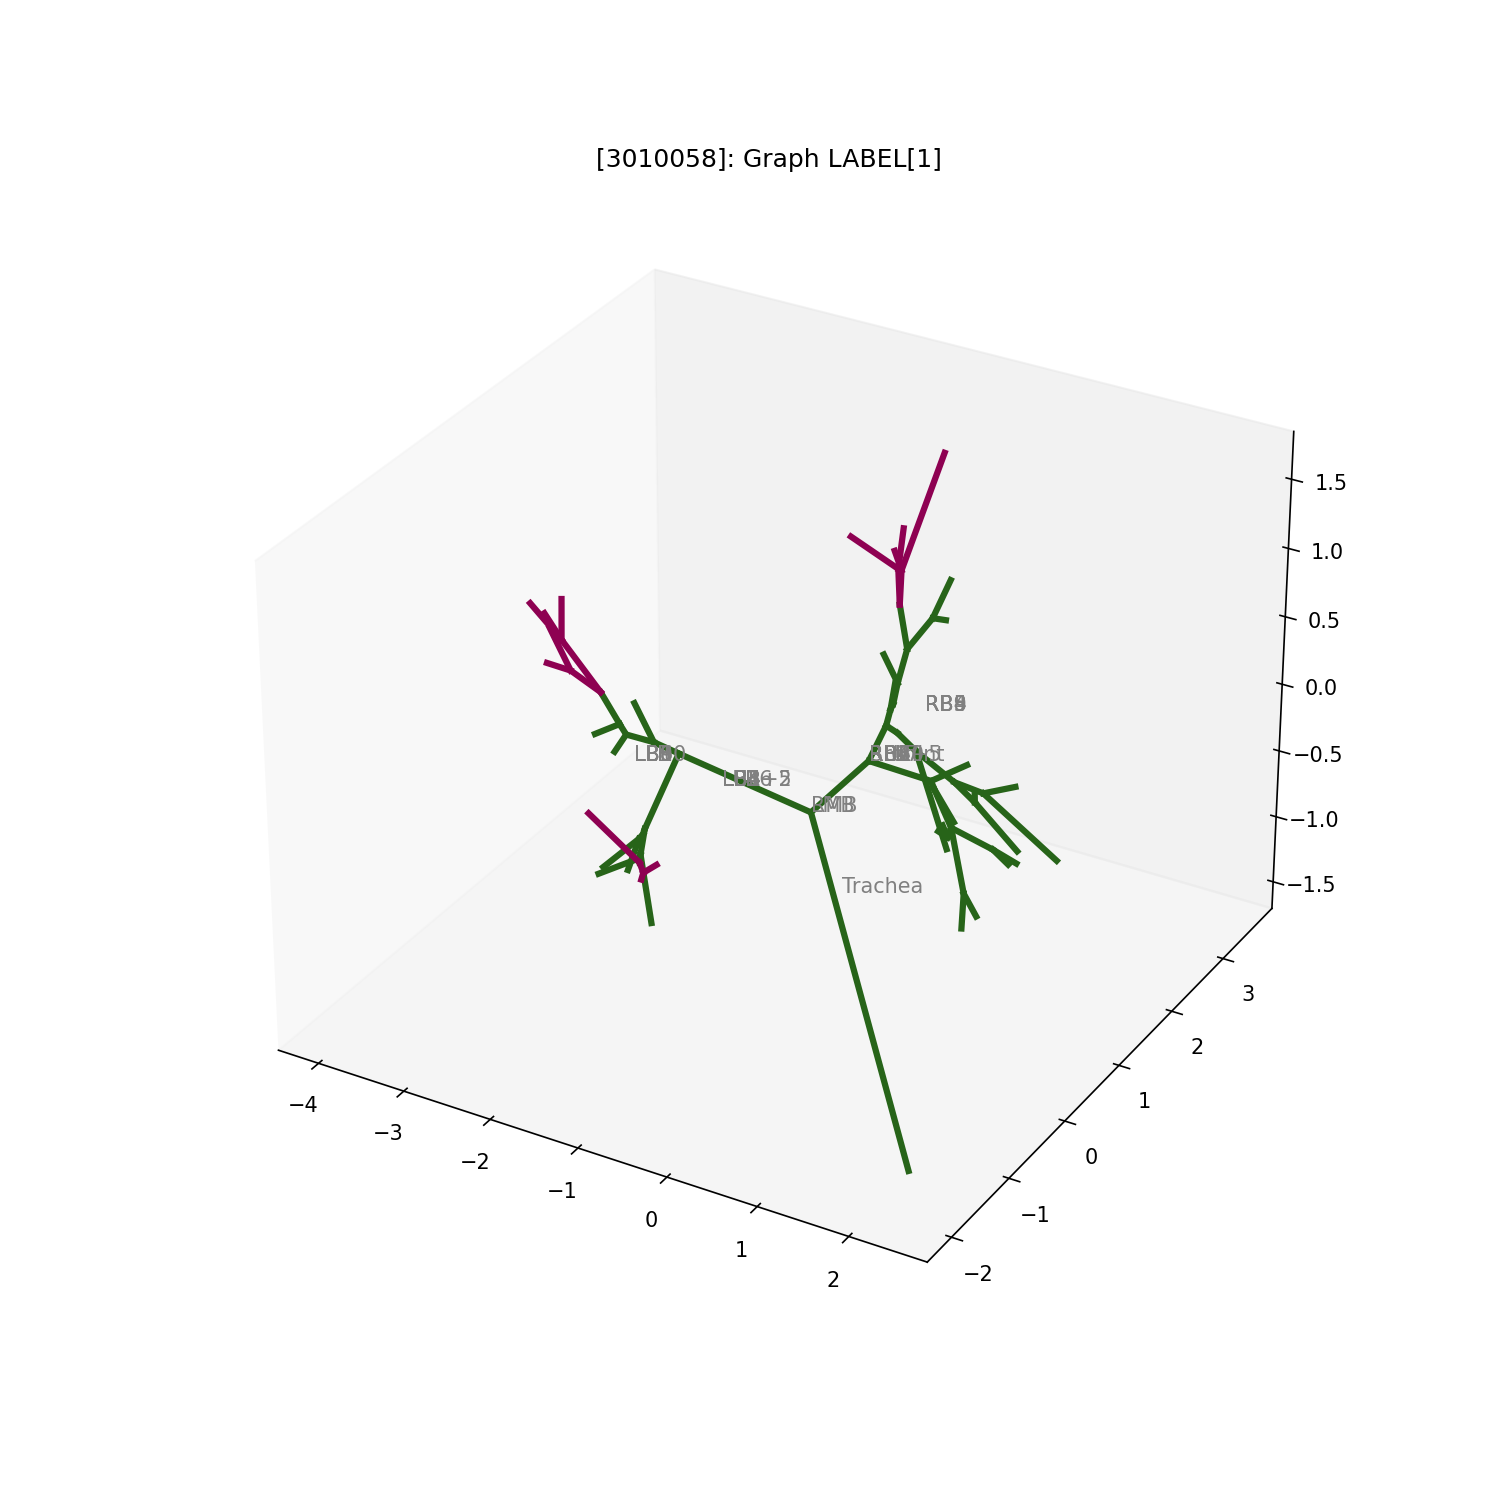

In [103]:
print("Standard anatomy", ids_to_remove)
print("Anomaly anatomy", toy_df_final.loc[~(toy_df_final.idno.isin(ids_to_remove))].idno.unique())
print("Anomaly anatomy is INCLUDING BRANCHES OFF RB10, LB1, LB10")
tree_w_coords = toy_df_final.loc[(toy_df_final.idno==3010058)]
val_min = 0
val_max=1
# cmap = mpl.cm.RdYlGn#.reversed()
cmap = mpl.colormaps['PiYG'].reversed()
norm = mpl.colors.Normalize(vmin=val_min, vmax=val_max)

# simpliofy names
tree_w_coords['anatomicalname'] = tree_w_coords['anatomicalname'].apply(lambda x:"" if ('unnamed' in x) or (x == '-') else x)
tree_w_coords['color'] = tree_w_coords.endbpid.apply(lambda x:1 if x in nodes_to_remove else 0)
print(tree_w_coords.color.sum()/len(tree_w_coords))
row = tree_w_coords.iloc[0]
# quick visualisation of tree

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
for i in range(len(tree_w_coords)):
    row = tree_w_coords.iloc[i]

    ax.plot([row.parent_loc_nx,row.nx], [row.parent_loc_ny,row.ny], [row.parent_loc_nz, row.nz], linestyle='-',linewidth=3, color= cmap(norm(row.node_label)), label=row.anatomicalname)
    ax.text(int(sum([row.parent_loc_nx,row.nx])/2), int(sum([row.parent_loc_ny,row.ny])/2),int(sum([row.parent_loc_nz, row.nz])/2), row.anatomicalname, color='grey')


ax.grid(False)
ax.set_facecolor(color=(1,1,1))
plt.title(str(tree_w_coords.idno.unique())+ ': Graph LABEL'+ str(tree_w_coords.graph_label.unique()))
plt.show()

In [104]:
# weird graphs where the trachea is not 1
issues_w_trachea = []
for name, graph in toy_df_final.groupby('idno'):
    try:
        assert len(graph.loc[(graph.endbpid==1) & (graph.anatomicalname.str.lower()=='trachea')]) == 1
    except:
        display(graph.loc[graph.anatomicalname.str.lower()=='trachea'])
        print(f'Adding {name} to remove')
        issues_w_trachea.append(name)
        


,index,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,...,LL_1,Standard,Acc_B,Abs_RB7,Acc_LB7,Rare,Unclassified,desc_list,node_label,graph_label
75319,2,3015262,Trachea,2.793055,1.554765,0.0,0.0,2.0,1.0,143.116,...,Standard,1.0,0.0,0.0,0.0,0.0,0.0,"{132.0, 133.0, 134.0, 135.0, 263.0, 264.0, 265...",0,1


Adding 3015262 to remove


,index,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,...,LL_1,Standard,Acc_B,Abs_RB7,Acc_LB7,Rare,Unclassified,desc_list,node_label,graph_label
187326,0,4010574,Trachea,2.723306,1.42682,0.0,0.0,2.0,-1.0,0.0,...,Standard,1.0,0.0,0.0,0.0,0.0,0.0,"{128.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15....",0,1


Adding 4010574 to remove


,index,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,...,LL_1,Standard,Acc_B,Abs_RB7,Acc_LB7,Rare,Unclassified,desc_list,node_label,graph_label
285989,1,4017943,Trachea,3.590106,1.54537,0.0,0.0,2.0,-1.0,0.0,...,Standard,1.0,0.0,0.0,0.0,0.0,0.0,"{258.0, 3.0, 4.0, 5.0, 259.0, 7.0, 8.0, 9.0, 1...",0,1


Adding 4017943 to remove


,index,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,...,LL_1,Standard,Acc_B,Abs_RB7,Acc_LB7,Rare,Unclassified,desc_list,node_label,graph_label
613735,1,7012330,Trachea,5.571968,1.309251,0.0,0.0,2.0,-1.0,0.0,...,Standard,1.0,0.0,0.0,0.0,0.0,0.0,"{11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18....",0,1


Adding 7012330 to remove


,index,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,...,LL_1,Standard,Acc_B,Abs_RB7,Acc_LB7,Rare,Unclassified,desc_list,node_label,graph_label
616506,1,7012616,Trachea,4.310497,1.809765,0.0,0.0,2.0,-1.0,0.0,...,Standard,1.0,0.0,0.0,0.0,0.0,0.0,"{132.0, 133.0, 13.0, 14.0, 15.0, 16.0, 17.0, 1...",0,0


Adding 7012616 to remove


,index,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,...,LL_1,Standard,Acc_B,Abs_RB7,Acc_LB7,Rare,Unclassified,desc_list,node_label,graph_label
797778,1,8014833,Trachea,5.022709,1.516336,0.0,0.0,2.0,-1.0,0.0,...,Standard,1.0,0.0,0.0,0.0,0.0,0.0,"{3.0, 4.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13...",0,0


Adding 8014833 to remove


,index,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,...,LL_1,Standard,Acc_B,Abs_RB7,Acc_LB7,Rare,Unclassified,desc_list,node_label,graph_label


Adding 8015457 to remove


,index,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,...,LL_1,Standard,Acc_B,Abs_RB7,Acc_LB7,Rare,Unclassified,desc_list,node_label,graph_label
860234,1,8022046,Trachea,3.633689,1.495789,0.0,0.0,2.0,-1.0,0.0,...,Standard,1.0,0.0,0.0,0.0,0.0,0.0,"{5.0, 6.0, 133.0, 134.0, 9.0, 10.0, 11.0, 12.0...",0,0


Adding 8022046 to remove


In [105]:
toy_df_final = toy_df_final.loc[~(toy_df_final.idno.isin(issues_w_trachea))]
print(toy_df_final.idno.nunique())

2093


In [106]:
toy_df_final.to_csv('/home/sneha/toy_normalised_1407.csv',index=False)

In [107]:
label_df = toy_df_final[['idno', 'startbpid', 'endbpid', 'graph_label', 'node_label']]
label_df.to_csv('/home/sneha/toy_labels_1407.csv',index=False)

In [ ]:
# process dataset so that its perfect for customdataset

In [ ]:

def _relabel_start_endbpid(df)

    relabel_map = {v:k+1 for k,v in df.endbpid.to_dict().items()}
    # add trachea map (node 0)
    relabel_map[-1] = 0
    # save mapping
    self.node_map[index] = (df.idno.unique().item(), relabel_map)
    # apply relabelling to source and end nodes
    df['start_node'] = df.startbpid.apply(lambda x: relabel_map[x])
    df['end_node'] = df.endbpid.apply(lambda x: relabel_map[x])
    return df


def _add_trachea_node_features(df, node_features):
     # adding trachea info to top of list
    trachea_dict = dict.fromkeys(node_features, 0)
    for i in ['x_norm', 'y_norm', 'z_norm']:
        trachea_dict[i] = df.loc[df.endbpid==1][str('parent_loc_'+i)].item()
    
    trachea_df = pd.DataFrame.from_dict(trachea_dict)
    # concat onto df
    df = pd.concat([trachea_df, df[[node_features]]], axis=0)
    

    

In [19]:
node_features = ['x_norm', 'y_norm', 'z_norm', 'dircosx_norm',
               'dircosy_norm', 'dircosz_norm','angle_norm', 'weibel_generation_norm','dist_nn_in_lobe_norm',
                 'num_desc_norm','max_path_length_norm','centerlinelength_norm','avginnerarea_norm']
#                 ,'lobe_norm','sublobe_norm']
edge_feature_names = ['centerlinelength_norm','avginnerarea_norm']

args = {'node_feature_names': node_features, 'edge_feature_names':edge_feature_names}
# DATASETS
my_data_train  = CustomDataset('data_all_toy_test/',
                               '/home/sneha/toy_normalised_0607.csv',
                               "/home/sneha/toy_labels_0607.csv",
                               args = args,
                               label_col_name='node_label'
                              )




Using Node features: ['x_norm', 'y_norm', 'z_norm', 'dircosx_norm', 'dircosy_norm', 'dircosz_norm', 'angle_norm', 'weibel_generation_norm', 'dist_nn_in_lobe_norm', 'num_desc_norm', 'max_path_length_norm', 'centerlinelength_norm', 'avginnerarea_norm'], Edge features: ['centerlinelength_norm', 'avginnerarea_norm']
Getting labels from: node_label


Processing...


# Graphs 136972 Label Frequency Counter({0: 135936, 1: 1036})
Class proportions: {0: 0.9924364103612417, 1: 0.007563589638758287}


100%|██████████████████████████████████████████████████████████████████████████████| 2093/2093 [00:12<00:00, 173.01it/s]
Done!


In [67]:
### Test to see if the labels are loaded in correctly --> Yes it is except for the label for the trachea node which needs to be sorted
idnos = [a for (a,b) in my_data_train.node_map.values()]
i = idnos.index(3010058)
data = my_data_train[i]
print(data)
# visualise data
idno, relabel = my_data_train.node_map[i]
print(idno, relabel)
y = data.y
print(y.shape)
y = [0] + list(y)
print(np.array([y]).shape)
loc_features = data.x[:,:3]
print(loc_features.shape)
features_and_labels = np.concatenate([loc_features, np.array([y]).T], axis=1)

display(toy_df_final.loc[(toy_df_final.idno==3010058)&(toy_df_final.node_label == 1)][['x_norm', 'y_norm', 'z_norm']]
)

features_and_labels[np.where(features_and_labels[:,-1] == 1)]

Data(x=[73, 13], edge_index=[2, 72], edge_attr=[72, 2], y=[72])
3010058 {1.0: 1, 4.0: 2, 5.0: 3, 7.0: 4, 6.0: 5, 9.0: 6, 8.0: 7, 10.0: 8, 11.0: 9, 12.0: 10, 13.0: 11, 14.0: 12, 15.0: 13, 17.0: 14, 16.0: 15, 19.0: 16, 21.0: 17, 20.0: 18, 24.0: 19, 25.0: 20, 27.0: 21, 28.0: 22, 29.0: 23, 30.0: 24, 31.0: 25, 34.0: 26, 35.0: 27, 36.0: 28, 37.0: 29, 44.0: 30, 45.0: 31, 48.0: 32, 49.0: 33, 52.0: 34, 54.0: 35, 55.0: 36, 100.0: 37, 69.0: 38, 68.0: 39, 82.0: 40, 83.0: 41, 90.0: 42, 91.0: 43, 97.0: 44, 96.0: 45, 98.0: 46, 99.0: 47, 102.0: 48, 101.0: 49, 124.0: 50, 125.0: 51, 146.0: 52, 147.0: 53, 148.0: 54, 150.0: 55, 149.0: 56, 161.0: 57, 162.0: 58, 163.0: 59, 164.0: 60, 173.0: 61, 174.0: 62, 181.0: 63, 182.0: 64, 274.0: 65, 275.0: 66, 277.0: 67, 276.0: 68, 358.0: 69, 359.0: 70, 360.0: 71, 361.0: 72, -1: 0}
torch.Size([72])
(1, 73)
torch.Size([73, 3])


,x_norm,y_norm,z_norm
446,0.383373,0.622171,0.430042


array([[0.38337314, 0.62217104, 0.43004227, 1.        ]])

In [20]:

# train_loader = DataLoader(my_data_train, batch_size=batch_size, sampler = sampler_train, shuffle=True)

from torch_geometric.loader import NeighborLoader, ImbalancedSampler
from torch_geometric.data import Batch
# print(my_data_train.y)
# sampler_train = ImbalancedSampler(my_data_train)
train_obj = Batch.from_data_list(my_data_train) # loading all graphs into batch object
train_obj.n_id = torch.arange(train_obj.num_nodes)
indices = torch.where(train_obj.y==0)[0]#filtering majority class
print(len(indices)/len(train_obj.y), indices)
train_loader = NeighborLoader(train_obj,num_neighbors=[-1]*3, input_nodes=indices, batch_size=128, shuffle=True)  
data = next(iter(train_loader))
# train_loader = NeighborLoader(my_data_train,num_neighbors= -1, batch_size=2, shuffle=False)
# loader = NeighborLoader(data, input_nodes=data.train_mask,
#                         batch_size=64, num_neighbors=[-1, -1],
#                         sampler=sampler, ...)


# test_loader =  DataLoader(my_data_test, batch_size=batch_size, shuffle=False)

print(data)
data.batch, data.n_id, data.y

0.9924364103612417 tensor([     0,      1,      2,  ..., 136969, 136970, 136971])
DataBatch(x=[495, 13], edge_index=[2, 367], edge_attr=[367, 2], y=[136972], batch=[495], ptr=[2094], n_id=[495], batch_size=128)


(tensor([1856, 1420,  223,  698,  685, 1374,  627,  556,  865, 1393,  496, 1919,
         1225, 1216, 1466,  296,  856, 1531, 1088,  949, 1152,  346,  434,  179,
         1193, 1462, 1301,  415,  750,   68,  671,  841,  297,   89, 1332,  172,
         1716, 1189, 1352,  587,  579, 1304, 1247, 1146, 1164, 1925, 1444, 2040,
         1633, 1451, 1533, 1648, 1095,  135, 1631, 1064, 1943, 1013, 1824,  654,
          877, 1295,  242,   61, 1658, 1181,  893,  606,  249,  989, 1603, 1224,
         1546, 1626,  944,  938,  773,  252,  412,   33,   55,  520, 1827, 1387,
          527, 1082,  447,  767, 1193, 1580,  244, 1179, 1167,  232, 1111, 2003,
         1210,    9, 2042,  595,  861, 1363,  430,  117,  289,  649, 2058, 1208,
         1122, 1086, 1442, 1661, 1887, 1999, 1159, 1417, 1802,  529, 1241,  181,
          933, 1665, 1030,   86,  142,  996,  365,  874, 1856, 1420,  223,  698,
          685, 1374,  627,  556,  865, 1393, 1919, 1225, 1216, 1466,  296,  856,
         1531, 1088,  949, 1

In [21]:
index = [index for index, (idno, relabel) in my_data_train.node_map.items() if idno == 3010112][0]
data = my_data_train[index]
print(data)
label = data.y
g = to_networkx(data)
# get relabelmap
idno, relabel = my_data_train.node_map[index]
# map to original df
vis_graph  =toy_df_final.loc[toy_df_final.idno==idno]
print(vis_graph.columns)
print(f"This graph is for id: {idno}")
display(vis_graph[['x_norm', 'y_norm', 'z_norm']].head())
print(data.x[1:6,:3])
# get the relabelling to match the pytorch graph 
vis_graph['start_node'] = vis_graph.startbpid.apply(lambda x:relabel[x])
vis_graph['end_node'] = vis_graph.endbpid.apply(lambda x:relabel[x])

np.argmax(vis_graph.node_label.values), np.argmax(data.y)

Data(x=[71, 13], edge_index=[2, 70], edge_attr=[70, 2], y=[70])
Index(['idno', 'anatomicalname', 'centerlinelength', 'avginnerarea', 'lobe',
       'sublobe', 'endbpid', 'startbpid', 'angle', 'dircosx', 'dircosy',
       'dircosz', 'weibel_generation', 'QC', 'x', 'y', 'z', 'parent_loc_x',
       'parent_loc_y', 'parent_loc_z', 'endbpid_nn_in_lobe', 'dist_nn_in_lobe',
       'num_desc', 'max_path_length', 'centerlinelength_norm',
       'avginnerarea_norm', 'dist_nn_in_lobe_norm', 'max_path_length_norm',
       'angle_norm', 'weibel_generation_norm', 'num_desc_norm', 'lobe_norm',
       'sublobe_norm', 'x_norm', 'y_norm', 'z_norm', 'parent_loc_x_norm',
       'parent_loc_y_norm', 'parent_loc_z_norm', 'dircosx_norm',
       'dircosy_norm', 'dircosz_norm', 'shift_x', 'shift_y', 'shift_z', 'nx',
       'ny', 'nz', 'parent_loc_nx', 'parent_loc_ny', 'parent_loc_nz',
       'nx_norm', 'ny_norm', 'nz_norm', 'parent_loc_nx_norm',
       'parent_loc_ny_norm', 'parent_loc_nz_norm', 'LL_1', 'Stand

,x_norm,y_norm,z_norm
1371,0.467956,0.465311,0.256486
1372,0.578904,0.500865,0.380961
1373,0.435906,0.465311,0.305888
1374,0.617437,0.475757,0.366706
1375,0.591133,0.506556,0.413273


tensor([[0.4680, 0.4653, 0.2565],
        [0.5789, 0.5009, 0.3810],
        [0.4359, 0.4653, 0.3059],
        [0.6174, 0.4758, 0.3667],
        [0.5911, 0.5066, 0.4133]])


/tmp/ipykernel_10543/838491431.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vis_graph['start_node'] = vis_graph.startbpid.apply(lambda x:relabel[x])
/tmp/ipykernel_10543/838491431.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vis_graph['end_node'] = vis_graph.endbpid.apply(lambda x:relabel[x])


(35, tensor(35))